# Spam Emails Detection NLP

## Part Two Features Engineering


In [1]:
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import re 
pd.options.display.max_colwidth = 200
import gensim


## Import dataset and Data Exploration

[Source:](https://www.kaggle.com/karthickveerakumar/spam-filter)

In [37]:
nlp_emails = pd.read_csv('nlp_emails.csv')


In [38]:
nlp_emails[0:2]

,Unnamed: 0,text,spam,norm_X,nlp_X,topic
0,3973,"Subject: fyi : energy operations promotions hi vince , scott pleus ( listed below in the director promotion section ) is bandwidth - trading backoffice person we  , ve been working with . i hav...",0,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs since started around time fac...,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs started time fact people talk sally be...,4
1,4996,"Subject: hedge effectiveness test for fair value hedges gentlemen : we have had favorable responses regarding the use of our volatility reduction method ( roger , i ' ve attached a copy of our ...",0,subject hedge effectiveness test fair value hedges gentlemen favorable responses regarding use volatility reduction method roger attached copy article case seen however continued quibble ...,subject hedge effectiveness test fair value hedges gentlemen favorable responses use volatility reduction method roger attached copy article case seen continued quibble create set data points inpu...,1



## Deep learning Methods

### Implementing a word2vec model using a CBOW (Continuous Bag of Words) neural network architecture


#### Build the corpus vocabulary( use the normolize X matrix previously)

In [39]:
nlp_X= emails['nlp_X']

In [40]:
nlp_X.shape

(1000,)

In [41]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(nlp_X)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in nlp_X]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 14154
Vocabulary Sample: [('enron', 1), ('subject', 2), ('vince', 3), ('hou', 4), ('kaminski', 5), ('j', 6), ('research', 7), ('time', 8), ('e', 9), ('energy', 10)]


### Build (context_words, target_word) pair generator

In [42]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [43]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['subject', 'fyi', 'operations', 'promotions'] -> Target (Y): energy
Context (X): ['fyi', 'energy', 'promotions', 'hi'] -> Target (Y): operations
Context (X): ['energy', 'operations', 'hi', 'vince'] -> Target (Y): promotions
Context (X): ['operations', 'promotions', 'vince', 'scott'] -> Target (Y): hi
Context (X): ['promotions', 'hi', 'scott', 'pleus'] -> Target (Y): vince
Context (X): ['hi', 'vince', 'pleus', 'listed'] -> Target (Y): scott
Context (X): ['vince', 'scott', 'listed', 'director'] -> Target (Y): pleus
Context (X): ['scott', 'pleus', 'director', 'promotion'] -> Target (Y): listed
Context (X): ['pleus', 'listed', 'promotion', 'section'] -> Target (Y): director
Context (X): ['listed', 'director', 'section', 'bandwidth'] -> Target (Y): promotion
Context (X): ['director', 'promotion', 'bandwidth', 'trading'] -> Target (Y): section


### Build CBOW Deep Network Model

In [44]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            1415400   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14154)             1429554   
Total params: 2,844,954
Trainable params: 2,844,954
Non-trainable params: 0
_________________________________________________________________
None


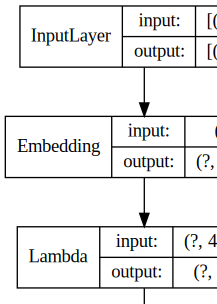

In [45]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

### Get Word Embeddings

In [46]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(14153, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
subject,-0.016812,0.022621,0.023400,0.028708,0.029551,-0.020211,0.014862,-0.003314,-0.047521,0.046344,...,0.033592,0.023765,0.009391,0.032904,-0.008651,0.028188,0.024794,-0.035978,0.001048,0.038514
vince,-0.047239,-0.047387,0.046497,0.032337,-0.000486,-0.014097,-0.021558,-0.034685,0.001419,0.025213,...,-0.004764,-0.040436,-0.035760,0.024835,-0.020386,-0.001555,-0.041955,-0.005921,-0.030683,0.030366
hou,-0.002132,-0.024919,-0.019607,0.048060,-0.033819,-0.022189,-0.007404,-0.044714,-0.049287,0.017479,...,-0.042379,0.041614,-0.018493,-0.024986,-0.042343,0.011269,0.032197,0.018577,0.001988,-0.018678
kaminski,0.045071,0.022558,-0.040420,0.005111,0.009561,-0.049258,-0.046856,0.027575,0.035528,-0.044013,...,0.040746,-0.022456,0.043658,-0.009563,-0.005141,0.041408,-0.029390,-0.004213,0.025788,-0.036299
j,-0.017401,-0.011131,-0.017376,0.016186,0.004893,-0.037605,0.010877,-0.041524,-0.039407,-0.010378,...,-0.030533,0.001661,0.046029,-0.012815,-0.043890,-0.032323,-0.034658,0.028224,-0.026947,-0.004220


### Build a distance matrix to view the most similar words (contextually)

In [47]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['software', 'price', 'new', 'enron', 'market', 'management', 'credit', 'power', 'model', 'risk']}

similar_words

(14153, 14153)


{'software': ['instead', 'chibbard', 'generating', 'thenext', 'fewer'],
 'price': ['dc', 'dhabol', 'salmon', 'drinks', 'stimulating'],
 'new': ['rd', 'things', 'consultant', 'converted', 'richard'],
 'enron': ['cairn', 'attempting', 'sycamore', 'ret', 'suffering'],
 'market': ['lana', 'vandor', 'loves', 'dhar', 'chromic'],
 'management': ['wellhead', 'patch', 'unwanted', 'spe', 'toni'],
 'credit': ['finalize', 'artwork', 'richard', 'episcopate', 'leach'],
 'power': ['einstein', 'gpg', 'elisabeth', 'contstraints', 'succeed'],
 'model': ['bastante', 'street', 'providers', 'dennis', 'niche'],
 'risk': ['material', 'enhanced', 'petrochem', 'bayarea', 'construction']}

#### Build and View sample skip grams ((word1, word2) -> relevancy)

In [48]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(new (15), banking (2159)) -> 1
(desk (403), risk (17)) -> 1
( (73), angry (12237)) -> 0
(sheri (4045), parrino (10035)) -> 0
(new (15), global (291)) -> 1
(business (19), cpt (6939)) -> 0
(operations (290), central (905)) -> 1
(pulp (2158), business (19)) -> 1
(records (1561), double (2186)) -> 0
(collections (4779), diapers (8513)) -> 0


In [14]:
#Train the model for 5 epochs

In [15]:
''''''
#for epoch in range(1, 6):
    #loss = 0
    #for i, elem in enumerate(skip_grams):
        #pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        #pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        #labels = np.array(elem[1], dtype='int32')
        #X = [pair_first_elem, pair_second_elem]
        #Y = labels
        #if i % 10000 == 0:
            #print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        #loss += model.train_on_batch(X,Y)  

    #print('Epoch:', epoch, 'Loss:', loss)
    
''''''

''

''

### Get word embeddings

#### Build a distance matrix to view the most similar words (contextually)

In [49]:

from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['new', 'website', 'company', 'business', 'click', 'mail', 'free', 'money', 'information', 'email']}

similar_words


(14153, 14153)


{'new': ['rd', 'things', 'consultant', 'converted', 'richard'],
 'website': ['extra', 'swap', 'assumes', 'sewage', 'willachieve'],
 'company': ['pitch', 'livestock', 'illustrate', 'regulations', 'help'],
 'business': ['feared', 'kollaros', 'coachhouse', 'erms', 'mw'],
 'click': ['promotional',
  'rothchilds',
  'fairfax',
  'responsibilities',
  'trang'],
 'mail': ['mitnick', 'iasts', 'post', 'mallamyusuf', 'requirement'],
 'free': ['jayasuriya', 'wear', 'editor', 'broadway', 'allow'],
 'money': ['winning', 'inwind', 'pr', 'krisna', 'grammar'],
 'information': ['merton', 'illustration', 'insuring', 'patched', 'jet'],
 'email': ['forthcoming', 'painfully', 'quick', 'dist', 'mcevoy']}

### Visualize word embeddings

Total words: 60 	Word Embedding shapes: (60, 100)


<Figure size 1008x576 with 0 Axes>

Text(0, 0, 'new')

Text(0, 0, 'rd')

Text(0, 0, 'things')

Text(0, 0, 'consultant')

Text(0, 0, 'converted')

Text(0, 0, 'richard')

Text(0, 0, 'website')

Text(0, 0, 'extra')

Text(0, 0, 'swap')

Text(0, 0, 'assumes')

Text(0, 0, 'sewage')

Text(0, 0, 'willachieve')

Text(0, 0, 'company')

Text(0, 0, 'pitch')

Text(0, 0, 'livestock')

Text(0, 0, 'illustrate')

Text(0, 0, 'regulations')

Text(0, 0, 'help')

Text(0, 0, 'business')

Text(0, 0, 'feared')

Text(0, 0, 'kollaros')

Text(0, 0, 'coachhouse')

Text(0, 0, 'erms')

Text(0, 0, 'mw')

Text(0, 0, 'click')

Text(0, 0, 'promotional')

Text(0, 0, 'rothchilds')

Text(0, 0, 'fairfax')

Text(0, 0, 'responsibilities')

Text(0, 0, 'trang')

Text(0, 0, 'mail')

Text(0, 0, 'mitnick')

Text(0, 0, 'iasts')

Text(0, 0, 'post')

Text(0, 0, 'mallamyusuf')

Text(0, 0, 'requirement')

Text(0, 0, 'free')

Text(0, 0, 'jayasuriya')

Text(0, 0, 'wear')

Text(0, 0, 'editor')

Text(0, 0, 'broadway')

Text(0, 0, 'allow')

Text(0, 0, 'money')

Text(0, 0, 'winning')

Text(0, 0, 'inwind')

Text(0, 0, 'pr')

Text(0, 0, 'krisna')

Text(0, 0, 'grammar')

Text(0, 0, 'information')

Text(0, 0, 'merton')

Text(0, 0, 'illustration')

Text(0, 0, 'insuring')

Text(0, 0, 'patched')

Text(0, 0, 'jet')

Text(0, 0, 'email')

Text(0, 0, 'forthcoming')

Text(0, 0, 'painfully')

Text(0, 0, 'quick')

Text(0, 0, 'dist')

Text(0, 0, 'mcevoy')

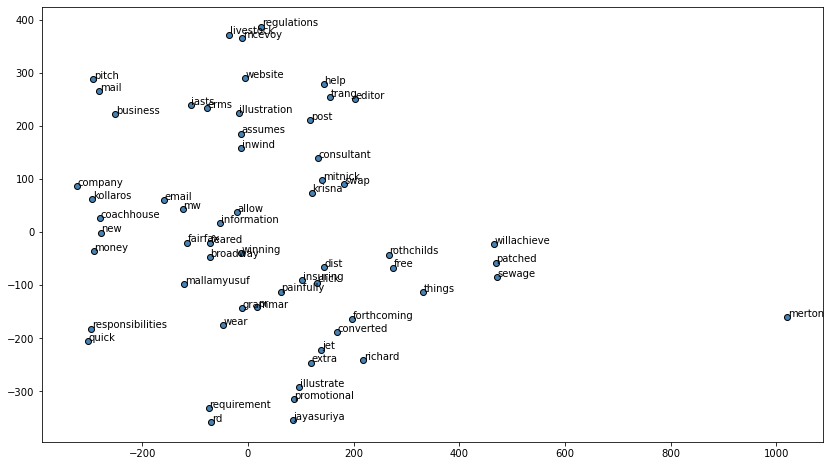

In [50]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points');

### Applying the word2vec model on normolized emails text


In [51]:
from gensim.models import word2vec
import nltk
from nltk.tokenize import word_tokenize


# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in nlp_X]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)


### Visualizing word embeddings


<Figure size 1008x576 with 0 Axes>

Text(0, 0, 'new')

Text(0, 0, 'rd')

Text(0, 0, 'things')

Text(0, 0, 'consultant')

Text(0, 0, 'converted')

Text(0, 0, 'richard')

Text(0, 0, 'website')

Text(0, 0, 'extra')

Text(0, 0, 'swap')

Text(0, 0, 'assumes')

Text(0, 0, 'sewage')

Text(0, 0, 'willachieve')

Text(0, 0, 'company')

Text(0, 0, 'pitch')

Text(0, 0, 'livestock')

Text(0, 0, 'illustrate')

Text(0, 0, 'regulations')

Text(0, 0, 'help')

Text(0, 0, 'business')

Text(0, 0, 'feared')

Text(0, 0, 'kollaros')

Text(0, 0, 'coachhouse')

Text(0, 0, 'erms')

Text(0, 0, 'mw')

Text(0, 0, 'click')

Text(0, 0, 'promotional')

Text(0, 0, 'rothchilds')

Text(0, 0, 'fairfax')

Text(0, 0, 'responsibilities')

Text(0, 0, 'trang')

Text(0, 0, 'mail')

Text(0, 0, 'mitnick')

Text(0, 0, 'iasts')

Text(0, 0, 'post')

Text(0, 0, 'mallamyusuf')

Text(0, 0, 'requirement')

Text(0, 0, 'free')

Text(0, 0, 'jayasuriya')

Text(0, 0, 'wear')

Text(0, 0, 'editor')

Text(0, 0, 'broadway')

Text(0, 0, 'allow')

Text(0, 0, 'money')

Text(0, 0, 'winning')

Text(0, 0, 'inwind')

Text(0, 0, 'pr')

Text(0, 0, 'krisna')

Text(0, 0, 'grammar')

Text(0, 0, 'information')

Text(0, 0, 'merton')

Text(0, 0, 'illustration')

Text(0, 0, 'insuring')

Text(0, 0, 'patched')

Text(0, 0, 'jet')

Text(0, 0, 'email')

Text(0, 0, 'forthcoming')

Text(0, 0, 'painfully')

Text(0, 0, 'quick')

Text(0, 0, 'dist')

Text(0, 0, 'mcevoy')

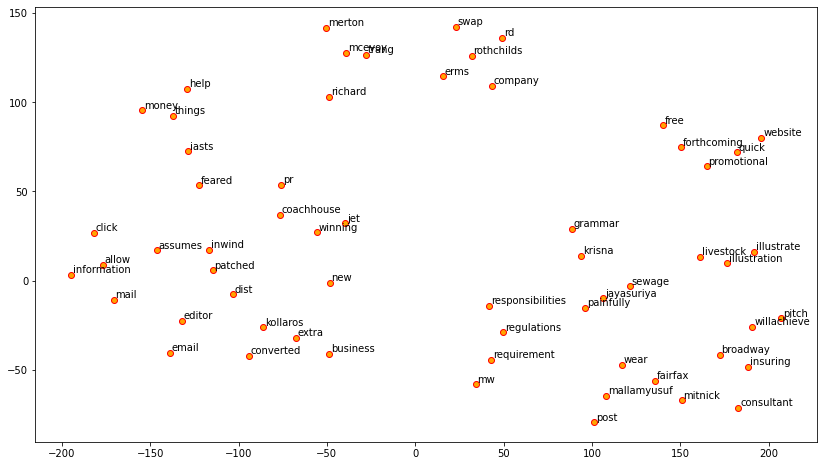

In [52]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Sample word embedding

In [21]:
w2v_model.wv['mail']

array([ 6.506777  ,  0.9638621 ,  5.883812  ,  1.6248138 , -0.3630628 ,
       -3.4574056 ,  2.800824  ,  3.6219573 ,  1.6421722 , -0.82563245,
        2.7042396 , -7.5561867 , -4.133722  , -0.23078948, -5.762688  ,
        6.5204787 , -2.4510787 , -2.6062438 , -3.8432617 , -1.8690293 ,
       -4.997853  , -2.4733229 , -9.84132   , -0.01099388, -1.0792009 ,
        2.1012614 , -3.0422087 , -3.7282372 , -2.716328  , -2.4099383 ,
       -2.6519678 ,  7.279069  , -4.5990868 ,  2.4265096 ,  3.7734163 ,
        8.135113  ,  0.9554067 ,  9.516465  , -2.763796  , -0.4841565 ,
        1.3767177 ,  1.8941427 ,  2.2408497 ,  0.20430626, -0.634624  ,
        0.9000587 ,  0.668199  , -7.8416324 ,  4.6309185 ,  2.0434675 ,
        3.3482301 ,  2.5473156 ,  0.6377296 , -5.549041  , -3.6260078 ,
       -5.0895104 , -6.08527   , -6.225759  , -3.8694558 ,  3.993017  ,
        4.3108196 , -3.781518  ,  0.6789416 ,  7.7423577 ,  2.2987742 ,
       11.598206  , -1.4196107 ,  1.7776202 , -1.1326853 ,  0.55

### Build framework for getting document level embeddings

In [53]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [54]:

w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.122135,0.809898,0.301212,0.041857,-0.920745,0.426492,0.116819,0.387556,0.112671,-0.530155,...,0.937015,0.041344,-0.061458,-1.075433,-1.642209,-0.269451,-0.836147,1.286159,-1.025264,0.287523
1,-0.524625,0.472127,-0.049727,0.258206,-0.505344,-0.467217,-0.068683,0.260119,-0.168553,-0.497008,...,0.796252,-0.561662,0.158167,-0.889971,0.866640,-0.700491,-0.021356,-0.352306,-0.263022,0.614195
2,0.333891,0.596571,0.805834,0.088547,-0.453770,-0.216917,-0.555122,-0.067827,-1.481214,-0.324024,...,-0.188335,-0.202261,-1.323302,0.433197,0.028354,-1.366064,0.263546,0.528802,-0.382320,0.068580
3,-2.146352,0.582433,2.159050,0.053452,1.378033,-1.555059,0.635888,-1.032141,-0.642449,0.373491,...,0.906603,1.863165,-1.453099,-1.031645,-1.265919,-1.142551,0.741668,-0.574941,0.461029,1.257664
4,-0.258756,1.282892,0.758310,-0.521542,0.597648,-0.758965,0.582774,-0.067496,-1.310332,0.460877,...,-0.017121,1.082448,-0.600953,-1.638072,-0.414630,-1.715958,0.218185,0.570612,-0.596702,1.474096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-2.148753,1.992780,1.755575,-0.702661,1.047622,-0.903087,1.973032,0.007071,-1.500162,0.605889,...,2.144480,2.113650,-0.636641,-1.329116,0.194311,-2.617155,-1.247323,1.776471,-0.423872,1.949814
996,-1.185981,1.809552,3.291750,-0.203172,2.403297,-2.153086,1.256361,0.044455,-1.348110,1.033899,...,2.211251,1.534884,-1.253151,-1.304622,-0.237181,-2.834884,-0.220403,1.372433,-0.082963,1.376257
997,0.059268,-0.071265,-0.843877,1.009767,0.333107,-0.919751,-0.391803,0.148515,-0.246775,0.007443,...,1.967345,-0.507921,0.008786,-1.116628,0.457375,-0.790494,0.604305,-1.102000,-0.599824,0.662284
998,0.914858,0.143246,-0.526166,-0.144368,-0.583876,-0.853566,-0.243639,-0.295068,-0.197418,-0.343690,...,1.803542,-0.827350,-0.392124,-0.630588,1.712010,-1.298405,0.354025,-1.073359,-0.896487,0.175493


### Clustering with word embeddings

In [55]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([emails, cluster_labels], axis=1)

AffinityPropagation()

,Unnamed: 0,text,spam,norm_X,nlp_X,topic,ClusterLabel
0,3973,"Subject: fyi : energy operations promotions hi vince , scott pleus ( listed below in the director promotion section ) is bandwidth - trading backoffice person we  , ve been working with . i hav...",0,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs since started around time fac...,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs started time fact people talk sally be...,4,21
1,4996,"Subject: hedge effectiveness test for fair value hedges gentlemen : we have had favorable responses regarding the use of our volatility reduction method ( roger , i ' ve attached a copy of our ...",0,subject hedge effectiveness test fair value hedges gentlemen favorable responses regarding use volatility reduction method roger attached copy article case seen however continued quibble ...,subject hedge effectiveness test fair value hedges gentlemen favorable responses use volatility reduction method roger attached copy article case seen continued quibble create set data points inpu...,1,38
2,1498,"Subject: merit and equity increases norma , i am sending you an excel spreadsheet with proposed merit and equity increases . i have slightly exceeded the merit quota . the equity increases ad...",0,subject merit equity increases norma sending excel spreadsheet proposed merit equity increases slightly exceeded merit quota equity increases address two issues retention error setting salary...,subject merit equity increases norma sending excel spreadsheet proposed merit equity increases slightly exceeded merit quota equity increases address issues retention error setting salary hiring t...,3,57
3,3701,Subject: thank you ! fyi from valeria . - - - - - - - - - - - - - - - - - - - - - - forwarded by shirley crenshaw / hou / ect on 09 / 12 / 2000 10 : 03 am - - - - - - - - - - - - - - - - - - - ...,0,subject thank fyi valeria forwarded shirley crenshaw hou ect valeria stone exxon sprint com shirley crenshaw enron ...,subject thank fyi valeria forwarded shirley crenshaw hou valeria stone exxon sprint shirley crenshaw enron subject thank date september stone v valeria vistone americas ext shirley crenshaw enron ...,0,2
4,1897,Subject: your talk on 2 / 7 / 00 ( monday ) ( fwd ) vince : a minor revision of my earlier email shown below . the last line should read ' i will be waiting in my office from 6 : 30 - 6 : 50 for...,0,subject talk monday fwd vince minor revision earlier email shown last line read waiting office call office phone sorry resend email ed forwarded message ...,subject talk monday fwd vince minor revision earlier email shown line read waiting office office phone sorry resend email ed forwarded message date thu feb cst edward kao vince j kaminski subject ...,4,67
...,...,...,...,...,...,...,...
995,1565,"Subject: project richard , i would like to inform you that we decided against participation in your project . thanks for your interest in having enron involved in the study . vince kaminski",0,subject project richard would like inform decided participation project thanks interest enron involved study vince kaminski,subject project richard like inform decided participation project thanks interest enron involved study vince kaminski,0,20
996,3746,"Subject: re : phone interview there will be a telephone interview with jerzy jarosz ( resume attached below ) on wednesday , july 5 at 4 : 30 pm houston time . he would like you to call him at ...",0,subject phone interview telephone interview jerzy jarosz resume attached wednesday july pm houston time would like call home telephone reserved ebl interview questions please ...,subject phone interview telephone interview jerzy jarosz resume attached wednesday july houston time like home telephone reserved ebl interview questions thanks s

In [56]:
nlp_emails = pd.concat([emails, cluster_labels], axis=1)

In [57]:
nlp_emails[0:3]

,Unnamed: 0,text,spam,norm_X,nlp_X,topic,ClusterLabel
0,3973,"Subject: fyi : energy operations promotions hi vince , scott pleus ( listed below in the director promotion section ) is bandwidth - trading backoffice person we  , ve been working with . i hav...",0,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs since started around time fac...,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs started time fact people talk sally be...,4,21
1,4996,"Subject: hedge effectiveness test for fair value hedges gentlemen : we have had favorable responses regarding the use of our volatility reduction method ( roger , i ' ve attached a copy of our ...",0,subject hedge effectiveness test fair value hedges gentlemen favorable responses regarding use volatility reduction method roger attached copy article case seen however continued quibble ...,subject hedge effectiveness test fair value hedges gentlemen favorable responses use volatility reduction method roger attached copy article case seen continued quibble create set data points inpu...,1,38
2,1498,"Subject: merit and equity increases norma , i am sending you an excel spreadsheet with proposed merit and equity increases . i have slightly exceeded the merit quota . the equity increases ad...",0,subject merit equity increases norma sending excel spreadsheet proposed merit equity increases slightly exceeded merit quota equity increases address two issues retention error setting salary...,subject merit equity increases norma sending excel spreadsheet proposed merit equity increases slightly exceeded merit quota equity increases address issues retention error setting salary hiring t...,3,57


<Figure size 576x432 with 0 Axes>

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '0')

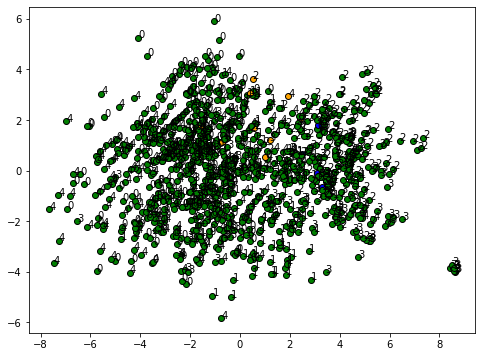

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(nlp_emails['topic'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

### GloVe Embeddings with spaCy

In [60]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


### Visualize GloVe word embeddings

In [61]:
unique_words = list(set([word for sublist in [doc.split() for doc in nlp_X] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
drilied,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
skyrocket,-0.473280,0.370310,-0.210970,0.233280,-0.138040,-0.420290,-0.313260,0.131420,0.332960,0.70185,...,-0.529000,0.124440,0.26237,0.095656,-0.076222,0.038321,-0.203900,0.094207,0.404370,-0.110830
despatch,-0.204820,0.565960,-0.299250,-0.308740,-0.456200,-0.251260,-0.329220,-0.382490,-0.177580,0.26882,...,-0.027028,0.050695,0.43367,-0.159600,0.416080,-0.432490,0.393800,0.289980,-0.498430,-0.106800
achieving,-0.370740,0.466490,-0.302950,-0.113570,-0.018686,-0.269520,0.021969,0.572890,0.370780,2.01370,...,0.134830,0.243840,0.44251,-0.105240,0.277930,0.214550,-0.122710,-0.152360,0.155720,0.316620
notified,0.247130,0.128720,-0.394130,0.044321,-0.454730,-0.074275,0.186830,-0.599550,-0.143400,2.34970,...,-0.292980,0.258520,0.42850,0.168960,0.226860,-0.712210,-0.425790,-0.149150,0.262140,0.263390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lampholder,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
px,0.329730,0.613420,0.041563,-0.537070,-0.085564,-0.459490,-0.535030,0.625300,-0.009955,-1.33120,...,0.543480,-0.477350,0.50768,-0.319930,0.063637,0.048056,-0.065482,0.229640,0.283710,-0.159820
disappoint,-0.097885,-0.043577,-0.175270,-0.389600,-0.080798,-0.252110,0.219470,0.009153,-0.069792,1.56480,...,-0.284440,0.066101,-0.50079,0.100610,0.268150,-0.343000,0.090151,-0.191580,-0.023515,-0.329960
shal,-0.083142,0.059599,0.538660,-0.211180,0.384850,-0.602640,0.189590,-0.142310,0.335020,-0.45904,...,-0.142380,-0.192330,-0.15928,0.190090,0.486910,-0.152310,0.149660,-0.315530,-0.167660,-0.090498


<Figure size 864x432 with 0 Axes>

Text(0, 0, 'drilied')

Text(0, 0, 'skyrocket')

Text(0, 0, 'despatch')

Text(0, 0, 'achieving')

Text(0, 0, 'notified')

Text(0, 0, 'lan')

Text(0, 0, 'sig')

Text(0, 0, 'contemporary')

Text(0, 0, 'estabiished')

Text(0, 0, 'agenda')

Text(0, 0, 'turn')

Text(0, 0, 'leaseholder')

Text(0, 0, 'vs')

Text(0, 0, 'cams')

Text(0, 0, 'zombie')

Text(0, 0, 'lowry')

Text(0, 0, 'contribute')

Text(0, 0, 'subdirectory')

Text(0, 0, 'nossa')

Text(0, 0, 'domains')

Text(0, 0, 'knee')

Text(0, 0, 'nair')

Text(0, 0, 'schoemaker')

Text(0, 0, 'blond')

Text(0, 0, 'owing')

Text(0, 0, 'prizewinning')

Text(0, 0, 'predicting')

Text(0, 0, 'royalties')

Text(0, 0, 'tuesday')

Text(0, 0, 'iasts')

Text(0, 0, 'swing')

Text(0, 0, 'organizing')

Text(0, 0, 'markus')

Text(0, 0, 'dissertation')

Text(0, 0, 'briefcase')

Text(0, 0, 'santa')

Text(0, 0, 'sending')

Text(0, 0, 'amounting')

Text(0, 0, 'pixel')

Text(0, 0, 'anticipates')

Text(0, 0, 'resales')

Text(0, 0, 'discern')

Text(0, 0, 'netscape')

Text(0, 0, 'effectiveness')

Text(0, 0, 'awareness')

Text(0, 0, 'studio')

Text(0, 0, 'agresti')

Text(0, 0, 'assuming')

Text(0, 0, 'sigam')

Text(0, 0, 'citizenship')

Text(0, 0, 'dialup')

Text(0, 0, 'tie')

Text(0, 0, 'provincial')

Text(0, 0, 'intrigued')

Text(0, 0, 'listed')

Text(0, 0, 'newsclips')

Text(0, 0, 'achieves')

Text(0, 0, 'internship')

Text(0, 0, 'bohn')

Text(0, 0, 'split')

Text(0, 0, 'vols')

Text(0, 0, 'sections')

Text(0, 0, 'shams')

Text(0, 0, 'temporary')

Text(0, 0, 'benefit')

Text(0, 0, 'picking')

Text(0, 0, 'border')

Text(0, 0, 'ample')

Text(0, 0, 'custody')

Text(0, 0, 'elements')

Text(0, 0, 'joyner')

Text(0, 0, 'educational')

Text(0, 0, 'mumford')

Text(0, 0, 'iisted')

Text(0, 0, 'julian')

Text(0, 0, 'markedly')

Text(0, 0, 'hrweb')

Text(0, 0, 'creative')

Text(0, 0, 'equipamentos')

Text(0, 0, 'vent')

Text(0, 0, 'traces')

Text(0, 0, 'dime')

Text(0, 0, 'carriages')

Text(0, 0, 'carlos')

Text(0, 0, 'lv')

Text(0, 0, 'sunil')

Text(0, 0, 'econophysics')

Text(0, 0, 'manage')

Text(0, 0, 'gathered')

Text(0, 0, 'coursework')

Text(0, 0, 'mcm')

Text(0, 0, 'hlb')

Text(0, 0, 'fees')

Text(0, 0, 'hu')

Text(0, 0, 'relative')

Text(0, 0, 'anala')

Text(0, 0, 'coveted')

Text(0, 0, 'naming')

Text(0, 0, 'escalation')

Text(0, 0, 'performance')

Text(0, 0, 'nosso')

Text(0, 0, 'cmos')

Text(0, 0, 'tube')

Text(0, 0, 'simulation')

Text(0, 0, 'typesetters')

Text(0, 0, 'toys')

Text(0, 0, 'misplaced')

Text(0, 0, 'newspaper')

Text(0, 0, 'penultimate')

Text(0, 0, 'severest')

Text(0, 0, 'transferred')

Text(0, 0, 'forecasts')

Text(0, 0, 'speculating')

Text(0, 0, 'conjuction')

Text(0, 0, 'gmt')

Text(0, 0, 'excel')

Text(0, 0, 'walters')

Text(0, 0, 'minimization')

Text(0, 0, 'shea')

Text(0, 0, 'chorn')

Text(0, 0, 'merchandising')

Text(0, 0, 'wadlington')

Text(0, 0, 'dhar')

Text(0, 0, 'waiver')

Text(0, 0, 'hovv')

Text(0, 0, 'determines')

Text(0, 0, 'miilion')

Text(0, 0, 'ago')

Text(0, 0, 'motion')

Text(0, 0, 'liane')

Text(0, 0, 'trac')

Text(0, 0, 'announcerev')

Text(0, 0, 'adhesive')

Text(0, 0, 'unsure')

Text(0, 0, 'meivin')

Text(0, 0, 'proponuje')

Text(0, 0, 'thanking')

Text(0, 0, 'computer')

Text(0, 0, 'modular')

Text(0, 0, 'existed')

Text(0, 0, 'relocations')

Text(0, 0, 'borenstein')

Text(0, 0, 'bible')

Text(0, 0, 'poniewaz')

Text(0, 0, 'whenthe')

Text(0, 0, 'blend')

Text(0, 0, 'marquardt')

Text(0, 0, 'etc')

Text(0, 0, 'regulated')

Text(0, 0, 'mixing')

Text(0, 0, 'profiled')

Text(0, 0, 'linear')

Text(0, 0, 'proposed')

Text(0, 0, 'know')

Text(0, 0, 'leads')

Text(0, 0, 'convinient')

Text(0, 0, 'monkeys')

Text(0, 0, 'probs')

Text(0, 0, 'supercedes')

Text(0, 0, 'illegal')

Text(0, 0, 'rcs')

Text(0, 0, 'rtp')

Text(0, 0, 'entr')

Text(0, 0, 'operational')

Text(0, 0, 'corresponding')

Text(0, 0, 'mercantile')

Text(0, 0, 'subconjunto')

Text(0, 0, 'odpowiadalem')

Text(0, 0, 'gros')

Text(0, 0, 'period')

Text(0, 0, 'kennedy')

Text(0, 0, 'mallamyusuf')

Text(0, 0, 'individually')

Text(0, 0, 'ssmith')

Text(0, 0, 'webi')

Text(0, 0, 'overexpenditures')

Text(0, 0, 'sized')

Text(0, 0, 'gh')

Text(0, 0, 'youdid')

Text(0, 0, 'djiasm')

Text(0, 0, 'getting')

Text(0, 0, 'diagram')

Text(0, 0, 'dollars')

Text(0, 0, 'header')

Text(0, 0, 'geman')

Text(0, 0, 'vance')

Text(0, 0, 'patent')

Text(0, 0, 'andyour')

Text(0, 0, 'latest')

Text(0, 0, 'colleagues')

Text(0, 0, 'deteriorated')

Text(0, 0, 'cialls')

Text(0, 0, 'natural')

Text(0, 0, 'lasted')

Text(0, 0, 'involvement')

Text(0, 0, 'hvu')

Text(0, 0, 'cheap')

Text(0, 0, 'television')

Text(0, 0, 'transmit')

Text(0, 0, 'salemme')

Text(0, 0, 'bruce')

Text(0, 0, 'ale')

Text(0, 0, 'decide')

Text(0, 0, 'plan')

Text(0, 0, 'ketra')

Text(0, 0, 'clippings')

Text(0, 0, 'favor')

Text(0, 0, 'plateau')

Text(0, 0, 'pelerine')

Text(0, 0, 'dinner')

Text(0, 0, 'altos')

Text(0, 0, 'worthwhile')

Text(0, 0, 'livermore')

Text(0, 0, 'kimmorrell')

Text(0, 0, 'remained')

Text(0, 0, 'timebeing')

Text(0, 0, 'smilow')

Text(0, 0, 'gathering')

Text(0, 0, 'inat')

Text(0, 0, 'journals')

Text(0, 0, 'citi')

Text(0, 0, 'fixed')

Text(0, 0, 'files')

Text(0, 0, 'followup')

Text(0, 0, 'burst')

Text(0, 0, 'sum')

Text(0, 0, 'anticlimax')

Text(0, 0, 'abstract')

Text(0, 0, 'automobiles')

Text(0, 0, 'sweeney')

Text(0, 0, 'backtesting')

Text(0, 0, 'occupy')

Text(0, 0, 'knot')

Text(0, 0, 'carol')

Text(0, 0, 'attending')

Text(0, 0, 'nvar')

Text(0, 0, 'motions')

Text(0, 0, 'design')

Text(0, 0, 'big')

Text(0, 0, 'responder')

Text(0, 0, 'quentin')

Text(0, 0, 'preface')

Text(0, 0, 'butler')

Text(0, 0, 'better')

Text(0, 0, 'improves')

Text(0, 0, 'laura')

Text(0, 0, 'mccarty')

Text(0, 0, 'eric')

Text(0, 0, 'artichoke')

Text(0, 0, 'giggle')

Text(0, 0, 'subjected')

Text(0, 0, 'particpate')

Text(0, 0, 'phar')

Text(0, 0, 'investment')

Text(0, 0, 'decay')

Text(0, 0, 'binding')

Text(0, 0, 'desiqn')

Text(0, 0, 'forcing')

Text(0, 0, 'sourced')

Text(0, 0, 'pillcialis')

Text(0, 0, 'administrators')

Text(0, 0, 'diagnostics')

Text(0, 0, 'ciear')

Text(0, 0, 'synergies')

Text(0, 0, 'independently')

Text(0, 0, 'repond')

Text(0, 0, 'covering')

Text(0, 0, 'settling')

Text(0, 0, 'jamal')

Text(0, 0, 'muitipie')

Text(0, 0, 'mover')

Text(0, 0, 'stripspreadopt')

Text(0, 0, 'personal')

Text(0, 0, 'argument')

Text(0, 0, 'removes')

Text(0, 0, 'cyberspace')

Text(0, 0, 'consisted')

Text(0, 0, 'tucson')

Text(0, 0, 'flaws')

Text(0, 0, 'born')

Text(0, 0, 'hodapp')

Text(0, 0, 'impossible')

Text(0, 0, 'abundant')

Text(0, 0, 'karl')

Text(0, 0, 'intern')

Text(0, 0, 'terrible')

Text(0, 0, 'compenstation')

Text(0, 0, 'corrections')

Text(0, 0, 'anz')

Text(0, 0, 'formula')

Text(0, 0, 'tomeke')

Text(0, 0, 'nws')

Text(0, 0, 'advocate')

Text(0, 0, 'accomodates')

Text(0, 0, 'offer')

Text(0, 0, 'pti')

Text(0, 0, 'multicast')

Text(0, 0, 'crm')

Text(0, 0, 'delegate')

Text(0, 0, 'assistants')

Text(0, 0, 'basle')

Text(0, 0, 'vital')

Text(0, 0, 'grady')

Text(0, 0, 'esoy')

Text(0, 0, 'attention')

Text(0, 0, 'hereinafter')

Text(0, 0, 'optimize')

Text(0, 0, 'responsive')

Text(0, 0, 'create')

Text(0, 0, 'marry')

Text(0, 0, 'socorro')

Text(0, 0, 'bragg')

Text(0, 0, 'hpshum')

Text(0, 0, 'drapeau')

Text(0, 0, 'lmhz')

Text(0, 0, 'responses')

Text(0, 0, 'martin')

Text(0, 0, 'accessed')

Text(0, 0, 'pillxanax')

Text(0, 0, 'executive')

Text(0, 0, 'lett')

Text(0, 0, 'bros')

Text(0, 0, 'desert')

Text(0, 0, 'corpjobsl')

Text(0, 0, 'referenceif')

Text(0, 0, 'rearrange')

Text(0, 0, 'scrensh')

Text(0, 0, 'infect')

Text(0, 0, 'gifts')

Text(0, 0, 'lt')

Text(0, 0, 'generate')

Text(0, 0, 'deshmukh')

Text(0, 0, 'mtm')

Text(0, 0, 'corporate')

Text(0, 0, 'mmumford')

Text(0, 0, 'laugh')

Text(0, 0, 'illusions')

Text(0, 0, 'teleconference')

Text(0, 0, 'osl')

Text(0, 0, 'locates')

Text(0, 0, 'works')

Text(0, 0, 'bugs')

Text(0, 0, 'scoping')

Text(0, 0, 'thuraisingham')

Text(0, 0, 'businessman')

Text(0, 0, 'dare')

Text(0, 0, 'phonetic')

Text(0, 0, 'cool')

Text(0, 0, 'reservoir')

Text(0, 0, 'rely')

Text(0, 0, 'efc')

Text(0, 0, 'flexibility')

Text(0, 0, 'export')

Text(0, 0, 'clubs')

Text(0, 0, 'spouses')

Text(0, 0, 'quick')

Text(0, 0, 'alkhayat')

Text(0, 0, 'utical')

Text(0, 0, 'floodgate')

Text(0, 0, 'eastman')

Text(0, 0, 'ea')

Text(0, 0, 'jbouill')

Text(0, 0, 'makes')

Text(0, 0, 'stoness')

Text(0, 0, 'ginger')

Text(0, 0, 'hikes')

Text(0, 0, 'trytophan')

Text(0, 0, 'harvardreit')

Text(0, 0, 'highs')

Text(0, 0, 'buffett')

Text(0, 0, 'listener')

Text(0, 0, 'ravishing')

Text(0, 0, 'picturesque')

Text(0, 0, 'smells')

Text(0, 0, 'preferences')

Text(0, 0, 'ss')

Text(0, 0, 'picked')

Text(0, 0, 'prospect')

Text(0, 0, 'caroline')

Text(0, 0, 'amitava')

Text(0, 0, 'suspended')

Text(0, 0, 'kline')

Text(0, 0, 'kevin')

Text(0, 0, 'beprompt')

Text(0, 0, 'rfp')

Text(0, 0, 'vishnu')

Text(0, 0, 'diversion')

Text(0, 0, 'performing')

Text(0, 0, 'arps')

Text(0, 0, 'lowprices')

Text(0, 0, 'textual')

Text(0, 0, 'doe')

Text(0, 0, 'umbower')

Text(0, 0, 'okay')

Text(0, 0, 'mesquita')

Text(0, 0, 'borourk')

Text(0, 0, 'imaginations')

Text(0, 0, 'lyris')

Text(0, 0, 'enpower')

Text(0, 0, 'set')

Text(0, 0, 'caymen')

Text(0, 0, 'oriental')

Text(0, 0, 'flierguy')

Text(0, 0, 'regularly')

Text(0, 0, 'melding')

Text(0, 0, 'quaintance')

Text(0, 0, 'worlds')

Text(0, 0, 'illinois')

Text(0, 0, 'disposable')

Text(0, 0, 'unavoidable')

Text(0, 0, 'carter')

Text(0, 0, 'happen')

Text(0, 0, 'coupon')

Text(0, 0, 'encrypted')

Text(0, 0, 'italian')

Text(0, 0, 'wgs')

Text(0, 0, 'bbb')

Text(0, 0, 'recommended')

Text(0, 0, 'diversity')

Text(0, 0, 'tfitzgerald')

Text(0, 0, 'dziesiejszy')

Text(0, 0, 'cus')

Text(0, 0, 'kirkpatrick')

Text(0, 0, 'produced')

Text(0, 0, 'bmbll')

Text(0, 0, 'signing')

Text(0, 0, 'ourmailings')

Text(0, 0, 'ing')

Text(0, 0, 'server')

Text(0, 0, 'ionqing')

Text(0, 0, 'jurgen')

Text(0, 0, 'august')

Text(0, 0, 'sidelines')

Text(0, 0, 'agents')

Text(0, 0, 'ellacoya')

Text(0, 0, 'whalen')

Text(0, 0, 'extracting')

Text(0, 0, 'pickle')

Text(0, 0, 'xenical')

Text(0, 0, 'invite')

Text(0, 0, 'jm')

Text(0, 0, 'magazine')

Text(0, 0, 'goup')

Text(0, 0, 'studying')

Text(0, 0, 'afree')

Text(0, 0, 'safeguards')

Text(0, 0, 'easier')

Text(0, 0, 'jbuss')

Text(0, 0, 'les')

Text(0, 0, 'ideal')

Text(0, 0, 'conversely')

Text(0, 0, 'datasets')

Text(0, 0, 'grayish')

Text(0, 0, 'laguna')

Text(0, 0, 'bearish')

Text(0, 0, 'tiny')

Text(0, 0, 'classes')

Text(0, 0, 'vc')

Text(0, 0, 'cmu')

Text(0, 0, 'ena')

Text(0, 0, 'maket')

Text(0, 0, 'seyfried')

Text(0, 0, 'candid')

Text(0, 0, 'fkarbar')

Text(0, 0, 'mikkelson')

Text(0, 0, 'basetel')

Text(0, 0, 'inflexible')

Text(0, 0, 'clearance')

Text(0, 0, 'pressing')

Text(0, 0, 'cathy')

Text(0, 0, 'sho')

Text(0, 0, 'contractor')

Text(0, 0, 'nyse')

Text(0, 0, 'drafts')

Text(0, 0, 'appears')

Text(0, 0, 'logistical')

Text(0, 0, 'questionable')

Text(0, 0, 'downgrades')

Text(0, 0, 'charged')

Text(0, 0, 'variation')

Text(0, 0, 'jkinnem')

Text(0, 0, 'rhythm')

Text(0, 0, 'arefieva')

Text(0, 0, 'randolph')

Text(0, 0, 'promotional')

Text(0, 0, 'visas')

Text(0, 0, 'caida')

Text(0, 0, 'convenient')

Text(0, 0, 'specuiative')

Text(0, 0, 'nath')

Text(0, 0, 'spe')

Text(0, 0, 'scheduled')

Text(0, 0, 'tbc')

Text(0, 0, 'sacramento')

Text(0, 0, 'reachable')

Text(0, 0, 'becky')

Text(0, 0, 'width')

Text(0, 0, 'fulgurite')

Text(0, 0, 'hotat')

Text(0, 0, 'shreve')

Text(0, 0, 'tremendously')

Text(0, 0, 'timesheets')

Text(0, 0, 'sender')

Text(0, 0, 'pathstar')

Text(0, 0, 'dilemma')

Text(0, 0, 'remember')

Text(0, 0, 'doherty')

Text(0, 0, 'dissemination')

Text(0, 0, 'eastland')

Text(0, 0, 'recoup')

Text(0, 0, 'gatech')

Text(0, 0, 'mega')

Text(0, 0, 'memorandum')

Text(0, 0, 'prandle')

Text(0, 0, 'constitutionality')

Text(0, 0, 'industries')

Text(0, 0, 'burn')

Text(0, 0, 'res')

Text(0, 0, 'nv')

Text(0, 0, 'shen')

Text(0, 0, 'assistances')

Text(0, 0, 'dpc')

Text(0, 0, 'dreamwaver')

Text(0, 0, 'sg')

Text(0, 0, 'ia')

Text(0, 0, 'someoneelse')

Text(0, 0, 'danilov')

Text(0, 0, 'automaticaily')

Text(0, 0, 'nww')

Text(0, 0, 'plse')

Text(0, 0, 'startup')

Text(0, 0, 'meetings')

Text(0, 0, 'jameslett')

Text(0, 0, 'pharmo')

Text(0, 0, 'qxi')

Text(0, 0, 'vasut')

Text(0, 0, 'info')

Text(0, 0, 'ramble')

Text(0, 0, 'constantine')

Text(0, 0, 'renewals')

Text(0, 0, 'hardcopies')

Text(0, 0, 'zbb')

Text(0, 0, 'scales')

Text(0, 0, 'aof')

Text(0, 0, 'grabstald')

Text(0, 0, 'stuff')

Text(0, 0, 'recorded')

Text(0, 0, 'mingcheng')

Text(0, 0, 'weds')

Text(0, 0, 'william')

Text(0, 0, 'religiously')

Text(0, 0, 'commissioned')

Text(0, 0, 'coincidentally')

Text(0, 0, 'mcclellan')

Text(0, 0, 'internally')

Text(0, 0, 'fannin')

Text(0, 0, 'syntax')

Text(0, 0, 'relay')

Text(0, 0, 'wandsworth')

Text(0, 0, 'lynn')

Text(0, 0, 'skurdahl')

Text(0, 0, 'ha')

Text(0, 0, 'weather')

Text(0, 0, 'anamorphic')

Text(0, 0, 'audition')

Text(0, 0, 'zyban')

Text(0, 0, 'strategy')

Text(0, 0, 'eluding')

Text(0, 0, 'vague')

Text(0, 0, 'signs')

Text(0, 0, 'fall')

Text(0, 0, 'advisable')

Text(0, 0, 'mechanism')

Text(0, 0, 'quagmire')

Text(0, 0, 'fallout')

Text(0, 0, 'proceedings')

Text(0, 0, 'adults')

Text(0, 0, 'vitae')

Text(0, 0, 'ens')

Text(0, 0, 'ciick')

Text(0, 0, 'pontiff')

Text(0, 0, 'jh')

Text(0, 0, 'harm')

Text(0, 0, 'proactively')

Text(0, 0, 'partnerships')

Text(0, 0, 'restored')

Text(0, 0, 'nesbitt')

Text(0, 0, 'movements')

Text(0, 0, 'kits')

Text(0, 0, 'brett')

Text(0, 0, 'kparkhil')

Text(0, 0, 'linnell')

Text(0, 0, 'clarification')

Text(0, 0, 'discontinued')

Text(0, 0, 'man')

Text(0, 0, 'fronts')

Text(0, 0, 'seth')

Text(0, 0, 'heartwarmers')

Text(0, 0, 'meme')

Text(0, 0, 'clemmons')

Text(0, 0, 'clarify')

Text(0, 0, 'qri')

Text(0, 0, 'scarlet')

Text(0, 0, 'dutch')

Text(0, 0, 'threats')

Text(0, 0, 'percent')

Text(0, 0, 'remiss')

Text(0, 0, 'gatekeeper')

Text(0, 0, 'sdsc')

Text(0, 0, 'carrier')

Text(0, 0, 'system')

Text(0, 0, 'formalize')

Text(0, 0, 'dg')

Text(0, 0, 'hard')

Text(0, 0, 'alabama')

Text(0, 0, 'justifications')

Text(0, 0, 'hawaii')

Text(0, 0, 'career')

Text(0, 0, 'newest')

Text(0, 0, 'charging')

Text(0, 0, 'thursday')

Text(0, 0, 'evenings')

Text(0, 0, 'estonia')

Text(0, 0, 'surrogate')

Text(0, 0, 'careerbuilder')

Text(0, 0, 'guilliams')

Text(0, 0, 'oh')

Text(0, 0, 'draft')

Text(0, 0, 'hangzhou')

Text(0, 0, 'derivatives')

Text(0, 0, 'jane')

Text(0, 0, 'reichardt')

Text(0, 0, 'fooled')

Text(0, 0, 'helping')

Text(0, 0, 'petronas')

Text(0, 0, 'habits')

Text(0, 0, 'watched')

Text(0, 0, 'aliens')

Text(0, 0, 'exceptional')

Text(0, 0, 'demonstrate')

Text(0, 0, 'transparent')

Text(0, 0, 'affix')

Text(0, 0, 'manuel')

Text(0, 0, 'nowlan')

Text(0, 0, 'xt')

Text(0, 0, 'information')

Text(0, 0, 'impotence')

Text(0, 0, 'practitioner')

Text(0, 0, 'homepage')

Text(0, 0, 'visits')

Text(0, 0, 'vasant')

Text(0, 0, 'bich')

Text(0, 0, 'vialogy')

Text(0, 0, 'robots')

Text(0, 0, 'prlces')

Text(0, 0, 'tracing')

Text(0, 0, 'alternatives')

Text(0, 0, 'brad')

Text(0, 0, 'dawson')

Text(0, 0, 'visiting')

Text(0, 0, 'mogl')

Text(0, 0, 'livelink')

Text(0, 0, 'finally')

Text(0, 0, 'karla')

Text(0, 0, 'purchasing')

Text(0, 0, 'vicki')

Text(0, 0, 'extremely')

Text(0, 0, 'bean')

Text(0, 0, 'transforming')

Text(0, 0, 'hovered')

Text(0, 0, 'noncompete')

Text(0, 0, 'scalar')

Text(0, 0, 'supervisors')

Text(0, 0, 'trapeze')

Text(0, 0, 'uncertain')

Text(0, 0, 'measure')

Text(0, 0, 'derived')

Text(0, 0, 'specs')

Text(0, 0, 'trials')

Text(0, 0, 'confusions')

Text(0, 0, 'exempted')

Text(0, 0, 'extensions')

Text(0, 0, 'looklng')

Text(0, 0, 'clothingplus')

Text(0, 0, 'comprising')

Text(0, 0, 'lets')

Text(0, 0, 'boar')

Text(0, 0, 'dunnett')

Text(0, 0, 'thought')

Text(0, 0, 'annexures')

Text(0, 0, 'wolfin')

Text(0, 0, 'interim')

Text(0, 0, 'instructed')

Text(0, 0, 'krell')

Text(0, 0, 'suresh')

Text(0, 0, 'live')

Text(0, 0, 'carpenter')

Text(0, 0, 'variant')

Text(0, 0, 'community')

Text(0, 0, 'surpresses')

Text(0, 0, 'gis')

Text(0, 0, 'qerman')

Text(0, 0, 'misery')

Text(0, 0, 'malicious')

Text(0, 0, 'wanted')

Text(0, 0, 'confrontational')

Text(0, 0, 'sound')

Text(0, 0, 'bani')

Text(0, 0, 'strictest')

Text(0, 0, 'interfaced')

Text(0, 0, 'vacs')

Text(0, 0, 'transactional')

Text(0, 0, 'mbradle')

Text(0, 0, 'components')

Text(0, 0, 'capitalize')

Text(0, 0, 'actively')

Text(0, 0, 'imprisonment')

Text(0, 0, 'exceedings')

Text(0, 0, 'summersaults')

Text(0, 0, 'bleak')

Text(0, 0, 'onward')

Text(0, 0, 'behest')

Text(0, 0, 'automaticaliy')

Text(0, 0, 'siriam')

Text(0, 0, 'quietly')

Text(0, 0, 'unmanageable')

Text(0, 0, 'updated')

Text(0, 0, 'unbeiivabie')

Text(0, 0, 'coolie')

Text(0, 0, 'mcclendon')

Text(0, 0, 'riskgrades')

Text(0, 0, 'yourname')

Text(0, 0, 'im')

Text(0, 0, 'mcvicker')

Text(0, 0, 'salal')

Text(0, 0, 'capitalists')

Text(0, 0, 'inbox')

Text(0, 0, 'wide')

Text(0, 0, 'frustrated')

Text(0, 0, 'abdul')

Text(0, 0, 'jett')

Text(0, 0, 'texts')

Text(0, 0, 'ljegana')

Text(0, 0, 'following')

Text(0, 0, 'business')

Text(0, 0, 'smail')

Text(0, 0, 'renni')

Text(0, 0, 'dagohevoa')

Text(0, 0, 'cobble')

Text(0, 0, 'goood')

Text(0, 0, 'levy')

Text(0, 0, 'arr')

Text(0, 0, 'sacrificing')

Text(0, 0, 'contentious')

Text(0, 0, 'total')

Text(0, 0, 'watches')

Text(0, 0, 'insuranceiq')

Text(0, 0, 'tutor')

Text(0, 0, 'spyros')

Text(0, 0, 'ultracomputing')

Text(0, 0, 'bloomberg')

Text(0, 0, 'ayers')

Text(0, 0, 'addressee')

Text(0, 0, 'courtney')

Text(0, 0, 'abu')

Text(0, 0, 'mahogany')

Text(0, 0, 'mild')

Text(0, 0, 'adresses')

Text(0, 0, 'clothesman')

Text(0, 0, 'dying')

Text(0, 0, 'foreigner')

Text(0, 0, 'hazira')

Text(0, 0, 'issues')

Text(0, 0, 'lllustrator')

Text(0, 0, 'private')

Text(0, 0, 'mailing')

Text(0, 0, 'wolf')

Text(0, 0, 'nic')

Text(0, 0, 'srf')

Text(0, 0, 'scanner')

Text(0, 0, 'caspian')

Text(0, 0, 'resign')

Text(0, 0, 'finger')

Text(0, 0, 'cell')

Text(0, 0, 'endeavor')

Text(0, 0, 'kenny')

Text(0, 0, 'nawty')

Text(0, 0, 'consent')

Text(0, 0, 'defaults')

Text(0, 0, 'drama')

Text(0, 0, 'nwol')

Text(0, 0, 'depreciation')

Text(0, 0, 'fluctuation')

Text(0, 0, 'admiral')

Text(0, 0, 'enthusiastically')

Text(0, 0, 'vnbl')

Text(0, 0, 'colwell')

Text(0, 0, 'junior')

Text(0, 0, 'caters')

Text(0, 0, 'stokc')

Text(0, 0, 'jak')

Text(0, 0, 'monthsfrom')

Text(0, 0, 'slam')

Text(0, 0, 'adept')

Text(0, 0, 'hector')

Text(0, 0, 'regressions')

Text(0, 0, 'clever')

Text(0, 0, 'propulsion')

Text(0, 0, 'elc')

Text(0, 0, 'member')

Text(0, 0, 'kabagg')

Text(0, 0, 'dedicate')

Text(0, 0, 'racs')

Text(0, 0, 'offended')

Text(0, 0, 'reflects')

Text(0, 0, 'sensory')

Text(0, 0, 'balmat')

Text(0, 0, 'goais')

Text(0, 0, 'accessories')

Text(0, 0, 'privileged')

Text(0, 0, 'slippage')

Text(0, 0, 'expediency')

Text(0, 0, 'facsimile')

Text(0, 0, 'reasoning')

Text(0, 0, 'ecn')

Text(0, 0, 'interaction')

Text(0, 0, 'andy')

Text(0, 0, 'jeremy')

Text(0, 0, 'bash')

Text(0, 0, 'evaluations')

Text(0, 0, 'school')

Text(0, 0, 'accelerating')

Text(0, 0, 'cyrus')

Text(0, 0, 'somewhat')

Text(0, 0, 'adapt')

Text(0, 0, 'nemmco')

Text(0, 0, 'fastest')

Text(0, 0, 'lixiao')

Text(0, 0, 'sma')

Text(0, 0, 'wonder')

Text(0, 0, 'prescriptions')

Text(0, 0, 'arlene')

Text(0, 0, 'econommize')

Text(0, 0, 'etin')

Text(0, 0, 'documents')

Text(0, 0, 'infocentral')

Text(0, 0, 'rodolfo')

Text(0, 0, 'understanding')

Text(0, 0, 'holmes')

Text(0, 0, 'shock')

Text(0, 0, 'development')

Text(0, 0, 'minimum')

Text(0, 0, 'synthetic')

Text(0, 0, 'vistone')

Text(0, 0, 'officers')

Text(0, 0, 'exclusive')

Text(0, 0, 'ton')

Text(0, 0, 'headed')

Text(0, 0, 'birthday')

Text(0, 0, 'bernardmcarthy')

Text(0, 0, 'family')

Text(0, 0, 'mountain')

Text(0, 0, 'shocked')

Text(0, 0, 'miliio')

Text(0, 0, 'trucks')

Text(0, 0, 'larry')

Text(0, 0, 'nut')

Text(0, 0, 'enlargement')

Text(0, 0, 'attacks')

Text(0, 0, 'mitigations')

Text(0, 0, 'perlmutter')

Text(0, 0, 'inspection')

Text(0, 0, 'heard')

Text(0, 0, 'onomatopoeic')

Text(0, 0, 'ethan')

Text(0, 0, 'se')

Text(0, 0, 'botox')

Text(0, 0, 'aji')

Text(0, 0, 'fire')

Text(0, 0, 'simply')

Text(0, 0, 'diagrams')

Text(0, 0, 'fumigate')

Text(0, 0, 'severe')

Text(0, 0, 'collectively')

Text(0, 0, 'helms')

Text(0, 0, 'wherry')

Text(0, 0, 'macro')

Text(0, 0, 'cheryl')

Text(0, 0, 'cheaper')

Text(0, 0, 'fap')

Text(0, 0, 'verifled')

Text(0, 0, 'carr')

Text(0, 0, 'commercial')

Text(0, 0, 'lon')

Text(0, 0, 'heavily')

Text(0, 0, 'uncertainties')

Text(0, 0, 'party')

Text(0, 0, 'easter')

Text(0, 0, 'deal')

Text(0, 0, 'outagepricingo')

Text(0, 0, 'unfortuneately')

Text(0, 0, 'safety')

Text(0, 0, 'captives')

Text(0, 0, 'martina')

Text(0, 0, 'received')

Text(0, 0, 'representations')

Text(0, 0, 'measured')

Text(0, 0, 'leaving')

Text(0, 0, 'deploying')

Text(0, 0, 'asia')

Text(0, 0, 'bayarea')

Text(0, 0, 'connection')

Text(0, 0, 'park')

Text(0, 0, 'georgia')

Text(0, 0, 'watchword')

Text(0, 0, 'grm')

Text(0, 0, 'anticipated')

Text(0, 0, 'blaspheme')

Text(0, 0, 'shoo')

Text(0, 0, 'hackers')

Text(0, 0, 'approximation')

Text(0, 0, 'cato')

Text(0, 0, 'ronn')

Text(0, 0, 'collusion')

Text(0, 0, 'elaborating')

Text(0, 0, 'xxx')

Text(0, 0, 'entouch')

Text(0, 0, 'settlements')

Text(0, 0, 'epo')

Text(0, 0, 'inflow')

Text(0, 0, 'yashwant')

Text(0, 0, 'staggering')

Text(0, 0, 'hyatt')

Text(0, 0, 'amy')

Text(0, 0, 'putting')

Text(0, 0, 'freeing')

Text(0, 0, 'welis')

Text(0, 0, 'movement')

Text(0, 0, 'difficult')

Text(0, 0, 'publications')

Text(0, 0, 'dzerba')

Text(0, 0, 'coordinator')

Text(0, 0, 'funds')

Text(0, 0, 'ruthvan')

Text(0, 0, 'continuing')

Text(0, 0, 'affiliates')

Text(0, 0, 'johnson')

Text(0, 0, 'latershe')

Text(0, 0, 'mckendree')

Text(0, 0, 'reforma')

Text(0, 0, 'quantitative')

Text(0, 0, 'totaling')

Text(0, 0, 'admins')

Text(0, 0, 'game')

Text(0, 0, 'halbert')

Text(0, 0, 'elevator')

Text(0, 0, 'miss')

Text(0, 0, 'diversify')

Text(0, 0, 'schwieger')

Text(0, 0, 'source')

Text(0, 0, 'pc')

Text(0, 0, 'realnetworks')

Text(0, 0, 'selvaggio')

Text(0, 0, 'departure')

Text(0, 0, 'cabinet')

Text(0, 0, 'responders')

Text(0, 0, 'global')

Text(0, 0, 'alkalinity')

Text(0, 0, 'mcleod')

Text(0, 0, 'loibl')

Text(0, 0, 'ws')

Text(0, 0, 'leach')

Text(0, 0, 'rfid')

Text(0, 0, 'loan')

Text(0, 0, 'ivonne')

Text(0, 0, 'thconfsessionsl')

Text(0, 0, 'focused')

Text(0, 0, 'verifiable')

Text(0, 0, 'process')

Text(0, 0, 'giobal')

Text(0, 0, 'winston')

Text(0, 0, 'mmbtu')

Text(0, 0, 'jean')

Text(0, 0, 'appealing')

Text(0, 0, 'quickly')

Text(0, 0, 'ends')

Text(0, 0, 'bdavis')

Text(0, 0, 'liu')

Text(0, 0, 'root')

Text(0, 0, 'owned')

Text(0, 0, 'upenn')

Text(0, 0, 'seeks')

Text(0, 0, 'facilitate')

Text(0, 0, 'mckeever')

Text(0, 0, 'troca')

Text(0, 0, 'powersellers')

Text(0, 0, 'configured')

Text(0, 0, 'shirlecl')

Text(0, 0, 'roll')

Text(0, 0, 'chat')

Text(0, 0, 'understandably')

Text(0, 0, 'rosely')

Text(0, 0, 'floppy')

Text(0, 0, 'energ')

Text(0, 0, 'futhermore')

Text(0, 0, 'dayal')

Text(0, 0, 'mead')

Text(0, 0, 'misconceive')

Text(0, 0, 'ghosei')

Text(0, 0, 'vandy')

Text(0, 0, 'effectively')

Text(0, 0, 'tire')

Text(0, 0, 'ocassionally')

Text(0, 0, 'cmt')

Text(0, 0, 'meteorologist')

Text(0, 0, 'cropped')

Text(0, 0, 'deepa')

Text(0, 0, 'anymore')

Text(0, 0, 'squeeze')

Text(0, 0, 'ece')

Text(0, 0, 'lndesign')

Text(0, 0, 'upgrade')

Text(0, 0, 'requiring')

Text(0, 0, 'times')

Text(0, 0, 'corel')

Text(0, 0, 'bo')

Text(0, 0, 'seventh')

Text(0, 0, 'vatrfacs')

Text(0, 0, 'affordability')

Text(0, 0, 'dominos')

Text(0, 0, 'completed')

Text(0, 0, 'storing')

Text(0, 0, 'handheld')

Text(0, 0, 'answer')

Text(0, 0, 'oppers')

Text(0, 0, 'cl')

Text(0, 0, 'clovell')

Text(0, 0, 'paris')

Text(0, 0, 'surging')

Text(0, 0, 'develop')

Text(0, 0, 'personality')

Text(0, 0, 'adapts')

Text(0, 0, 'lend')

Text(0, 0, 'comprehend')

Text(0, 0, 'greet')

Text(0, 0, 'raises')

Text(0, 0, 'networked')

Text(0, 0, 'settlement')

Text(0, 0, 'visit')

Text(0, 0, 'bakar')

Text(0, 0, 'xana')

Text(0, 0, 'mankind')

Text(0, 0, 'features')

Text(0, 0, 'juncture')

Text(0, 0, 'derail')

Text(0, 0, 'variate')

Text(0, 0, 'universally')

Text(0, 0, 'sports')

Text(0, 0, 'viaqra')

Text(0, 0, 'technologies')

Text(0, 0, 'mis')

Text(0, 0, 'judgments')

Text(0, 0, 'degrees')

Text(0, 0, 'davis')

Text(0, 0, 'krisna')

Text(0, 0, 'streaming')

Text(0, 0, 'wine')

Text(0, 0, 'thoughtful')

Text(0, 0, 'component')

Text(0, 0, 'bank')

Text(0, 0, 'xinhua')

Text(0, 0, 'ega')

Text(0, 0, 'proven')

Text(0, 0, 'damages')

Text(0, 0, 'licence')

Text(0, 0, 'hitting')

Text(0, 0, 'fo')

Text(0, 0, 'holds')

Text(0, 0, 'alcohoi')

Text(0, 0, 'tablet')

Text(0, 0, 'irving')

Text(0, 0, 'unambiguously')

Text(0, 0, 'oblige')

Text(0, 0, 'mount')

Text(0, 0, 'sandbox')

Text(0, 0, 'absense')

Text(0, 0, 'solder')

Text(0, 0, 'equal')

Text(0, 0, 'durgin')

Text(0, 0, 'designations')

Text(0, 0, 'argue')

Text(0, 0, 'thinking')

Text(0, 0, 'climb')

Text(0, 0, 'brennan')

Text(0, 0, 'devastating')

Text(0, 0, 'gandy')

Text(0, 0, 'siqnificantly')

Text(0, 0, 'matt')

Text(0, 0, 'eternal')

Text(0, 0, 'bergseiker')

Text(0, 0, 'shipments')

Text(0, 0, 'securing')

Text(0, 0, 'zones')

Text(0, 0, 'commute')

Text(0, 0, 'conversation')

Text(0, 0, 'avirtualshopper')

Text(0, 0, 'sorted')

Text(0, 0, 'schedule')

Text(0, 0, 'shared')

Text(0, 0, 'kinja')

Text(0, 0, 'renew')

Text(0, 0, 'mvasque')

Text(0, 0, 'nogaps')

Text(0, 0, 'care')

Text(0, 0, 'flip')

Text(0, 0, 'balanced')

Text(0, 0, 'beneville')

Text(0, 0, 'disrespectful')

Text(0, 0, 'article')

Text(0, 0, 'feeds')

Text(0, 0, 'philantropist')

Text(0, 0, 'indicate')

Text(0, 0, 'wiretaps')

Text(0, 0, 'viaduct')

Text(0, 0, 'bvlgary')

Text(0, 0, 'flexability')

Text(0, 0, 'seppi')

Text(0, 0, 'becker')

Text(0, 0, 'reneeb')

Text(0, 0, 'deficits')

Text(0, 0, 'stillcoming')

Text(0, 0, 'dynegydirect')

Text(0, 0, 'requirement')

Text(0, 0, 'ur')

Text(0, 0, 'underway')

Text(0, 0, 'nec')

Text(0, 0, 'localhost')

Text(0, 0, 'plextor')

Text(0, 0, 'horizons')

Text(0, 0, 'hurricanes')

Text(0, 0, 'potato')

Text(0, 0, 'hell')

Text(0, 0, 'publiciy')

Text(0, 0, 'masters')

Text(0, 0, 'stanislaw')

Text(0, 0, 'beautiful')

Text(0, 0, 'spectacular')

Text(0, 0, 'mom')

Text(0, 0, 'articulate')

Text(0, 0, 'michigan')

Text(0, 0, 'law')

Text(0, 0, 'howenstine')

Text(0, 0, 'year')

Text(0, 0, 'firms')

Text(0, 0, 'ifinally')

Text(0, 0, 'horses')

Text(0, 0, 'gould')

Text(0, 0, 'laymen')

Text(0, 0, 'ioverview')

Text(0, 0, 'breakdown')

Text(0, 0, 'jhherbert')

Text(0, 0, 'hyde')

Text(0, 0, 'jointly')

Text(0, 0, 'booked')

Text(0, 0, 'bp')

Text(0, 0, 'kentucky')

Text(0, 0, 'ps')

Text(0, 0, 'electronics')

Text(0, 0, 'lsu')

Text(0, 0, 'reported')

Text(0, 0, 'shoots')

Text(0, 0, 'things')

Text(0, 0, 'harbir')

Text(0, 0, 'multiplication')

Text(0, 0, 'majeure')

Text(0, 0, 'wg')

Text(0, 0, 'bertil')

Text(0, 0, 'pdx')

Text(0, 0, 'shorter')

Text(0, 0, 'pes')

Text(0, 0, 'johannesburg')

Text(0, 0, 'fondren')

Text(0, 0, 'inn')

Text(0, 0, 'vibrant')

Text(0, 0, 'differentiated')

Text(0, 0, 'expected')

Text(0, 0, 'edward')

Text(0, 0, 'raise')

Text(0, 0, 'madhav')

Text(0, 0, 'xcbl')

Text(0, 0, 'kidwarmer')

Text(0, 0, 'surprised')

Text(0, 0, 'amateursmut')

Text(0, 0, 'register')

Text(0, 0, 'extensive')

Text(0, 0, 'columbus')

Text(0, 0, 'amadeus')

Text(0, 0, 'carried')

Text(0, 0, 'parting')

Text(0, 0, 'basisnw')

Text(0, 0, 'bend')

Text(0, 0, 'speciality')

Text(0, 0, 'liasion')

Text(0, 0, 'yaron')

Text(0, 0, 'burns')

Text(0, 0, 'shippinq')

Text(0, 0, 'gpa')

Text(0, 0, 'annoucement')

Text(0, 0, 'deciding')

Text(0, 0, 'nbp')

Text(0, 0, 'kumin')

Text(0, 0, 'incumbents')

Text(0, 0, 'requestor')

Text(0, 0, 'pros')

Text(0, 0, 'baltes')

Text(0, 0, 'hrgovcic')

Text(0, 0, 'economictimes')

Text(0, 0, 'engagements')

Text(0, 0, 'payments')

Text(0, 0, 'hav')

Text(0, 0, 'emertech')

Text(0, 0, 'diseconomies')

Text(0, 0, 'schilmoeller')

Text(0, 0, 'megabytes')

Text(0, 0, 'dispatc')

Text(0, 0, 'regressive')

Text(0, 0, 'vendors')

Text(0, 0, 'tabs')

Text(0, 0, 'trucking')

Text(0, 0, 'extraordinary')

Text(0, 0, 'reconfirm')

Text(0, 0, 'knowledge')

Text(0, 0, 'journal')

Text(0, 0, 'holding')

Text(0, 0, 'outweigh')

Text(0, 0, 'paragraph')

Text(0, 0, 'nc')

Text(0, 0, 'pacs')

Text(0, 0, 'branding')

Text(0, 0, 'wholeheartedly')

Text(0, 0, 'illustrator')

Text(0, 0, 'magnetslip')

Text(0, 0, 'vince')

Text(0, 0, 'beyer')

Text(0, 0, 'valentin')

Text(0, 0, 'reputed')

Text(0, 0, 'levltrra')

Text(0, 0, 'zaplanowany')

Text(0, 0, 'homes')

Text(0, 0, 'derman')

Text(0, 0, 'drummond')

Text(0, 0, 'cpu')

Text(0, 0, 'zoloftpain')

Text(0, 0, 'forecasted')

Text(0, 0, 'prereg')

Text(0, 0, 'prnewswire')

Text(0, 0, 'tbd')

Text(0, 0, 'ading')

Text(0, 0, 'reiated')

Text(0, 0, 'meyn')

Text(0, 0, 'damage')

Text(0, 0, 'levels')

Text(0, 0, 'adopt')

Text(0, 0, 'wichai')

Text(0, 0, 'instantly')

Text(0, 0, 'disbursements')

Text(0, 0, 'operative')

Text(0, 0, 'stalled')

Text(0, 0, 'site')

Text(0, 0, 'hon')

Text(0, 0, 'equally')

Text(0, 0, 'determine')

Text(0, 0, 'maharashtra')

Text(0, 0, 'luckily')

Text(0, 0, 'waller')

Text(0, 0, 'fortnightly')

Text(0, 0, 'zipped')

Text(0, 0, 'devem')

Text(0, 0, 'shaping')

Text(0, 0, 'dorn')

Text(0, 0, 'stw')

Text(0, 0, 'effort')

Text(0, 0, 'meteorology')

Text(0, 0, 'horrified')

Text(0, 0, 'europe')

Text(0, 0, 'furches')

Text(0, 0, 'declines')

Text(0, 0, 'hedland')

Text(0, 0, 'outgrew')

Text(0, 0, 'enjoing')

Text(0, 0, 'cbos')

Text(0, 0, 'farris')

Text(0, 0, 'ietf')

Text(0, 0, 'ltd')

Text(0, 0, 'clearances')

Text(0, 0, 'mitsubishi')

Text(0, 0, 'objection')

Text(0, 0, 'glow')

Text(0, 0, 'worthy')

Text(0, 0, 'illiquidity')

Text(0, 0, 'da')

Text(0, 0, 'icons')

Text(0, 0, 'orderly')

Text(0, 0, 'generous')

Text(0, 0, 'felipe')

Text(0, 0, 'input')

Text(0, 0, 'wam')

Text(0, 0, 'gem')

Text(0, 0, 'pieces')

Text(0, 0, 'pretty')

Text(0, 0, 'datedbrentcrude')

Text(0, 0, 'eeshelp')

Text(0, 0, 'kimberly')

Text(0, 0, 'ham')

Text(0, 0, 'ls')

Text(0, 0, 'bulletin')

Text(0, 0, 'neill')

Text(0, 0, 'metal')

Text(0, 0, 'nddc')

Text(0, 0, 'excluded')

Text(0, 0, 'office')

Text(0, 0, 'quest')

Text(0, 0, 'consumer')

Text(0, 0, 'discontinue')

Text(0, 0, 'reaps')

Text(0, 0, 'attempts')

Text(0, 0, 'educator')

Text(0, 0, 'shawn')

Text(0, 0, 'guarded')

Text(0, 0, 'rotenberg')

Text(0, 0, 'fellers')

Text(0, 0, 'audiovisual')

Text(0, 0, 'bolton')

Text(0, 0, 'breckenridge')

Text(0, 0, 'mailingreceives')

Text(0, 0, 'showup')

Text(0, 0, 'distinguished')

Text(0, 0, 'cg')

Text(0, 0, 'addresses')

Text(0, 0, 'stimulate')

Text(0, 0, 'lookyoungnow')

Text(0, 0, 'bharati')

Text(0, 0, 'dt')

Text(0, 0, 'nominated')

Text(0, 0, 'porque')

Text(0, 0, 'contract')

Text(0, 0, 'willey')

Text(0, 0, 'refusing')

Text(0, 0, 'autolearn')

Text(0, 0, 'item')

Text(0, 0, 'string')

Text(0, 0, 'whalley')

Text(0, 0, 'helyette')

Text(0, 0, 'kent')

Text(0, 0, 'belsha')

Text(0, 0, 'drives')

Text(0, 0, 'woolgar')

Text(0, 0, 'joking')

Text(0, 0, 'donna')

Text(0, 0, 'tree')

Text(0, 0, 'flatter')

Text(0, 0, 'primary')

Text(0, 0, 'robinsonm')

Text(0, 0, 'excitation')

Text(0, 0, 'brandfass')

Text(0, 0, 'soon')

Text(0, 0, 'mroberts')

Text(0, 0, 'vera')

Text(0, 0, 'greedy')

Text(0, 0, 'avoid')

Text(0, 0, 'mike')

Text(0, 0, 'succeed')

Text(0, 0, 'finkenstaedt')

Text(0, 0, 'assistance')

Text(0, 0, 'indesiqn')

Text(0, 0, 'smoothed')

Text(0, 0, 'huaguang')

Text(0, 0, 'fortunate')

Text(0, 0, 'unsolicited')

Text(0, 0, 'crores')

Text(0, 0, 'emerging')

Text(0, 0, 'attempt')

Text(0, 0, 'allegheny')

Text(0, 0, 'mining')

Text(0, 0, 'mails')

Text(0, 0, 'herman')

Text(0, 0, 'minister')

Text(0, 0, 'metals')

Text(0, 0, 'drops')

Text(0, 0, 'posted')

Text(0, 0, 'pkrishn')

Text(0, 0, 'agriculture')

Text(0, 0, 'chairperson')

Text(0, 0, 'overlook')

Text(0, 0, 'hailson')

Text(0, 0, 'abandoned')

Text(0, 0, 'astounding')

Text(0, 0, 'yannis')

Text(0, 0, 'dealbench')

Text(0, 0, 'dl')

Text(0, 0, 'presumably')

Text(0, 0, 'donnie')

Text(0, 0, 'cwtd')

Text(0, 0, 'retrospect')

Text(0, 0, 'campbellriggs')

Text(0, 0, 'revenue')

Text(0, 0, 'rahl')

Text(0, 0, 'refinance')

Text(0, 0, 'ingrid')

Text(0, 0, 'accountant')

Text(0, 0, 'professiona')

Text(0, 0, 'depth')

Text(0, 0, 'multiplied')

Text(0, 0, 'lupita')

Text(0, 0, 'threshold')

Text(0, 0, 'chart')

Text(0, 0, 'micahel')

Text(0, 0, 'lows')

Text(0, 0, 'employing')

Text(0, 0, 'organizations')

Text(0, 0, 'poohbah')

Text(0, 0, 'rogram')

Text(0, 0, 'outlooks')

Text(0, 0, 'secretly')

Text(0, 0, 'practicable')

Text(0, 0, 'symbo')

Text(0, 0, 'trish')

Text(0, 0, 'paperl')

Text(0, 0, 'allan')

Text(0, 0, 'workstations')

Text(0, 0, 'sob')

Text(0, 0, 'metering')

Text(0, 0, 'godbole')

Text(0, 0, 'dataset')

Text(0, 0, 'pro')

Text(0, 0, 'backup')

Text(0, 0, 'faxing')

Text(0, 0, 'expexp')

Text(0, 0, 'kingsley')

Text(0, 0, 'gupta')

Text(0, 0, 'london')

Text(0, 0, 'chance')

Text(0, 0, 'generally')

Text(0, 0, 'registers')

Text(0, 0, 'approx')

Text(0, 0, 'olsson')

Text(0, 0, 'henwood')

Text(0, 0, 'entitled')

Text(0, 0, 'org')

Text(0, 0, 'vikas')

Text(0, 0, 'differently')

Text(0, 0, 'tbersan')

Text(0, 0, 'lens')

Text(0, 0, 'healthcare')

Text(0, 0, 'exoticswap')

Text(0, 0, 'mais')

Text(0, 0, 'lends')

Text(0, 0, 'island')

Text(0, 0, 'cedric')

Text(0, 0, 'connallyatalanta')

Text(0, 0, 'slight')

Text(0, 0, 'helpers')

Text(0, 0, 'saudi')

Text(0, 0, 'serving')

Text(0, 0, 'ge')

Text(0, 0, 'lynch')

Text(0, 0, 'timekeepers')

Text(0, 0, 'blood')

Text(0, 0, 'ordering')

Text(0, 0, 'ph')

Text(0, 0, 'erd')

Text(0, 0, 'coronal')

Text(0, 0, 'metgas')

Text(0, 0, 'precision')

Text(0, 0, 'nos')

Text(0, 0, 'noon')

Text(0, 0, 'koo')

Text(0, 0, 'facilities')

Text(0, 0, 'glad')

Text(0, 0, 'glossary')

Text(0, 0, 'perpetual')

Text(0, 0, 'radar')

Text(0, 0, 'silence')

Text(0, 0, 'criterion')

Text(0, 0, 'choices')

Text(0, 0, 'hrs')

Text(0, 0, 'pde')

Text(0, 0, 'lake')

Text(0, 0, 'probability')

Text(0, 0, 'errors')

Text(0, 0, 'hints')

Text(0, 0, 'beneficiary')

Text(0, 0, 'contstraints')

Text(0, 0, 'validation')

Text(0, 0, 'godbold')

Text(0, 0, 'referring')

Text(0, 0, 'oslo')

Text(0, 0, 'longs')

Text(0, 0, 'spurge')

Text(0, 0, 'senarios')

Text(0, 0, 'lin')

Text(0, 0, 'department')

Text(0, 0, 'discretion')

Text(0, 0, 'sculpture')

Text(0, 0, 'kallipoleos')

Text(0, 0, 'messenger')

Text(0, 0, 'ioqo')

Text(0, 0, 'omegas')

Text(0, 0, 'immortal')

Text(0, 0, 'left')

Text(0, 0, 'challenge')

Text(0, 0, 'goals')

Text(0, 0, 'realaudio')

Text(0, 0, 'queries')

Text(0, 0, 'cedar')

Text(0, 0, 'timings')

Text(0, 0, 'decline')

Text(0, 0, 'ibarra')

Text(0, 0, 'anxious')

Text(0, 0, 'known')

Text(0, 0, 'aspect')

Text(0, 0, 'mapped')

Text(0, 0, 'foods')

Text(0, 0, 'windsor')

Text(0, 0, 'biological')

Text(0, 0, 'einstein')

Text(0, 0, 'zco')

Text(0, 0, 'legal')

Text(0, 0, 'jbig')

Text(0, 0, 'fund')

Text(0, 0, 'al')

Text(0, 0, 'coat')

Text(0, 0, 'vecchio')

Text(0, 0, 'guttural')

Text(0, 0, 'swingopt')

Text(0, 0, 'pharmacies')

Text(0, 0, 'injury')

Text(0, 0, 'olson')

Text(0, 0, 'constitution')

Text(0, 0, 'utilized')

Text(0, 0, 'promoted')

Text(0, 0, 'highest')

Text(0, 0, 'sale')

Text(0, 0, 'cholesterol')

Text(0, 0, 'watson')

Text(0, 0, 'burson')

Text(0, 0, 'video')

Text(0, 0, 'ocean')

Text(0, 0, 'muniz')

Text(0, 0, 'laser')

Text(0, 0, 'branded')

Text(0, 0, 'negotiators')

Text(0, 0, 'lognormal')

Text(0, 0, 'options')

Text(0, 0, 'jornada')

Text(0, 0, 'austin')

Text(0, 0, 'gsheble')

Text(0, 0, 'min')

Text(0, 0, 'colors')

Text(0, 0, 'booster')

Text(0, 0, 'apodaca')

Text(0, 0, 'kenneth')

Text(0, 0, 'verge')

Text(0, 0, 'lp')

Text(0, 0, 'quantitive')

Text(0, 0, 'strongly')

Text(0, 0, 'model')

Text(0, 0, 'jana')

Text(0, 0, 'concern')

Text(0, 0, 'recurring')

Text(0, 0, 'edson')

Text(0, 0, 'inflate')

Text(0, 0, 'talks')

Text(0, 0, 'dpi')

Text(0, 0, 'contains')

Text(0, 0, 'fix')

Text(0, 0, 'onqh')

Text(0, 0, 'djia')

Text(0, 0, 'complaint')

Text(0, 0, 'tuning')

Text(0, 0, 'enrollment')

Text(0, 0, 'toronto')

Text(0, 0, 'appointed')

Text(0, 0, 'basin')

Text(0, 0, 'fedex')

Text(0, 0, 'ernesto')

Text(0, 0, 'whartonetevent')

Text(0, 0, 'embedded')

Text(0, 0, 'uus')

Text(0, 0, 'filter')

Text(0, 0, 'jarrow')

Text(0, 0, 'nelz')

Text(0, 0, 'ewrm')

Text(0, 0, 'examine')

Text(0, 0, 'undertakes')

Text(0, 0, 'riskcare')

Text(0, 0, 'josh')

Text(0, 0, 'martinez')

Text(0, 0, 'contactable')

Text(0, 0, 'malibu')

Text(0, 0, 'perfected')

Text(0, 0, 'possibie')

Text(0, 0, 'rosenkopf')

Text(0, 0, 'ubyrpqtetxjyuyqyfjtie')

Text(0, 0, 'bol')

Text(0, 0, 'misleading')

Text(0, 0, 'wc')

Text(0, 0, 'jere')

Text(0, 0, 'squirrelmail')

Text(0, 0, 'warren')

Text(0, 0, 'personally')

Text(0, 0, 'term')

Text(0, 0, 'writing')

Text(0, 0, 'inoculated')

Text(0, 0, 'altruist')

Text(0, 0, 'ebitda')

Text(0, 0, 'substantially')

Text(0, 0, 'buckets')

Text(0, 0, 'causey')

Text(0, 0, 'entirety')

Text(0, 0, 'anlytical')

Text(0, 0, 'brothers')

Text(0, 0, 'gate')

Text(0, 0, 'marshal')

Text(0, 0, 'wealthnow')

Text(0, 0, 'insert')

Text(0, 0, 'williamson')

Text(0, 0, 'bases')

Text(0, 0, 'grids')

Text(0, 0, 'service')

Text(0, 0, 'newspapers')

Text(0, 0, 'cooperating')

Text(0, 0, 'exceptionally')

Text(0, 0, 'wealth')

Text(0, 0, 'seksan')

Text(0, 0, 'payroll')

Text(0, 0, 'repair')

Text(0, 0, 'weaker')

Text(0, 0, 'come')

Text(0, 0, 'aging')

Text(0, 0, 'whistleable')

Text(0, 0, 'master')

Text(0, 0, 'gasoline')

Text(0, 0, 'compile')

Text(0, 0, 'roanp')

Text(0, 0, 'switched')

Text(0, 0, 'steep')

Text(0, 0, 'preferable')

Text(0, 0, 'guy')

Text(0, 0, 'neat')

Text(0, 0, 'bullet')

Text(0, 0, 'entries')

Text(0, 0, 'attached')

Text(0, 0, 'webb')

Text(0, 0, 'broken')

Text(0, 0, 'ebay')

Text(0, 0, 'bellow')

Text(0, 0, 'clip')

Text(0, 0, 'construed')

Text(0, 0, 'imaging')

Text(0, 0, 'scottw')

Text(0, 0, 'joseph')

Text(0, 0, 'response')

Text(0, 0, 'littlethat')

Text(0, 0, 'mineral')

Text(0, 0, 'alterations')

Text(0, 0, 'lmay')

Text(0, 0, 'var')

Text(0, 0, 'emessaging')

Text(0, 0, 'bahamas')

Text(0, 0, 'transcript')

Text(0, 0, 'blakej')

Text(0, 0, 'bubble')

Text(0, 0, 'regarded')

Text(0, 0, 'comfortable')

Text(0, 0, 'cites')

Text(0, 0, 'mam')

Text(0, 0, 'mentions')

Text(0, 0, 'accurately')

Text(0, 0, 'portland')

Text(0, 0, 'approved')

Text(0, 0, 'search')

Text(0, 0, 'keywords')

Text(0, 0, 'clandry')

Text(0, 0, 'plc')

Text(0, 0, 'las')

Text(0, 0, 'ciails')

Text(0, 0, 'depending')

Text(0, 0, 'marketable')

Text(0, 0, 'medical')

Text(0, 0, 'wasl')

Text(0, 0, 'diagnostic')

Text(0, 0, 'tsunami')

Text(0, 0, 'replaced')

Text(0, 0, 'possibilities')

Text(0, 0, 'timeout')

Text(0, 0, 'offsets')

Text(0, 0, 'managed')

Text(0, 0, 'attachment')

Text(0, 0, 'knott')

Text(0, 0, 'measurable')

Text(0, 0, 'dte')

Text(0, 0, 'calub')

Text(0, 0, 'landscape')

Text(0, 0, 'retry')

Text(0, 0, 'determined')

Text(0, 0, 'case')

Text(0, 0, 'entering')

Text(0, 0, 'gaur')

Text(0, 0, 'enhanced')

Text(0, 0, 'finalized')

Text(0, 0, 'josey')

Text(0, 0, 'longfellow')

Text(0, 0, 'brother')

Text(0, 0, 'typing')

Text(0, 0, 'barrett')

Text(0, 0, 'exponential')

Text(0, 0, 'commented')

Text(0, 0, 'dealings')

Text(0, 0, 'clerk')

Text(0, 0, 'ffvols')

Text(0, 0, 'der')

Text(0, 0, 'turner')

Text(0, 0, 'yoyukrpi')

Text(0, 0, 'lew')

Text(0, 0, 'insurance')

Text(0, 0, 'wipo')

Text(0, 0, 'proper')

Text(0, 0, 'walter')

Text(0, 0, 'sendgreatoffers')

Text(0, 0, 'relevant')

Text(0, 0, 'south')

Text(0, 0, 'viagra')

Text(0, 0, 'thuirsday')

Text(0, 0, 'rev')

Text(0, 0, 'outlines')

Text(0, 0, 'streamed')

Text(0, 0, 'coinvested')

Text(0, 0, 'forms')

Text(0, 0, 'memo')

Text(0, 0, 'vieira')

Text(0, 0, 'unsustainable')

Text(0, 0, 'kenyon')

Text(0, 0, 'refuge')

Text(0, 0, 'distress')

Text(0, 0, 'tina')

Text(0, 0, 'newsletters')

Text(0, 0, 'fea')

Text(0, 0, 'involvements')

Text(0, 0, 'standardising')

Text(0, 0, 'swlx')

Text(0, 0, 'arena')

Text(0, 0, 'mccoy')

Text(0, 0, 'simulating')

Text(0, 0, 'chavez')

Text(0, 0, 'phillips')

Text(0, 0, 'police')

Text(0, 0, 'audiences')

Text(0, 0, 'technique')

Text(0, 0, 'makeup')

Text(0, 0, 'canned')

Text(0, 0, 'gontarek')

Text(0, 0, 'invest')

Text(0, 0, 'strips')

Text(0, 0, 'guarantees')

Text(0, 0, 'alleviations')

Text(0, 0, 'detective')

Text(0, 0, 'rise')

Text(0, 0, 'severa')

Text(0, 0, 'brand')

Text(0, 0, 'provision')

Text(0, 0, 'claims')

Text(0, 0, 'comcalib')

Text(0, 0, 'bcc')

Text(0, 0, 'canditate')

Text(0, 0, 'ultimately')

Text(0, 0, 'appendix')

Text(0, 0, 'locally')

Text(0, 0, 'greif')

Text(0, 0, 'afire')

Text(0, 0, 'wang')

Text(0, 0, 'hurley')

Text(0, 0, 'choosing')

Text(0, 0, 'harper')

Text(0, 0, 'siebel')

Text(0, 0, 'tomorrow')

Text(0, 0, 'mfn')

Text(0, 0, 'volumes')

Text(0, 0, 'dayservice')

Text(0, 0, 'dietrich')

Text(0, 0, 'styles')

Text(0, 0, 'provisions')

Text(0, 0, 'recommendation')

Text(0, 0, 'padron')

Text(0, 0, 'announcements')

Text(0, 0, 'acknowledged')

Text(0, 0, 'conciliation')

Text(0, 0, 'materia')

Text(0, 0, 'susie')

Text(0, 0, 'inl')

Text(0, 0, 'certificate')

Text(0, 0, 'mailbag')

Text(0, 0, 'lance')

Text(0, 0, 'familiarity')

Text(0, 0, 'debugging')

Text(0, 0, 'nyc')

Text(0, 0, 'waslegal')

Text(0, 0, 'approvers')

Text(0, 0, 'spice')

Text(0, 0, 'akron')

Text(0, 0, 'northwest')

Text(0, 0, 'lambdas')

Text(0, 0, 'wlewis')

Text(0, 0, 'sounded')

Text(0, 0, 'discrepancy')

Text(0, 0, 'nichols')

Text(0, 0, 'bodweek')

Text(0, 0, 'tm')

Text(0, 0, 'vinay')

Text(0, 0, 'aragos')

Text(0, 0, 'player')

Text(0, 0, 'contraceptive')

Text(0, 0, 'mvittal')

Text(0, 0, 'miiiion')

Text(0, 0, 'edwin')

Text(0, 0, 'impressions')

Text(0, 0, 'actually')

Text(0, 0, 'marty')

Text(0, 0, 'ebs')

Text(0, 0, 'losing')

Text(0, 0, 'okmpoi')

Text(0, 0, 'quater')

Text(0, 0, 'eos')

Text(0, 0, 'walnut')

Text(0, 0, 'renshi')

Text(0, 0, 'recruiters')

Text(0, 0, 'officia')

Text(0, 0, 'waterway')

Text(0, 0, 'swags')

Text(0, 0, 'genco')

Text(0, 0, 'eddh')

Text(0, 0, 'demo')

Text(0, 0, 'profitabie')

Text(0, 0, 'dba')

Text(0, 0, 'depend')

Text(0, 0, 'entreprenuership')

Text(0, 0, 'scsi')

Text(0, 0, 'segments')

Text(0, 0, 'normative')

Text(0, 0, 'janovsky')

Text(0, 0, 'fortnight')

Text(0, 0, 'francfort')

Text(0, 0, 'greatly')

Text(0, 0, 'maximal')

Text(0, 0, 'exemption')

Text(0, 0, 'amerada')

Text(0, 0, 'moves')

Text(0, 0, 'mikael')

Text(0, 0, 'whilst')

Text(0, 0, 'joke')

Text(0, 0, 'dupont')

Text(0, 0, 'entalhados')

Text(0, 0, 'marketinq')

Text(0, 0, 'asians')

Text(0, 0, 'junk')

Text(0, 0, 'linoleum')

Text(0, 0, 'intention')

Text(0, 0, 'otcbb')

Text(0, 0, 'overcoming')

Text(0, 0, 'diverse')

Text(0, 0, 'hngs')

Text(0, 0, 'greene')

Text(0, 0, 'freeman')

Text(0, 0, 'scanners')

Text(0, 0, 'plunkett')

Text(0, 0, 'trecento')

Text(0, 0, 'morning')

Text(0, 0, 'harnest')

Text(0, 0, 'questioned')

Text(0, 0, 'ng')

Text(0, 0, 'bambos')

Text(0, 0, 'terms')

Text(0, 0, 'harder')

Text(0, 0, 'brokers')

Text(0, 0, 'tickets')

Text(0, 0, 'revolved')

Text(0, 0, 'lbck')

Text(0, 0, 'walking')

Text(0, 0, 'cgarci')

Text(0, 0, 'aimed')

Text(0, 0, 'brovvse')

Text(0, 0, 'eol')

Text(0, 0, 'promotions')

Text(0, 0, 'degree')

Text(0, 0, 'wes')

Text(0, 0, 'articles')

Text(0, 0, 'laboratories')

Text(0, 0, 'tracking')

Text(0, 0, 'fundings')

Text(0, 0, 'ledbetter')

Text(0, 0, 'calling')

Text(0, 0, 'beverage')

Text(0, 0, 'sharehoider')

Text(0, 0, 'deeper')

Text(0, 0, 'ibuyit')

Text(0, 0, 'usual')

Text(0, 0, 'allario')

Text(0, 0, 'flu')

Text(0, 0, 'situation')

Text(0, 0, 'riskwaters')

Text(0, 0, 'shielded')

Text(0, 0, 'underground')

Text(0, 0, 'supervision')

Text(0, 0, 'jester')

Text(0, 0, 'criticism')

Text(0, 0, 'lisa')

Text(0, 0, 'naturalization')

Text(0, 0, 'vladimir')

Text(0, 0, 'tang')

Text(0, 0, 'opted')

Text(0, 0, 'lee')

Text(0, 0, 'versions')

Text(0, 0, 'laurent')

Text(0, 0, 'norway')

Text(0, 0, 'os')

Text(0, 0, 'harryvinstons')

Text(0, 0, 'bspecto')

Text(0, 0, 'update')

Text(0, 0, 'financials')

Text(0, 0, 'litigation')

Text(0, 0, 'swly')

Text(0, 0, 'town')

Text(0, 0, 'corrupted')

Text(0, 0, 'dom')

Text(0, 0, 'present')

Text(0, 0, 'prime')

Text(0, 0, 'yrs')

Text(0, 0, 'kaminiski')

Text(0, 0, 'rab')

Text(0, 0, 'rh')

Text(0, 0, 'mathematics')

Text(0, 0, 'handset')

Text(0, 0, 'strip')

Text(0, 0, 'mwis')

Text(0, 0, 'fuli')

Text(0, 0, 'user')

Text(0, 0, 'believing')

Text(0, 0, 'disclosure')

Text(0, 0, 'esmtpa')

Text(0, 0, 'morristown')

Text(0, 0, 'paneled')

Text(0, 0, 'estimating')

Text(0, 0, 'select')

Text(0, 0, 'pride')

Text(0, 0, 'stability')

Text(0, 0, 'fundwatch')

Text(0, 0, 'propogate')

Text(0, 0, 'eshed')

Text(0, 0, 'kept')

Text(0, 0, 'lieu')

Text(0, 0, 'allowances')

Text(0, 0, 'relihan')

Text(0, 0, 'spotkac')

Text(0, 0, 'answers')

Text(0, 0, 'khokher')

Text(0, 0, 'positiveiy')

Text(0, 0, 'continuant')

Text(0, 0, 'titman')

Text(0, 0, 'lavorato')

Text(0, 0, 'campos')

Text(0, 0, 'tentative')

Text(0, 0, 'steak')

Text(0, 0, 'bug')

Text(0, 0, 'smut')

Text(0, 0, 'mmathews')

Text(0, 0, 'attempted')

Text(0, 0, 'waygood')

Text(0, 0, 'cuts')

Text(0, 0, 'postal')

Text(0, 0, 'terminus')

Text(0, 0, 'classed')

Text(0, 0, 'faculteit')

Text(0, 0, 'baskets')

Text(0, 0, 'adii')

Text(0, 0, 'eco')

Text(0, 0, 'fun')

Text(0, 0, 'noted')

Text(0, 0, 'scampos')

Text(0, 0, 'vvant')

Text(0, 0, 'skill')

Text(0, 0, 'suggested')

Text(0, 0, 'presas')

Text(0, 0, 'cream')

Text(0, 0, 'occurrence')

Text(0, 0, 'verizon')

Text(0, 0, 'scientist')

Text(0, 0, 'pharmacists')

Text(0, 0, 'emergency')

Text(0, 0, 'vandor')

Text(0, 0, 'mounted')

Text(0, 0, 'parayre')

Text(0, 0, 'equivalent')

Text(0, 0, 'button')

Text(0, 0, 'sh')

Text(0, 0, 'duty')

Text(0, 0, 'notional')

Text(0, 0, 'giselle')

Text(0, 0, 'gateway')

Text(0, 0, 'kumar')

Text(0, 0, 'parent')

Text(0, 0, 'bressenden')

Text(0, 0, 'positon')

Text(0, 0, 'centralized')

Text(0, 0, 'filtering')

Text(0, 0, 'disregard')

Text(0, 0, 'hopkins')

Text(0, 0, 'extensively')

Text(0, 0, 'home')

Text(0, 0, 'includes')

Text(0, 0, 'solicitor')

Text(0, 0, 'otswkuk')

Text(0, 0, 'cmiller')

Text(0, 0, 'outlined')

Text(0, 0, 'erglib')

Text(0, 0, 'sign')

Text(0, 0, 'relationships')

Text(0, 0, 'hash')

Text(0, 0, 'compiete')

Text(0, 0, 'driver')

Text(0, 0, 'tpnet')

Text(0, 0, 'wesley')

Text(0, 0, 'mellacheruvu')

Text(0, 0, 'integrated')

Text(0, 0, 'economy')

Text(0, 0, 'meaning')

Text(0, 0, 'imelda')

Text(0, 0, 'reminded')

Text(0, 0, 'delainy')

Text(0, 0, 'scratches')

Text(0, 0, 'lamb')

Text(0, 0, 'ecumenical')

Text(0, 0, 'stars')

Text(0, 0, 'curto')

Text(0, 0, 'transformation')

Text(0, 0, 'solicitation')

Text(0, 0, 'postone')

Text(0, 0, 'gaines')

Text(0, 0, 'passage')

Text(0, 0, 'drastic')

Text(0, 0, 'calgary')

Text(0, 0, 'ametz')

Text(0, 0, 'takriti')

Text(0, 0, 'sojorn')

Text(0, 0, 'amul')

Text(0, 0, 'tollgate')

Text(0, 0, 'walks')

Text(0, 0, 'edges')

Text(0, 0, 'archived')

Text(0, 0, 'jayant')

Text(0, 0, 'reviewer')

Text(0, 0, 'devoted')

Text(0, 0, 'controller')

Text(0, 0, 'tu')

Text(0, 0, 'retailer')

Text(0, 0, 'script')

Text(0, 0, 'shoup')

Text(0, 0, 'critiques')

Text(0, 0, 'cities')

Text(0, 0, 'disposition')

Text(0, 0, 'antonioantonio')

Text(0, 0, 'hillary')

Text(0, 0, 'argued')

Text(0, 0, 'grasp')

Text(0, 0, 'virani')

Text(0, 0, 'cd')

Text(0, 0, 'ghosh')

Text(0, 0, 'unbiased')

Text(0, 0, 'burnertip')

Text(0, 0, 'avenue')

Text(0, 0, 'vailresorts')

Text(0, 0, 'feedds')

Text(0, 0, 'outdated')

Text(0, 0, 'julius')

Text(0, 0, 'cgkao')

Text(0, 0, 'influences')

Text(0, 0, 'doc')

Text(0, 0, 'unbelivabie')

Text(0, 0, 'abaixo')

Text(0, 0, 'ajay')

Text(0, 0, 'java')

Text(0, 0, 'sunday')

Text(0, 0, 'kilgore')

Text(0, 0, 'love')

Text(0, 0, 'shouid')

Text(0, 0, 'pending')

Text(0, 0, 'creatinq')

Text(0, 0, 'euromoney')

Text(0, 0, 'enajobsl')

Text(0, 0, 'bburn')

Text(0, 0, 'pipes')

Text(0, 0, 'iztari')

Text(0, 0, 'intercommunication')

Text(0, 0, 'wadle')

Text(0, 0, 'taxi')

Text(0, 0, 'lins')

Text(0, 0, 'nomination')

Text(0, 0, 'transportation')

Text(0, 0, 'tanya')

Text(0, 0, 'yield')

Text(0, 0, 'leary')

Text(0, 0, 'excess')

Text(0, 0, 'coulter')

Text(0, 0, 'haggle')

Text(0, 0, 'scarecrow')

Text(0, 0, 'november')

Text(0, 0, 'dow')

Text(0, 0, 'analysis')

Text(0, 0, 'counting')

Text(0, 0, 'manageabie')

Text(0, 0, 'ritchken')

Text(0, 0, 'january')

Text(0, 0, 'lasdon')

Text(0, 0, 'unilaterally')

Text(0, 0, 'person')

Text(0, 0, 'fhayden')

Text(0, 0, 'cybersource')

Text(0, 0, 'enron')

Text(0, 0, 'ktt')

Text(0, 0, 'post')

Text(0, 0, 'code')

Text(0, 0, 'additional')

Text(0, 0, 'testimony')

Text(0, 0, 'jetlow')

Text(0, 0, 'byars')

Text(0, 0, 'amateurpetite')

Text(0, 0, 'arrears')

Text(0, 0, 'corral')

Text(0, 0, 'detiveaux')

Text(0, 0, 'unimaginative')

Text(0, 0, 'illustration')

Text(0, 0, 'esai')

Text(0, 0, 'seond')

Text(0, 0, 'trinity')

Text(0, 0, 'dropping')

Text(0, 0, 'jcashin')

Text(0, 0, 'option')

Text(0, 0, 'omar')

Text(0, 0, 'panels')

Text(0, 0, 'nikita')

Text(0, 0, 'maillot')

Text(0, 0, 'asap')

Text(0, 0, 'cab')

Text(0, 0, 'wolfe')

Text(0, 0, 'advisor')

Text(0, 0, 'forfeited')

Text(0, 0, 'medlcations')

Text(0, 0, 'ajudar')

Text(0, 0, 'phone')

Text(0, 0, 'wells')

Text(0, 0, 'lapa')

Text(0, 0, 'competitors')

Text(0, 0, 'essentially')

Text(0, 0, 'particles')

Text(0, 0, 'electromagnetic')

Text(0, 0, 'closed')

Text(0, 0, 'browse')

Text(0, 0, 'embarasing')

Text(0, 0, 'backtrack')

Text(0, 0, 'absorb')

Text(0, 0, 'reminder')

Text(0, 0, 'refinancing')

Text(0, 0, 'touch')

Text(0, 0, 'fullest')

Text(0, 0, 'enormous')

Text(0, 0, 'reiterated')

Text(0, 0, 'foundations')

Text(0, 0, 'wess')

Text(0, 0, 'meantime')

Text(0, 0, 'obi')

Text(0, 0, 'pamela')

Text(0, 0, 'miguel')

Text(0, 0, 'em')

Text(0, 0, 'training')

Text(0, 0, 'toni')

Text(0, 0, 'hopoallergenic')

Text(0, 0, 'strategies')

Text(0, 0, 'distributor')

Text(0, 0, 'este')

Text(0, 0, 'applications')

Text(0, 0, 'algorithm')

Text(0, 0, 'bobbye')

Text(0, 0, 'build')

Text(0, 0, 'crystal')

Text(0, 0, 'days')

Text(0, 0, 'widening')

Text(0, 0, 'unsubscribed')

Text(0, 0, 'disruption')

Text(0, 0, 'ne')

Text(0, 0, 'pharmaceuti')

Text(0, 0, 'epcurvepaper')

Text(0, 0, 'thyself')

Text(0, 0, 'mindspring')

Text(0, 0, 'rationalized')

Text(0, 0, 'authored')

Text(0, 0, 'require')

Text(0, 0, 'humility')

Text(0, 0, 'band')

Text(0, 0, 'conventional')

Text(0, 0, 'renegotiate')

Text(0, 0, 'moment')

Text(0, 0, 'rating')

Text(0, 0, 'commonwealth')

Text(0, 0, 'relatives')

Text(0, 0, 'isi')

Text(0, 0, 'alexander')

Text(0, 0, 'tonight')

Text(0, 0, 'negotiation')

Text(0, 0, 'glut')

Text(0, 0, 'developers')

Text(0, 0, 'madde')

Text(0, 0, 'proficiency')

Text(0, 0, 'pkftexas')

Text(0, 0, 'specials')

Text(0, 0, 'hierarchy')

Text(0, 0, 'territory')

Text(0, 0, 'trena')

Text(0, 0, 'hastings')

Text(0, 0, 'weight')

Text(0, 0, 'coach')

Text(0, 0, 'liabilities')

Text(0, 0, 'successes')

Text(0, 0, 'localized')

Text(0, 0, 'accounts')

Text(0, 0, 'ounces')

Text(0, 0, 'reliable')

Text(0, 0, 'ratcliff')

Text(0, 0, 'trenkle')

Text(0, 0, 'officials')

Text(0, 0, 'totally')

Text(0, 0, 'buil')

Text(0, 0, 'bkaufma')

Text(0, 0, 'janet')

Text(0, 0, 'seperarted')

Text(0, 0, 'finished')

Text(0, 0, 'surprise')

Text(0, 0, 'negotiated')

Text(0, 0, 'presentaton')

Text(0, 0, 'disparate')

Text(0, 0, 'trisyllabic')

Text(0, 0, 'packs')

Text(0, 0, 'ano')

Text(0, 0, 'wake')

Text(0, 0, 'informational')

Text(0, 0, 'realised')

Text(0, 0, 'safeguard')

Text(0, 0, 'ascertain')

Text(0, 0, 'treats')

Text(0, 0, 'reliability')

Text(0, 0, 'supervising')

Text(0, 0, 'cut')

Text(0, 0, 'secco')

Text(0, 0, 'attribute')

Text(0, 0, 'receipt')

Text(0, 0, 'gillian')

Text(0, 0, 'dept')

Text(0, 0, 'hansen')

Text(0, 0, 'rolamento')

Text(0, 0, 'leibert')

Text(0, 0, 'default')

Text(0, 0, 'add')

Text(0, 0, 'supporters')

Text(0, 0, 'happens')

Text(0, 0, 'qualifies')

Text(0, 0, 'lian')

Text(0, 0, 'securitized')

Text(0, 0, 'shoot')

Text(0, 0, 'movie')

Text(0, 0, 'placing')

Text(0, 0, 'finders')

Text(0, 0, 'briefings')

Text(0, 0, 'awoken')

Text(0, 0, 'playing')

Text(0, 0, 'strong')

Text(0, 0, 'loosing')

Text(0, 0, 'sheets')

Text(0, 0, 'bs')

Text(0, 0, 'cummins')

Text(0, 0, 'replied')

Text(0, 0, 'index')

Text(0, 0, 'price')

Text(0, 0, 'resolving')

Text(0, 0, 'margret')

Text(0, 0, 'atility')

Text(0, 0, 'crudeapo')

Text(0, 0, 'port')

Text(0, 0, 'corporation')

Text(0, 0, 'stronq')

Text(0, 0, 'liquitity')

Text(0, 0, 'initiative')

Text(0, 0, 'pimbley')

Text(0, 0, 'finalizing')

Text(0, 0, 'xfocwg')

Text(0, 0, 'barrel')

Text(0, 0, 'carrie')

Text(0, 0, 'constellation')

Text(0, 0, 'spam')

Text(0, 0, 'domestic')

Text(0, 0, 'reacted')

Text(0, 0, 'enjoydays')

Text(0, 0, 'academia')

Text(0, 0, 'breath')

Text(0, 0, 'classified')

Text(0, 0, 'damaged')

Text(0, 0, 'ready')

Text(0, 0, 'great')

Text(0, 0, 'california')

Text(0, 0, 'invoiced')

Text(0, 0, 'ehud')

Text(0, 0, 'mark')

Text(0, 0, 'introduction')

Text(0, 0, 'designs')

Text(0, 0, 'qjb')

Text(0, 0, 'machine')

Text(0, 0, 'castro')

Text(0, 0, 'repay')

Text(0, 0, 'larger')

Text(0, 0, 'gammar')

Text(0, 0, 'lesson')

Text(0, 0, 'bassel')

Text(0, 0, 'outstandlng')

Text(0, 0, 'weened')

Text(0, 0, 'english')

Text(0, 0, 'sheet')

Text(0, 0, 'smooth')

Text(0, 0, 'tutoring')

Text(0, 0, 'formly')

Text(0, 0, 'gapping')

Text(0, 0, 'hebert')

Text(0, 0, 'rensink')

Text(0, 0, 'permeability')

Text(0, 0, 'spotlight')

Text(0, 0, 'backing')

Text(0, 0, 'teamwork')

Text(0, 0, 'record')

Text(0, 0, 'thousand')

Text(0, 0, 'express')

Text(0, 0, 'transit')

Text(0, 0, 'download')

Text(0, 0, 'dynamics')

Text(0, 0, 'regis')

Text(0, 0, 'postdoctoral')

Text(0, 0, 'planning')

Text(0, 0, 'monitorial')

Text(0, 0, 'entertained')

Text(0, 0, 'gerald')

Text(0, 0, 'ccd')

Text(0, 0, 'projected')

Text(0, 0, 'day')

Text(0, 0, 'petrochemicals')

Text(0, 0, 'decorate')

Text(0, 0, 'moko')

Text(0, 0, 'graphs')

Text(0, 0, 'impregnated')

Text(0, 0, 'sell')

Text(0, 0, 'adjust')

Text(0, 0, 'britney')

Text(0, 0, 'olin')

Text(0, 0, 'sda')

Text(0, 0, 'lecturer')

Text(0, 0, 'woo')

Text(0, 0, 'osman')

Text(0, 0, 'exceptiona')

Text(0, 0, 'avonmore')

Text(0, 0, 'quote')

Text(0, 0, 'variations')

Text(0, 0, 'efficiency')

Text(0, 0, 'appear')

Text(0, 0, 'mullennix')

Text(0, 0, 'northern')

Text(0, 0, 'joao')

Text(0, 0, 'dellaca')

Text(0, 0, 'offered')

Text(0, 0, 'generator')

Text(0, 0, 'particulary')

Text(0, 0, 'downside')

Text(0, 0, 'probed')

Text(0, 0, 'coppead')

Text(0, 0, 'seshadhri')

Text(0, 0, 'administered')

Text(0, 0, 'equa')

Text(0, 0, 'dprs')

Text(0, 0, 'vanderbilt')

Text(0, 0, 'exoticarw')

Text(0, 0, 'returned')

Text(0, 0, 'bombay')

Text(0, 0, 'roles')

Text(0, 0, 'believed')

Text(0, 0, 'hyndman')

Text(0, 0, 'potentia')

Text(0, 0, 'tap')

Text(0, 0, 'prabhu')

Text(0, 0, 'intake')

Text(0, 0, 'hack')

Text(0, 0, 'eject')

Text(0, 0, 'teknecon')

Text(0, 0, 'mexico')

Text(0, 0, 'officer')

Text(0, 0, 'hejka')

Text(0, 0, 'perry')

Text(0, 0, 'says')

Text(0, 0, 'ruled')

Text(0, 0, 'yvan')

Text(0, 0, 'identical')

Text(0, 0, 'tx')

Text(0, 0, 'sales')

Text(0, 0, 'sex')

Text(0, 0, 'sore')

Text(0, 0, 'urinary')

Text(0, 0, 'wales')

Text(0, 0, 'initially')

Text(0, 0, 'workforcemetrics')

Text(0, 0, 'february')

Text(0, 0, 'uecker')

Text(0, 0, 'compieteness')

Text(0, 0, 'reconvened')

Text(0, 0, 'rbl')

Text(0, 0, 'keeley')

Text(0, 0, 'oren')

Text(0, 0, 'ended')

Text(0, 0, 'skingsley')

Text(0, 0, 'holidays')

Text(0, 0, 'arm')

Text(0, 0, 'fow')

Text(0, 0, 'reiiabie')

Text(0, 0, 'conceive')

Text(0, 0, 'vis')

Text(0, 0, 'chauffeur')

Text(0, 0, 'dictates')

Text(0, 0, 'postion')

Text(0, 0, 'crespo')

Text(0, 0, 'lounge')

Text(0, 0, 'madhur')

Text(0, 0, 'handy')

Text(0, 0, 'decades')

Text(0, 0, 'rarely')

Text(0, 0, 'attaching')

Text(0, 0, 'ancient')

Text(0, 0, 'mintz')

Text(0, 0, 'evidenced')

Text(0, 0, 'shell')

Text(0, 0, 'parbhu')

Text(0, 0, 'creates')

Text(0, 0, 'labiate')

Text(0, 0, 'steakhouse')

Text(0, 0, 'distinctionsemienw')

Text(0, 0, 'wow')

Text(0, 0, 'characteristics')

Text(0, 0, 'transfered')

Text(0, 0, 'videoconferences')

Text(0, 0, 'healthy')

Text(0, 0, 'spigonardo')

Text(0, 0, 'core')

Text(0, 0, 'fiber')

Text(0, 0, 'kochind')

Text(0, 0, 'grounds')

Text(0, 0, 'motorised')

Text(0, 0, 'kao')

Text(0, 0, 'moreof')

Text(0, 0, 'transaction')

Text(0, 0, 'annoys')

Text(0, 0, 'banc')

Text(0, 0, 'norm')

Text(0, 0, 'marshall')

Text(0, 0, 'midcap')

Text(0, 0, 'dreaming')

Text(0, 0, 'methodology')

Text(0, 0, 'piils')

Text(0, 0, 'enehou')

Text(0, 0, 'argues')

Text(0, 0, 'emission')

Text(0, 0, 'ellen')

Text(0, 0, 'kp')

Text(0, 0, 'crunch')

Text(0, 0, 'counter')

Text(0, 0, 'filings')

Text(0, 0, 'arcado')

Text(0, 0, 'executor')

Text(0, 0, 'failing')

Text(0, 0, 'stations')

Text(0, 0, 'cts')

Text(0, 0, 'pleus')

Text(0, 0, 'fastow')

Text(0, 0, 'amp')

Text(0, 0, 'wtih')

Text(0, 0, 'stands')

Text(0, 0, 'andrew')

Text(0, 0, 'ap')

Text(0, 0, 'lumber')

Text(0, 0, 'deliveries')

Text(0, 0, 'starts')

Text(0, 0, 'straightline')

Text(0, 0, 'gadd')

Text(0, 0, 'refuse')

Text(0, 0, 'hillier')

Text(0, 0, 'bakken')

Text(0, 0, 'chuchu')

Text(0, 0, 'vast')

Text(0, 0, 'heavyweight')

Text(0, 0, 'exploring')

Text(0, 0, 'event')

Text(0, 0, 'phb')

Text(0, 0, 'gaylard')

Text(0, 0, 'relocation')

Text(0, 0, 'paul')

Text(0, 0, 'disposed')

Text(0, 0, 'intuition')

Text(0, 0, 'meteoric')

Text(0, 0, 'lucky')

Text(0, 0, 'reason')

Text(0, 0, 'mandamus')

Text(0, 0, 'thirty')

Text(0, 0, 'latimes')

Text(0, 0, 'degeyter')

Text(0, 0, 'aus')

Text(0, 0, 'casual')

Text(0, 0, 'naturally')

Text(0, 0, 'positions')

Text(0, 0, 'industrialist')

Text(0, 0, 'sunde')

Text(0, 0, 'clewlow')

Text(0, 0, 'recent')

Text(0, 0, 'kellogg')

Text(0, 0, 'nicely')

Text(0, 0, 'mutual')

Text(0, 0, 'turnover')

Text(0, 0, 'coordinated')

Text(0, 0, 'commitment')

Text(0, 0, 'map')

Text(0, 0, 'invisible')

Text(0, 0, 'woefully')

Text(0, 0, 'win')

Text(0, 0, 'hedges')

Text(0, 0, 'gentleness')

Text(0, 0, 'designated')

Text(0, 0, 'santiago')

Text(0, 0, 'allows')

Text(0, 0, 'enqines')

Text(0, 0, 'iiism')

Text(0, 0, 'paydesk')

Text(0, 0, 'ginny')

Text(0, 0, 'ekrapels')

Text(0, 0, 'battaglia')

Text(0, 0, 'providers')

Text(0, 0, 'imperfect')

Text(0, 0, 'omit')

Text(0, 0, 'scores')

Text(0, 0, 'corey')

Text(0, 0, 'concur')

Text(0, 0, 'wakeless')

Text(0, 0, 'seb')

Text(0, 0, 'mckone')

Text(0, 0, 'qos')

Text(0, 0, 'appointment')

Text(0, 0, 'jerry')

Text(0, 0, 'gaap')

Text(0, 0, 'endorsement')

Text(0, 0, 'intra')

Text(0, 0, 'ker')

Text(0, 0, 'definitely')

Text(0, 0, 'carneige')

Text(0, 0, 'qestions')

Text(0, 0, 'wkshp')

Text(0, 0, 'deem')

Text(0, 0, 'dissatisfied')

Text(0, 0, 'leaders')

Text(0, 0, 'instrumental')

Text(0, 0, 'breathing')

Text(0, 0, 'baroda')

Text(0, 0, 'mithani')

Text(0, 0, 'alison')

Text(0, 0, 'mass')

Text(0, 0, 'fennebresque')

Text(0, 0, 'paperwork')

Text(0, 0, 'incapability')

Text(0, 0, 'deteriorate')

Text(0, 0, 'passengers')

Text(0, 0, 'thankful')

Text(0, 0, 'distort')

Text(0, 0, 'brandnames')

Text(0, 0, 'google')

Text(0, 0, 'fired')

Text(0, 0, 'answering')

Text(0, 0, 'publication')

Text(0, 0, 'ioc')

Text(0, 0, 'outstandinq')

Text(0, 0, 'interpreting')

Text(0, 0, 'permitted')

Text(0, 0, 'recently')

Text(0, 0, 'unexpected')

Text(0, 0, 'opposite')

Text(0, 0, 'geographic')

Text(0, 0, 'shop')

Text(0, 0, 'dasgupta')

Text(0, 0, 'tomas')

Text(0, 0, 'offshore')

Text(0, 0, 'aguilar')

Text(0, 0, 'colloton')

Text(0, 0, 'spokesman')

Text(0, 0, 'stopping')

Text(0, 0, 'sponsor')

Text(0, 0, 'powerfui')

Text(0, 0, 'krishnarao')

Text(0, 0, 'festival')

Text(0, 0, 'lamont')

Text(0, 0, 'hopley')

Text(0, 0, 'paulbennert')

Text(0, 0, 'stressing')

Text(0, 0, 'youre')

Text(0, 0, 'purpose')

Text(0, 0, 'mendanha')

Text(0, 0, 'huang')

Text(0, 0, 'ze')

Text(0, 0, 'privateering')

Text(0, 0, 'omnichoice')

Text(0, 0, 'edge')

Text(0, 0, 'potomac')

Text(0, 0, 'sundays')

Text(0, 0, 'domino')

Text(0, 0, 'sensical')

Text(0, 0, 'softtabs')

Text(0, 0, 'anil')

Text(0, 0, 'alejandra')

Text(0, 0, 'spell')

Text(0, 0, 'chaney')

Text(0, 0, 'rated')

Text(0, 0, 'additionally')

Text(0, 0, 'rate')

Text(0, 0, 'incease')

Text(0, 0, 'cwomack')

Text(0, 0, 'loaner')

Text(0, 0, 'commissioner')

Text(0, 0, 'disconnected')

Text(0, 0, 'slava')

Text(0, 0, 'valient')

Text(0, 0, 'threatening')

Text(0, 0, 'submission')

Text(0, 0, 'weatherproof')

Text(0, 0, 'viz')

Text(0, 0, 'computerized')

Text(0, 0, 'cup')

Text(0, 0, 'combinded')

Text(0, 0, 'goggin')

Text(0, 0, 'fantastic')

Text(0, 0, 'hiim')

Text(0, 0, 'omer')

Text(0, 0, 'early')

Text(0, 0, 'perpetural')

Text(0, 0, 'gained')

Text(0, 0, 'patrick')

Text(0, 0, 'patience')

Text(0, 0, 'affordable')

Text(0, 0, 'ds')

Text(0, 0, 'hepa')

Text(0, 0, 'fork')

Text(0, 0, 'encoding')

Text(0, 0, 'accepts')

Text(0, 0, 'namelistbjs')

Text(0, 0, 'nearly')

Text(0, 0, 'henderson')

Text(0, 0, 'brasseaux')

Text(0, 0, 'ordinance')

Text(0, 0, 'rkjjz')

Text(0, 0, 'yyyymmdd')

Text(0, 0, 'area')

Text(0, 0, 'computation')

Text(0, 0, 'karen')

Text(0, 0, 'paper')

Text(0, 0, 'swaption')

Text(0, 0, 'matching')

Text(0, 0, 'validity')

Text(0, 0, 'hub')

Text(0, 0, 'write')

Text(0, 0, 'appearson')

Text(0, 0, 'capture')

Text(0, 0, 'disarray')

Text(0, 0, 'rf')

Text(0, 0, 'acrobat')

Text(0, 0, 'quantinleap')

Text(0, 0, 'rebalancing')

Text(0, 0, 'emi')

Text(0, 0, 'requirements')

Text(0, 0, 'lot')

Text(0, 0, 'recommends')

Text(0, 0, 'massage')

Text(0, 0, 'courses')

Text(0, 0, 'carbonate')

Text(0, 0, 'vessel')

Text(0, 0, 'bolivia')

Text(0, 0, 'operationalise')

Text(0, 0, 'threaten')

Text(0, 0, 'suzanne')

Text(0, 0, 'economist')

Text(0, 0, 'presidents')

Text(0, 0, 'suppiy')

Text(0, 0, 'rationally')

Text(0, 0, 'wrote')

Text(0, 0, 'investigations')

Text(0, 0, 'cflowd')

Text(0, 0, 'irresistible')

Text(0, 0, 'alot')

Text(0, 0, 'loehr')

Text(0, 0, 'years')

Text(0, 0, 'folder')

Text(0, 0, 'entergy')

Text(0, 0, 'talked')

Text(0, 0, 'dmshushhb')

Text(0, 0, 'libretto')

Text(0, 0, 'miles')

Text(0, 0, 'equities')

Text(0, 0, 'downloading')

Text(0, 0, 'seriousness')

Text(0, 0, 'e')

Text(0, 0, 'fatal')

Text(0, 0, 'sheri')

Text(0, 0, 'identifiers')

Text(0, 0, 'staying')

Text(0, 0, 'cyberwatch')

Text(0, 0, 'arrangement')

Text(0, 0, 'itineraries')

Text(0, 0, 'week')

Text(0, 0, 'cadastrado')

Text(0, 0, 'lirtzman')

Text(0, 0, 'nevada')

Text(0, 0, 'surgical')

Text(0, 0, 'tobias')

Text(0, 0, 'wunderlich')

Text(0, 0, 'smoothing')

Text(0, 0, 'glimmer')

Text(0, 0, 'pastoria')

Text(0, 0, 'dev')

Text(0, 0, 'deepti')

Text(0, 0, 'lovers')

Text(0, 0, 'initiated')

Text(0, 0, 'congress')

Text(0, 0, 'daniel')

Text(0, 0, 'topic')

Text(0, 0, 'remains')

Text(0, 0, 'configuration')

Text(0, 0, 'routers')

Text(0, 0, 'repairing')

Text(0, 0, 'questoil')

Text(0, 0, 'thesecurities')

Text(0, 0, 'ec')

Text(0, 0, 'unwanted')

Text(0, 0, 'cosmetic')

Text(0, 0, 'perfmgmt')

Text(0, 0, 'easily')

Text(0, 0, 'cefi')

Text(0, 0, 'sharon')

Text(0, 0, 'afraid')

Text(0, 0, 'ok')

Text(0, 0, 'navigator')

Text(0, 0, 'haliburton')

Text(0, 0, 'boring')

Text(0, 0, 'ecmwf')

Text(0, 0, 'heart')

Text(0, 0, 'desirable')

Text(0, 0, 'stern')

Text(0, 0, 'upward')

Text(0, 0, 'pep')

Text(0, 0, 'pdfs')

Text(0, 0, 'estamos')

Text(0, 0, 'quantative')

Text(0, 0, 'erwin')

Text(0, 0, 'cuus')

Text(0, 0, 'filed')

Text(0, 0, 'nasz')

Text(0, 0, 'olden')

Text(0, 0, 'higher')

Text(0, 0, 'evolution')

Text(0, 0, 'interpersonal')

Text(0, 0, 'investing')

Text(0, 0, 'test')

Text(0, 0, 'expiorers')

Text(0, 0, 'investments')

Text(0, 0, 'parsimonious')

Text(0, 0, 'overdyke')

Text(0, 0, 'flying')

Text(0, 0, 'deep')

Text(0, 0, 'fafxo')

Text(0, 0, 'vinson')

Text(0, 0, 'switchboard')

Text(0, 0, 'setup')

Text(0, 0, 'snapshots')

Text(0, 0, 'melissa')

Text(0, 0, 'sas')

Text(0, 0, 'parking')

Text(0, 0, 'realvideo')

Text(0, 0, 'epao')

Text(0, 0, 'transform')

Text(0, 0, 'beneficial')

Text(0, 0, 'increases')

Text(0, 0, 'materials')

Text(0, 0, 'mary')

Text(0, 0, 'proprietary')

Text(0, 0, 'presume')

Text(0, 0, 'till')

Text(0, 0, 'montecarlo')

Text(0, 0, 'brownlee')

Text(0, 0, 'violation')

Text(0, 0, 'iove')

Text(0, 0, 'ascription')

Text(0, 0, 'beth')

Text(0, 0, 'dgriffin')

Text(0, 0, 'lincks')

Text(0, 0, 'body')

Text(0, 0, 'aircraft')

Text(0, 0, 'inexpensive')

Text(0, 0, 'states')

Text(0, 0, 'honoured')

Text(0, 0, 'employ')

Text(0, 0, 'hou')

Text(0, 0, 'awesome')

Text(0, 0, 'acceptance')

Text(0, 0, 'developmental')

Text(0, 0, 'dvr')

Text(0, 0, 'lorena')

Text(0, 0, 'energysymposium')

Text(0, 0, 'bl')

Text(0, 0, 'stretches')

Text(0, 0, 'screens')

Text(0, 0, 'technicians')

Text(0, 0, 'primarily')

Text(0, 0, 'charles')

Text(0, 0, 'sexton')

Text(0, 0, 'kunreuth')

Text(0, 0, 'saha')

Text(0, 0, 'confirmation')

Text(0, 0, 'orldwide')

Text(0, 0, 'correspond')

Text(0, 0, 'chris')

Text(0, 0, 'grid')

Text(0, 0, 'dreyfus')

Text(0, 0, 'communicating')

Text(0, 0, 'subscriber')

Text(0, 0, 'bernard')

Text(0, 0, 'compounding')

Text(0, 0, 'relaxed')

Text(0, 0, 'foint')

Text(0, 0, 'describing')

Text(0, 0, 'nospam')

Text(0, 0, 'drift')

Text(0, 0, 'eu')

Text(0, 0, 'jenny')

Text(0, 0, 'grandkids')

Text(0, 0, 'reporting')

Text(0, 0, 'complain')

Text(0, 0, 'wanderings')

Text(0, 0, 'trinomial')

Text(0, 0, 'contributed')

Text(0, 0, 'bailout')

Text(0, 0, 'successful')

Text(0, 0, 'chelmsord')

Text(0, 0, 'guide')

Text(0, 0, 'tvasut')

Text(0, 0, 'lenine')

Text(0, 0, 'towait')

Text(0, 0, 'lifts')

Text(0, 0, 'crews')

Text(0, 0, 'civil')

Text(0, 0, 'comment')

Text(0, 0, 'classic')

Text(0, 0, 'credittrading')

Text(0, 0, 'casewriting')

Text(0, 0, 'evidently')

Text(0, 0, 'indestructible')

Text(0, 0, 'disaster')

Text(0, 0, 'favors')

Text(0, 0, 'toner')

Text(0, 0, 'palash')

Text(0, 0, 'fidelity')

Text(0, 0, 'chasing')

Text(0, 0, 'framemaker')

Text(0, 0, 'delegated')

Text(0, 0, 'broader')

Text(0, 0, 'beco')

Text(0, 0, 'grab')

Text(0, 0, 'cloak')

Text(0, 0, 'pressures')

Text(0, 0, 'swaps')

Text(0, 0, 'modella')

Text(0, 0, 'lounghrid')

Text(0, 0, 'mrollhei')

Text(0, 0, 'originator')

Text(0, 0, 'worldrxco')

Text(0, 0, 'conjunction')

Text(0, 0, 'chtremel')

Text(0, 0, 'fashion')

Text(0, 0, 'especialiy')

Text(0, 0, 'simultaneously')

Text(0, 0, 'danders')

Text(0, 0, 'challenging')

Text(0, 0, 'outright')

Text(0, 0, 'responsibilty')

Text(0, 0, 'withdrawn')

Text(0, 0, 'advertising')

Text(0, 0, 'completing')

Text(0, 0, 'rachel')

Text(0, 0, 'danielle')

Text(0, 0, 'blankenship')

Text(0, 0, 'loraiee')

Text(0, 0, 'ratings')

Text(0, 0, 'month')

Text(0, 0, 'bernardo')

Text(0, 0, 'surprisingly')

Text(0, 0, 'escher')

Text(0, 0, 'cpug')

Text(0, 0, 'push')

Text(0, 0, 'satisfy')

Text(0, 0, 'dale')

Text(0, 0, 'dalia')

Text(0, 0, 'verified')

Text(0, 0, 'ashmore')

Text(0, 0, 'cpe')

Text(0, 0, 'vvays')

Text(0, 0, 'mccormack')

Text(0, 0, 'desire')

Text(0, 0, 'interactive')

Text(0, 0, 'circle')

Text(0, 0, 'themes')

Text(0, 0, 'mack')

Text(0, 0, 'disagree')

Text(0, 0, 'wan')

Text(0, 0, 'bechtel')

Text(0, 0, 'rich')

Text(0, 0, 'job')

Text(0, 0, 'editing')

Text(0, 0, 'thewhole')

Text(0, 0, 'foothill')

Text(0, 0, 'promise')

Text(0, 0, 'taf')

Text(0, 0, 'tentacle')

Text(0, 0, 'developments')

Text(0, 0, 'millennium')

Text(0, 0, 'shuttering')

Text(0, 0, 'nsa')

Text(0, 0, 'bsad')

Text(0, 0, 'file')

Text(0, 0, 'llp')

Text(0, 0, 'foresee')

Text(0, 0, 'editor')

Text(0, 0, 'pagemaker')

Text(0, 0, 'kara')

Text(0, 0, 'externally')

Text(0, 0, 'leann')

Text(0, 0, 'lotus')

Text(0, 0, 'galleria')

Text(0, 0, 'kim')

Text(0, 0, 'formal')

Text(0, 0, 'ensembles')

Text(0, 0, 'nuciear')

Text(0, 0, 'tokyo')

Text(0, 0, 'illness')

Text(0, 0, 'pzadoro')

Text(0, 0, 'hush')

Text(0, 0, 'contracting')

Text(0, 0, 'telex')

Text(0, 0, 'katherine')

Text(0, 0, 'abraham')

Text(0, 0, 'clayton')

Text(0, 0, 'lodge')

Text(0, 0, 'fear')

Text(0, 0, 'pool')

Text(0, 0, 'kick')

Text(0, 0, 'iam')

Text(0, 0, 'shuttle')

Text(0, 0, 'numeral')

Text(0, 0, 'accommodations')

Text(0, 0, 'yingquan')

Text(0, 0, 'earliest')

Text(0, 0, 'environment')

Text(0, 0, 'premium')

Text(0, 0, 'affect')

Text(0, 0, 'browne')

Text(0, 0, 'handle')

Text(0, 0, 'agree')

Text(0, 0, 'club')

Text(0, 0, 'hosted')

Text(0, 0, 'eapo')

Text(0, 0, 'avr')

Text(0, 0, 'kindly')

Text(0, 0, 'stabilized')

Text(0, 0, 'opposed')

Text(0, 0, 'assisting')

Text(0, 0, 'unsecured')

Text(0, 0, 'felt')

Text(0, 0, 'shareholder')

Text(0, 0, 'syed')

Text(0, 0, 'regular')

Text(0, 0, 'channels')

Text(0, 0, 'brief')

Text(0, 0, 'felicia')

Text(0, 0, 'jed')

Text(0, 0, 'surech')

Text(0, 0, 'dat')

Text(0, 0, 'provisionally')

Text(0, 0, 'rmonmib')

Text(0, 0, 'advances')

Text(0, 0, 'cancelled')

Text(0, 0, 'peggott')

Text(0, 0, 'hagelmann')

Text(0, 0, 'fast')

Text(0, 0, 'requests')

Text(0, 0, 'shedule')

Text(0, 0, 'seu')

Text(0, 0, 'able')

Text(0, 0, 'terramycin')

Text(0, 0, 'ordinator')

Text(0, 0, 'kcc')

Text(0, 0, 'trust')

Text(0, 0, 'suspension')

Text(0, 0, 'rapidly')

Text(0, 0, 'globe')

Text(0, 0, 'residing')

Text(0, 0, 'authenticated')

Text(0, 0, 'automation')

Text(0, 0, 'users')

Text(0, 0, 'contrary')

Text(0, 0, 'welding')

Text(0, 0, 'curran')

Text(0, 0, 'elegiac')

Text(0, 0, 'laid')

Text(0, 0, 'blast')

Text(0, 0, 'retention')

Text(0, 0, 'weekes')

Text(0, 0, 'condition')

Text(0, 0, 'sister')

Text(0, 0, 'lunches')

Text(0, 0, 'jestem')

Text(0, 0, 'ivan')

Text(0, 0, 'sincereiy')

Text(0, 0, 'analytics')

Text(0, 0, 'unionize')

Text(0, 0, 'bugtraq')

Text(0, 0, 'gratis')

Text(0, 0, 'emss')

Text(0, 0, 'ffa')

Text(0, 0, 'volatilities')

Text(0, 0, 'circumstances')

Text(0, 0, 'burgundy')

Text(0, 0, 'lattices')

Text(0, 0, 'promised')

Text(0, 0, 'hillard')

Text(0, 0, 'bows')

Text(0, 0, 'datapaid')

Text(0, 0, 'generates')

Text(0, 0, 'physically')

Text(0, 0, 'scheme')

Text(0, 0, 'commencement')

Text(0, 0, 'wanting')

Text(0, 0, 'unfulfilled')

Text(0, 0, 'impede')

Text(0, 0, 'emergencies')

Text(0, 0, 'rapidiy')

Text(0, 0, 'photograph')

Text(0, 0, 'compel')

Text(0, 0, 'wangfa')

Text(0, 0, 'nigeria')

Text(0, 0, 'interpolating')

Text(0, 0, 'convenience')

Text(0, 0, 'winners')

Text(0, 0, 'diamond')

Text(0, 0, 'compos')

Text(0, 0, 'avenues')

Text(0, 0, 'breach')

Text(0, 0, 'connects')

Text(0, 0, 'liquid')

Text(0, 0, 'conchoid')

Text(0, 0, 'sewage')

Text(0, 0, 'negotiations')

Text(0, 0, 'wortham')

Text(0, 0, 'emarketplace')

Text(0, 0, 'affiiiated')

Text(0, 0, 'institutional')

Text(0, 0, 'lduppd')

Text(0, 0, 'fornow')

Text(0, 0, 'brightmore')

Text(0, 0, 'reinstated')

Text(0, 0, 'diversified')

Text(0, 0, 'jcaruso')

Text(0, 0, 'ehicles')

Text(0, 0, 'cackle')

Text(0, 0, 'thrid')

Text(0, 0, 'mailcomesandgoes')

Text(0, 0, 'mathworks')

Text(0, 0, 'cum')

Text(0, 0, 'surlpus')

Text(0, 0, 'promotion')

Text(0, 0, 'jeans')

Text(0, 0, 'variuous')

Text(0, 0, 'created')

Text(0, 0, 'battery')

Text(0, 0, 'dad')

Text(0, 0, 'presentations')

Text(0, 0, 'experiencing')

Text(0, 0, 'lfw')

Text(0, 0, 'condone')

Text(0, 0, 'rosettanet')

Text(0, 0, 'hottest')

Text(0, 0, 'jay')

Text(0, 0, 'duzo')

Text(0, 0, 'opinions')

Text(0, 0, 'smitnick')

Text(0, 0, 'marketplace')

Text(0, 0, 'grace')

Text(0, 0, 'comply')

Text(0, 0, 'summarizing')

Text(0, 0, 'districts')

Text(0, 0, 'resueme')

Text(0, 0, 'multi')

Text(0, 0, 'figure')

Text(0, 0, 'correction')

Text(0, 0, 'internal')

Text(0, 0, 'midland')

Text(0, 0, 'spreadsheets')

Text(0, 0, 'incidents')

Text(0, 0, 'conferencing')

Text(0, 0, 'closest')

Text(0, 0, 'stewart')

Text(0, 0, 'color')

Text(0, 0, 'irma')

Text(0, 0, 'executable')

Text(0, 0, 'mooresource')

Text(0, 0, 'bottles')

Text(0, 0, 'struggling')

Text(0, 0, 'soth')

Text(0, 0, 'weil')

Text(0, 0, 'provide')

Text(0, 0, 'zoraidaguerra')

Text(0, 0, 'struggle')

Text(0, 0, 'interests')

Text(0, 0, 'art')

Text(0, 0, 'peak')

Text(0, 0, 'citywhizkid')

Text(0, 0, 'comleted')

Text(0, 0, 'harden')

Text(0, 0, 'yr')

Text(0, 0, 'written')

Text(0, 0, 'unbeiivable')

Text(0, 0, 'starz')

Text(0, 0, 'trial')

Text(0, 0, 'outside')

Text(0, 0, 'segev')

Text(0, 0, 'initials')

Text(0, 0, 'stcelebrate')

Text(0, 0, 'gwaukesha')

Text(0, 0, 'tori')

Text(0, 0, 'organize')

Text(0, 0, 'judy')

Text(0, 0, 'inquiring')

Text(0, 0, 'submitted')

Text(0, 0, 'xiao')

Text(0, 0, 'roger')

Text(0, 0, 'inquire')

Text(0, 0, 'valuation')

Text(0, 0, 'ennron')

Text(0, 0, 'indicates')

Text(0, 0, 'meyer')

Text(0, 0, 'convinced')

Text(0, 0, 'nationale')

Text(0, 0, 'profitable')

Text(0, 0, 'lay')

Text(0, 0, 'currency')

Text(0, 0, 'sfa')

Text(0, 0, 'colony')

Text(0, 0, 'zedo')

Text(0, 0, 'systemworks')

Text(0, 0, 'consolidation')

Text(0, 0, 'iaee')

Text(0, 0, 'finnally')

Text(0, 0, 'mar')

Text(0, 0, 'thurs')

Text(0, 0, 'vai')

Text(0, 0, 'offree')

Text(0, 0, 'foreigners')

Text(0, 0, 'jkalbach')

Text(0, 0, 'immediate')

Text(0, 0, 'landry')

Text(0, 0, 'ensuring')

Text(0, 0, 'jacoby')

Text(0, 0, 'prog')

Text(0, 0, 'formality')

Text(0, 0, 'coast')

Text(0, 0, 'confusion')

Text(0, 0, 'hyperlinks')

Text(0, 0, 'johnston')

Text(0, 0, 'step')

Text(0, 0, 'visibility')

Text(0, 0, 'faxes')

Text(0, 0, 'sir')

Text(0, 0, 'imperative')

Text(0, 0, 'cox')

Text(0, 0, 'mpr')

Text(0, 0, 'manually')

Text(0, 0, 'dmelo')

Text(0, 0, 'potentially')

Text(0, 0, 'radio')

Text(0, 0, 'outgoing')

Text(0, 0, 'garnishments')

Text(0, 0, 'principal')

Text(0, 0, 'spoke')

Text(0, 0, 'melt')

Text(0, 0, 'casari')

Text(0, 0, 'chandy')

Text(0, 0, 'radically')

Text(0, 0, 'benzene')

Text(0, 0, 'postfix')

Text(0, 0, 'quarter')

Text(0, 0, 'utilise')

Text(0, 0, 'nel')

Text(0, 0, 'smuttiest')

Text(0, 0, 'workplace')

Text(0, 0, 'groth')

Text(0, 0, 'thinkgeek')

Text(0, 0, 'individualized')

Text(0, 0, 'wants')

Text(0, 0, 'exponentially')

Text(0, 0, 'accomodations')

Text(0, 0, 'severity')

Text(0, 0, 'green')

Text(0, 0, 'supplement')

Text(0, 0, 'soldado')

Text(0, 0, 'stairs')

Text(0, 0, 'valusing')

Text(0, 0, 'spikes')

Text(0, 0, 'inaccessible')

Text(0, 0, 'tool')

Text(0, 0, 'hartland')

Text(0, 0, 'alternative')

Text(0, 0, 'regulatory')

Text(0, 0, 'alpharetta')

Text(0, 0, 'outline')

Text(0, 0, 'everyday')

Text(0, 0, 'devised')

Text(0, 0, 'sue')

Text(0, 0, 'experiences')

Text(0, 0, 'justification')

Text(0, 0, 'center')

Text(0, 0, 'undergoing')

Text(0, 0, 'designer')

Text(0, 0, 'limps')

Text(0, 0, 'tele')

Text(0, 0, 'result')

Text(0, 0, 'richest')

Text(0, 0, 'premiere')

Text(0, 0, 'alberta')

Text(0, 0, 'guidelines')

Text(0, 0, 'grow')

Text(0, 0, 'neccessary')

Text(0, 0, 'claiming')

Text(0, 0, 'investors')

Text(0, 0, 'attament')

Text(0, 0, 'yard')

Text(0, 0, 'plants')

Text(0, 0, 'atss')

Text(0, 0, 'medzonli')

Text(0, 0, 'euro')

Text(0, 0, 'retainer')

Text(0, 0, 'weighting')

Text(0, 0, 'jingming')

Text(0, 0, 'ddr')

Text(0, 0, 'chaos')

Text(0, 0, 'marks')

Text(0, 0, 'musrbfi')

Text(0, 0, 'gui')

Text(0, 0, 'references')

Text(0, 0, 'misrepresent')

Text(0, 0, 'univ')

Text(0, 0, 'svc')

Text(0, 0, 'swatch')

Text(0, 0, 'tragedy')

Text(0, 0, 'fate')

Text(0, 0, 'aliows')

Text(0, 0, 'trains')

Text(0, 0, 'bermuda')

Text(0, 0, 'trash')

Text(0, 0, 'hollow')

Text(0, 0, 'overvveight')

Text(0, 0, 'jeeps')

Text(0, 0, 'versus')

Text(0, 0, 'reimbursement')

Text(0, 0, 'mitigation')

Text(0, 0, 'agerhardt')

Text(0, 0, 'causing')

Text(0, 0, 'kristal')

Text(0, 0, 'distmora')

Text(0, 0, 'relied')

Text(0, 0, 'main')

Text(0, 0, 'credibility')

Text(0, 0, 'terence')

Text(0, 0, 'breakfast')

Text(0, 0, 'talbot')

Text(0, 0, 'tell')

Text(0, 0, 'goldschen')

Text(0, 0, 'cs')

Text(0, 0, 'efforts')

Text(0, 0, 'circumstance')

Text(0, 0, 'te')

Text(0, 0, 'dear')

Text(0, 0, 'solis')

Text(0, 0, 'dely')

Text(0, 0, 'covers')

Text(0, 0, 'esq')

Text(0, 0, 'sensor')

Text(0, 0, 'bhalla')

Text(0, 0, 'smile')

Text(0, 0, 'farmland')

Text(0, 0, 'ostensible')

Text(0, 0, 'epr')

Text(0, 0, 'notation')

Text(0, 0, 'photos')

Text(0, 0, 'myth')

Text(0, 0, 'invoices')

Text(0, 0, 'sort')

Text(0, 0, 'catanese')

Text(0, 0, 'night')

Text(0, 0, 'invisibie')

Text(0, 0, 'pdp')

Text(0, 0, 'eudora')

Text(0, 0, 'checkour')

Text(0, 0, 'en')

Text(0, 0, 'balko')

Text(0, 0, 'sector')

Text(0, 0, 'normal')

Text(0, 0, 'gsia')

Text(0, 0, 'bird')

Text(0, 0, 'detail')

Text(0, 0, 'informed')

Text(0, 0, 'cumulative')

Text(0, 0, 'dossier')

Text(0, 0, 'protected')

Text(0, 0, 'exim')

Text(0, 0, 'nag')

Text(0, 0, 'digital')

Text(0, 0, 'calculate')

Text(0, 0, 'yen')

Text(0, 0, 'abn')

Text(0, 0, 'delegation')

Text(0, 0, 'sreyes')

Text(0, 0, 'budget')

Text(0, 0, 'grown')

Text(0, 0, 'social')

Text(0, 0, 'heat')

Text(0, 0, 'advantaqes')

Text(0, 0, 'clairta')

Text(0, 0, 'ednao')

Text(0, 0, 'krishan')

Text(0, 0, 'cat')

Text(0, 0, 'accrual')

Text(0, 0, 'miilions')

Text(0, 0, 'boeing')

Text(0, 0, 'boudreau')

Text(0, 0, 'vester')

Text(0, 0, 'dvd')

Text(0, 0, 'listserv')

Text(0, 0, 'extension')

Text(0, 0, 'hardeep')

Text(0, 0, 'forum')

Text(0, 0, 'varcsnl')

Text(0, 0, 'gracie')

Text(0, 0, 'commissions')

Text(0, 0, 'maid')

Text(0, 0, 'rebecca')

Text(0, 0, 'message')

Text(0, 0, 'grosvenor')

Text(0, 0, 'espreadaso')

Text(0, 0, 'technical')

Text(0, 0, 'envie')

Text(0, 0, 'fort')

Text(0, 0, 'pagan')

Text(0, 0, 'millionaire')

Text(0, 0, 'letsyou')

Text(0, 0, 'huh')

Text(0, 0, 'overnight')

Text(0, 0, 'reciprocate')

Text(0, 0, 'bag')

Text(0, 0, 'size')

Text(0, 0, 'tony')

Text(0, 0, 'bound')

Text(0, 0, 'brocket')

Text(0, 0, 'plus')

Text(0, 0, 'land')

Text(0, 0, 'usaee')

Text(0, 0, 'hectic')

Text(0, 0, 'returnfor')

Text(0, 0, 'copthall')

Text(0, 0, 'postman')

Text(0, 0, 'limits')

Text(0, 0, 'invoke')

Text(0, 0, 'maximizing')

Text(0, 0, 'patient')

Text(0, 0, 'srivastava')

Text(0, 0, 'reconcilement')

Text(0, 0, 'mini')

Text(0, 0, 'entrepreneurship')

Text(0, 0, 'dmaxwel')

Text(0, 0, 'shipment')

Text(0, 0, 'roan')

Text(0, 0, 'lithium')

Text(0, 0, 'cilck')

Text(0, 0, 'arise')

Text(0, 0, 'issued')

Text(0, 0, 'added')

Text(0, 0, 'executed')

Text(0, 0, 'taylor')

Text(0, 0, 'staircase')

Text(0, 0, 'multiple')

Text(0, 0, 'carl')

Text(0, 0, 'lloyd')

Text(0, 0, 'sampies')

Text(0, 0, 'incorporated')

Text(0, 0, 'ntpc')

Text(0, 0, 'dated')

Text(0, 0, 'adrian')

Text(0, 0, 'bust')

Text(0, 0, 'sit')

Text(0, 0, 'edible')

Text(0, 0, 'persentation')

Text(0, 0, 'fairley')

Text(0, 0, 'ahmad')

Text(0, 0, 'cons')

Text(0, 0, 'labor')

Text(0, 0, 'contracts')

Text(0, 0, 'alda')

Text(0, 0, 'registering')

Text(0, 0, 'prefer')

Text(0, 0, 'persistent')

Text(0, 0, 'gljackson')

Text(0, 0, 'instructional')

Text(0, 0, 'piaces')

Text(0, 0, 'ion')

Text(0, 0, 'signatures')

Text(0, 0, 'skin')

Text(0, 0, 'environments')

Text(0, 0, 'relook')

Text(0, 0, 'contace')

Text(0, 0, 'davidson')

Text(0, 0, 'accumulated')

Text(0, 0, 'risktrac')

Text(0, 0, 'lambino')

Text(0, 0, 'prohibited')

Text(0, 0, 'panelists')

Text(0, 0, 'parameters')

Text(0, 0, 'underdeliver')

Text(0, 0, 'robotics')

Text(0, 0, 'telecommunication')

Text(0, 0, 'motor')

Text(0, 0, 'sixth')

Text(0, 0, 'italy')

Text(0, 0, 'reward')

Text(0, 0, 'understandable')

Text(0, 0, 'lcd')

Text(0, 0, 'leasing')

Text(0, 0, 'stan')

Text(0, 0, 'audio')

Text(0, 0, 'renegotiating')

Text(0, 0, 'attacted')

Text(0, 0, 'womenshealth')

Text(0, 0, 'oklahoma')

Text(0, 0, 'adnan')

Text(0, 0, 'topical')

Text(0, 0, 'mailwisconsin')

Text(0, 0, 'hahn')

Text(0, 0, 'powodu')

Text(0, 0, 'exploration')

Text(0, 0, 'takers')

Text(0, 0, 'sleeping')

Text(0, 0, 'mckeel')

Text(0, 0, 'mw')

Text(0, 0, 'hayride')

Text(0, 0, 'schertz')

Text(0, 0, 'discover')

Text(0, 0, 'shall')

Text(0, 0, 'realism')

Text(0, 0, 'realized')

Text(0, 0, 'payne')

Text(0, 0, 'budgeted')

Text(0, 0, 'consistent')

Text(0, 0, 'enrolled')

Text(0, 0, 'ilan')

Text(0, 0, 'consultant')

Text(0, 0, 'september')

Text(0, 0, 'handsome')

Text(0, 0, 'firmly')

Text(0, 0, 'explored')

Text(0, 0, 'enhancers')

Text(0, 0, 'anglistics')

Text(0, 0, 'consignments')

Text(0, 0, 'bothering')

Text(0, 0, 'sriketan')

Text(0, 0, 'luck')

Text(0, 0, 'norewgian')

Text(0, 0, 'coffey')

Text(0, 0, 'workfiles')

Text(0, 0, 'sally')

Text(0, 0, 'sandifer')

Text(0, 0, 'ike')

Text(0, 0, 'opportunity')

Text(0, 0, 'smothing')

Text(0, 0, 'ess')

Text(0, 0, 'infancy')

Text(0, 0, 'mages')

Text(0, 0, 'vings')

Text(0, 0, 'floor')

Text(0, 0, 'dividend')

Text(0, 0, 'delage')

Text(0, 0, 'eslick')

Text(0, 0, 'pope')

Text(0, 0, 'daiiy')

Text(0, 0, 'hudler')

Text(0, 0, 'alternate')

Text(0, 0, 'hbs')

Text(0, 0, 'boston')

Text(0, 0, 'draws')

Text(0, 0, 'account')

Text(0, 0, 'jumbo')

Text(0, 0, 'organizational')

Text(0, 0, 'doctoral')

Text(0, 0, 'squeakiest')

Text(0, 0, 'ganjoo')

Text(0, 0, 'competitive')

Text(0, 0, 'recall')

Text(0, 0, 'calculation')

Text(0, 0, 'homeland')

Text(0, 0, 'altemus')

Text(0, 0, 'pune')

Text(0, 0, 'philadelphia')

Text(0, 0, 'invoked')

Text(0, 0, 'frame')

Text(0, 0, 'alpha')

Text(0, 0, 'partho')

Text(0, 0, 'obtains')

Text(0, 0, 'nears')

Text(0, 0, 'competitor')

Text(0, 0, 'pruyt')

Text(0, 0, 'bares')

Text(0, 0, 'respectfully')

Text(0, 0, 'orlandi')

Text(0, 0, 'avoiding')

Text(0, 0, 'qualitative')

Text(0, 0, 'imported')

Text(0, 0, 'reflective')

Text(0, 0, 'portfolio')

Text(0, 0, 'terrific')

Text(0, 0, 'consult')

Text(0, 0, 'sheriff')

Text(0, 0, 'meia')

Text(0, 0, 'answered')

Text(0, 0, 'de')

Text(0, 0, 'network')

Text(0, 0, 'orderinq')

Text(0, 0, 'fad')

Text(0, 0, 'stinson')

Text(0, 0, 'converged')

Text(0, 0, 'assignments')

Text(0, 0, 'antenna')

Text(0, 0, 'hirko')

Text(0, 0, 'citizens')

Text(0, 0, 'feels')

Text(0, 0, 'pachauri')

Text(0, 0, 'fuel')

Text(0, 0, 'coefficients')

Text(0, 0, 'gf')

Text(0, 0, 'mailings')

Text(0, 0, 'fell')

Text(0, 0, 'publicly')

Text(0, 0, 'general')

Text(0, 0, 'vary')

Text(0, 0, 'purchasingpower')

Text(0, 0, 'nadzieje')

Text(0, 0, 'baran')

Text(0, 0, 'transfers')

Text(0, 0, 'presents')

Text(0, 0, 'unverified')

Text(0, 0, 'scrubtheweb')

Text(0, 0, 'alternatively')

Text(0, 0, 'modest')

Text(0, 0, 'benitez')

Text(0, 0, 'mirror')

Text(0, 0, 'harish')

Text(0, 0, 'cctvcameras')

Text(0, 0, 'horbal')

Text(0, 0, 'aches')

Text(0, 0, 'bench')

Text(0, 0, 'greg')

Text(0, 0, 'chairs')

Text(0, 0, 'disappointed')

Text(0, 0, 'viking')

Text(0, 0, 'mdaya')

Text(0, 0, 'wife')

Text(0, 0, 'diffswap')

Text(0, 0, 'readied')

Text(0, 0, 'disclaimer')

Text(0, 0, 'crediting')

Text(0, 0, 'tiger')

Text(0, 0, 'rca')

Text(0, 0, 'negotiate')

Text(0, 0, 'purposes')

Text(0, 0, 'sherlyn')

Text(0, 0, 'impulses')

Text(0, 0, 'mdalia')

Text(0, 0, 'flow')

Text(0, 0, 'viruswall')

Text(0, 0, 'phentermine')

Text(0, 0, 'mfg')

Text(0, 0, 'bold')

Text(0, 0, 'catastrophes')

Text(0, 0, 'sponser')

Text(0, 0, 'oxley')

Text(0, 0, 'plummet')

Text(0, 0, 'smoke')

Text(0, 0, 'joint')

Text(0, 0, 'growing')

Text(0, 0, 'optional')

Text(0, 0, 'explained')

Text(0, 0, 'buiness')

Text(0, 0, 'coding')

Text(0, 0, 'moneyjudgments')

Text(0, 0, 'diss')

Text(0, 0, 'repeat')

Text(0, 0, 'applies')

Text(0, 0, 'degiacinto')

Text(0, 0, 'uoh')

Text(0, 0, 'flyer')

Text(0, 0, 'tow')

Text(0, 0, 'posting')

Text(0, 0, 'december')

Text(0, 0, 'theory')

Text(0, 0, 'exhibits')

Text(0, 0, 'mmore')

Text(0, 0, 'methodologies')

Text(0, 0, 'efa')

Text(0, 0, 'quicker')

Text(0, 0, 'resell')

Text(0, 0, 'accredited')

Text(0, 0, 'tulsiani')

Text(0, 0, 'matter')

Text(0, 0, 'wagon')

Text(0, 0, 'voltage')

Text(0, 0, 'humair')

Text(0, 0, 'itcentral')

Text(0, 0, 'easiest')

Text(0, 0, 'b')

Text(0, 0, 'forwardlooking')

Text(0, 0, 'realtime')

Text(0, 0, 'jeganathan')

Text(0, 0, 'homestead')

Text(0, 0, 'indigestion')

Text(0, 0, 'singles')

Text(0, 0, 'backoffice')

Text(0, 0, 'sleep')

Text(0, 0, 'issler')

Text(0, 0, 'invited')

Text(0, 0, 'seldom')

Text(0, 0, 'brando')

Text(0, 0, 'maria')

Text(0, 0, 'pain')

Text(0, 0, 'beaumont')

Text(0, 0, 'hobby')

Text(0, 0, 'sacks')

Text(0, 0, 'corman')

Text(0, 0, 'efficacy')

Text(0, 0, 'wpm')

Text(0, 0, 'passed')

Text(0, 0, 'measurement')

Text(0, 0, 'smailer')

Text(0, 0, 'indebted')

Text(0, 0, 'mutually')

Text(0, 0, 'gps')

Text(0, 0, 'practicality')

Text(0, 0, 'mixed')

Text(0, 0, 'education')

Text(0, 0, 'reasons')

Text(0, 0, 'totals')

Text(0, 0, 'eg')

Text(0, 0, 'iain')

Text(0, 0, 'fercmidwest')

Text(0, 0, 'percentage')

Text(0, 0, 'rodrigo')

Text(0, 0, 'contagious')

Text(0, 0, 'recorder')

Text(0, 0, 'electricity')

Text(0, 0, 'binkley')

Text(0, 0, 'tariffs')

Text(0, 0, 'mitch')

Text(0, 0, 'riskcalc')

Text(0, 0, 'cynthia')

Text(0, 0, 'rick')

Text(0, 0, 'formatted')

Text(0, 0, 'olim')

Text(0, 0, 'willow')

Text(0, 0, 'template')

Text(0, 0, 'pathologist')

Text(0, 0, 'happiness')

Text(0, 0, 'insurers')

Text(0, 0, 'ege')

Text(0, 0, 'ailing')

Text(0, 0, 'agreeing')

Text(0, 0, 'iris')

Text(0, 0, 'uid')

Text(0, 0, 'hedged')

Text(0, 0, 'dreck')

Text(0, 0, 'defaulters')

Text(0, 0, 'recepiton')

Text(0, 0, 'eagle')

Text(0, 0, 'jhenders')

Text(0, 0, 'view')

Text(0, 0, 'corpus')

Text(0, 0, 'errrection')

Text(0, 0, 'jarosz')

Text(0, 0, 'underwood')

Text(0, 0, 'expects')

Text(0, 0, 'refined')

Text(0, 0, 'traffic')

Text(0, 0, 'organised')

Text(0, 0, 'sylvia')

Text(0, 0, 'washington')

Text(0, 0, 'uas')

Text(0, 0, 'prove')

Text(0, 0, 'limiting')

Text(0, 0, 'usd')

Text(0, 0, 'updates')

Text(0, 0, 'institvte')

Text(0, 0, 'vasconcellos')

Text(0, 0, 'edf')

Text(0, 0, 'repaired')

Text(0, 0, 'road')

Text(0, 0, 'asian')

Text(0, 0, 'observations')

Text(0, 0, 'tenured')

Text(0, 0, 'splash')

Text(0, 0, 'buzz')

Text(0, 0, 'energy')

Text(0, 0, 'interrupt')

Text(0, 0, 'alliance')

Text(0, 0, 'fundamentals')

Text(0, 0, 'castaneda')

Text(0, 0, 'sensitive')

Text(0, 0, 'local')

Text(0, 0, 'insightful')

Text(0, 0, 'debacle')

Text(0, 0, 'manner')

Text(0, 0, 'dynamic')

Text(0, 0, 'gwihgwih')

Text(0, 0, 'babe')

Text(0, 0, 'ritz')

Text(0, 0, 'victoria')

Text(0, 0, 'recognition')

Text(0, 0, 'season')

Text(0, 0, 'kalbach')

Text(0, 0, 'improve')

Text(0, 0, 'sing')

Text(0, 0, 'institution')

Text(0, 0, 'consortium')

Text(0, 0, 'debate')

Text(0, 0, 'margin')

Text(0, 0, 'doliars')

Text(0, 0, 'hospitals')

Text(0, 0, 'exploits')

Text(0, 0, 'platt')

Text(0, 0, 'cancellation')

Text(0, 0, 'invocation')

Text(0, 0, 'opinion')

Text(0, 0, 'vsh')

Text(0, 0, 'srivastav')

Text(0, 0, 'warri')

Text(0, 0, 'thereare')

Text(0, 0, 'eds')

Text(0, 0, 'applets')

Text(0, 0, 'exposures')

Text(0, 0, 'gulf')

Text(0, 0, 'renee')

Text(0, 0, 'murat')

Text(0, 0, 'strickland')

Text(0, 0, 'crore')

Text(0, 0, 'magazines')

Text(0, 0, 'phillip')

Text(0, 0, 'todo')

Text(0, 0, 'tw')

Text(0, 0, 'singal')

Text(0, 0, 'room')

Text(0, 0, 'scanned')

Text(0, 0, 'ampl')

Text(0, 0, 'kern')

Text(0, 0, 'owgr')

Text(0, 0, 'donovan')

Text(0, 0, 'capm')

Text(0, 0, 'bankruptcy')

Text(0, 0, 'nancy')

Text(0, 0, 'pronghorn')

Text(0, 0, 'numbers')

Text(0, 0, 'knowing')

Text(0, 0, 'mad')

Text(0, 0, 'hotel')

Text(0, 0, 'louisiana')

Text(0, 0, 'ckornreich')

Text(0, 0, 'summary')

Text(0, 0, 'fred')

Text(0, 0, 'deseje')

Text(0, 0, 'stake')

Text(0, 0, 'shape')

Text(0, 0, 'basic')

Text(0, 0, 'impressed')

Text(0, 0, 'assembled')

Text(0, 0, 'logxxxx')

Text(0, 0, 'hires')

Text(0, 0, 'customs')

Text(0, 0, 'idg')

Text(0, 0, 'missouri')

Text(0, 0, 'eurekahedge')

Text(0, 0, 'ofonly')

Text(0, 0, 'fstress')

Text(0, 0, 'welcomed')

Text(0, 0, 'shortage')

Text(0, 0, 'pearce')

Text(0, 0, 'trinoo')

Text(0, 0, 'couldnt')

Text(0, 0, 'distribute')

Text(0, 0, 'jesse')

Text(0, 0, 'shocking')

Text(0, 0, 'bezowe')

Text(0, 0, 'organization')

Text(0, 0, 'ehronline')

Text(0, 0, 'humidity')

Text(0, 0, 'conditional')

Text(0, 0, 'bersani')

Text(0, 0, 'look')

Text(0, 0, 'meeting')

Text(0, 0, 'encorporates')

Text(0, 0, 'finalize')

Text(0, 0, 'nails')

Text(0, 0, 'jsandiford')

Text(0, 0, 'devil')

Text(0, 0, 'sondstrom')

Text(0, 0, 'contain')

Text(0, 0, 'checking')

Text(0, 0, 'explode')

Text(0, 0, 'sanyo')

Text(0, 0, 'spreadaso')

Text(0, 0, 'cba')

Text(0, 0, 'chan')

Text(0, 0, 'argent')

Text(0, 0, 'fulfilment')

Text(0, 0, 'covariances')

Text(0, 0, 'competing')

Text(0, 0, 'xia')

Text(0, 0, 'rainer')

Text(0, 0, 'nominees')

Text(0, 0, 'newpower')

Text(0, 0, 'rolling')

Text(0, 0, 'dienst')

Text(0, 0, 'ireland')

Text(0, 0, 'established')

Text(0, 0, 'plusieurs')

Text(0, 0, 'control')

Text(0, 0, 'impasse')

Text(0, 0, 'increasing')

Text(0, 0, 'competency')

Text(0, 0, 'pfr')

Text(0, 0, 'instrinsic')

Text(0, 0, 'forced')

Text(0, 0, 'tuseday')

Text(0, 0, 'secondary')

Text(0, 0, 'severin')

Text(0, 0, 'haynes')

Text(0, 0, 'raa')

Text(0, 0, 'privacy')

Text(0, 0, 'intersection')

Text(0, 0, 'funded')

Text(0, 0, 'validating')

Text(0, 0, 'believe')

Text(0, 0, 'herald')

Text(0, 0, 'wearable')

Text(0, 0, 'stingy')

Text(0, 0, 'sengupta')

Text(0, 0, 'dimensionality')

Text(0, 0, 'upgraded')

Text(0, 0, 'creation')

Text(0, 0, 'mullin')

Text(0, 0, 'injustice')

Text(0, 0, 'rsvp')

Text(0, 0, 'everybody')

Text(0, 0, 'hayden')

Text(0, 0, 'standford')

Text(0, 0, 'finish')

Text(0, 0, 'sugars')

Text(0, 0, 'finals')

Text(0, 0, 'chapman')

Text(0, 0, 'jackie')

Text(0, 0, 'mchineries')

Text(0, 0, 'registration')

Text(0, 0, 'involve')

Text(0, 0, 'digimedia')

Text(0, 0, 'braddock')

Text(0, 0, 'prototype')

Text(0, 0, 'judgement')

Text(0, 0, 'kbrn')

Text(0, 0, 'calspreadopt')

Text(0, 0, 'checks')

Text(0, 0, 'popularity')

Text(0, 0, 'nameand')

Text(0, 0, 'mill')

Text(0, 0, 'nttpc')

Text(0, 0, 'lex')

Text(0, 0, 'racial')

Text(0, 0, 'jlpnymex')

Text(0, 0, 'technology')

Text(0, 0, 'twana')

Text(0, 0, 'warmer')

Text(0, 0, 'einsteinian')

Text(0, 0, 'noncurrent')

Text(0, 0, 'pills')

Text(0, 0, 'whiie')

Text(0, 0, 'sciences')

Text(0, 0, 'failed')

Text(0, 0, 'downloads')

Text(0, 0, 'amititava')

Text(0, 0, 'experimental')

Text(0, 0, 'qing')

Text(0, 0, 'acucmulated')

Text(0, 0, 'workstation')

Text(0, 0, 'pilllevitra')

Text(0, 0, 'estrems')

Text(0, 0, 'cameras')

Text(0, 0, 'emerged')

Text(0, 0, 'cme')

Text(0, 0, 'interregional')

Text(0, 0, 'solicitations')

Text(0, 0, 'mak')

Text(0, 0, 'unable')

Text(0, 0, 'mec')

Text(0, 0, 'gsb')

Text(0, 0, 'uprightness')

Text(0, 0, 'clarifications')

Text(0, 0, 'et')

Text(0, 0, 'enouqh')

Text(0, 0, 'travel')

Text(0, 0, 'lwf')

Text(0, 0, 'hurt')

Text(0, 0, 'williams')

Text(0, 0, 'cooling')

Text(0, 0, 'statement')

Text(0, 0, 'consequently')

Text(0, 0, 'eas')

Text(0, 0, 'steinberg')

Text(0, 0, 'nature')

Text(0, 0, 'worksite')

Text(0, 0, 'christie')

Text(0, 0, 'barone')

Text(0, 0, 'realoptions')

Text(0, 0, 'rothchilds')

Text(0, 0, 'rogers')

Text(0, 0, 'chms')

Text(0, 0, 'packing')

Text(0, 0, 'listings')

Text(0, 0, 'reieases')

Text(0, 0, 'nas')

Text(0, 0, 'indiana')

Text(0, 0, 'asked')

Text(0, 0, 'ghallam')

Text(0, 0, 'ounce')

Text(0, 0, 'inquiry')

Text(0, 0, 'affirmative')

Text(0, 0, 'entrants')

Text(0, 0, 'freese')

Text(0, 0, 'dumbowe')

Text(0, 0, 'meyers')

Text(0, 0, 'underwriting')

Text(0, 0, 'reject')

Text(0, 0, 'lara')

Text(0, 0, 'licensed')

Text(0, 0, 'cix')

Text(0, 0, 'elsa')

Text(0, 0, 'warry')

Text(0, 0, 'requestors')

Text(0, 0, 'lyell')

Text(0, 0, 'romine')

Text(0, 0, 'contingency')

Text(0, 0, 'visited')

Text(0, 0, 'tough')

Text(0, 0, 'lead')

Text(0, 0, 'rufino')

Text(0, 0, 'kmccoy')

Text(0, 0, 'groundwork')

Text(0, 0, 'bouillion')

Text(0, 0, 'appointing')

Text(0, 0, 'hidden')

Text(0, 0, 'involcvement')

Text(0, 0, 'joverdy')

Text(0, 0, 'teammates')

Text(0, 0, 'impending')

Text(0, 0, 'pen')

Text(0, 0, 'science')

Text(0, 0, 'wright')

Text(0, 0, 'angry')

Text(0, 0, 'kari')

Text(0, 0, 'drinks')

Text(0, 0, 'ter')

Text(0, 0, 'tune')

Text(0, 0, 'gift')

Text(0, 0, 'bundchen')

Text(0, 0, 'argentine')

Text(0, 0, 'owners')

Text(0, 0, 'parekh')

Text(0, 0, 'studied')

Text(0, 0, 'critical')

Text(0, 0, 'centered')

Text(0, 0, 'involute')

Text(0, 0, 'remote')

Text(0, 0, 'eureka')

Text(0, 0, 'vaiue')

Text(0, 0, 'expressions')

Text(0, 0, 'platinum')

Text(0, 0, 'uexugthat')

Text(0, 0, 'ranked')

Text(0, 0, 'calcuiated')

Text(0, 0, 'surcharge')

Text(0, 0, 'hospital')

Text(0, 0, 'evolving')

Text(0, 0, 'bars')

Text(0, 0, 'jeffrey')

Text(0, 0, 'hoc')

Text(0, 0, 'relations')

Text(0, 0, 'leader')

Text(0, 0, 'shadow')

Text(0, 0, 'mozilla')

Text(0, 0, 'ontario')

Text(0, 0, 'benchmarking')

Text(0, 0, 'kuppuswamy')

Text(0, 0, 'worms')

Text(0, 0, 'occurring')

Text(0, 0, 'prescription')

Text(0, 0, 'representative')

Text(0, 0, 'billion')

Text(0, 0, 'death')

Text(0, 0, 'phased')

Text(0, 0, 'mn')

Text(0, 0, 'rmonline')

Text(0, 0, 'unix')

Text(0, 0, 'utexas')

Text(0, 0, 'phanis')

Text(0, 0, 'easy')

Text(0, 0, 'amendements')

Text(0, 0, 'decrease')

Text(0, 0, 'ra')

Text(0, 0, 'transactions')

Text(0, 0, 'level')

Text(0, 0, 'peebles')

Text(0, 0, 'abide')

Text(0, 0, 'osob')

Text(0, 0, 'paqemaker')

Text(0, 0, 'compared')

Text(0, 0, 'ease')

Text(0, 0, 'megawatts')

Text(0, 0, 'aiity')

Text(0, 0, 'bassal')

Text(0, 0, 'related')

Text(0, 0, 'arrange')

Text(0, 0, 'guggenheim')

Text(0, 0, 'recommender')

Text(0, 0, 'cross')

Text(0, 0, 'cndavis')

Text(0, 0, 'leuthwaite')

Text(0, 0, 'programing')

Text(0, 0, 'callthis')

Text(0, 0, 'concerned')

Text(0, 0, 'opened')

Text(0, 0, 'regret')

Text(0, 0, 'previously')

Text(0, 0, 'corruption')

Text(0, 0, 'insulted')

Text(0, 0, 'converter')

Text(0, 0, 'unforeseen')

Text(0, 0, 'elimination')

Text(0, 0, 'eipl')

Text(0, 0, 'shout')

Text(0, 0, 'excited')

Text(0, 0, 'valuable')

Text(0, 0, 'impression')

Text(0, 0, 'adv')

Text(0, 0, 'cairn')

Text(0, 0, 'exoc')

Text(0, 0, 'teen')

Text(0, 0, 'mara')

Text(0, 0, 'stylish')

Text(0, 0, 'assume')

Text(0, 0, 'plastic')

Text(0, 0, 'ignorant')

Text(0, 0, 'intermodal')

Text(0, 0, 'straightforward')

Text(0, 0, 'noticepending')

Text(0, 0, 'concering')

Text(0, 0, 'fransisco')

Text(0, 0, 'mcleroy')

Text(0, 0, 'rome')

Text(0, 0, 'przepraszam')

Text(0, 0, 'scrap')

Text(0, 0, 'photo')

Text(0, 0, 'resolve')

Text(0, 0, 'organise')

Text(0, 0, 'sthh')

Text(0, 0, 'masson')

Text(0, 0, 'associated')

Text(0, 0, 'iilustrator')

Text(0, 0, 'fitzpatrick')

Text(0, 0, 'motives')

Text(0, 0, 'intended')

Text(0, 0, 'demographic')

Text(0, 0, 'affective')

Text(0, 0, 'gabriel')

Text(0, 0, 'inordinate')

Text(0, 0, 'fixing')

Text(0, 0, 'edu')

Text(0, 0, 'damsel')

Text(0, 0, 'mothballed')

Text(0, 0, 'griggs')

Text(0, 0, 'notification')

Text(0, 0, 'gone')

Text(0, 0, 'achieve')

Text(0, 0, 'elation')

Text(0, 0, 'patel')

Text(0, 0, 'visualize')

Text(0, 0, 'minimal')

Text(0, 0, 'acceptable')

Text(0, 0, 'amostra')

Text(0, 0, 'unorganized')

Text(0, 0, 'flung')

Text(0, 0, 'actions')

Text(0, 0, 'reversed')

Text(0, 0, 'zealand')

Text(0, 0, 'disorder')

Text(0, 0, 'senate')

Text(0, 0, 'eog')

Text(0, 0, 'coo')

Text(0, 0, 'gregory')

Text(0, 0, 'guarantee')

Text(0, 0, 'qualifications')

Text(0, 0, 'try')

Text(0, 0, 'iqpc')

Text(0, 0, 'amis')

Text(0, 0, 'fujitsu')

Text(0, 0, 'tolling')

Text(0, 0, 'insight')

Text(0, 0, 'masood')

Text(0, 0, 'grabbing')

Text(0, 0, 'collaboration')

Text(0, 0, 'rivera')

Text(0, 0, 'products')

Text(0, 0, 'programming')

Text(0, 0, 'perpetuation')

Text(0, 0, 'object')

Text(0, 0, 'onerous')

Text(0, 0, 'cautionary')

Text(0, 0, 'teri')

Text(0, 0, 'skewed')

Text(0, 0, 'skg')

Text(0, 0, 'specks')

Text(0, 0, 'ce')

Text(0, 0, 'employment')

Text(0, 0, 'misc')

Text(0, 0, 'wi')

Text(0, 0, 'reminding')

Text(0, 0, 'gratitude')

Text(0, 0, 'eixos')

Text(0, 0, 'consensus')

Text(0, 0, 'deadlines')

Text(0, 0, 'rare')

Text(0, 0, 'hopper')

Text(0, 0, 'heritage')

Text(0, 0, 'exotica')

Text(0, 0, 'started')

Text(0, 0, 'formally')

Text(0, 0, 'acrimony')

Text(0, 0, 'base')

Text(0, 0, 'begin')

Text(0, 0, 'offs')

Text(0, 0, 'respected')

Text(0, 0, 'nuclear')

Text(0, 0, 'gwu')

Text(0, 0, 'real')

Text(0, 0, 'contender')

Text(0, 0, 'involving')

Text(0, 0, 'ads')

Text(0, 0, 'deb')

Text(0, 0, 'calendar')

Text(0, 0, 'bills')

Text(0, 0, 'exclusion')

Text(0, 0, 'counts')

Text(0, 0, 'speech')

Text(0, 0, 'invention')

Text(0, 0, 'plsrsvp')

Text(0, 0, 'emailing')

Text(0, 0, 'single')

Text(0, 0, 'renewing')

Text(0, 0, 'earning')

Text(0, 0, 'flows')

Text(0, 0, 'para')

Text(0, 0, 'nevil')

Text(0, 0, 'westmoreland')

Text(0, 0, 'prob')

Text(0, 0, 'spool')

Text(0, 0, 'kellie')

Text(0, 0, 'buyers')

Text(0, 0, 'longexecsum')

Text(0, 0, 'implementation')

Text(0, 0, 'naked')

Text(0, 0, 'leveraged')

Text(0, 0, 'payment')

Text(0, 0, 'hydrology')

Text(0, 0, 'illiquid')

Text(0, 0, 'fee')

Text(0, 0, 'assessing')

Text(0, 0, 'manifestations')

Text(0, 0, 'immersion')

Text(0, 0, 'methods')

Text(0, 0, 'eventual')

Text(0, 0, 'boosters')

Text(0, 0, 'cuique')

Text(0, 0, 'technically')

Text(0, 0, 'dfmc')

Text(0, 0, 'east')

Text(0, 0, 'marianne')

Text(0, 0, 'taj')

Text(0, 0, 'rod')

Text(0, 0, 'disclosures')

Text(0, 0, 'removed')

Text(0, 0, 'dramatically')

Text(0, 0, 'ions')

Text(0, 0, 'completethe')

Text(0, 0, 'ifo')

Text(0, 0, 'lois')

Text(0, 0, 'sectors')

Text(0, 0, 'sophisticated')

Text(0, 0, 'cheapest')

Text(0, 0, 'exports')

Text(0, 0, 'inducement')

Text(0, 0, 'likes')

Text(0, 0, 'coloration')

Text(0, 0, 'acre')

Text(0, 0, 'jpl')

Text(0, 0, 'eleusinian')

Text(0, 0, 'bra')

Text(0, 0, 'defending')

Text(0, 0, 'konstantin')

Text(0, 0, 'popular')

Text(0, 0, 'agencies')

Text(0, 0, 'reseach')

Text(0, 0, 'engrossed')

Text(0, 0, 'storyclick')

Text(0, 0, 'lubbock')

Text(0, 0, 'kicks')

Text(0, 0, 'gmm')

Text(0, 0, 'rtfm')

Text(0, 0, 'ecs')

Text(0, 0, 'tail')

Text(0, 0, 'xf')

Text(0, 0, 'elizabethmorrell')

Text(0, 0, 'liens')

Text(0, 0, 'profiling')

Text(0, 0, 'obok')

Text(0, 0, 'likely')

Text(0, 0, 'competence')

Text(0, 0, 'intimidated')

Text(0, 0, 'erms')

Text(0, 0, 'caseyville')

Text(0, 0, 'pioneer')

Text(0, 0, 'kollaros')

Text(0, 0, 'ky')

Text(0, 0, 'communcate')

Text(0, 0, 'posn')

Text(0, 0, 'fuels')

Text(0, 0, 'june')

Text(0, 0, 'special')

Text(0, 0, 'overlap')

Text(0, 0, 'save')

Text(0, 0, 'prozac')

Text(0, 0, 'line')

Text(0, 0, 'jv')

Text(0, 0, 'standards')

Text(0, 0, 'clowes')

Text(0, 0, 'vote')

Text(0, 0, 'destroyed')

Text(0, 0, 'ro')

Text(0, 0, 'warbler')

Text(0, 0, 'yahoo')

Text(0, 0, 'kudin')

Text(0, 0, 'brinq')

Text(0, 0, 'stamer')

Text(0, 0, 'liked')

Text(0, 0, 'seekercenter')

Text(0, 0, 'outing')

Text(0, 0, 'infer')

Text(0, 0, 'reduced')

Text(0, 0, 'slung')

Text(0, 0, 'minimising')

Text(0, 0, 'policies')

Text(0, 0, 'breakthrough')

Text(0, 0, 'prostration')

Text(0, 0, 'online')

Text(0, 0, 'instructive')

Text(0, 0, 'stochastic')

Text(0, 0, 'fluctuations')

Text(0, 0, 'qprkelmv')

Text(0, 0, 'squabbling')

Text(0, 0, 'partnership')

Text(0, 0, 'communicator')

Text(0, 0, 'illusion')

Text(0, 0, 'abuse')

Text(0, 0, 'groups')

Text(0, 0, 'que')

Text(0, 0, 'minus')

Text(0, 0, 'kelley')

Text(0, 0, 'nely')

Text(0, 0, 'interviewers')

Text(0, 0, 'wiht')

Text(0, 0, 'receber')

Text(0, 0, 'pd')

Text(0, 0, 'anotherbatch')

Text(0, 0, 'houston')

Text(0, 0, 'variety')

Text(0, 0, 'bush')

Text(0, 0, 'jeanne')

Text(0, 0, 'frantic')

Text(0, 0, 'sandiford')

Text(0, 0, 'pulp')

Text(0, 0, 'consumerprotection')

Text(0, 0, 'assumed')

Text(0, 0, 'cvs')

Text(0, 0, 'infro')

Text(0, 0, 'challanges')

Text(0, 0, 'internships')

Text(0, 0, 'sinewave')

Text(0, 0, 'foundmy')

Text(0, 0, 'kiatsupaibul')

Text(0, 0, 'kunreuther')

Text(0, 0, 'deadline')

Text(0, 0, 'cheque')

Text(0, 0, 'technological')

Text(0, 0, 'schumack')

Text(0, 0, 'admiration')

Text(0, 0, 'pallet')

Text(0, 0, 'messaging')

Text(0, 0, 'want')

Text(0, 0, 'reasoner')

Text(0, 0, 'curve')

Text(0, 0, 'solve')

Text(0, 0, 'vitrella')

Text(0, 0, 'huntington')

Text(0, 0, 'freedom')

Text(0, 0, 'confidentiality')

Text(0, 0, 'notable')

Text(0, 0, 'members')

Text(0, 0, 'stored')

Text(0, 0, 'presentabie')

Text(0, 0, 'owe')

Text(0, 0, 'assigned')

Text(0, 0, 'edweber')

Text(0, 0, 'link')

Text(0, 0, 'algorithms')

Text(0, 0, 'sees')

Text(0, 0, 'dependent')

Text(0, 0, '\x14')

Text(0, 0, 'quotes')

Text(0, 0, 'picture')

Text(0, 0, 'taught')

Text(0, 0, 'participated')

Text(0, 0, 'ravi')

Text(0, 0, 'jobs')

Text(0, 0, 'reverse')

Text(0, 0, 'resort')

Text(0, 0, 'hike')

Text(0, 0, 'charlene')

Text(0, 0, 'informs')

Text(0, 0, 'exorbitant')

Text(0, 0, 'nash')

Text(0, 0, 'cilindros')

Text(0, 0, 'youcan')

Text(0, 0, 'assunto')

Text(0, 0, 'messers')

Text(0, 0, 'quota')

Text(0, 0, 'umich')

Text(0, 0, 'impact')

Text(0, 0, 'wolak')

Text(0, 0, 'mrsa')

Text(0, 0, 'kill')

Text(0, 0, 'stages')

Text(0, 0, 'rc')

Text(0, 0, 'quantification')

Text(0, 0, 'zone')

Text(0, 0, 'personnel')

Text(0, 0, 'voters')

Text(0, 0, 'behaviour')

Text(0, 0, 'chibbard')

Text(0, 0, 'decouple')

Text(0, 0, 'deskin')

Text(0, 0, 'rocket')

Text(0, 0, 'binder')

Text(0, 0, 'mrodrig')

Text(0, 0, 'disadvantages')

Text(0, 0, 'conflicts')

Text(0, 0, 'positive')

Text(0, 0, 'numerical')

Text(0, 0, 'miliions')

Text(0, 0, 'suum')

Text(0, 0, 'legality')

Text(0, 0, 'connected')

Text(0, 0, 'ksg')

Text(0, 0, 'introduced')

Text(0, 0, 'ru')

Text(0, 0, 'broker')

Text(0, 0, 'ear')

Text(0, 0, 'combination')

Text(0, 0, 'gatwick')

Text(0, 0, 'howell')

Text(0, 0, 'youthful')

Text(0, 0, 'doucet')

Text(0, 0, 'ajimenez')

Text(0, 0, 'umd')

Text(0, 0, 'attempting')

Text(0, 0, 'announces')

Text(0, 0, 'resource')

Text(0, 0, 'burden')

Text(0, 0, 'rotation')

Text(0, 0, 'scripting')

Text(0, 0, 'optimum')

Text(0, 0, 'conedenergy')

Text(0, 0, 'benjamin')

Text(0, 0, 'contracrs')

Text(0, 0, 'civic')

Text(0, 0, 'myresume')

Text(0, 0, 'quicken')

Text(0, 0, 'younger')

Text(0, 0, 'review')

Text(0, 0, 'owes')

Text(0, 0, 'nights')

Text(0, 0, 'located')

Text(0, 0, 'bldg')

Text(0, 0, 'lowell')

Text(0, 0, 'ultimate')

Text(0, 0, 'minimums')

Text(0, 0, 'wendi')

Text(0, 0, 'correlations')

Text(0, 0, 'research')

Text(0, 0, 'track')

Text(0, 0, 'fss')

Text(0, 0, 'bis')

Text(0, 0, 'wild')

Text(0, 0, 'inevitably')

Text(0, 0, 'corrected')

Text(0, 0, 'rosenfield')

Text(0, 0, 'jxkk')

Text(0, 0, 'crisis')

Text(0, 0, 'parameter')

Text(0, 0, 'greeley')

Text(0, 0, 'md')

Text(0, 0, 'tabulation')

Text(0, 0, 'zapper')

Text(0, 0, 'depression')

Text(0, 0, 'disconnect')

Text(0, 0, 'pirogue')

Text(0, 0, 'deregulation')

Text(0, 0, 'reliably')

Text(0, 0, 'clearer')

Text(0, 0, 'ings')

Text(0, 0, 'effected')

Text(0, 0, 'solved')

Text(0, 0, 'fr')

Text(0, 0, 'ibasco')

Text(0, 0, 'records')

Text(0, 0, 'couid')

Text(0, 0, 'cxml')

Text(0, 0, 'sven')

Text(0, 0, 'strictly')

Text(0, 0, 'catherine')

Text(0, 0, 'greetings')

Text(0, 0, 'aggressively')

Text(0, 0, 'promising')

Text(0, 0, 'atomic')

Text(0, 0, 'tim')

Text(0, 0, 'informations')

Text(0, 0, 'fax')

Text(0, 0, 'wees')

Text(0, 0, 'piracy')

Text(0, 0, 'food')

Text(0, 0, 'revolutionize')

Text(0, 0, 'apparent')

Text(0, 0, 'assurance')

Text(0, 0, 'palmer')

Text(0, 0, 'vey')

Text(0, 0, 'obligations')

Text(0, 0, 'itu')

Text(0, 0, 'pll')

Text(0, 0, 'state')

Text(0, 0, 'expences')

Text(0, 0, 'sydney')

Text(0, 0, 'inwind')

Text(0, 0, 'reinsured')

Text(0, 0, 'contractually')

Text(0, 0, 'mmfoss')

Text(0, 0, 'feed')

Text(0, 0, 'lorderedsetsfeature')

Text(0, 0, 'filmed')

Text(0, 0, 'verify')

Text(0, 0, 'lcg')

Text(0, 0, 'subroto')

Text(0, 0, 'guided')

Text(0, 0, 'realrhapsody')

Text(0, 0, 'rayna')

Text(0, 0, 'spradley')

Text(0, 0, 'millman')

Text(0, 0, 'telfax')

Text(0, 0, 'certified')

Text(0, 0, 'representation')

Text(0, 0, 'manifesting')

Text(0, 0, 'prepared')

Text(0, 0, 'tide')

Text(0, 0, 'jgs')

Text(0, 0, 'lauren')

Text(0, 0, 'mediaone')

Text(0, 0, 'datapwr')

Text(0, 0, 'projections')

Text(0, 0, 'sati')

Text(0, 0, 'ambitious')

Text(0, 0, 'lateri')

Text(0, 0, 'enclosing')

Text(0, 0, 'advertisers')

Text(0, 0, 'dion')

Text(0, 0, 'maret')

Text(0, 0, 'coursesoffers')

Text(0, 0, 'sooner')

Text(0, 0, 'clacton')

Text(0, 0, 'hole')

Text(0, 0, 'faizs')

Text(0, 0, 'hosts')

Text(0, 0, 'draining')

Text(0, 0, 'provider')

Text(0, 0, 'wiil')

Text(0, 0, 'irvine')

Text(0, 0, 'element')

Text(0, 0, 'becton')

Text(0, 0, 'htdig')

Text(0, 0, 'ipo')

Text(0, 0, 'begins')

Text(0, 0, 'episode')

Text(0, 0, 'bundled')

Text(0, 0, 'untie')

Text(0, 0, 'visuai')

Text(0, 0, 'pin')

Text(0, 0, 'nesanet')

Text(0, 0, 'mohan')

Text(0, 0, 'clapboard')

Text(0, 0, 'pages')

Text(0, 0, 'spreads')

Text(0, 0, 'calculational')

Text(0, 0, 'farmer')

Text(0, 0, 'xx')

Text(0, 0, 'auto')

Text(0, 0, 'sarah')

Text(0, 0, 'wealthy')

Text(0, 0, 'publishers')

Text(0, 0, 'resturant')

Text(0, 0, 'profir')

Text(0, 0, 'eager')

Text(0, 0, 'comfortably')

Text(0, 0, 'checkup')

Text(0, 0, 'varied')

Text(0, 0, 'exhibitions')

Text(0, 0, 'discontinuance')

Text(0, 0, 'ongoing')

Text(0, 0, 'oreo')

Text(0, 0, 'journalists')

Text(0, 0, 'armaceuticai')

Text(0, 0, 'reps')

Text(0, 0, 'beat')

Text(0, 0, 'hughes')

Text(0, 0, 'lghz')

Text(0, 0, 'directed')

Text(0, 0, 'dolores')

Text(0, 0, 'city')

Text(0, 0, 'edna')

Text(0, 0, 'excellents')

Text(0, 0, 'specifies')

Text(0, 0, 'kid')

Text(0, 0, 'enrolment')

Text(0, 0, 'medzone')

Text(0, 0, 'artwork')

Text(0, 0, 'angelina')

Text(0, 0, 'chamfer')

Text(0, 0, 'steps')

Text(0, 0, 'pic')

Text(0, 0, 'tif')

Text(0, 0, 'redeployment')

Text(0, 0, 'mcallen')

Text(0, 0, 'backed')

Text(0, 0, 'bessik')

Text(0, 0, 'capability')

Text(0, 0, 'spreadopt')

Text(0, 0, 'retails')

Text(0, 0, 'levinson')

Text(0, 0, 'gdt')

Text(0, 0, 'deployment')

Text(0, 0, 'ups')

Text(0, 0, 'stock')

Text(0, 0, 'modeler')

Text(0, 0, 'reducing')

Text(0, 0, 'barclays')

Text(0, 0, 'expiosion')

Text(0, 0, 'bf')

Text(0, 0, 'scary')

Text(0, 0, 'lifetime')

Text(0, 0, 'btiner')

Text(0, 0, 'echelon')

Text(0, 0, 'concrete')

Text(0, 0, 'agrees')

Text(0, 0, 'beatrice')

Text(0, 0, 'conference')

Text(0, 0, 'disappear')

Text(0, 0, 'ming')

Text(0, 0, 'ikenberry')

Text(0, 0, 'thambiah')

Text(0, 0, 'heavy')

Text(0, 0, 'parkhill')

Text(0, 0, 'terminat')

Text(0, 0, 'biank')

Text(0, 0, 'translate')

Text(0, 0, 'roof')

Text(0, 0, 'carnes')

Text(0, 0, 'inserted')

Text(0, 0, 'ries')

Text(0, 0, 'ecpm')

Text(0, 0, 'tmonk')

Text(0, 0, 'effect')

Text(0, 0, 'international')

Text(0, 0, 'phickey')

Text(0, 0, 'relies')

Text(0, 0, 'coincide')

Text(0, 0, 'mws')

Text(0, 0, 'laws')

Text(0, 0, 'proposals')

Text(0, 0, 'kidwarmers')

Text(0, 0, 'devalued')

Text(0, 0, 'absorbing')

Text(0, 0, 'rapid')

Text(0, 0, 'alkaline')

Text(0, 0, 'cells')

Text(0, 0, 'suppository')

Text(0, 0, 'mckinsey')

Text(0, 0, 'ngol')

Text(0, 0, 'viacheslav')

Text(0, 0, 'dubaicrude')

Text(0, 0, 'optout')

Text(0, 0, 'lovesick')

Text(0, 0, 'sheryl')

Text(0, 0, 'assess')

Text(0, 0, 'aseveru')

Text(0, 0, 'abarr')

Text(0, 0, 'obsolete')

Text(0, 0, 'inability')

Text(0, 0, 'regardig')

Text(0, 0, 'danya')

Text(0, 0, 'otc')

Text(0, 0, 'national')

Text(0, 0, 'enthusiastic')

Text(0, 0, 'manufacturing')

Text(0, 0, 'prc')

Text(0, 0, 'fleming')

Text(0, 0, 'forgot')

Text(0, 0, 'thesepowerful')

Text(0, 0, 'hesitate')

Text(0, 0, 'suza')

Text(0, 0, 'palladium')

Text(0, 0, 'gene')

Text(0, 0, 'sorting')

Text(0, 0, 'brussel')

Text(0, 0, 'prestigious')

Text(0, 0, 'es')

Text(0, 0, 'merrill')

Text(0, 0, 'availabel')

Text(0, 0, 'duration')

Text(0, 0, 'dissert')

Text(0, 0, 'assemble')

Text(0, 0, 'resumes')

Text(0, 0, 'improvement')

Text(0, 0, 'kpmg')

Text(0, 0, 'overcomes')

Text(0, 0, 'employement')

Text(0, 0, 'jordan')

Text(0, 0, 'ernie')

Text(0, 0, 'hollweck')

Text(0, 0, 'father')

Text(0, 0, 'subscribers')

Text(0, 0, 'lecture')

Text(0, 0, 'mccurley')

Text(0, 0, 'benefited')

Text(0, 0, 'wisdom')

Text(0, 0, 'retire')

Text(0, 0, 'wireless')

Text(0, 0, 'desires')

Text(0, 0, 'kpaakaula')

Text(0, 0, 'issue')

Text(0, 0, 'bookings')

Text(0, 0, 'incorporate')

Text(0, 0, 'accomodate')

Text(0, 0, 'guys')

Text(0, 0, 'indira')

Text(0, 0, 'cart')

Text(0, 0, 'imagination')

Text(0, 0, 'reset')

Text(0, 0, 'dollie')

Text(0, 0, 'displayed')

Text(0, 0, 'shortly')

Text(0, 0, 'pa')

Text(0, 0, 'coleman')

Text(0, 0, 'leaked')

Text(0, 0, 'uncollectedmoney')

Text(0, 0, 'teams')

Text(0, 0, 'hvubl')

Text(0, 0, 'bankers')

Text(0, 0, 'gioba')

Text(0, 0, 'custome')

Text(0, 0, 'yan')

Text(0, 0, 'notifying')

Text(0, 0, 'eligible')

Text(0, 0, 'pillvalium')

Text(0, 0, 'aaron')

Text(0, 0, 'deaths')

Text(0, 0, 'doubletree')

Text(0, 0, 'wait')

Text(0, 0, 'forecaster')

Text(0, 0, 'dstowers')

Text(0, 0, 'nagali')

Text(0, 0, 'compressible')

Text(0, 0, 'relaxing')

Text(0, 0, 'unsubscribe')

Text(0, 0, 'america')

Text(0, 0, 'chonawee')

Text(0, 0, 'randall')

Text(0, 0, 'array')

Text(0, 0, 'mgimble')

Text(0, 0, 'flopped')

Text(0, 0, 'socal')

Text(0, 0, 'stacy')

Text(0, 0, 'fukuoka')

Text(0, 0, 'household')

Text(0, 0, 'load')

Text(0, 0, 'stephan')

Text(0, 0, 'analyzing')

Text(0, 0, 'wipe')

Text(0, 0, 'integrating')

Text(0, 0, 'ira')

Text(0, 0, 'mortgage')

Text(0, 0, 'walsh')

Text(0, 0, 'historical')

Text(0, 0, 'mcisner')

Text(0, 0, 'change')

Text(0, 0, 'alerts')

Text(0, 0, 'egm')

Text(0, 0, 'frazier')

Text(0, 0, 'sucha')

Text(0, 0, 'accordance')

Text(0, 0, 'norman')

Text(0, 0, 'final')

Text(0, 0, 'score')

Text(0, 0, 'peoplewill')

Text(0, 0, 'anti')

Text(0, 0, 'dreams')

Text(0, 0, 'delivery')

Text(0, 0, 'holyoke')

Text(0, 0, 'families')

Text(0, 0, 'priced')

Text(0, 0, 'amicaliz')

Text(0, 0, 'erikpruyt')

Text(0, 0, 'melinda')

Text(0, 0, 'cplex')

Text(0, 0, 'entertain')

Text(0, 0, 'britton')

Text(0, 0, 'crammed')

Text(0, 0, 'gibson')

Text(0, 0, 'similar')

Text(0, 0, 'archimedean')

Text(0, 0, 'snacks')

Text(0, 0, 'headings')

Text(0, 0, 'expat')

Text(0, 0, 'autience')

Text(0, 0, 'lres')

Text(0, 0, 'sreerama')

Text(0, 0, 'widens')

Text(0, 0, 'voice')

Text(0, 0, 'demand')

Text(0, 0, 'imgctr')

Text(0, 0, 'umber')

Text(0, 0, 'quitting')

Text(0, 0, 'coopvita')

Text(0, 0, 'interstore')

Text(0, 0, 'spence')

Text(0, 0, 'churrasco')

Text(0, 0, 'rescheduling')

Text(0, 0, 'sec')

Text(0, 0, 'desired')

Text(0, 0, 'davies')

Text(0, 0, 'informing')

Text(0, 0, 'brussels')

Text(0, 0, 'xol')

Text(0, 0, 'nickname')

Text(0, 0, 'difficulties')

Text(0, 0, 'maker')

Text(0, 0, 'learningl')

Text(0, 0, 'amends')

Text(0, 0, 'warm')

Text(0, 0, 'announce')

Text(0, 0, 'disneau')

Text(0, 0, 'xb')

Text(0, 0, 'maloney')

Text(0, 0, 'fresh')

Text(0, 0, 'averaging')

Text(0, 0, 'denham')

Text(0, 0, 'testimonials')

Text(0, 0, 'academics')

Text(0, 0, 'excellent')

Text(0, 0, 'imports')

Text(0, 0, 'terra')

Text(0, 0, 'bytes')

Text(0, 0, 'marked')

Text(0, 0, 'enclose')

Text(0, 0, 'explains')

Text(0, 0, 'estimates')

Text(0, 0, 'native')

Text(0, 0, 'requires')

Text(0, 0, 'profitability')

Text(0, 0, 'ets')

Text(0, 0, 'researcher')

Text(0, 0, 'joan')

Text(0, 0, 'iogo')

Text(0, 0, 'ber')

Text(0, 0, 'windbreak')

Text(0, 0, 'xochitl')

Text(0, 0, 'false')

Text(0, 0, 'vom')

Text(0, 0, 'offerings')

Text(0, 0, 'node')

Text(0, 0, 'spain')

Text(0, 0, 'securitiesact')

Text(0, 0, 'pesco')

Text(0, 0, 'corrective')

Text(0, 0, 'convention')

Text(0, 0, 'wharton')

Text(0, 0, 'lcra')

Text(0, 0, 'fgt')

Text(0, 0, 'engineer')

Text(0, 0, 'rom')

Text(0, 0, 'exed')

Text(0, 0, 'sql')

Text(0, 0, 'llcensed')

Text(0, 0, 'volunteers')

Text(0, 0, 'ebit')

Text(0, 0, 'australian')

Text(0, 0, 'golive')

Text(0, 0, 'solving')

Text(0, 0, 'penn')

Text(0, 0, 'circuiation')

Text(0, 0, 'congrats')

Text(0, 0, 'aggregated')

Text(0, 0, 'calculator')

Text(0, 0, 'horny')

Text(0, 0, 'conferences')

Text(0, 0, 'pulled')

Text(0, 0, 'vickie')

Text(0, 0, 'closes')

Text(0, 0, 'warning')

Text(0, 0, 'derby')

Text(0, 0, 'ranch')

Text(0, 0, 'onpeak')

Text(0, 0, 'sgabriel')

Text(0, 0, 'relief')

Text(0, 0, 'nwilson')

Text(0, 0, 'democratic')

Text(0, 0, 'deliverables')

Text(0, 0, 'ga')

Text(0, 0, 'hetzel')

Text(0, 0, 'accidents')

Text(0, 0, 'productively')

Text(0, 0, 'subsequently')

Text(0, 0, 'waited')

Text(0, 0, 'contracted')

Text(0, 0, 'paradigm')

Text(0, 0, 'given')

Text(0, 0, 'riday')

Text(0, 0, 'beans')

Text(0, 0, 'utilitiesall')

Text(0, 0, 'seattle')

Text(0, 0, 'broschure')

Text(0, 0, 'bogdan')

Text(0, 0, 'small')

Text(0, 0, 'points')

Text(0, 0, 'venue')

Text(0, 0, 'skellett')

Text(0, 0, 'disappointment')

Text(0, 0, 'zipper')

Text(0, 0, 'acres')

Text(0, 0, 'arora')

Text(0, 0, 'surrey')

Text(0, 0, 'lasts')

Text(0, 0, 'hourly')

Text(0, 0, 'greater')

Text(0, 0, 'ruewan')

Text(0, 0, 'responsibilities')

Text(0, 0, 'salmon')

Text(0, 0, 'siurek')

Text(0, 0, 'traded')

Text(0, 0, 'compensated')

Text(0, 0, 'oberg')

Text(0, 0, 'tungsten')

Text(0, 0, 'torre')

Text(0, 0, 'mainoemstore')

Text(0, 0, 'premier')

Text(0, 0, 'gary')

Text(0, 0, 'telling')

Text(0, 0, 'inc')

Text(0, 0, 'retrieve')

Text(0, 0, 'impacted')

Text(0, 0, 'tosend')

Text(0, 0, 'mayfield')

Text(0, 0, 'ldwide')

Text(0, 0, 'lester')

Text(0, 0, 'outonly')

Text(0, 0, 'thoroughly')

Text(0, 0, 'award')

Text(0, 0, 'entitlements')

Text(0, 0, 'benchmark')

Text(0, 0, 'banned')

Text(0, 0, 'spur')

Text(0, 0, 'inline')

Text(0, 0, 'sequential')

Text(0, 0, 'qaa')

Text(0, 0, 'piekielniak')

Text(0, 0, 'retrieved')

Text(0, 0, 'geoffrey')

Text(0, 0, 'concetta')

Text(0, 0, 'motility')

Text(0, 0, 'woodlands')

Text(0, 0, 'norma')

Text(0, 0, 'testimonial')

Text(0, 0, 'authenticity')

Text(0, 0, 'telephone')

Text(0, 0, 'confidentiaiity')

Text(0, 0, 'stairway')

Text(0, 0, 'hayslett')

Text(0, 0, 'quotation')

Text(0, 0, 'deeply')

Text(0, 0, 'ohara')

Text(0, 0, 'insurancemail')

Text(0, 0, 'weils')

Text(0, 0, 'candidates')

Text(0, 0, 'nationa')

Text(0, 0, 'laptop')

Text(0, 0, 'verlfled')

Text(0, 0, 'prefectly')

Text(0, 0, 'producing')

Text(0, 0, 'provides')

Text(0, 0, 'sustained')

Text(0, 0, 'howard')

Text(0, 0, 'needlepoint')

Text(0, 0, 'rusk')

Text(0, 0, 'time')

Text(0, 0, 'panelized')

Text(0, 0, 'typesetter')

Text(0, 0, 'aiberta')

Text(0, 0, 'panasonic')

Text(0, 0, 'vincent')

Text(0, 0, 'approached')

Text(0, 0, 'cmkenyon')

Text(0, 0, 'thorne')

Text(0, 0, 'bet')

Text(0, 0, 'moneyhon')

Text(0, 0, 'discovering')

Text(0, 0, 'econ')

Text(0, 0, 'encouraging')

Text(0, 0, 'greensboro')

Text(0, 0, 'khopper')

Text(0, 0, 'lifo')

Text(0, 0, 'fitting')

Text(0, 0, 'acidic')

Text(0, 0, 'population')

Text(0, 0, 'undiscounted')

Text(0, 0, 'implications')

Text(0, 0, 'urge')

Text(0, 0, 'przeczytac')

Text(0, 0, 'dentada')

Text(0, 0, 'speakers')

Text(0, 0, 'sensitivity')

Text(0, 0, 'exclusively')

Text(0, 0, 'boss')

Text(0, 0, 'annuities')

Text(0, 0, 'hicks')

Text(0, 0, 'met')

Text(0, 0, 'interconnection')

Text(0, 0, 'ecth')

Text(0, 0, 'prods')

Text(0, 0, 'interestcredit')

Text(0, 0, 'hopefully')

Text(0, 0, 'responsible')

Text(0, 0, 'central')

Text(0, 0, 'intensive')

Text(0, 0, 'idaho')

Text(0, 0, 'disclose')

Text(0, 0, 'reyes')

Text(0, 0, 'coordinate')

Text(0, 0, 'aim')

Text(0, 0, 'confusing')

Text(0, 0, 'authorised')

Text(0, 0, 'competition')

Text(0, 0, 'abilene')

Text(0, 0, 'remover')

Text(0, 0, 'capabilities')

Text(0, 0, 'exactiy')

Text(0, 0, 'tradeable')

Text(0, 0, 'doesnot')

Text(0, 0, 'pacatte')

Text(0, 0, 'houstonian')

Text(0, 0, 'transact')

Text(0, 0, 'designating')

Text(0, 0, 'petwarmer')

Text(0, 0, 'kerri')

Text(0, 0, 'leppard')

Text(0, 0, 'ferlic')

Text(0, 0, 'beach')

Text(0, 0, 'willis')

Text(0, 0, 'tollway')

Text(0, 0, 'enjoying')

Text(0, 0, 'plenary')

Text(0, 0, 'undermanagement')

Text(0, 0, 'desk')

Text(0, 0, 'exterminate')

Text(0, 0, 'honored')

Text(0, 0, 'eve')

Text(0, 0, 'hawthorn')

Text(0, 0, 'seminar')

Text(0, 0, 'wisconsin')

Text(0, 0, 'non')

Text(0, 0, 'claire')

Text(0, 0, 'deceased')

Text(0, 0, 'disabled')

Text(0, 0, 'instruct')

Text(0, 0, 'editorial')

Text(0, 0, 'passport')

Text(0, 0, 'largely')

Text(0, 0, 'minded')

Text(0, 0, 'topics')

Text(0, 0, 'hills')

Text(0, 0, 'sera')

Text(0, 0, 'vsabo')

Text(0, 0, 'rediscovered')

Text(0, 0, 'botoxforless')

Text(0, 0, 'ljm')

Text(0, 0, 'digitals')

Text(0, 0, 'edgewater')

Text(0, 0, 'xml')

Text(0, 0, 'margaret')

Text(0, 0, 'flat')

Text(0, 0, 'measurements')

Text(0, 0, 'definition')

Text(0, 0, 'rtomask')

Text(0, 0, 'rittenhouse')

Text(0, 0, 'scope')

Text(0, 0, 'powerseller')

Text(0, 0, 'capped')

Text(0, 0, 'marketingpractices')

Text(0, 0, 'hypnosis')

Text(0, 0, 'waal')

Text(0, 0, 'oter')

Text(0, 0, 'teach')

Text(0, 0, 'reversion')

Text(0, 0, 'modem')

Text(0, 0, 'women')

Text(0, 0, 'schmidt')

Text(0, 0, 'shouldering')

Text(0, 0, 'ots')

Text(0, 0, 'chesapeake')

Text(0, 0, 'apophthegm')

Text(0, 0, 'spite')

Text(0, 0, 'cisneros')

Text(0, 0, 'fuller')

Text(0, 0, 'consultancy')

Text(0, 0, 'adherence')

Text(0, 0, 'soma')

Text(0, 0, 'arranger')

Text(0, 0, 'refer')

Text(0, 0, 'series')

Text(0, 0, 'mall')

Text(0, 0, 'action')

Text(0, 0, 'fraction')

Text(0, 0, 'osdn')

Text(0, 0, 'uncertainty')

Text(0, 0, 'laps')

Text(0, 0, 'reception')

Text(0, 0, 'baseball')

Text(0, 0, 'biemer')

Text(0, 0, 'reselling')

Text(0, 0, 'undergrad')

Text(0, 0, 'liquefied')

Text(0, 0, 'outdoor')

Text(0, 0, 'unconcerned')

Text(0, 0, 'hurwitz')

Text(0, 0, 'compean')

Text(0, 0, 'tech')

Text(0, 0, 'energyleader')

Text(0, 0, 'attitude')

Text(0, 0, 'walker')

Text(0, 0, 'christy')

Text(0, 0, 'su')

Text(0, 0, 'dick')

Text(0, 0, 'resorted')

Text(0, 0, 'ox')

Text(0, 0, 'disburse')

Text(0, 0, 'basics')

Text(0, 0, 'equations')

Text(0, 0, 'tangle')

Text(0, 0, 'hickerson')

Text(0, 0, 'bears')

Text(0, 0, 'denied')

Text(0, 0, 'ventures')

Text(0, 0, 'dues')

Text(0, 0, 'static')

Text(0, 0, 'molecular')

Text(0, 0, 'fake')

Text(0, 0, 'ila')

Text(0, 0, 'restore')

Text(0, 0, 'friday')

Text(0, 0, 'absolved')

Text(0, 0, 'belongs')

Text(0, 0, 'garage')

Text(0, 0, 'brent')

Text(0, 0, 'mergers')

Text(0, 0, 'hogan')

Text(0, 0, 'instructor')

Text(0, 0, 'compliments')

Text(0, 0, 'edit')

Text(0, 0, 'robot')

Text(0, 0, 'fountain')

Text(0, 0, 'amend')

Text(0, 0, 'maureen')

Text(0, 0, 'isoverwheiminq')

Text(0, 0, 'manuscript')

Text(0, 0, 'prohibiting')

Text(0, 0, 'describe')

Text(0, 0, 'dun')

Text(0, 0, 'eafrank')

Text(0, 0, 'unwilling')

Text(0, 0, 'cargo')

Text(0, 0, 'consistency')

Text(0, 0, 'stripswingopt')

Text(0, 0, 'fish')

Text(0, 0, 'author')

Text(0, 0, 'kc')

Text(0, 0, 'leap')

Text(0, 0, 'researches')

Text(0, 0, 'modern')

Text(0, 0, 'iook')

Text(0, 0, 'troj')

Text(0, 0, 'selection')

Text(0, 0, 'sates')

Text(0, 0, 'voc')

Text(0, 0, 'coming')

Text(0, 0, 'lender')

Text(0, 0, 'dealmaker')

Text(0, 0, 'mihura')

Text(0, 0, 'hug')

Text(0, 0, 'builder')

Text(0, 0, 'counterparts')

Text(0, 0, 'fridl')

Text(0, 0, 'cfo')

Text(0, 0, 'specifics')

Text(0, 0, 'collectorsinternet')

Text(0, 0, 'showcases')

Text(0, 0, 'rz')

Text(0, 0, 'legitimate')

Text(0, 0, 'ice')

Text(0, 0, 'marsteller')

Text(0, 0, 'represent')

Text(0, 0, 'friction')

Text(0, 0, 'sophistication')

Text(0, 0, 'ticket')

Text(0, 0, 'na')

Text(0, 0, 'documenting')

Text(0, 0, 'misrepresentation')

Text(0, 0, 'gerson')

Text(0, 0, 'sudhir')

Text(0, 0, 'baseline')

Text(0, 0, 'downloaded')

Text(0, 0, 'ats')

Text(0, 0, 'offsetting')

Text(0, 0, 'zmienilo')

Text(0, 0, 'caverns')

Text(0, 0, 'indicative')

Text(0, 0, 'coachhouse')

Text(0, 0, 'function')

Text(0, 0, 'external')

Text(0, 0, 'shelly')

Text(0, 0, 'sais')

Text(0, 0, 'springs')

Text(0, 0, 'ntarr')

Text(0, 0, 'deployments')

Text(0, 0, 'reminds')

Text(0, 0, 'eighties')

Text(0, 0, 'collected')

Text(0, 0, 'enside')

Text(0, 0, 'satellite')

Text(0, 0, 'ford')

Text(0, 0, 'eim')

Text(0, 0, 'dh')

Text(0, 0, 'stephen')

Text(0, 0, 'documentation')

Text(0, 0, 'assumptions')

Text(0, 0, 'agreemeent')

Text(0, 0, 'adonna')

Text(0, 0, 'auditing')

Text(0, 0, 'heading')

Text(0, 0, 'net')

Text(0, 0, 'enrico')

Text(0, 0, 'readme')

Text(0, 0, 'theresa')

Text(0, 0, 'overcome')

Text(0, 0, 'barfield')

Text(0, 0, 'socially')

Text(0, 0, 'patriot')

Text(0, 0, 'solely')

Text(0, 0, 'served')

Text(0, 0, 'compare')

Text(0, 0, 'erring')

Text(0, 0, 'ctricol')

Text(0, 0, 'awarding')

Text(0, 0, 'letters')

Text(0, 0, 'escorted')

Text(0, 0, 'wear')

Text(0, 0, 'student')

Text(0, 0, 'guangzhou')

Text(0, 0, 'cazalet')

Text(0, 0, 'methanol')

Text(0, 0, 'ebook')

Text(0, 0, 'changes')

Text(0, 0, 'famiiiar')

Text(0, 0, 'indexed')

Text(0, 0, 'chip')

Text(0, 0, 'consider')

Text(0, 0, 'narongwanich')

Text(0, 0, 'innocent')

Text(0, 0, '\x01')

Text(0, 0, 'isv')

Text(0, 0, 'cdt')

Text(0, 0, 'emai')

Text(0, 0, 'nicole')

Text(0, 0, 'tani')

Text(0, 0, 'updating')

Text(0, 0, 'disturb')

Text(0, 0, 'tariff')

Text(0, 0, 'varma')

Text(0, 0, 'plane')

Text(0, 0, 'moderate')

Text(0, 0, 'ave')

Text(0, 0, 'cutting')

Text(0, 0, 'departmentebay')

Text(0, 0, 'determining')

Text(0, 0, 'oniy')

Text(0, 0, 'retained')

Text(0, 0, 'lobbying')

Text(0, 0, 'hoover')

Text(0, 0, 'importantly')

Text(0, 0, 'innovation')

Text(0, 0, 'carlson')

Text(0, 0, 'ashktorab')

Text(0, 0, 'offline')

Text(0, 0, 'roda')

Text(0, 0, 'brenda')

Text(0, 0, 'incorrectly')

Text(0, 0, 'cliverm')

Text(0, 0, 'ailures')

Text(0, 0, 'weaknesses')

Text(0, 0, 'mohn')

Text(0, 0, 'executors')

Text(0, 0, 'attendees')

Text(0, 0, 'skyrocketing')

Text(0, 0, 'liebert')

Text(0, 0, 'beaty')

Text(0, 0, 'kenton')

Text(0, 0, 'quantities')

Text(0, 0, 'farid')

Text(0, 0, 'ways')

Text(0, 0, 'reserves')

Text(0, 0, 'wondering')

Text(0, 0, 'brockett')

Text(0, 0, 'tai')

Text(0, 0, 'conectiv')

Text(0, 0, 'gaurav')

Text(0, 0, 'vanbeyrer')

Text(0, 0, 'colored')

Text(0, 0, 'propecia')

Text(0, 0, 'clients')

Text(0, 0, 'leaves')

Text(0, 0, 'toy')

Text(0, 0, 'diciaccio')

Text(0, 0, 'josefine')

Text(0, 0, 'cased')

Text(0, 0, 'greentech')

Text(0, 0, 'interns')

Text(0, 0, 'kinneman')

Text(0, 0, 'jeramy')

Text(0, 0, 'bruner')

Text(0, 0, 'yellowness')

Text(0, 0, 'jayasuriya')

Text(0, 0, 'tryand')

Text(0, 0, 'buss')

Text(0, 0, 'hbburnham')

Text(0, 0, 'isps')

Text(0, 0, 'swept')

Text(0, 0, 'usinternetworking')

Text(0, 0, 'moodysqra')

Text(0, 0, 'hyster')

Text(0, 0, 'solves')

Text(0, 0, 'iter')

Text(0, 0, 'residential')

Text(0, 0, 'panama')

Text(0, 0, 'flus')

Text(0, 0, 'implement')

Text(0, 0, 'programs')

Text(0, 0, 'airfare')

Text(0, 0, 'validate')

Text(0, 0, 'holly')

Text(0, 0, 'sense')

Text(0, 0, 'hottt')

Text(0, 0, 'ob')

Text(0, 0, 'drew')

Text(0, 0, 'ensure')

Text(0, 0, 'ppp')

Text(0, 0, 'trademarks')

Text(0, 0, 'porte')

Text(0, 0, 'hutchinson')

Text(0, 0, 'spring')

Text(0, 0, 'safer')

Text(0, 0, 'porting')

Text(0, 0, 'led')

Text(0, 0, 'onfidentiaiity')

Text(0, 0, 'gwen')

Text(0, 0, 'concert')

Text(0, 0, 'krishna')

Text(0, 0, 'va')

Text(0, 0, 'tournament')

Text(0, 0, 'remain')

Text(0, 0, 'blue')

Text(0, 0, 'comming')

Text(0, 0, 'jameika')

Text(0, 0, 'andordered')

Text(0, 0, 'unrealistically')

Text(0, 0, 'transmission')

Text(0, 0, 'said')

Text(0, 0, 'buechnerwww')

Text(0, 0, 'thanksgiving')

Text(0, 0, 'qyfvkpfqgknfyou')

Text(0, 0, 'winkelman')

Text(0, 0, 'maynard')

Text(0, 0, 'wellknown')

Text(0, 0, 'confident')

Text(0, 0, 'exam')

Text(0, 0, 'boyer')

Text(0, 0, 'geneva')

Text(0, 0, 'teaching')

Text(0, 0, 'credentials')

Text(0, 0, 'hit')

Text(0, 0, 'content')

Text(0, 0, 'grad')

Text(0, 0, 'dont')

Text(0, 0, 'rechauffe')

Text(0, 0, 'shakeout')

Text(0, 0, 'etter')

Text(0, 0, 'joel')

Text(0, 0, 'portability')

Text(0, 0, 'globally')

Text(0, 0, 'combinations')

Text(0, 0, 'desenho')

Text(0, 0, 'enables')

Text(0, 0, 'july')

Text(0, 0, 'emory')

Text(0, 0, 'repeated')

Text(0, 0, 'controversy')

Text(0, 0, 'bandit')

Text(0, 0, 'golf')

Text(0, 0, 'audibility')

Text(0, 0, 'evaluation')

Text(0, 0, 'egs')

Text(0, 0, 'recipients')

Text(0, 0, 'spate')

Text(0, 0, 'overseeing')

Text(0, 0, 'sherriff')

Text(0, 0, 'paypal')

Text(0, 0, 'mentor')

Text(0, 0, 'eaf')

Text(0, 0, 'compression')

Text(0, 0, 'zou')

Text(0, 0, 'sm')

Text(0, 0, 'appreciating')

Text(0, 0, 'gmac')

Text(0, 0, 'connell')

Text(0, 0, 'powerhouse')

Text(0, 0, 'pvc')

Text(0, 0, 'exp')

Text(0, 0, 'luigi')

Text(0, 0, 'high')

Text(0, 0, 'advertise')

Text(0, 0, 'intelligence')

Text(0, 0, 'spontaneity')

Text(0, 0, 'delmarva')

Text(0, 0, 'bulleted')

Text(0, 0, 'mm')

Text(0, 0, 'foster')

Text(0, 0, 'mandatory')

Text(0, 0, 'clock')

Text(0, 0, 'mime')

Text(0, 0, 'finishes')

Text(0, 0, 'utah')

Text(0, 0, 'estutenwsl')

Text(0, 0, 'paxil')

Text(0, 0, 'riots')

Text(0, 0, 'healthnetworks')

Text(0, 0, 'large')

Text(0, 0, 'leake')

Text(0, 0, 'carnegie')

Text(0, 0, 'renegotiation')

Text(0, 0, 'emeeting')

Text(0, 0, 'communcicating')

Text(0, 0, 'forma')

Text(0, 0, 'losses')

Text(0, 0, 'trillion')

Text(0, 0, 'fault')

Text(0, 0, 'learner')

Text(0, 0, 'smugglers')

Text(0, 0, 'dot')

Text(0, 0, 'speak')

Text(0, 0, 'versen')

Text(0, 0, 'applying')

Text(0, 0, 'como')

Text(0, 0, 'qian')

Text(0, 0, 'insure')

Text(0, 0, 'ee')

Text(0, 0, 'investigation')

Text(0, 0, 'tiffin')

Text(0, 0, 'date')

Text(0, 0, 'dorshire')

Text(0, 0, 'clause')

Text(0, 0, 'images')

Text(0, 0, 'soiicitation')

Text(0, 0, 'pretending')

Text(0, 0, 'pp')

Text(0, 0, 'ubiquitous')

Text(0, 0, 'southernmost')

Text(0, 0, 'qkerr')

Text(0, 0, 'ranking')

Text(0, 0, 'enjoy')

Text(0, 0, 'advisors')

Text(0, 0, 'shown')

Text(0, 0, 'gorrichategui')

Text(0, 0, 'despain')

Text(0, 0, 'reposi')

Text(0, 0, 'england')

Text(0, 0, 'american')

Text(0, 0, 'confucius')

Text(0, 0, 'resignation')

Text(0, 0, 'hora')

Text(0, 0, 'cried')

Text(0, 0, 'oreos')

Text(0, 0, 'brings')

Text(0, 0, 'nasa')

Text(0, 0, 'trapped')

Text(0, 0, 'way')

Text(0, 0, 'sithe')

Text(0, 0, 'prudent')

Text(0, 0, 'frontier')

Text(0, 0, 'proud')

Text(0, 0, 'remaining')

Text(0, 0, 'anh')

Text(0, 0, 'knight')

Text(0, 0, 'shalesh')

Text(0, 0, 'ordered')

Text(0, 0, 'shovvn')

Text(0, 0, 'behalf')

Text(0, 0, 'hanging')

Text(0, 0, 'cartels')

Text(0, 0, 'anthony')

Text(0, 0, 'firm')

Text(0, 0, 'accepted')

Text(0, 0, 'hearing')

Text(0, 0, 'mel')

Text(0, 0, 'unhappiness')

Text(0, 0, 'fitzgerald')

Text(0, 0, 'membership')

Text(0, 0, 'european')

Text(0, 0, 'parties')

Text(0, 0, 'spots')

Text(0, 0, 'yhdo')

Text(0, 0, 'kaminski')

Text(0, 0, 'disk')

Text(0, 0, 'jeezy')

Text(0, 0, 'jurisdiction')

Text(0, 0, 'bhalachandra')

Text(0, 0, 'xls')

Text(0, 0, 'evaluating')

Text(0, 0, 'sevil')

Text(0, 0, 'interest')

Text(0, 0, 'maisonette')

Text(0, 0, 'mbd')

Text(0, 0, 'charla')

Text(0, 0, 'affects')

Text(0, 0, 'dragon')

Text(0, 0, 'spike')

Text(0, 0, 'industry')

Text(0, 0, 'manytimes')

Text(0, 0, 'tioned')

Text(0, 0, 'kabel')

Text(0, 0, 'representing')

Text(0, 0, 'symposium')

Text(0, 0, 'guess')

Text(0, 0, 'productive')

Text(0, 0, 'armed')

Text(0, 0, 'appeal')

Text(0, 0, 'personably')

Text(0, 0, 'bonds')

Text(0, 0, 'humidor')

Text(0, 0, 'postscript')

Text(0, 0, 'overpaid')

Text(0, 0, 'shift')

Text(0, 0, 'antunes')

Text(0, 0, 'kremp')

Text(0, 0, 'end')

Text(0, 0, 'millions')

Text(0, 0, 'conducting')

Text(0, 0, 'foot')

Text(0, 0, 'inquiries')

Text(0, 0, 'conversations')

Text(0, 0, 'electraparners')

Text(0, 0, 'vkamins')

Text(0, 0, 'slashed')

Text(0, 0, 'wander')

Text(0, 0, 'novos')

Text(0, 0, 'king')

Text(0, 0, 'carven')

Text(0, 0, 'businesses')

Text(0, 0, 'course')

Text(0, 0, 'india')

Text(0, 0, 'sterling')

Text(0, 0, 'joe')

Text(0, 0, 'causes')

Text(0, 0, 'analyzes')

Text(0, 0, 'writeups')

Text(0, 0, 'farhangi')

Text(0, 0, 'abook')

Text(0, 0, 'trace')

Text(0, 0, 'cctv')

Text(0, 0, 'andmanyother')

Text(0, 0, 'blake')

Text(0, 0, 'forwards')

Text(0, 0, 'admissions')

Text(0, 0, 'mercy')

Text(0, 0, 'lbcunningham')

Text(0, 0, 'thibaut')

Text(0, 0, 'envision')

Text(0, 0, 'humps')

Text(0, 0, 'depto')

Text(0, 0, 'ppmg')

Text(0, 0, 'hire')

Text(0, 0, 'cera')

Text(0, 0, 'requested')

Text(0, 0, 'qfs')

Text(0, 0, 'older')

Text(0, 0, 'refcard')

Text(0, 0, 'expo')

Text(0, 0, 'showing')

Text(0, 0, 'summarized')

Text(0, 0, 'celebrate')

Text(0, 0, 'rogersuq')

Text(0, 0, 'sgoldma')

Text(0, 0, 'boxcar')

Text(0, 0, 'siueck')

Text(0, 0, 'safeharbor')

Text(0, 0, 'syllabus')

Text(0, 0, 'saturday')

Text(0, 0, 'esaibos')

Text(0, 0, 'breineck')

Text(0, 0, 'jodi')

Text(0, 0, 'stockhoider')

Text(0, 0, 'relating')

Text(0, 0, 'continual')

Text(0, 0, 'vitalism')

Text(0, 0, 'ourref')

Text(0, 0, 'blending')

Text(0, 0, 'texas')

Text(0, 0, 'moderator')

Text(0, 0, 'presence')

Text(0, 0, 'interviewed')

Text(0, 0, 'allure')

Text(0, 0, 'physica')

Text(0, 0, 'freebsd')

Text(0, 0, 'randle')

Text(0, 0, 'saving')

Text(0, 0, 'micron')

Text(0, 0, 'xmim')

Text(0, 0, 'earthsat')

Text(0, 0, 'cid')

Text(0, 0, 'shanbhogue')

Text(0, 0, 'espreadapo')

Text(0, 0, 'powwow')

Text(0, 0, 'bothered')

Text(0, 0, 'sparking')

Text(0, 0, 'intellectual')

Text(0, 0, 'graph')

Text(0, 0, 'uf')

Text(0, 0, 'wor')

Text(0, 0, 'suffice')

Text(0, 0, 'realplayer')

Text(0, 0, 'stockinged')

Text(0, 0, 'custom')

Text(0, 0, 'compiling')

Text(0, 0, 'spread')

Text(0, 0, 'inelastic')

Text(0, 0, 'umowieni')

Text(0, 0, 'overturn')

Text(0, 0, 'approximate')

Text(0, 0, 'salomon')

Text(0, 0, 'withdrawal')

Text(0, 0, 'cif')

Text(0, 0, 'taxonomy')

Text(0, 0, 'defeatist')

Text(0, 0, 'privatisation')

Text(0, 0, 'typeset')

Text(0, 0, 'cent')

Text(0, 0, 'wednesdays')

Text(0, 0, 'african')

Text(0, 0, 'optdiffswap')

Text(0, 0, 'loss')

Text(0, 0, 'sandpoint')

Text(0, 0, 'dennis')

Text(0, 0, 'nameable')

Text(0, 0, 'jinbaek')

Text(0, 0, 'hanslip')

Text(0, 0, 'windstorms')

Text(0, 0, 'aka')

Text(0, 0, 'atlanta')

Text(0, 0, 'universiteit')

Text(0, 0, 'deletes')

Text(0, 0, 'mlm')

Text(0, 0, 'dials')

Text(0, 0, 'drago')

Text(0, 0, 'thiamin')

Text(0, 0, 'lag')

Text(0, 0, 'solid')

Text(0, 0, 'agreement')

Text(0, 0, 'card')

Text(0, 0, 'stepping')

Text(0, 0, 'sym')

Text(0, 0, 'cablevision')

Text(0, 0, 'soar')

Text(0, 0, 'rejected')

Text(0, 0, 'ltci')

Text(0, 0, 'barcharts')

Text(0, 0, 'kidding')

Text(0, 0, 'students')

Text(0, 0, 'lees')

Text(0, 0, 'web')

Text(0, 0, 'enymex')

Text(0, 0, 'bibi')

Text(0, 0, 'chastain')

Text(0, 0, 'bronks')

Text(0, 0, 'intercom')

Text(0, 0, 'volatility')

Text(0, 0, 'monopsony')

Text(0, 0, 'delivers')

Text(0, 0, 'pathutil')

Text(0, 0, 'discounted')

Text(0, 0, 'thingamy')

Text(0, 0, 'computing')

Text(0, 0, 'ii')

Text(0, 0, 'grange')

Text(0, 0, 'hedger')

Text(0, 0, 'books')

Text(0, 0, 'schoenbucher')

Text(0, 0, 'protects')

Text(0, 0, 'baby')

Text(0, 0, 'head')

Text(0, 0, 'equation')

Text(0, 0, 'affiliate')

Text(0, 0, 'chanqes')

Text(0, 0, 'uncanny')

Text(0, 0, 'traumas')

Text(0, 0, 'defferal')

Text(0, 0, 'consonance')

Text(0, 0, 'adjustable')

Text(0, 0, 'vegetarian')

Text(0, 0, 'africa')

Text(0, 0, 'anitha')

Text(0, 0, 'ooo')

Text(0, 0, 'reata')

Text(0, 0, 'counterparties')

Text(0, 0, 'mmaddox')

Text(0, 0, 'pe')

Text(0, 0, 'coinvest')

Text(0, 0, 'virginia')

Text(0, 0, 'retroactive')

Text(0, 0, 'kelly')

Text(0, 0, 'tricoli')

Text(0, 0, 'netratings')

Text(0, 0, 'pls')

Text(0, 0, 'suspected')

Text(0, 0, 'necessary')

Text(0, 0, 'musgrove')

Text(0, 0, 'britten')

Text(0, 0, 'sovereign')

Text(0, 0, 'ajit')

Text(0, 0, 'mullers')

Text(0, 0, 'rhodes')

Text(0, 0, 'ltc')

Text(0, 0, 'genuinely')

Text(0, 0, 'bailly')

Text(0, 0, 'mailer')

Text(0, 0, 'rowady')

Text(0, 0, 'inter')

Text(0, 0, 'explicitly')

Text(0, 0, 'makepretty')

Text(0, 0, 'dispute')

Text(0, 0, 'resending')

Text(0, 0, 'property')

Text(0, 0, 'arrangers')

Text(0, 0, 'backward')

Text(0, 0, 'confernece')

Text(0, 0, 'maladministration')

Text(0, 0, 'smsmobility')

Text(0, 0, 'attributes')

Text(0, 0, 'cpa')

Text(0, 0, 'handled')

Text(0, 0, 'gmcclel')

Text(0, 0, 'autumn')

Text(0, 0, 'loqo')

Text(0, 0, 'tight')

Text(0, 0, 'unmeasurable')

Text(0, 0, 'allen')

Text(0, 0, 'divulge')

Text(0, 0, 'nypp')

Text(0, 0, 'octel')

Text(0, 0, 'playstation')

Text(0, 0, 'fromdomain')

Text(0, 0, 'pdt')

Text(0, 0, 'invaluable')

Text(0, 0, 'nline')

Text(0, 0, 'payout')

Text(0, 0, 'success')

Text(0, 0, 'pharmz')

Text(0, 0, 'compieted')

Text(0, 0, 'fascinating')

Text(0, 0, 'delays')

Text(0, 0, 'underlying')

Text(0, 0, 'xara')

Text(0, 0, 'stochastics')

Text(0, 0, 'marnie')

Text(0, 0, 'elliott')

Text(0, 0, 'availability')

Text(0, 0, 'gandhi')

Text(0, 0, 'slangy')

Text(0, 0, 'noaa')

Text(0, 0, 'corner')

Text(0, 0, 'spouting')

Text(0, 0, 'maryland')

Text(0, 0, 'plotnick')

Text(0, 0, 'babies')

Text(0, 0, 'perception')

Text(0, 0, 'adoption')

Text(0, 0, 'floors')

Text(0, 0, 'charts')

Text(0, 0, 'macau')

Text(0, 0, 'arises')

Text(0, 0, 'ultra')

Text(0, 0, 'powered')

Text(0, 0, 'simpiy')

Text(0, 0, 'entrepreneurial')

Text(0, 0, 'enronxgate')

Text(0, 0, 'anybody')

Text(0, 0, 'cases')

Text(0, 0, 'vk')

Text(0, 0, 'aside')

Text(0, 0, 'janelle')

Text(0, 0, 'materially')

Text(0, 0, 'postlewaite')

Text(0, 0, 'piease')

Text(0, 0, 'vega')

Text(0, 0, 'vitally')

Text(0, 0, 'organisation')

Text(0, 0, 'syacmorenet')

Text(0, 0, 'alimentation')

Text(0, 0, 'structured')

Text(0, 0, 'libero')

Text(0, 0, 'courson')

Text(0, 0, 'differences')

Text(0, 0, 'epsc')

Text(0, 0, 'glasses')

Text(0, 0, 'lyn')

Text(0, 0, 'ranjan')

Text(0, 0, 'roch')

Text(0, 0, 'iike')

Text(0, 0, 'diary')

Text(0, 0, 'attend')

Text(0, 0, 'inaugural')

Text(0, 0, 'originators')

Text(0, 0, 'ruffcorn')

Text(0, 0, 'alberto')

Text(0, 0, 'med')

Text(0, 0, 'deoxyribonucleic')

Text(0, 0, 'liberty')

Text(0, 0, 'literature')

Text(0, 0, 'maharshtra')

Text(0, 0, 'epc')

Text(0, 0, 'utilization')

Text(0, 0, 'exchange')

Text(0, 0, 'petite')

Text(0, 0, 'smiles')

Text(0, 0, 'sympathetic')

Text(0, 0, 'problems')

Text(0, 0, 'associations')

Text(0, 0, 'guaiity')

Text(0, 0, 'lmps')

Text(0, 0, 'telerate')

Text(0, 0, 'saves')

Text(0, 0, 'runner')

Text(0, 0, 'lockheed')

Text(0, 0, 'cbot')

Text(0, 0, 'jmeserve')

Text(0, 0, 'isoverwheiming')

Text(0, 0, 'passive')

Text(0, 0, 'virtualiy')

Text(0, 0, 'trisha')

Text(0, 0, 'niman')

Text(0, 0, 'kukkonen')

Text(0, 0, 'font')

Text(0, 0, 'followings')

Text(0, 0, 'rx')

Text(0, 0, 'bansal')

Text(0, 0, 'vulnerability')

Text(0, 0, 'pao')

Text(0, 0, 'desperado')

Text(0, 0, 'ngo')

Text(0, 0, 'cobra')

Text(0, 0, 'levied')

Text(0, 0, 'derek')

Text(0, 0, 'dump')

Text(0, 0, 'hotels')

Text(0, 0, 'offersrus')

Text(0, 0, 'wilson')

Text(0, 0, 'pursued')

Text(0, 0, 'ey')

Text(0, 0, 'beyonfd')

Text(0, 0, 'koepke')

Text(0, 0, 'lives')

Text(0, 0, 'nmh')

Text(0, 0, 'waaaaaaaaaay')

Text(0, 0, 'biz')

Text(0, 0, 'ingredient')

Text(0, 0, 'koi')

Text(0, 0, 'cheri')

Text(0, 0, 'vl')

Text(0, 0, 'diffusions')

Text(0, 0, 'casts')

Text(0, 0, 'reside')

Text(0, 0, 'dave')

Text(0, 0, 'assure')

Text(0, 0, 'theoretical')

Text(0, 0, 'needless')

Text(0, 0, 'participant')

Text(0, 0, 'cconsta')

Text(0, 0, 'olsovsky')

Text(0, 0, 'remind')

Text(0, 0, 'updat')

Text(0, 0, 'lsl')

Text(0, 0, 'rand')

Text(0, 0, 'bodily')

Text(0, 0, 'giovannini')

Text(0, 0, 'wrapping')

Text(0, 0, 'optima')

Text(0, 0, 'wholly')

Text(0, 0, 'ending')

Text(0, 0, 'financing')

Text(0, 0, 'generators')

Text(0, 0, 'compatriots')

Text(0, 0, 'packaqes')

Text(0, 0, 'piays')

Text(0, 0, 'urgency')

Text(0, 0, 'biurka')

Text(0, 0, 'hold')

Text(0, 0, 'mdaemon')

Text(0, 0, 'muscles')

Text(0, 0, 'study')

Text(0, 0, 'purchased')

Text(0, 0, 'accountable')

Text(0, 0, 'cassette')

Text(0, 0, 'inconvenienced')

Text(0, 0, 'attire')

Text(0, 0, 'round')

Text(0, 0, 'issuance')

Text(0, 0, 'shi')

Text(0, 0, 'clicking')

Text(0, 0, 'latur')

Text(0, 0, 'timetable')

Text(0, 0, 'matrix')

Text(0, 0, 'matches')

Text(0, 0, 'reposed')

Text(0, 0, 'oga')

Text(0, 0, 'bump')

Text(0, 0, 'cfos')

Text(0, 0, 'internets')

Text(0, 0, 'mueller')

Text(0, 0, 'gujarat')

Text(0, 0, 'wish')

Text(0, 0, 'styllsh')

Text(0, 0, 'physics')

Text(0, 0, 'engineers')

Text(0, 0, 'thx')

Text(0, 0, 'founded')

Text(0, 0, 'bus')

Text(0, 0, 'justice')

Text(0, 0, 'nicotine')

Text(0, 0, 'ardina')

Text(0, 0, 'peaks')

Text(0, 0, 'undisputed')

Text(0, 0, 'mailsthey')

Text(0, 0, 'individual')

Text(0, 0, 'dauphine')

Text(0, 0, 'banking')

Text(0, 0, 'doyle')

Text(0, 0, 'bedingfield')

Text(0, 0, 'timberwolf')

Text(0, 0, 'headaches')

Text(0, 0, 'generics')

Text(0, 0, 'indictments')

Text(0, 0, 'weeks')

Text(0, 0, 'darryl')

Text(0, 0, 'authorized')

Text(0, 0, 'gripsack')

Text(0, 0, 'assists')

Text(0, 0, 'prepare')

Text(0, 0, 'remarks')

Text(0, 0, 'clean')

Text(0, 0, 'comwe')

Text(0, 0, 'occurs')

Text(0, 0, 'ordinating')

Text(0, 0, 'shah')

Text(0, 0, 'bestddeals')

Text(0, 0, 'puf')

Text(0, 0, 'laundering')

Text(0, 0, 'targeting')

Text(0, 0, 'distinctiveness')

Text(0, 0, 'comprehensive')

Text(0, 0, 'organized')

Text(0, 0, 'domination')

Text(0, 0, 'creativity')

Text(0, 0, 'heroes')

Text(0, 0, 'contributionsto')

Text(0, 0, 'logistics')

Text(0, 0, 'mausoleum')

Text(0, 0, 'driven')

Text(0, 0, 'density')

Text(0, 0, 'logan')

Text(0, 0, 'mjirartt')

Text(0, 0, 'ip')

Text(0, 0, 'rodriguez')

Text(0, 0, 'colgin')

Text(0, 0, 'dorsey')

Text(0, 0, 'security')

Text(0, 0, 'specialize')

Text(0, 0, 'unique')

Text(0, 0, 'heuers')

Text(0, 0, 'maintain')

Text(0, 0, 'exceed')

Text(0, 0, 'acquainted')

Text(0, 0, 'exhibit')

Text(0, 0, 'mathews')

Text(0, 0, 'factors')

Text(0, 0, 'heogh')

Text(0, 0, 'mta')

Text(0, 0, 'respective')

Text(0, 0, 'workspace')

Text(0, 0, 'complete')

Text(0, 0, 'peg')

Text(0, 0, 'district')

Text(0, 0, 'liles')

Text(0, 0, 'ypur')

Text(0, 0, 'accomplished')

Text(0, 0, 'overdraw')

Text(0, 0, 'medzonlin')

Text(0, 0, 'analyzer')

Text(0, 0, 'ilug')

Text(0, 0, 'morphology')

Text(0, 0, 'dose')

Text(0, 0, 'advent')

Text(0, 0, 'hates')

Text(0, 0, 'provisional')

Text(0, 0, 'conditioned')

Text(0, 0, 'releases')

Text(0, 0, 'rxmedications')

Text(0, 0, 'repeating')

Text(0, 0, 'shiveley')

Text(0, 0, 'abstractive')

Text(0, 0, 'carrick')

Text(0, 0, 'humphries')

Text(0, 0, 'defined')

Text(0, 0, 'devices')

Text(0, 0, 'identities')

Text(0, 0, 'jimenez')

Text(0, 0, 'significantly')

Text(0, 0, 'withdrawing')

Text(0, 0, 'permanent')

Text(0, 0, 'gen')

Text(0, 0, 'esnva')

Text(0, 0, 'transfer')

Text(0, 0, 'speculative')

Text(0, 0, 'revision')

Text(0, 0, 'space')

Text(0, 0, 'rolls')

Text(0, 0, 'shockingly')

Text(0, 0, 'econometrics')

Text(0, 0, 'destiny')

Text(0, 0, 'critically')

Text(0, 0, 'ix')

Text(0, 0, 'inciude')

Text(0, 0, 'latham')

Text(0, 0, 'hesinet')

Text(0, 0, 'spruce')

Text(0, 0, 'initial')

Text(0, 0, 'macminn')

Text(0, 0, 'decides')

Text(0, 0, 'beliefs')

Text(0, 0, 'dsm')

Text(0, 0, 'lingo')

Text(0, 0, 'hull')

Text(0, 0, 'disrupting')

Text(0, 0, 'including')

Text(0, 0, 'maintenance')

Text(0, 0, 'faculty')

Text(0, 0, 'drags')

Text(0, 0, 'memorial')

Text(0, 0, 'breguets')

Text(0, 0, 'aiesec')

Text(0, 0, 'victor')

Text(0, 0, 'leveraging')

Text(0, 0, 'sandblind')

Text(0, 0, 'badge')

Text(0, 0, 'raghavan')

Text(0, 0, 'contest')

Text(0, 0, 'restaurants')

Text(0, 0, 'mailman')

Text(0, 0, 'billed')

Text(0, 0, 'crop')

Text(0, 0, 'enterprise')

Text(0, 0, 'michael')

Text(0, 0, 'estimated')

Text(0, 0, 'cashin')

Text(0, 0, 'danger')

Text(0, 0, 'insights')

Text(0, 0, 'clear')

Text(0, 0, 'farewell')

Text(0, 0, 'rule')

Text(0, 0, 'empresa')

Text(0, 0, 'wearing')

Text(0, 0, 'rmscy')

Text(0, 0, 'sogomonian')

Text(0, 0, 'max')

Text(0, 0, 'eprofile')

Text(0, 0, 'brashier')

Text(0, 0, 'trees')

Text(0, 0, 'abovenet')

Text(0, 0, 'henahan')

Text(0, 0, 'ine')

Text(0, 0, 'alvarado')

Text(0, 0, 'vhs')

Text(0, 0, 'scrub')

Text(0, 0, 'vlsa')

Text(0, 0, 'bloxz')

Text(0, 0, 'confidential')

Text(0, 0, 'supercomputing')

Text(0, 0, 'minick')

Text(0, 0, 'flagged')

Text(0, 0, 'el')

Text(0, 0, 'lateral')

Text(0, 0, 'ail')

Text(0, 0, 'freepage')

Text(0, 0, 'saying')

Text(0, 0, 'featured')

Text(0, 0, 'tarmac')

Text(0, 0, 'username')

Text(0, 0, 'teachers')

Text(0, 0, 'prevented')

Text(0, 0, 'corp')

Text(0, 0, 'timeserving')

Text(0, 0, 'vspc')

Text(0, 0, 'allison')

Text(0, 0, 'zhou')

Text(0, 0, 'approval')

Text(0, 0, 'bureaus')

Text(0, 0, 'isguite')

Text(0, 0, 'owner')

Text(0, 0, 'ecns')

Text(0, 0, 'glance')

Text(0, 0, 'simpleinstructions')

Text(0, 0, 'ports')

Text(0, 0, 'initiatives')

Text(0, 0, 'pda')

Text(0, 0, 'severetension')

Text(0, 0, 'piccadilly')

Text(0, 0, 'moved')

Text(0, 0, 'mother')

Text(0, 0, 'renegotiations')

Text(0, 0, 'pha')

Text(0, 0, 'etcheverry')

Text(0, 0, 'doctrines')

Text(0, 0, 'valeria')

Text(0, 0, 'dimensions')

Text(0, 0, 'thosand')

Text(0, 0, 'recovers')

Text(0, 0, 'medlcatlons')

Text(0, 0, 'harbour')

Text(0, 0, 'quits')

Text(0, 0, 'suspect')

Text(0, 0, 'hales')

Text(0, 0, 'bucks')

Text(0, 0, 'upshot')

Text(0, 0, 'pg')

Text(0, 0, 'arrived')

Text(0, 0, 'cause')

Text(0, 0, 'extra')

Text(0, 0, 'memories')

Text(0, 0, 'eleva')

Text(0, 0, 'throne')

Text(0, 0, 'ron')

Text(0, 0, 'venturing')

Text(0, 0, 'ren')

Text(0, 0, 'consistently')

Text(0, 0, 'moonbeam')

Text(0, 0, 'valid')

Text(0, 0, 'rampant')

Text(0, 0, 'tens')

Text(0, 0, 'nbsk')

Text(0, 0, 'orsak')

Text(0, 0, 'mainenance')

Text(0, 0, 'sprintlabs')

Text(0, 0, 'knell')

Text(0, 0, 'achieved')

Text(0, 0, 'shriley')

Text(0, 0, 'burning')

Text(0, 0, 'indentified')

Text(0, 0, 'purification')

Text(0, 0, 'stalford')

Text(0, 0, 'carlo')

Text(0, 0, 'pfizer')

Text(0, 0, 'telebank')

Text(0, 0, 'pooling')

Text(0, 0, 'miracles')

Text(0, 0, 'frito')

Text(0, 0, 'koenig')

Text(0, 0, 'hurricane')

Text(0, 0, 'buffers')

Text(0, 0, 'disease')

Text(0, 0, 'millenium')

Text(0, 0, 'apo')

Text(0, 0, 'expand')

Text(0, 0, 'mraymon')

Text(0, 0, 'salve')

Text(0, 0, 'independant')

Text(0, 0, 'kroad')

Text(0, 0, 'supplemental')

Text(0, 0, 'meaningful')

Text(0, 0, 'dakota')

Text(0, 0, 'herring')

Text(0, 0, 'edlcations')

Text(0, 0, 'ernst')

Text(0, 0, 'hazardous')

Text(0, 0, 'congestion')

Text(0, 0, 'warner')

Text(0, 0, 'pointing')

Text(0, 0, 'kansas')

Text(0, 0, 'aten')

Text(0, 0, 'ravanshad')

Text(0, 0, 'mailcity')

Text(0, 0, 'sacrifice')

Text(0, 0, 'bigalow')

Text(0, 0, 'cordially')

Text(0, 0, 'biztalk')

Text(0, 0, 'pochta')

Text(0, 0, 'continent')

Text(0, 0, 'unl')

Text(0, 0, 'famous')

Text(0, 0, 'cooi')

Text(0, 0, 'patterson')

Text(0, 0, 'replicate')

Text(0, 0, 'videoconference')

Text(0, 0, 'witnessed')

Text(0, 0, 'kure')

Text(0, 0, 'briefly')

Text(0, 0, 'remedies')

Text(0, 0, 'joaquin')

Text(0, 0, 'r')

Text(0, 0, 'tyagi')

Text(0, 0, 'pity')

Text(0, 0, 'altra')

Text(0, 0, 'globalcloud')

Text(0, 0, 'horrible')

Text(0, 0, 'smtx')

Text(0, 0, 'background')

Text(0, 0, 'turbines')

Text(0, 0, 'logos')

Text(0, 0, 'jstanton')

Text(0, 0, 'jonathan')

Text(0, 0, 'wholiy')

Text(0, 0, 'moisture')

Text(0, 0, 'issuers')

Text(0, 0, 'thomas')

Text(0, 0, 'catching')

Text(0, 0, 'jstephenson')

Text(0, 0, 'rhonna')

Text(0, 0, 'organising')

Text(0, 0, 'roenz')

Text(0, 0, 'galley')

Text(0, 0, 'za')

Text(0, 0, 'distillate')

Text(0, 0, 'kindall')

Text(0, 0, 'zeigham')

Text(0, 0, 'pipe')

Text(0, 0, 'uncut')

Text(0, 0, 'gather')

Text(0, 0, 'inactive')

Text(0, 0, 'servers')

Text(0, 0, 'compelled')

Text(0, 0, 'acted')

Text(0, 0, 'unpretensive')

Text(0, 0, 'marc')

Text(0, 0, 'sf')

Text(0, 0, 'plenty')

Text(0, 0, 'gamble')

Text(0, 0, 'charlie')

Text(0, 0, 'textbooks')

Text(0, 0, 'lauri')

Text(0, 0, 'cordes')

Text(0, 0, 'perspicuous')

Text(0, 0, 'conservativethat')

Text(0, 0, 'grades')

Text(0, 0, 'youngest')

Text(0, 0, 'tribolet')

Text(0, 0, 'directly')

Text(0, 0, 'bes')

Text(0, 0, 'usage')

Text(0, 0, 'deai')

Text(0, 0, 'swindell')

Text(0, 0, 'ut')

Text(0, 0, 'sigma')

Text(0, 0, 'tconvery')

Text(0, 0, 'pacificor')

Text(0, 0, 'distribution')

Text(0, 0, 'undiscovered')

Text(0, 0, 'polytechnique')

Text(0, 0, 'sent')

Text(0, 0, 'sapling')

Text(0, 0, 'distributing')

Text(0, 0, 'suggests')

Text(0, 0, 'soda')

Text(0, 0, 'destinataire')

Text(0, 0, 'sinclair')

Text(0, 0, 'adobe')

Text(0, 0, 'ceremony')

Text(0, 0, 'sincere')

Text(0, 0, 'nom')

Text(0, 0, 'belkin')

Text(0, 0, 'upc')

Text(0, 0, 'correlation')

Text(0, 0, 'xpress')

Text(0, 0, 'bacalau')

Text(0, 0, 'verifictaion')

Text(0, 0, 'receipts')

Text(0, 0, 'stutes')

Text(0, 0, 'conditions')

Text(0, 0, 'pubiic')

Text(0, 0, 'jennifer')

Text(0, 0, 'villarreal')

Text(0, 0, 'variance')

Text(0, 0, 'crew')

Text(0, 0, 'ceiling')

Text(0, 0, 'read')

Text(0, 0, 'unspecified')

Text(0, 0, 'trophy')

Text(0, 0, 'workflow')

Text(0, 0, 'extant')

Text(0, 0, 'realise')

Text(0, 0, 'honest')

Text(0, 0, 'oniine')

Text(0, 0, 'proceeding')

Text(0, 0, 'zhan')

Text(0, 0, 'comprised')

Text(0, 0, 'develops')

Text(0, 0, 'entity')

Text(0, 0, 'maneuver')

Text(0, 0, 'dr')

Text(0, 0, 'krol')

Text(0, 0, 'instant')

Text(0, 0, 'burchett')

Text(0, 0, 'coders')

Text(0, 0, 'ceilings')

Text(0, 0, 'deng')

Text(0, 0, 'awards')

Text(0, 0, 'concentrate')

Text(0, 0, 'emanuel')

Text(0, 0, 'volume')

Text(0, 0, 'slower')

Text(0, 0, 'marginal')

Text(0, 0, 'jodytotally')

Text(0, 0, 'robust')

Text(0, 0, 'binomial')

Text(0, 0, 'ba')

Text(0, 0, 'kathryn')

Text(0, 0, 'tbrown')

Text(0, 0, 'contraband')

Text(0, 0, 'cornell')

Text(0, 0, 'ees')

Text(0, 0, 'speculators')

Text(0, 0, 'prevent')

Text(0, 0, 'floating')

Text(0, 0, 'clob')

Text(0, 0, 'mountaintop')

Text(0, 0, 'chronography')

Text(0, 0, 'gzo')

Text(0, 0, 'buchas')

Text(0, 0, 'loqodentity')

Text(0, 0, 'injections')

Text(0, 0, 'kong')

Text(0, 0, 'mxo')

Text(0, 0, 'eligibility')

Text(0, 0, 'hall')

Text(0, 0, 'duke')

Text(0, 0, 'fin')

Text(0, 0, 'asking')

Text(0, 0, 'dominant')

Text(0, 0, 'origination')

Text(0, 0, 'possess')

Text(0, 0, 'streams')

Text(0, 0, 'calls')

Text(0, 0, 'browser')

Text(0, 0, 'garban')

Text(0, 0, 'embarrassing')

Text(0, 0, 'escrow')

Text(0, 0, 'uniquely')

Text(0, 0, 'decision')

Text(0, 0, 'lydia')

Text(0, 0, 'nick')

Text(0, 0, 'summaries')

Text(0, 0, 'deferral')

Text(0, 0, 'outsider')

Text(0, 0, 'techonline')

Text(0, 0, 'laying')

Text(0, 0, 'ffff')

Text(0, 0, 'usl')

Text(0, 0, 'charter')

Text(0, 0, 'advice')

Text(0, 0, 'introduce')

Text(0, 0, 'peopleyou')

Text(0, 0, 'injection')

Text(0, 0, 'stepsl')

Text(0, 0, 'briar')

Text(0, 0, 'erected')

Text(0, 0, 'collecting')

Text(0, 0, 'dec')

Text(0, 0, 'duman')

Text(0, 0, 'selecting')

Text(0, 0, 'stop')

Text(0, 0, 'rms')

Text(0, 0, 'stick')

Text(0, 0, 'tailored')

Text(0, 0, 'citizen')

Text(0, 0, 'qualified')

Text(0, 0, 'thorn')

Text(0, 0, 'seating')

Text(0, 0, 'wash')

Text(0, 0, 'savings')

Text(0, 0, 'fusion')

Text(0, 0, 'uts')

Text(0, 0, 'ei')

Text(0, 0, 'devoting')

Text(0, 0, 'bags')

Text(0, 0, 'meridien')

Text(0, 0, 'byl')

Text(0, 0, 'framework')

Text(0, 0, 'ntsitmo')

Text(0, 0, 'chestnut')

Text(0, 0, 'exhaustive')

Text(0, 0, 'receiving')

Text(0, 0, 'striking')

Text(0, 0, 'acquaintance')

Text(0, 0, 'outtakes')

Text(0, 0, 'hammer')

Text(0, 0, 'phyllis')

Text(0, 0, 'sebs')

Text(0, 0, 'owens')

Text(0, 0, 'apparently')

Text(0, 0, 'additiona')

Text(0, 0, 'pullback')

Text(0, 0, 'filling')

Text(0, 0, 'chastisement')

Text(0, 0, 'riqht')

Text(0, 0, 'fives')

Text(0, 0, 'martha')

Text(0, 0, 'lori')

Text(0, 0, 'alain')

Text(0, 0, 'transparency')

Text(0, 0, 'flash')

Text(0, 0, 'bulletins')

Text(0, 0, 'traveller')

Text(0, 0, 'permit')

Text(0, 0, 'bryce')

Text(0, 0, 'montgomery')

Text(0, 0, 'starvation')

Text(0, 0, 'collectors')

Text(0, 0, 'xmas')

Text(0, 0, 'terapop')

Text(0, 0, 'pancake')

Text(0, 0, 'statlonery')

Text(0, 0, 'risk')

Text(0, 0, 'changeit')

Text(0, 0, 'ml')

Text(0, 0, 'architecture')

Text(0, 0, 'receivables')

Text(0, 0, 'condemnate')

Text(0, 0, 'isc')

Text(0, 0, 'ject')

Text(0, 0, 'emphasis')

Text(0, 0, 'joining')

Text(0, 0, 'begining')

Text(0, 0, 'intuitive')

Text(0, 0, 'knudsen')

Text(0, 0, 'practices')

Text(0, 0, 'token')

Text(0, 0, 'monet')

Text(0, 0, 'pllu')

Text(0, 0, 'reaction')

Text(0, 0, 'miiiions')

Text(0, 0, 'npng')

Text(0, 0, 'npalmer')

Text(0, 0, 'pyramid')

Text(0, 0, 'matters')

Text(0, 0, 'condensate')

Text(0, 0, 'rejection')

Text(0, 0, 'misrepresented')

Text(0, 0, 'cst')

Text(0, 0, 'concerns')

Text(0, 0, 'product')

Text(0, 0, 'gu')

Text(0, 0, 'painter')

Text(0, 0, 'settle')

Text(0, 0, 'widespread')

Text(0, 0, 'deducted')

Text(0, 0, 'interact')

Text(0, 0, 'documentary')

Text(0, 0, 'procmail')

Text(0, 0, 'wolny')

Text(0, 0, 'mens')

Text(0, 0, 'meets')

Text(0, 0, 'seller')

Text(0, 0, 'trauma')

Text(0, 0, 'meds')

Text(0, 0, 'resend')

Text(0, 0, 'heaven')

Text(0, 0, 'scans')

Text(0, 0, 'samsung')

Text(0, 0, 'finalist')

Text(0, 0, 'dir')

Text(0, 0, 'lately')

Text(0, 0, 'opterm')

Text(0, 0, 'construct')

Text(0, 0, 'usa')

Text(0, 0, 'depot')

Text(0, 0, 'release')

Text(0, 0, 'hawk')

Text(0, 0, 'court')

Text(0, 0, 'erin')

Text(0, 0, 'bone')

Text(0, 0, 'stumbling')

Text(0, 0, 'soreness')

Text(0, 0, 'customhouse')

Text(0, 0, 'breifing')

Text(0, 0, 'importados')

Text(0, 0, 'transparencies')

Text(0, 0, 'explain')

Text(0, 0, 'moaning')

Text(0, 0, 'tlapek')

Text(0, 0, 'jaideep')

Text(0, 0, 'later')

Text(0, 0, 'presentation')

Text(0, 0, 'thinks')

Text(0, 0, 'afore')

Text(0, 0, 'oscillations')

Text(0, 0, 'opps')

Text(0, 0, 'yearly')

Text(0, 0, 'mid')

Text(0, 0, 'prompting')

Text(0, 0, 'youthh')

Text(0, 0, 'continuously')

Text(0, 0, 'regency')

Text(0, 0, 'merely')

Text(0, 0, 'centers')

Text(0, 0, 'schools')

Text(0, 0, 'imperial')

Text(0, 0, 'inflated')

Text(0, 0, 'lie')

Text(0, 0, 'monline')

Text(0, 0, 'perleman')

Text(0, 0, 'presto')

Text(0, 0, 'nation')

Text(0, 0, 'conveniently')

Text(0, 0, 'momentum')

Text(0, 0, 'beck')

Text(0, 0, 'sondra')

Text(0, 0, 'pushkar')

Text(0, 0, 'alcohol')

Text(0, 0, 'bias')

Text(0, 0, 'sqrt')

Text(0, 0, 'proposal')

Text(0, 0, 'breslau')

Text(0, 0, 'lap')

Text(0, 0, 'fyi')

Text(0, 0, 'yoy')

Text(0, 0, 'seva')

Text(0, 0, 'megs')

Text(0, 0, 'initiating')

Text(0, 0, 'predicted')

Text(0, 0, 'hits')

Text(0, 0, 'bunch')

Text(0, 0, 'jason')

Text(0, 0, 'eliminates')

Text(0, 0, 'pure')

Text(0, 0, 'panel')

Text(0, 0, 'horizon')

Text(0, 0, 'nations')

Text(0, 0, 'adjustments')

Text(0, 0, 'boards')

Text(0, 0, 'nepool')

Text(0, 0, 'morgan')

Text(0, 0, 'piazze')

Text(0, 0, 'harbor')

Text(0, 0, 'shades')

Text(0, 0, 'raced')

Text(0, 0, 'statistics')

Text(0, 0, 'reconfigured')

Text(0, 0, 'encountered')

Text(0, 0, 'womack')

Text(0, 0, 'joya')

Text(0, 0, 'angelic')

Text(0, 0, 'makers')

Text(0, 0, 'nigel')

Text(0, 0, 'oid')

Text(0, 0, 'lessons')

Text(0, 0, 'shortages')

Text(0, 0, 'offices')

Text(0, 0, 'pr')

Text(0, 0, 'ioaxint')

Text(0, 0, 'john')

Text(0, 0, 'detect')

Text(0, 0, 'respectively')

Text(0, 0, 'chemist')

Text(0, 0, 'pillultram')

Text(0, 0, 'pakistan')

Text(0, 0, 'sticks')

Text(0, 0, 'tomake')

Text(0, 0, 'coordination')

Text(0, 0, 'founders')

Text(0, 0, 'transformative')

Text(0, 0, 'loves')

Text(0, 0, 'prevailing')

Text(0, 0, 'mistake')

Text(0, 0, 'mi')

Text(0, 0, 'bradley')

Text(0, 0, 'shorts')

Text(0, 0, 'specification')

Text(0, 0, 'najbardziej')

Text(0, 0, 'frayre')

Text(0, 0, 'thanx')

Text(0, 0, 'twentieth')

Text(0, 0, 'valnek')

Text(0, 0, 'divide')

Text(0, 0, 'penthouse')

Text(0, 0, 'certainly')

Text(0, 0, 'hampton')

Text(0, 0, 'leadership')

Text(0, 0, 'kerr')

Text(0, 0, 'headlines')

Text(0, 0, 'executives')

Text(0, 0, 'minutes')

Text(0, 0, 'recipient')

Text(0, 0, 'intertemporal')

Text(0, 0, 'fits')

Text(0, 0, 'ie')

Text(0, 0, 'patricia')

Text(0, 0, 'blown')

Text(0, 0, 'wieczor')

Text(0, 0, 'accordingly')

Text(0, 0, 'leverage')

Text(0, 0, 'quadros')

Text(0, 0, 'coiumbia')

Text(0, 0, 'edition')

Text(0, 0, 'fridays')

Text(0, 0, 'recipe')

Text(0, 0, 'disposing')

Text(0, 0, 'disfunction')

Text(0, 0, 'strict')

Text(0, 0, 'dominio')

Text(0, 0, 'eariy')

Text(0, 0, 'modify')

Text(0, 0, 'arrive')

Text(0, 0, 'sreet')

Text(0, 0, 'relationship')

Text(0, 0, 'ingrained')

Text(0, 0, 'fiona')

Text(0, 0, 'sheridan')

Text(0, 0, 'rights')

Text(0, 0, 'gadchiroli')

Text(0, 0, 'investigative')

Text(0, 0, 'discussed')

Text(0, 0, 'crenshaw')

Text(0, 0, 'envisage')

Text(0, 0, 'uexug')

Text(0, 0, 'ashley')

Text(0, 0, 'sprint')

Text(0, 0, 'petersen')

Text(0, 0, 'simulator')

Text(0, 0, 'coralreef')

Text(0, 0, 'notice')

Text(0, 0, 'excitement')

Text(0, 0, 'destructive')

Text(0, 0, 'virtuously')

Text(0, 0, 'wsx')

Text(0, 0, 'assuredly')

Text(0, 0, 'habiba')

Text(0, 0, 'political')

Text(0, 0, 'edits')

Text(0, 0, 'conceptually')

Text(0, 0, 'conduct')

Text(0, 0, 'phantasmagoria')

Text(0, 0, 'westport')

Text(0, 0, 'transmissions')

Text(0, 0, 'historically')

Text(0, 0, 'xent')

Text(0, 0, 'teresa')

Text(0, 0, 'alicia')

Text(0, 0, 'seperately')

Text(0, 0, 'advising')

Text(0, 0, 'inclined')

Text(0, 0, 'disquietude')

Text(0, 0, 'accesing')

Text(0, 0, 'brooks')

Text(0, 0, 'nancee')

Text(0, 0, 'engineering')

Text(0, 0, 'sells')

Text(0, 0, 'sketch')

Text(0, 0, 'slow')

Text(0, 0, 'collars')

Text(0, 0, 'concurrent')

Text(0, 0, 'butchering')

Text(0, 0, 'bringing')

Text(0, 0, 'fastwebsnet')

Text(0, 0, 'little')

Text(0, 0, 'columns')

Text(0, 0, 'wooster')

Text(0, 0, 'cookies')

Text(0, 0, 'finalizes')

Text(0, 0, 'winters')

Text(0, 0, 'properly')

Text(0, 0, 'inefficiency')

Text(0, 0, 'preparation')

Text(0, 0, 'warehouse')

Text(0, 0, 'slant')

Text(0, 0, 'superfluity')

Text(0, 0, 'whil')

Text(0, 0, 'stteel')

Text(0, 0, 'buildinq')

Text(0, 0, 'crazy')

Text(0, 0, 'followed')

Text(0, 0, 'reserved')

Text(0, 0, 'regulation')

Text(0, 0, 'kolosvary')

Text(0, 0, 'goethe')

Text(0, 0, 'stores')

Text(0, 0, 'tomczyk')

Text(0, 0, 'enhancements')

Text(0, 0, 'chartered')

Text(0, 0, 'galleon')

Text(0, 0, 'sandstone')

Text(0, 0, 'hanover')

Text(0, 0, 'ronald')

Text(0, 0, 'nuke')

Text(0, 0, 'reeves')

Text(0, 0, 'kids')

Text(0, 0, 'contributions')

Text(0, 0, 'dtf')

Text(0, 0, 'blank')

Text(0, 0, 'bradford')

Text(0, 0, 'politically')

Text(0, 0, 'paso')

Text(0, 0, 'fri')

Text(0, 0, 'encounter')

Text(0, 0, 'pharmaceutical')

Text(0, 0, 'considerate')

Text(0, 0, 'jeanette')

Text(0, 0, 'mmcf')

Text(0, 0, 'dorado')

Text(0, 0, 'christine')

Text(0, 0, 'depenendent')

Text(0, 0, 'weasel')

Text(0, 0, 'cruver')

Text(0, 0, 'mjermakl')

Text(0, 0, 'moscoso')

Text(0, 0, 'acid')

Text(0, 0, 'ames')

Text(0, 0, 'chew')

Text(0, 0, 'blair')

Text(0, 0, 'proverb')

Text(0, 0, 'stones')

Text(0, 0, 'dominion')

Text(0, 0, 'geographical')

Text(0, 0, 'maildir')

Text(0, 0, 'generalist')

Text(0, 0, 'powermod')

Text(0, 0, 'talking')

Text(0, 0, 'seas')

Text(0, 0, 'shooting')

Text(0, 0, 'uswebcks')

Text(0, 0, 'datapest')

Text(0, 0, 'sansom')

Text(0, 0, 'accuracy')

Text(0, 0, 'rogroup')

Text(0, 0, 'spices')

Text(0, 0, 'womenscare')

Text(0, 0, 'somebody')

Text(0, 0, 'retain')

Text(0, 0, 'rested')

Text(0, 0, 'cayman')

Text(0, 0, 'informative')

Text(0, 0, 'repine')

Text(0, 0, 'lovett')

Text(0, 0, 'bjorn')

Text(0, 0, 'benq')

Text(0, 0, 'develoment')

Text(0, 0, 'safely')

Text(0, 0, 'toledo')

Text(0, 0, 'poorly')

Text(0, 0, 'beep')

Text(0, 0, 'perspective')

Text(0, 0, 'victims')

Text(0, 0, 'timeframe')

Text(0, 0, 'interviewees')

Text(0, 0, 'direct')

Text(0, 0, 'convey')

Text(0, 0, 'lowercase')

Text(0, 0, 'sfull')

Text(0, 0, 'bulk')

Text(0, 0, 'estockquest')

Text(0, 0, 'stone')

Text(0, 0, 'cloud')

Text(0, 0, 'activity')

Text(0, 0, 'replacement')

Text(0, 0, 'describes')

Text(0, 0, 'tawney')

Text(0, 0, 'presentiy')

Text(0, 0, 'lf')

Text(0, 0, 'problem')

Text(0, 0, 'drivers')

Text(0, 0, 'exercised')

Text(0, 0, 'spodnie')

Text(0, 0, 'driftage')

Text(0, 0, 'form')

Text(0, 0, 'truth')

Text(0, 0, 'coner')

Text(0, 0, 'wiii')

Text(0, 0, 'mrf')

Text(0, 0, 'bought')

Text(0, 0, 'bic')

Text(0, 0, 'subject')

Text(0, 0, 'wincenty')

Text(0, 0, 'middle')

Text(0, 0, 'challenged')

Text(0, 0, 'table')

Text(0, 0, 'marla')

Text(0, 0, 'yp')

Text(0, 0, 'million')

Text(0, 0, 'gets')

Text(0, 0, 'intentions')

Text(0, 0, 'typical')

Text(0, 0, 'yy')

Text(0, 0, 'incremental')

Text(0, 0, 'alan')

Text(0, 0, 'mcarthy')

Text(0, 0, 'ravindran')

Text(0, 0, 'anderson')

Text(0, 0, 'nov')

Text(0, 0, 'aii')

Text(0, 0, 'investigated')

Text(0, 0, 'publicservicel')

Text(0, 0, 'dell')

Text(0, 0, 'gaps')

Text(0, 0, 'sufficient')

Text(0, 0, 'feverfew')

Text(0, 0, 'swenson')

Text(0, 0, 'cv')

Text(0, 0, 'burner')

Text(0, 0, 'rounds')

Text(0, 0, 'hydro')

Text(0, 0, 'freyre')

Text(0, 0, 'elkins')

Text(0, 0, 'supports')

Text(0, 0, 'boettcher')

Text(0, 0, 'barriers')

Text(0, 0, 'ruane')

Text(0, 0, 'upwhyvkg')

Text(0, 0, 'buffet')

Text(0, 0, 'tom')

Text(0, 0, 'consulting')

Text(0, 0, 'samples')

Text(0, 0, 'darrell')

Text(0, 0, 'breaker')

Text(0, 0, 'executon')

Text(0, 0, 'egret')

Text(0, 0, 'stimulating')

Text(0, 0, 'pres')

Text(0, 0, 'continental')

Text(0, 0, 'phoenix')

Text(0, 0, 'hi')

Text(0, 0, 'jasononline')

Text(0, 0, 'proportionality')

Text(0, 0, 'injured')

Text(0, 0, 'pertains')

Text(0, 0, 'algorithmical')

Text(0, 0, 'adding')

Text(0, 0, 'shree')

Text(0, 0, 'youve')

Text(0, 0, 'goal')

Text(0, 0, 'mccoll')

Text(0, 0, 'incent')

Text(0, 0, 'predict')

Text(0, 0, 'chello')

Text(0, 0, 'signup')

Text(0, 0, 'yamen')

Text(0, 0, 'urgent')

Text(0, 0, 'avaiiable')

Text(0, 0, 'defuse')

Text(0, 0, 'communications')

Text(0, 0, 'newlin')

Text(0, 0, 'staley')

Text(0, 0, 'layoffs')

Text(0, 0, 'baltimore')

Text(0, 0, 'ronnie')

Text(0, 0, 'interesting')

Text(0, 0, 'postage')

Text(0, 0, 'vacation')

Text(0, 0, 'face')

Text(0, 0, 'russell')

Text(0, 0, 'ruf')

Text(0, 0, 'trends')

Text(0, 0, 'federal')

Text(0, 0, 'teldatasolutions')

Text(0, 0, 'ver')

Text(0, 0, 'ppco')

Text(0, 0, 'dealt')

Text(0, 0, 'quickbooks')

Text(0, 0, 'dante')

Text(0, 0, 'variable')

Text(0, 0, 'semester')

Text(0, 0, 'toll')

Text(0, 0, 'arnold')

Text(0, 0, 'wpb')

Text(0, 0, 'question')

Text(0, 0, 'completion')

Text(0, 0, 'waukesha')

Text(0, 0, 'aso')

Text(0, 0, 'annoying')

Text(0, 0, 'soaring')

Text(0, 0, 'sitara')

Text(0, 0, 'coded')

Text(0, 0, 'depreciated')

Text(0, 0, 'piercy')

Text(0, 0, 'madness')

Text(0, 0, 'keeps')

Text(0, 0, 'unserviceable')

Text(0, 0, 'goods')

Text(0, 0, 'russian')

Text(0, 0, 'mercedes')

Text(0, 0, 'pdi')

Text(0, 0, 'reproduced')

Text(0, 0, 'uncontrolled')

Text(0, 0, 'detailed')

Text(0, 0, 'veto')

Text(0, 0, 'glenn')

Text(0, 0, 'consultatants')

Text(0, 0, 'preste')

Text(0, 0, 'slowed')

Text(0, 0, 'jest')

Text(0, 0, 'tomb')

Text(0, 0, 'outagerisk')

Text(0, 0, 'windstorm')

Text(0, 0, 'partners')

Text(0, 0, 'arthur')

Text(0, 0, 'casino')

Text(0, 0, 'dreamweaver')

Text(0, 0, 'kaminsky')

Text(0, 0, 'chamberlin')

Text(0, 0, 'plowing')

Text(0, 0, 'gives')

Text(0, 0, 'lookbacks')

Text(0, 0, 'concord')

Text(0, 0, 'exciting')

Text(0, 0, 'midstream')

Text(0, 0, 'perlman')

Text(0, 0, 'backdown')

Text(0, 0, 'assembling')

Text(0, 0, 'ene')

Text(0, 0, 'maill')

Text(0, 0, 'task')

Text(0, 0, 'wrapped')

Text(0, 0, 'regression')

Text(0, 0, 'oral')

Text(0, 0, 'walt')

Text(0, 0, 'yall')

Text(0, 0, 'credit')

Text(0, 0, 'ay')

Text(0, 0, 'voted')

Text(0, 0, 'adverse')

Text(0, 0, 'asa')

Text(0, 0, 'compaq')

Text(0, 0, 'ad')

Text(0, 0, 'open')

Text(0, 0, 'resale')

Text(0, 0, 'ignored')

Text(0, 0, 'query')

Text(0, 0, 'princeton')

Text(0, 0, 'inform')

Text(0, 0, 'concentrated')

Text(0, 0, 'dgourpxc')

Text(0, 0, 'ou')

Text(0, 0, 'dateline')

Text(0, 0, 'ya')

Text(0, 0, 'sysadmin')

Text(0, 0, 'pharmacy')

Text(0, 0, 'furthermore')

Text(0, 0, 'mrs')

Text(0, 0, 'lliustrator')

Text(0, 0, 'greenish')

Text(0, 0, 'lacimagroup')

Text(0, 0, 'maragos')

Text(0, 0, 'discount')

Text(0, 0, 'ecommerce')

Text(0, 0, 'intial')

Text(0, 0, 'septemeber')

Text(0, 0, 'seperate')

Text(0, 0, 'flavel')

Text(0, 0, 'japanese')

Text(0, 0, 'customer')

Text(0, 0, 'optionally')

Text(0, 0, 'promotes')

Text(0, 0, 'heartfelt')

Text(0, 0, 'videotape')

Text(0, 0, 'talented')

Text(0, 0, 'discovered')

Text(0, 0, 'intitial')

Text(0, 0, 'processagain')

Text(0, 0, 'roster')

Text(0, 0, 'tools')

Text(0, 0, 'theath')

Text(0, 0, 'secretary')

Text(0, 0, 'entrance')

Text(0, 0, 'isp')

Text(0, 0, 'whichreport')

Text(0, 0, 'charm')

Text(0, 0, 'crain')

Text(0, 0, 'shopping')

Text(0, 0, 'forecast')

Text(0, 0, 'artments')

Text(0, 0, 'cosider')

Text(0, 0, 'romain')

Text(0, 0, 'coins')

Text(0, 0, 'kwh')

Text(0, 0, 'marketpoint')

Text(0, 0, 'closer')

Text(0, 0, 'carmella')

Text(0, 0, 'drawdowns')

Text(0, 0, 'preprocessing')

Text(0, 0, 'esteem')

Text(0, 0, 'craig')

Text(0, 0, 'equates')

Text(0, 0, 'visitor')

Text(0, 0, 'graduation')

Text(0, 0, 'burk')

Text(0, 0, 'jie')

Text(0, 0, 'visible')

Text(0, 0, 'deliver')

Text(0, 0, 'warwick')

Text(0, 0, 'stupidly')

Text(0, 0, 'andrea')

Text(0, 0, 'tholan')

Text(0, 0, 'deiiver')

Text(0, 0, 'module')

Text(0, 0, 'uh')

Text(0, 0, 'terrorism')

Text(0, 0, 'zip')

Text(0, 0, 'australia')

Text(0, 0, 'car')

Text(0, 0, 'contractual')

Text(0, 0, 'subscribed')

Text(0, 0, 'ovalle')

Text(0, 0, 'ny')

Text(0, 0, 'grumbledto')

Text(0, 0, 'slightly')

Text(0, 0, 'wired')

Text(0, 0, 'mx')

Text(0, 0, 'arthurandersen')

Text(0, 0, 'utiiity')

Text(0, 0, 'riverside')

Text(0, 0, 'powerdirect')

Text(0, 0, 'centennial')

Text(0, 0, 'class')

Text(0, 0, 'giving')

Text(0, 0, 'pgn')

Text(0, 0, 'consumers')

Text(0, 0, 'audience')

Text(0, 0, 'espeak')

Text(0, 0, 'surely')

Text(0, 0, 'knew')

Text(0, 0, 'gentleman')

Text(0, 0, 'kristin')

Text(0, 0, 'good')

Text(0, 0, 'firstly')

Text(0, 0, 'episcopate')

Text(0, 0, 'globalfailure')

Text(0, 0, 'severude')

Text(0, 0, 'hicago')

Text(0, 0, 'cdnow')

Text(0, 0, 'eastern')

Text(0, 0, 'surge')

Text(0, 0, 'pause')

Text(0, 0, 'unprecedented')

Text(0, 0, 'graphically')

Text(0, 0, 'jail')

Text(0, 0, 'saver')

Text(0, 0, 'clash')

Text(0, 0, 'drib')

Text(0, 0, 'moran')

Text(0, 0, 'suggesting')

Text(0, 0, 'terminology')

Text(0, 0, 'privileges')

Text(0, 0, 'annualized')

Text(0, 0, 'ooking')

Text(0, 0, 'young')

Text(0, 0, 'erequest')

Text(0, 0, 'headstone')

Text(0, 0, 'frequently')

Text(0, 0, 'youyi')

Text(0, 0, 'bob')

Text(0, 0, 'departmental')

Text(0, 0, 'means')

Text(0, 0, 'profit')

Text(0, 0, 'simulates')

Text(0, 0, 'oglethorpe')

Text(0, 0, 'empilhadeira')

Text(0, 0, 'characterize')

Text(0, 0, 'blackman')

Text(0, 0, 'deferred')

Text(0, 0, 'wordings')

Text(0, 0, 'grabs')

Text(0, 0, 'surfbuddies')

Text(0, 0, 'nasas')

Text(0, 0, 'cooperation')

Text(0, 0, 'encourages')

Text(0, 0, 'reschedule')

Text(0, 0, 'mooted')

Text(0, 0, 'stream')

Text(0, 0, 'dates')

Text(0, 0, 'believes')

Text(0, 0, 'tos')

Text(0, 0, 'theodore')

Text(0, 0, 'defaulted')

Text(0, 0, 'autonomous')

Text(0, 0, 'letting')

Text(0, 0, 'seib')

Text(0, 0, 'centre')

Text(0, 0, 'jhrc')

Text(0, 0, 'panalytix')

Text(0, 0, 'esimator')

Text(0, 0, 'decompile')

Text(0, 0, 'faiz')

Text(0, 0, 'paine')

Text(0, 0, 'desperation')

Text(0, 0, 'conedsolutions')

Text(0, 0, 'herbert')

Text(0, 0, 'trademark')

Text(0, 0, 'moderately')

Text(0, 0, 'ethink')

Text(0, 0, 'disposal')

Text(0, 0, 'mcgowan')

Text(0, 0, 'shot')

Text(0, 0, 'othersto')

Text(0, 0, 'specify')

Text(0, 0, 'decent')

Text(0, 0, 'wenyao')

Text(0, 0, 'rourke')

Text(0, 0, 'weeklong')

Text(0, 0, 'caseybille')

Text(0, 0, 'vaol')

Text(0, 0, 'imageready')

Text(0, 0, 'gurunath')

Text(0, 0, 'affiliated')

Text(0, 0, 'launch')

Text(0, 0, 'software')

Text(0, 0, 'ancillary')

Text(0, 0, 'liz')

Text(0, 0, 'deepscan')

Text(0, 0, 'majority')

Text(0, 0, 'hiring')

Text(0, 0, 'acknowledge')

Text(0, 0, 'explaining')

Text(0, 0, 'annually')

Text(0, 0, 'riley')

Text(0, 0, 'yu')

Text(0, 0, 'treasury')

Text(0, 0, 'database')

Text(0, 0, 'utilising')

Text(0, 0, 'certain')

Text(0, 0, 'morton')

Text(0, 0, 'currently')

Text(0, 0, 'safe')

Text(0, 0, 'circulation')

Text(0, 0, 'tage')

Text(0, 0, 'barring')

Text(0, 0, 'navigantconsulting')

Text(0, 0, 'cutoff')

Text(0, 0, 'enterprises')

Text(0, 0, 'stew')

Text(0, 0, 'robinson')

Text(0, 0, 'revolutionary')

Text(0, 0, 'anita')

Text(0, 0, 'fly')

Text(0, 0, 'precludes')

Text(0, 0, 'seminars')

Text(0, 0, 'production')

Text(0, 0, 'chain')

Text(0, 0, 'technoiogy')

Text(0, 0, 'mmm')

Text(0, 0, 'availabie')

Text(0, 0, 'granting')

Text(0, 0, 'dowjones')

Text(0, 0, 'communicated')

Text(0, 0, 'interoperability')

Text(0, 0, 'adminscript')

Text(0, 0, 'masses')

Text(0, 0, 'zlu')

Text(0, 0, 'reworded')

Text(0, 0, 'colorado')

Text(0, 0, 'deserve')

Text(0, 0, 'constructive')

Text(0, 0, 'crucial')

Text(0, 0, 'ghose')

Text(0, 0, 'activities')

Text(0, 0, 'tracked')

Text(0, 0, 'quantify')

Text(0, 0, 'fertility')

Text(0, 0, 'southeast')

Text(0, 0, 'ruling')

Text(0, 0, 'worded')

Text(0, 0, 'djcustomclips')

Text(0, 0, 'alexios')

Text(0, 0, 'interrupted')

Text(0, 0, 'distinguishing')

Text(0, 0, 'cling')

Text(0, 0, 'ivy')

Text(0, 0, 'dedicated')

Text(0, 0, 'respect')

Text(0, 0, 'combine')

Text(0, 0, 'meet')

Text(0, 0, 'approximately')

Text(0, 0, 'benefiting')

Text(0, 0, 'audiotape')

Text(0, 0, 'operating')

Text(0, 0, 'nettie')

Text(0, 0, 'ssz')

Text(0, 0, 'jumps')

Text(0, 0, 'sightseeing')

Text(0, 0, 'losers')

Text(0, 0, 'charge')

Text(0, 0, 'junel')

Text(0, 0, 'pac')

Text(0, 0, 'credits')

Text(0, 0, 'accompanying')

Text(0, 0, 'clogs')

Text(0, 0, 'instruments')

Text(0, 0, 'concklin')

Text(0, 0, 'recognize')

Text(0, 0, 'catriona')

Text(0, 0, 'average')

Text(0, 0, 'campus')

Text(0, 0, 'carnet')

Text(0, 0, 'qu')

Text(0, 0, 'indicators')

Text(0, 0, 'title')

Text(0, 0, 'daytime')

Text(0, 0, 'farm')

Text(0, 0, 'pointed')

Text(0, 0, 'tknight')

Text(0, 0, 'portable')

Text(0, 0, 'betty')

Text(0, 0, 'assuring')

Text(0, 0, 'housing')

Text(0, 0, 'candidate')

Text(0, 0, 'southern')

Text(0, 0, 'amounts')

Text(0, 0, 'dayne')

Text(0, 0, 'expectations')

Text(0, 0, 'vocation')

Text(0, 0, 'griffin')

Text(0, 0, 'exception')

Text(0, 0, 'grata')

Text(0, 0, 'mail')

Text(0, 0, 'mukesh')

Text(0, 0, 'exotics')

Text(0, 0, 'caplan')

Text(0, 0, 'signer')

Text(0, 0, 'oil')

Text(0, 0, 'offers')

Text(0, 0, 'htsearch')

Text(0, 0, 'practitioners')

Text(0, 0, 'shipping')

Text(0, 0, 'reiiable')

Text(0, 0, 'vincejkaminski')

Text(0, 0, 'transformers')

Text(0, 0, 'constructing')

Text(0, 0, 'nagpur')

Text(0, 0, 'cheques')

Text(0, 0, 'sulfur')

Text(0, 0, 'scott')

Text(0, 0, 'guadette')

Text(0, 0, 'inherent')

Text(0, 0, 'reqiured')

Text(0, 0, 'correct')

Text(0, 0, 'plays')

Text(0, 0, 'anticipation')

Text(0, 0, 'reply')

Text(0, 0, 'weighing')

Text(0, 0, 'conviction')

Text(0, 0, 'hung')

Text(0, 0, 'ep')

Text(0, 0, 'pennies')

Text(0, 0, 'processors')

Text(0, 0, 'stil')

Text(0, 0, 'pl')

Text(0, 0, 'dean')

Text(0, 0, 'posters')

Text(0, 0, 'nossos')

Text(0, 0, 'horst')

Text(0, 0, 'viewers')

Text(0, 0, 'act')

Text(0, 0, 'treaty')

Text(0, 0, 'arroyo')

Text(0, 0, 'fact')

Text(0, 0, 'definately')

Text(0, 0, 'estimation')

Text(0, 0, 'attach')

Text(0, 0, 'cabrera')

Text(0, 0, 'unclaimed')

Text(0, 0, 'hotlink')

Text(0, 0, 'gwyn')

Text(0, 0, 'tegoz')

Text(0, 0, 'disbursement')

Text(0, 0, 'selena')

Text(0, 0, 'trusting')

Text(0, 0, 'tanuja')

Text(0, 0, 'prices')

Text(0, 0, 'pittsburgh')

Text(0, 0, 'smaller')

Text(0, 0, 'tripied')

Text(0, 0, 'unfolds')

Text(0, 0, 'closure')

Text(0, 0, 'doubtful')

Text(0, 0, 'fails')

Text(0, 0, 'scottsdale')

Text(0, 0, 'preranking')

Text(0, 0, 'moyez')

Text(0, 0, 'layer')

Text(0, 0, 'helped')

Text(0, 0, 'privatefirm')

Text(0, 0, 'reveived')

Text(0, 0, 'feasible')

Text(0, 0, 'sid')

Text(0, 0, 'forest')

Text(0, 0, 'testing')

Text(0, 0, 'frustration')

Text(0, 0, 'kzll')

Text(0, 0, 'scrw')

Text(0, 0, 'taint')

Text(0, 0, 'arrangements')

Text(0, 0, 'mhhs')

Text(0, 0, 'traumatic')

Text(0, 0, 'rankings')

Text(0, 0, 'appreciated')

Text(0, 0, 'bottomley')

Text(0, 0, 'farshad')

Text(0, 0, 'structural')

Text(0, 0, 'constantly')

Text(0, 0, 'imaqe')

Text(0, 0, 'stox')

Text(0, 0, 'postmaster')

Text(0, 0, 'expiry')

Text(0, 0, 'utilize')

Text(0, 0, 'planet')

Text(0, 0, 'lawyers')

Text(0, 0, 'dnb')

Text(0, 0, 'datren')

Text(0, 0, 'presented')

Text(0, 0, 'ningya')

Text(0, 0, 'shanhe')

Text(0, 0, 'screen')

Text(0, 0, 'differentials')

Text(0, 0, 'v')

Text(0, 0, 'theta')

Text(0, 0, 'smso')

Text(0, 0, 'ianquage')

Text(0, 0, 'constant')

Text(0, 0, 'amiry')

Text(0, 0, 'seeing')

Text(0, 0, 'encompasses')

Text(0, 0, 'interpretation')

Text(0, 0, 'empts')

Text(0, 0, 'secrets')

Text(0, 0, 'dengie')

Text(0, 0, 'cartridges')

Text(0, 0, 'lynda')

Text(0, 0, 'gif')

Text(0, 0, 'berman')

Text(0, 0, 'loved')

Text(0, 0, 'subjects')

Text(0, 0, 'opas')

Text(0, 0, 'possibility')

Text(0, 0, 'systematically')

Text(0, 0, 'intent')

Text(0, 0, 'cellulite')

Text(0, 0, 'corley')

Text(0, 0, 'homemade')

Text(0, 0, 'stress')

Text(0, 0, 'jennings')

Text(0, 0, 'bloomer')

Text(0, 0, 'alvaro')

Text(0, 0, 'named')

Text(0, 0, 'h')

Text(0, 0, 'negotiating')

Text(0, 0, 'vars')

Text(0, 0, 'packard')

Text(0, 0, 'ieader')

Text(0, 0, 'moreyou')

Text(0, 0, 'math')

Text(0, 0, 'nubers')

Text(0, 0, 'aronowitz')

Text(0, 0, 'pipelines')

Text(0, 0, 'quantin')

Text(0, 0, 'daetz')

Text(0, 0, 'spark')

Text(0, 0, 'johncox')

Text(0, 0, 'bradstreet')

Text(0, 0, 'operators')

Text(0, 0, 'liion')

Text(0, 0, 'identified')

Text(0, 0, 'existence')

Text(0, 0, 'travelers')

Text(0, 0, 'cam')

Text(0, 0, 'practice')

Text(0, 0, 'neighbor')

Text(0, 0, 'andersen')

Text(0, 0, 'vi')

Text(0, 0, 'exist')

Text(0, 0, 'residence')

Text(0, 0, 'clutches')

Text(0, 0, 'hamlin')

Text(0, 0, 'belt')

Text(0, 0, 'lies')

Text(0, 0, 'ground')

Text(0, 0, 'medicaments')

Text(0, 0, 'magee')

Text(0, 0, 'hanks')

Text(0, 0, 'grannan')

Text(0, 0, 'literally')

Text(0, 0, 'elemental')

Text(0, 0, 'seasonally')

Text(0, 0, 'guidance')

Text(0, 0, 'legislative')

Text(0, 0, 'ghz')

Text(0, 0, 'lewthwaite')

Text(0, 0, 'didrik')

Text(0, 0, 'merchant')

Text(0, 0, 'contemplated')

Text(0, 0, 'tlee')

Text(0, 0, 'albrecht')

Text(0, 0, 'adequately')

Text(0, 0, 'accessible')

Text(0, 0, 'tons')

Text(0, 0, 'deemed')

Text(0, 0, 'idleness')

Text(0, 0, 'premises')

Text(0, 0, 'sample')

Text(0, 0, 'annealing')

Text(0, 0, 'loseweightfast')

Text(0, 0, 'pathetic')

Text(0, 0, 'easo')

Text(0, 0, 'apt')

Text(0, 0, 'luv')

Text(0, 0, 'dining')

Text(0, 0, 'midst')

Text(0, 0, 'displays')

Text(0, 0, 'lim')

Text(0, 0, 'utmost')

Text(0, 0, 'merit')

Text(0, 0, 'mhz')

Text(0, 0, 'brazil')

Text(0, 0, 'mind')

Text(0, 0, 'altogether')

Text(0, 0, 'tray')

Text(0, 0, 'authorities')

Text(0, 0, 'chaxel')

Text(0, 0, 'pinto')

Text(0, 0, 'advance')

Text(0, 0, 'mistakes')

Text(0, 0, 'pertaining')

Text(0, 0, 'limbo')

Text(0, 0, 'protesting')

Text(0, 0, 'qmail')

Text(0, 0, 'kal')

Text(0, 0, 'financially')

Text(0, 0, 'queueing')

Text(0, 0, 'march')

Text(0, 0, 'mailto')

Text(0, 0, 'qualities')

Text(0, 0, 'banks')

Text(0, 0, 'vub')

Text(0, 0, 'ramesh')

Text(0, 0, 'nadal')

Text(0, 0, 'happening')

Text(0, 0, 'scattered')

Text(0, 0, 'estranged')

Text(0, 0, 'hib')

Text(0, 0, 'winokur')

Text(0, 0, 'types')

Text(0, 0, 'volumetric')

Text(0, 0, 'drafted')

Text(0, 0, 'jensen')

Text(0, 0, 'graphics')

Text(0, 0, 'segment')

Text(0, 0, 'insider')

Text(0, 0, 'lowered')

Text(0, 0, 'straddles')

Text(0, 0, 'electing')

Text(0, 0, 'liaise')

Text(0, 0, 'restricted')

Text(0, 0, 'restructured')

Text(0, 0, 'tentatively')

Text(0, 0, 'huzzah')

Text(0, 0, 'incomplete')

Text(0, 0, 'mil')

Text(0, 0, 'newly')

Text(0, 0, 'awenda')

Text(0, 0, 'random')

Text(0, 0, 'lorio')

Text(0, 0, 'farouk')

Text(0, 0, 'quant')

Text(0, 0, 'upstream')

Text(0, 0, 'aguardando')

Text(0, 0, 'advertisement')

Text(0, 0, 'metro')

Text(0, 0, 'attendee')

Text(0, 0, 'apprehensive')

Text(0, 0, 'emissions')

Text(0, 0, 'charges')

Text(0, 0, 'griebling')

Text(0, 0, 'produce')

Text(0, 0, 'chelloo')

Text(0, 0, 'kendrick')

Text(0, 0, 'drum')

Text(0, 0, 'orphan')

Text(0, 0, 'thisdeal')

Text(0, 0, 'excitements')

Text(0, 0, 'noc')

Text(0, 0, 'aggregation')

Text(0, 0, 'yamin')

Text(0, 0, 'serve')

Text(0, 0, 'flurry')

Text(0, 0, 'baxter')

Text(0, 0, 'tak')

Text(0, 0, 'skinner')

Text(0, 0, 'jd')

Text(0, 0, 'fs')

Text(0, 0, 'mcconnell')

Text(0, 0, 'wouid')

Text(0, 0, 'roughly')

Text(0, 0, 'potentail')

Text(0, 0, 'kyoto')

Text(0, 0, 'qyfvkpfqgknf')

Text(0, 0, 'dsp')

Text(0, 0, 'relayed')

Text(0, 0, 'k')

Text(0, 0, 'credibly')

Text(0, 0, 'cabinets')

Text(0, 0, 'websites')

Text(0, 0, 'lrc')

Text(0, 0, 'downs')

Text(0, 0, 'actua')

Text(0, 0, 'seriously')

Text(0, 0, 'barryd')

Text(0, 0, 'tying')

Text(0, 0, 'summit')

Text(0, 0, 'briefing')

Text(0, 0, 'loqos')

Text(0, 0, 'suck')

Text(0, 0, 'began')

Text(0, 0, 'licensing')

Text(0, 0, 'opportunities')

Text(0, 0, 'nordic')

Text(0, 0, 'balance')

Text(0, 0, 'aall')

Text(0, 0, 'analyst')

Text(0, 0, 'sentence')

Text(0, 0, 'raising')

Text(0, 0, 'sabo')

Text(0, 0, 'pecorp')

Text(0, 0, 'despite')

Text(0, 0, 'patents')

Text(0, 0, 'forking')

Text(0, 0, 'rollup')

Text(0, 0, 'itinerary')

Text(0, 0, 'warrant')

Text(0, 0, 'purely')

Text(0, 0, 'schemes')

Text(0, 0, 'nameis')

Text(0, 0, 'dayao')

Text(0, 0, 'buttermilk')

Text(0, 0, 'newsietter')

Text(0, 0, 'haug')

Text(0, 0, 'silent')

Text(0, 0, 'buttons')

Text(0, 0, 'glitches')

Text(0, 0, 'boy')

Text(0, 0, 'doldan')

Text(0, 0, 'ignore')

Text(0, 0, 'automobile')

Text(0, 0, 'alex')

Text(0, 0, 'philosophy')

Text(0, 0, 'sensitivities')

Text(0, 0, 'obstructions')

Text(0, 0, 'woodside')

Text(0, 0, 'sgoldfield')

Text(0, 0, 'carrying')

Text(0, 0, 'jgsm')

Text(0, 0, 'afflictions')

Text(0, 0, 'maxed')

Text(0, 0, 'nao')

Text(0, 0, 'lease')

Text(0, 0, 'ppers')

Text(0, 0, 'forward')

Text(0, 0, 'models')

Text(0, 0, 'summing')

Text(0, 0, 'baco')

Text(0, 0, 'resco')

Text(0, 0, 'developing')

Text(0, 0, 'costs')

Text(0, 0, 'brainstorm')

Text(0, 0, 'zhendong')

Text(0, 0, 'championship')

Text(0, 0, 'llc')

Text(0, 0, 'dynegy')

Text(0, 0, 'switch')

Text(0, 0, 'sophie')

Text(0, 0, 'falling')

Text(0, 0, 'motherboards')

Text(0, 0, 'true')

Text(0, 0, 'drug')

Text(0, 0, 'damaging')

Text(0, 0, 'sorry')

Text(0, 0, 'hewlett')

Text(0, 0, 'mangement')

Text(0, 0, 'kristy')

Text(0, 0, 'kcompea')

Text(0, 0, 'multipie')

Text(0, 0, 'engageenergy')

Text(0, 0, 'wizard')

Text(0, 0, 'basement')

Text(0, 0, 'exceedance')

Text(0, 0, 'gavin')

Text(0, 0, 'shakeouts')

Text(0, 0, 'maurer')

Text(0, 0, 'prasad')

Text(0, 0, 'stationery')

Text(0, 0, 'possiblity')

Text(0, 0, 'obligation')

Text(0, 0, 'unexpectedly')

Text(0, 0, 'arch')

Text(0, 0, 'assist')

Text(0, 0, 'networking')

Text(0, 0, 'messages')

Text(0, 0, 'petrochemica')

Text(0, 0, 'bombed')

Text(0, 0, 'virtuaiiy')

Text(0, 0, 'introductory')

Text(0, 0, 'cans')

Text(0, 0, 'ramifications')

Text(0, 0, 'kin')

Text(0, 0, 'ids')

Text(0, 0, 'secure')

Text(0, 0, 'lose')

Text(0, 0, 'portals')

Text(0, 0, 'valuing')

Text(0, 0, 'board')

Text(0, 0, 'extraction')

Text(0, 0, 'volunteering')

Text(0, 0, 'haas')

Text(0, 0, 'carbonic')

Text(0, 0, 'moore')

Text(0, 0, 'locate')

Text(0, 0, 'littlefield')

Text(0, 0, 'affecting')

Text(0, 0, 'dysfunction')

Text(0, 0, 'reinsurance')

Text(0, 0, 'registered')

Text(0, 0, 'paced')

Text(0, 0, 'newslately')

Text(0, 0, 'worksheets')

Text(0, 0, 'contributeto')

Text(0, 0, 'accountants')

Text(0, 0, 'workbook')

Text(0, 0, 'recharge')

Text(0, 0, 'conclusions')

Text(0, 0, 'optical')

Text(0, 0, 'amazingly')

Text(0, 0, 'submit')

Text(0, 0, 'automatic')

Text(0, 0, 'markwart')

Text(0, 0, 'patch')

Text(0, 0, 'drawing')

Text(0, 0, 'busse')

Text(0, 0, 'mission')

Text(0, 0, 'bonita')

Text(0, 0, 'broad')

Text(0, 0, 'collections')

Text(0, 0, 'grammar')

Text(0, 0, 'claim')

Text(0, 0, 'enable')

Text(0, 0, 'hamachi')

Text(0, 0, 'grandsons')

Text(0, 0, 'engagement')

Text(0, 0, 'objections')

Text(0, 0, 'installations')

Text(0, 0, 'stockjobbery')

Text(0, 0, 'outflows')

Text(0, 0, 'indicated')

Text(0, 0, 'um')

Text(0, 0, 'beltway')

Text(0, 0, 'angelsonoccasion')

Text(0, 0, 'foward')

Text(0, 0, 'hmason')

Text(0, 0, 'bear')

Text(0, 0, 'spectrum')

Text(0, 0, 'jamie')

Text(0, 0, 'comfort')

Text(0, 0, 'gm')

Text(0, 0, 'returnm')

Text(0, 0, 'corney')

Text(0, 0, 'rose')

Text(0, 0, 'prioritize')

Text(0, 0, 'keeping')

Text(0, 0, 'startedto')

Text(0, 0, 'handsfree')

Text(0, 0, 'conclude')

Text(0, 0, 'netblah')

Text(0, 0, 'print')

Text(0, 0, 'properties')

Text(0, 0, 'reforward')

Text(0, 0, 'objectives')

Text(0, 0, 'cumberland')

Text(0, 0, 'bbls')

Text(0, 0, 'potentialiy')

Text(0, 0, 'mentality')

Text(0, 0, 'lallani')

Text(0, 0, 'coastal')

Text(0, 0, 'monica')

Text(0, 0, 'feeder')

Text(0, 0, 'reiterate')

Text(0, 0, 'ianguage')

Text(0, 0, 'attain')

Text(0, 0, 'pharm')

Text(0, 0, 'wa')

Text(0, 0, 'permission')

Text(0, 0, 'unusually')

Text(0, 0, 'reasearch')

Text(0, 0, 'opens')

Text(0, 0, 'matthew')

Text(0, 0, 'petroleum')

Text(0, 0, 'white')

Text(0, 0, 'overlooked')

Text(0, 0, 'mode')

Text(0, 0, 'nat')

Text(0, 0, 'terraces')

Text(0, 0, 'counsel')

Text(0, 0, 'affiliation')

Text(0, 0, 'piece')

Text(0, 0, 'loughridge')

Text(0, 0, 'bull')

Text(0, 0, 'americanism')

Text(0, 0, 'differential')

Text(0, 0, 'assigns')

Text(0, 0, 'cal')

Text(0, 0, 'haedicke')

Text(0, 0, 'illustrate')

Text(0, 0, 'subscribing')

Text(0, 0, 'pechman')

Text(0, 0, 'session')

Text(0, 0, 'vngo')

Text(0, 0, 'restructuring')

Text(0, 0, 'txt')

Text(0, 0, 'favourable')

Text(0, 0, 'thank')

Text(0, 0, 'terry')

Text(0, 0, 'uni')

Text(0, 0, 'weekday')

Text(0, 0, 'demise')

Text(0, 0, 'accidentally')

Text(0, 0, 'detract')

Text(0, 0, 'shifted')

Text(0, 0, 'finding')

Text(0, 0, 'disks')

Text(0, 0, 'centbanks')

Text(0, 0, 'bylo')

Text(0, 0, 'canonization')

Text(0, 0, 'finishing')

Text(0, 0, 'rural')

Text(0, 0, 'stage')

Text(0, 0, 'claritin')

Text(0, 0, 'listmanager')

Text(0, 0, 'jaiprakash')

Text(0, 0, 'wilmont')

Text(0, 0, 'soares')

Text(0, 0, 'republicans')

Text(0, 0, 'distorts')

Text(0, 0, 'contacting')

Text(0, 0, 'withing')

Text(0, 0, 'terror')

Text(0, 0, 'fossil')

Text(0, 0, 'bennett')

Text(0, 0, 'feb')

Text(0, 0, 'leaing')

Text(0, 0, 'improved')

Text(0, 0, 'fi')

Text(0, 0, 'dropped')

Text(0, 0, 'informationthank')

Text(0, 0, 'away')

Text(0, 0, 'downsizing')

Text(0, 0, 'mehrer')

Text(0, 0, 'modeling')

Text(0, 0, 'mro')

Text(0, 0, 'uri')

Text(0, 0, 'camporeale')

Text(0, 0, 'symptoms')

Text(0, 0, 'conveyed')

Text(0, 0, 'arijit')

Text(0, 0, 'trang')

Text(0, 0, 'childhood')

Text(0, 0, 'chapters')

Text(0, 0, 'campaigns')

Text(0, 0, 'dine')

Text(0, 0, 'krapels')

Text(0, 0, 'brackish')

Text(0, 0, 'keynoted')

Text(0, 0, 'freenet')

Text(0, 0, 'retrievals')

Text(0, 0, 'calibrations')

Text(0, 0, 'category')

Text(0, 0, 'belgium')

Text(0, 0, 'light')

Text(0, 0, 'bother')

Text(0, 0, 'indication')

Text(0, 0, 'privfirm')

Text(0, 0, 'bce')

Text(0, 0, 'earns')

Text(0, 0, 'concisely')

Text(0, 0, 'situated')

Text(0, 0, 'rd')

Text(0, 0, 'mtbe')

Text(0, 0, 'agreed')

Text(0, 0, 'luce')

Text(0, 0, 'untraceable')

Text(0, 0, 'similiar')

Text(0, 0, 'completo')

Text(0, 0, 'jin')

Text(0, 0, 'rising')

Text(0, 0, 'abroad')

Text(0, 0, 'comcast')

Text(0, 0, 'florida')

Text(0, 0, 'kulatilaka')

Text(0, 0, 'joshua')

Text(0, 0, 'surveillance')

Text(0, 0, 'chelmsford')

Text(0, 0, 'modelling')

Text(0, 0, 'bored')

Text(0, 0, 'masha')

Text(0, 0, 'impugnable')

Text(0, 0, 'moines')

Text(0, 0, 'ation')

Text(0, 0, 'stall')

Text(0, 0, 'englewood')

Text(0, 0, 'congratulate')

Text(0, 0, 'degiacic')

Text(0, 0, 'yesterdays')

Text(0, 0, 'fox')

Text(0, 0, 'makkai')

Text(0, 0, 'rediffmail')

Text(0, 0, 'vb')

Text(0, 0, 'vice')

Text(0, 0, 'rounded')

Text(0, 0, 'afflicted')

Text(0, 0, 'garfield')

Text(0, 0, 'goes')

Text(0, 0, 'traveling')

Text(0, 0, 'canadian')

Text(0, 0, 'weigh')

Text(0, 0, 'permitting')

Text(0, 0, 'definitive')

Text(0, 0, 'shelm')

Text(0, 0, 'lalji')

Text(0, 0, 'inclusion')

Text(0, 0, 'revisions')

Text(0, 0, 'ranen')

Text(0, 0, 'marilyn')

Text(0, 0, 'kay')

Text(0, 0, 'approaches')

Text(0, 0, 'nocturnal')

Text(0, 0, 'fp')

Text(0, 0, 'correctrion')

Text(0, 0, 'peter')

Text(0, 0, 'econometric')

Text(0, 0, 'deriving')

Text(0, 0, 'controls')

Text(0, 0, 'frankly')

Text(0, 0, 'colin')

Text(0, 0, 'risked')

Text(0, 0, 'hrvoje')

Text(0, 0, 'bmadesign')

Text(0, 0, 'tonne')

Text(0, 0, 'results')

Text(0, 0, 'fiasco')

Text(0, 0, 'fob')

Text(0, 0, 'tomaski')

Text(0, 0, 'foundrynet')

Text(0, 0, 'futures')

Text(0, 0, 'epa')

Text(0, 0, 'remediable')

Text(0, 0, 'bumps')

Text(0, 0, 'black')

Text(0, 0, 'ram')

Text(0, 0, 'enhancement')

Text(0, 0, 'nannette')

Text(0, 0, 'skilling')

Text(0, 0, 'adjustment')

Text(0, 0, 'prof')

Text(0, 0, 'held')

Text(0, 0, 'factua')

Text(0, 0, 'upgrades')

Text(0, 0, 'bede')

Text(0, 0, 'paragraphs')

Text(0, 0, 'attended')

Text(0, 0, 'samir')

Text(0, 0, 'th')

Text(0, 0, 'cialis')

Text(0, 0, 'chey')

Text(0, 0, 'quantity')

Text(0, 0, 'pdf')

Text(0, 0, 'tragic')

Text(0, 0, 'attl')

Text(0, 0, 'sarma')

Text(0, 0, 'correlated')

Text(0, 0, 'rotate')

Text(0, 0, 'mouth')

Text(0, 0, 'disable')

Text(0, 0, 'copyright')

Text(0, 0, 'ipaper')

Text(0, 0, 'pleasure')

Text(0, 0, 'difference')

Text(0, 0, 'interface')

Text(0, 0, 'ci')

Text(0, 0, 'fw')

Text(0, 0, 'integral')

Text(0, 0, 'calabrese')

Text(0, 0, 'ar')

Text(0, 0, 'shirleys')

Text(0, 0, 'role')

Text(0, 0, 'noticable')

Text(0, 0, 'latour')

Text(0, 0, 'rode')

Text(0, 0, 'webber')

Text(0, 0, 'explosive')

Text(0, 0, 'existing')

Text(0, 0, 'daughters')

Text(0, 0, 'tzamouranis')

Text(0, 0, 'creating')

Text(0, 0, 'nuggets')

Text(0, 0, 'apologize')

Text(0, 0, 'patched')

Text(0, 0, 'rabi')

Text(0, 0, 'election')

Text(0, 0, 'reimburse')

Text(0, 0, 'optimistic')

Text(0, 0, 'mysql')

Text(0, 0, 'returning')

Text(0, 0, 'launching')

Text(0, 0, 'influence')

Text(0, 0, 'jesli')

Text(0, 0, 'adhere')

Text(0, 0, 'raw')

Text(0, 0, 'thoughts')

Text(0, 0, 'morris')

Text(0, 0, 'economically')

Text(0, 0, 'fortune')

Text(0, 0, 'drugs')

Text(0, 0, 'graphical')

Text(0, 0, 'leesa')

Text(0, 0, 'labbe')

Text(0, 0, 'rest')

Text(0, 0, 'substantial')

Text(0, 0, 'field')

Text(0, 0, 'dan')

Text(0, 0, 'views')

Text(0, 0, 'health')

Text(0, 0, 'copper')

Text(0, 0, 'chapter')

Text(0, 0, 'virtual')

Text(0, 0, 'kerosene')

Text(0, 0, 'lifestyle')

Text(0, 0, 'trail')

Text(0, 0, 'mtg')

Text(0, 0, 'valtrex')

Text(0, 0, 'report')

Text(0, 0, 'lces')

Text(0, 0, 'suite')

Text(0, 0, 'guidlines')

Text(0, 0, 'choice')

Text(0, 0, 'nodes')

Text(0, 0, 'rl')

Text(0, 0, 'visualidentity')

Text(0, 0, 'clockwork')

Text(0, 0, 'pseg')

Text(0, 0, 'sluts')

Text(0, 0, 'indian')

Text(0, 0, 'chelsea')

Text(0, 0, 'stifling')

Text(0, 0, 'dyke')

Text(0, 0, 'revenues')

Text(0, 0, 'exmar')

Text(0, 0, 'planned')

Text(0, 0, 'circulate')

Text(0, 0, 'foundation')

Text(0, 0, 'butane')

Text(0, 0, 'practically')

Text(0, 0, 'proan')

Text(0, 0, 'company')

Text(0, 0, 'welcome')

Text(0, 0, 'herding')

Text(0, 0, 'reasonable')

Text(0, 0, 'increasee')

Text(0, 0, 'aerospace')

Text(0, 0, 'girl')

Text(0, 0, 'regionally')

Text(0, 0, 'playful')

Text(0, 0, 'caicuiated')

Text(0, 0, 'writes')

Text(0, 0, 'elizabeth')

Text(0, 0, 'format')

Text(0, 0, 'transition')

Text(0, 0, 'producer')

Text(0, 0, 'pleas')

Text(0, 0, 'hadley')

Text(0, 0, 'rpbw')

Text(0, 0, 'spinfinder')

Text(0, 0, 'regeneration')

Text(0, 0, 'pratt')

Text(0, 0, 'fx')

Text(0, 0, 'tracie')

Text(0, 0, 'commence')

Text(0, 0, 'diprose')

Text(0, 0, 'strychnine')

Text(0, 0, 'examples')

Text(0, 0, 'easymoney')

Text(0, 0, 'norbert')

Text(0, 0, 'governor')

Text(0, 0, 'pieased')

Text(0, 0, 'paid')

Text(0, 0, 'specialist')

Text(0, 0, 'century')

Text(0, 0, 'maiiings')

Text(0, 0, 'livestock')

Text(0, 0, 'structuring')

Text(0, 0, 'bridge')

Text(0, 0, 'maubev')

Text(0, 0, 'hunger')

Text(0, 0, 'thereof')

Text(0, 0, 'explorer')

Text(0, 0, 'rfcl')

Text(0, 0, 'ought')

Text(0, 0, 'stratigraphic')

Text(0, 0, 'completa')

Text(0, 0, 'adequate')

Text(0, 0, 'basis')

Text(0, 0, 'serves')

Text(0, 0, 'active')

Text(0, 0, 'bastante')

Text(0, 0, 'surbl')

Text(0, 0, 'agendal')

Text(0, 0, 'php')

Text(0, 0, 'sapre')

Text(0, 0, 'coverage')

Text(0, 0, 'starving')

Text(0, 0, 'died')

Text(0, 0, 'surplus')

Text(0, 0, 'dream')

Text(0, 0, 'amir')

Text(0, 0, 'highly')

Text(0, 0, 'salary')

Text(0, 0, 'gburrows')

Text(0, 0, 'cobalt')

Text(0, 0, 'hecate')

Text(0, 0, 'roy')

Text(0, 0, 'jim')

Text(0, 0, 'soak')

Text(0, 0, 'fcp')

Text(0, 0, 'crayons')

Text(0, 0, 'entire')

Text(0, 0, 'help')

Text(0, 0, 'chad')

Text(0, 0, 'comparative')

Text(0, 0, 'cone')

Text(0, 0, 'astonished')

Text(0, 0, 'strategic')

Text(0, 0, 'adoration')

Text(0, 0, 'meclcher')

Text(0, 0, 'postings')

Text(0, 0, 'comparison')

Text(0, 0, 'televisional')

Text(0, 0, 'specifically')

Text(0, 0, 'seen')

Text(0, 0, 'segovia')

Text(0, 0, 'professionai')

Text(0, 0, 'association')

Text(0, 0, 'reconfiguing')

Text(0, 0, 'calendars')

Text(0, 0, 'market')

Text(0, 0, 'confuting')

Text(0, 0, 'timothy')

Text(0, 0, 'vasquez')

Text(0, 0, 'await')

Text(0, 0, 'weigelt')

Text(0, 0, 'screenshots')

Text(0, 0, 'problmes')

Text(0, 0, 'walton')

Text(0, 0, 'ray')

Text(0, 0, 'rov')

Text(0, 0, 'window')

Text(0, 0, 'kimich')

Text(0, 0, 'calmer')

Text(0, 0, 'greeks')

Text(0, 0, 'legislation')

Text(0, 0, 'rder')

Text(0, 0, 'mitnick')

Text(0, 0, 'standard')

Text(0, 0, 'corporates')

Text(0, 0, 'greatest')

Text(0, 0, 'havinq')

Text(0, 0, 'admix')

Text(0, 0, 'recommendations')

Text(0, 0, 'attractions')

Text(0, 0, 'formed')

Text(0, 0, 'copying')

Text(0, 0, 'cautioned')

Text(0, 0, 'swisher')

Text(0, 0, 'yaeger')

Text(0, 0, 'houstonenergy')

Text(0, 0, 'fiat')

Text(0, 0, 'hong')

Text(0, 0, 'wording')

Text(0, 0, 'alignment')

Text(0, 0, 'bigfoot')

Text(0, 0, 'afternoon')

Text(0, 0, 'seven')

Text(0, 0, 'replying')

Text(0, 0, 'erica')

Text(0, 0, 'smoking')

Text(0, 0, 'narg')

Text(0, 0, 'scientifics')

Text(0, 0, 'methodolgies')

Text(0, 0, 'luthra')

Text(0, 0, 'upcoming')

Text(0, 0, 'ccode')

Text(0, 0, 'memos')

Text(0, 0, 'sav')

Text(0, 0, 'shine')

Text(0, 0, 'p')

Text(0, 0, 'germani')

Text(0, 0, 'loyalty')

Text(0, 0, 'farms')

Text(0, 0, 'cbn')

Text(0, 0, 'spaces')

Text(0, 0, 'dame')

Text(0, 0, 'subsidiary')

Text(0, 0, 'sycamore')

Text(0, 0, 'microsoft')

Text(0, 0, 'surety')

Text(0, 0, 'agency')

Text(0, 0, 'ja')

Text(0, 0, 'accumuiation')

Text(0, 0, 'nausea')

Text(0, 0, 'dual')

Text(0, 0, 'wsi')

Text(0, 0, 'risky')

Text(0, 0, 'based')

Text(0, 0, 'proved')

Text(0, 0, 'logic')

Text(0, 0, 'bedtime')

Text(0, 0, 'languish')

Text(0, 0, 'physicians')

Text(0, 0, 'computational')

Text(0, 0, 'promoting')

Text(0, 0, 'elena')

Text(0, 0, 'speaking')

Text(0, 0, 'rings')

Text(0, 0, 'van')

Text(0, 0, 'financial')

Text(0, 0, 'important')

Text(0, 0, 'intelligent')

Text(0, 0, 'aboard')

Text(0, 0, 'weeds')

Text(0, 0, 'angeles')

Text(0, 0, 'colza')

Text(0, 0, 'find')

Text(0, 0, 'dedication')

Text(0, 0, 'trusted')

Text(0, 0, 'reibstein')

Text(0, 0, 'clint')

Text(0, 0, 'khou')

Text(0, 0, 'dzien')

Text(0, 0, 'westernmost')

Text(0, 0, 'theme')

Text(0, 0, 'nasd')

Text(0, 0, 'professionalism')

Text(0, 0, 'marketing')

Text(0, 0, 'precious')

Text(0, 0, 'cadmium')

Text(0, 0, 'hirschman')

Text(0, 0, 'humbolt')

Text(0, 0, 'striving')

Text(0, 0, 'bitran')

Text(0, 0, 'hearning')

Text(0, 0, 'hamburg')

Text(0, 0, 'internationa')

Text(0, 0, 'tunes')

Text(0, 0, 'barb')

Text(0, 0, 'odwolany')

Text(0, 0, 'viennese')

Text(0, 0, 'pcx')

Text(0, 0, 'hed')

Text(0, 0, 'talent')

Text(0, 0, 'break')

Text(0, 0, 'widely')

Text(0, 0, 'positioning')

Text(0, 0, 'hotmail')

Text(0, 0, 'amd')

Text(0, 0, 'hank')

Text(0, 0, 'rgds')

Text(0, 0, 'separates')

Text(0, 0, 'icensing')

Text(0, 0, 'turkish')

Text(0, 0, 'jumped')

Text(0, 0, 'teslick')

Text(0, 0, 'hoiding')

Text(0, 0, 'iperf')

Text(0, 0, 'reinforce')

Text(0, 0, 'courage')

Text(0, 0, 'machines')

Text(0, 0, 'charlotte')

Text(0, 0, 'xaal')

Text(0, 0, 'catastrophic')

Text(0, 0, 'harvard')

Text(0, 0, 'fontaine')

Text(0, 0, 'livingillusion')

Text(0, 0, 'lintner')

Text(0, 0, 'webslte')

Text(0, 0, 'haggerty')

Text(0, 0, 'zadorozhny')

Text(0, 0, 'traders')

Text(0, 0, 'trained')

Text(0, 0, 'approver')

Text(0, 0, 'corrente')

Text(0, 0, 'pinnamaneni')

Text(0, 0, 'tana')

Text(0, 0, 'quebec')

Text(0, 0, 'doors')

Text(0, 0, 'facing')

Text(0, 0, 'bachelors')

Text(0, 0, 'reflected')

Text(0, 0, 'printing')

Text(0, 0, 'kaminksi')

Text(0, 0, 'timson')

Text(0, 0, 'blindly')

Text(0, 0, 'breasts')

Text(0, 0, 'subscriptions')

Text(0, 0, 'direcionais')

Text(0, 0, 'sousa')

Text(0, 0, 'life')

Text(0, 0, 'religions')

Text(0, 0, 'maruti')

Text(0, 0, 'generatefrom')

Text(0, 0, 'river')

Text(0, 0, 'yho')

Text(0, 0, 'lucy')

Text(0, 0, 'sick')

Text(0, 0, 'suppressed')

Text(0, 0, 'sheraton')

Text(0, 0, 'incentive')

Text(0, 0, 'projtrak')

Text(0, 0, 'crowsley')

Text(0, 0, 'quebre')

Text(0, 0, 'interventures')

Text(0, 0, 'taxes')

Text(0, 0, 'overtime')

Text(0, 0, 'endowed')

Text(0, 0, 'ladish')

Text(0, 0, 'eigenvalue')

Text(0, 0, 'instantanious')

Text(0, 0, 'roberts')

Text(0, 0, 'directors')

Text(0, 0, 'director')

Text(0, 0, 'accept')

Text(0, 0, 'looseany')

Text(0, 0, 'happened')

Text(0, 0, 'brietilings')

Text(0, 0, 'horatiul')

Text(0, 0, 'oppurtunites')

Text(0, 0, 'acquisitions')

Text(0, 0, 'bedrooms')

Text(0, 0, 'stupidity')

Text(0, 0, 'regional')

Text(0, 0, 'approaching')

Text(0, 0, 'schedules')

Text(0, 0, 'guaranty')

Text(0, 0, 'biggest')

Text(0, 0, 'castillo')

Text(0, 0, 'historica')

Text(0, 0, 'buffalo')

Text(0, 0, 'scala')

Text(0, 0, 'coverages')

Text(0, 0, 'nina')

Text(0, 0, 'epidemic')

Text(0, 0, 'henceforth')

Text(0, 0, 'distance')

Text(0, 0, 'shlpplng')

Text(0, 0, 'linux')

Text(0, 0, 'fortunately')

Text(0, 0, 'usdl')

Text(0, 0, 'difficulty')

Text(0, 0, 'quirke')

Text(0, 0, 'contact')

Text(0, 0, 'changing')

Text(0, 0, 'oi')

Text(0, 0, 'work')

Text(0, 0, 'sounds')

Text(0, 0, 'submersibles')

Text(0, 0, 'frustrating')

Text(0, 0, 'garven')

Text(0, 0, 'levitra')

Text(0, 0, 'bandyopadhyay')

Text(0, 0, 'elaine')

Text(0, 0, 'estwith')

Text(0, 0, 'irish')

Text(0, 0, 'sud')

Text(0, 0, 'engrenagens')

Text(0, 0, 'check')

Text(0, 0, 'predictions')

Text(0, 0, 'misplacement')

Text(0, 0, 'unbelievable')

Text(0, 0, 'bore')

Text(0, 0, 'narrowed')

Text(0, 0, 'gorte')

Text(0, 0, 'uma')

Text(0, 0, 'bonuses')

Text(0, 0, 'province')

Text(0, 0, 'announced')

Text(0, 0, 'staffing')

Text(0, 0, 'upside')

Text(0, 0, 'formalise')

Text(0, 0, 'pstemarie')

Text(0, 0, 'offering')

Text(0, 0, 'systems')

Text(0, 0, 'emf')

Text(0, 0, 'accomplish')

Text(0, 0, 'exotic')

Text(0, 0, 'incorporating')

Text(0, 0, 'marg')

Text(0, 0, 'unused')

Text(0, 0, 'reverts')

Text(0, 0, 'harvey')

Text(0, 0, 'contingent')

Text(0, 0, 'eachof')

Text(0, 0, 'federation')

Text(0, 0, 'abreo')

Text(0, 0, 'workshops')

Text(0, 0, 'newworldtoenter')

Text(0, 0, 'giant')

Text(0, 0, 'bernadine')

Text(0, 0, 'polish')

Text(0, 0, 'transarea')

Text(0, 0, 'cleanup')

Text(0, 0, 'carrington')

Text(0, 0, 'immense')

Text(0, 0, 'reed')

Text(0, 0, 'rr')

Text(0, 0, 'helen')

Text(0, 0, 'infomration')

Text(0, 0, 'symbols')

Text(0, 0, 'phily')

Text(0, 0, 'reiiance')

Text(0, 0, 'toqetherwith')

Text(0, 0, 'fill')

Text(0, 0, 'san')

Text(0, 0, 'dd')

Text(0, 0, 'mechanics')

Text(0, 0, 'coned')

Text(0, 0, 'modes')

Text(0, 0, 'listen')

Text(0, 0, 'omega')

Text(0, 0, 'improper')

Text(0, 0, 'febuary')

Text(0, 0, 'butts')

Text(0, 0, 'ips')

Text(0, 0, 'splits')

Text(0, 0, 'noticeable')

Text(0, 0, 'pv')

Text(0, 0, 'underestimate')

Text(0, 0, 'pentium')

Text(0, 0, 'overwhelming')

Text(0, 0, 'cable')

Text(0, 0, 'przeprowadzam')

Text(0, 0, 'blanchard')

Text(0, 0, 'amended')

Text(0, 0, 'disclosed')

Text(0, 0, 'pallavi')

Text(0, 0, 'norepro')

Text(0, 0, 'visibie')

Text(0, 0, 'burroughs')

Text(0, 0, 'alum')

Text(0, 0, 'errrectlon')

Text(0, 0, 'manages')

Text(0, 0, 'fairly')

Text(0, 0, 'angel')

Text(0, 0, 'faxed')

Text(0, 0, 'simpson')

Text(0, 0, 'overseas')

Text(0, 0, 'commencing')

Text(0, 0, 'oo')

Text(0, 0, 'favorite')

Text(0, 0, 'parrino')

Text(0, 0, 'editors')

Text(0, 0, 'vestured')

Text(0, 0, 'cope')

Text(0, 0, 'shawna')

Text(0, 0, 'treat')

Text(0, 0, 'wool')

Text(0, 0, 'trustee')

Text(0, 0, 'visitors')

Text(0, 0, 'install')

Text(0, 0, 'lirf')

Text(0, 0, 'foremost')

Text(0, 0, 'prominent')

Text(0, 0, 'quilkey')

Text(0, 0, 'ins')

Text(0, 0, 'fso')

Text(0, 0, 'natura')

Text(0, 0, 'cassandra')

Text(0, 0, 'paces')

Text(0, 0, 'calumniatory')

Text(0, 0, 'correspondence')

Text(0, 0, 'witter')

Text(0, 0, 'complientif')

Text(0, 0, 'organizer')

Text(0, 0, 'worldwid')

Text(0, 0, 'reduce')

Text(0, 0, 'quibble')

Text(0, 0, 'strongest')

Text(0, 0, 'admin')

Text(0, 0, 'billings')

Text(0, 0, 'zamin')

Text(0, 0, 'beiieves')

Text(0, 0, 'peyron')

Text(0, 0, 'edie')

Text(0, 0, 'copy')

Text(0, 0, 'garden')

Text(0, 0, 'storyacquired')

Text(0, 0, 'conveying')

Text(0, 0, 'axe')

Text(0, 0, 'printer')

Text(0, 0, 'sat')

Text(0, 0, 'locations')

Text(0, 0, 'distributed')

Text(0, 0, 'molly')

Text(0, 0, 'motivated')

Text(0, 0, 'delta')

Text(0, 0, 'sightings')

Text(0, 0, 'built')

Text(0, 0, 'kit')

Text(0, 0, 'kolb')

Text(0, 0, 'pierce')

Text(0, 0, 'mehendale')

Text(0, 0, 'guarranttee')

Text(0, 0, 'reading')

Text(0, 0, 'networks')

Text(0, 0, 'players')

Text(0, 0, 'seeligson')

Text(0, 0, 'osezge')

Text(0, 0, 'targeted')

Text(0, 0, 'survival')

Text(0, 0, 'cecilia')

Text(0, 0, 'morale')

Text(0, 0, 'rencontre')

Text(0, 0, 'servlet')

Text(0, 0, 'ratepayers')

Text(0, 0, 'gear')

Text(0, 0, 'downgrade')

Text(0, 0, 'version')

Text(0, 0, 'hl')

Text(0, 0, 'maxmusclesf')

Text(0, 0, 'j')

Text(0, 0, 'puranam')

Text(0, 0, 'yes')

Text(0, 0, 'films')

Text(0, 0, 'smart')

Text(0, 0, 'familiar')

Text(0, 0, 'menscare')

Text(0, 0, 'wheel')

Text(0, 0, 'parents')

Text(0, 0, 'subsidary')

Text(0, 0, 'refused')

Text(0, 0, 'bad')

Text(0, 0, 'lenny')

Text(0, 0, 'equatorial')

Text(0, 0, 'converges')

Text(0, 0, 'rsbaker')

Text(0, 0, 'cashflows')

Text(0, 0, 'communication')

Text(0, 0, 'pricevsoutage')

Text(0, 0, 'enthusiasm')

Text(0, 0, 'stance')

Text(0, 0, 'backlash')

Text(0, 0, 'eronn')

Text(0, 0, 'tulare')

Text(0, 0, 'steel')

Text(0, 0, 'sfied')

Text(0, 0, 'eliz')

Text(0, 0, 'excuse')

Text(0, 0, 'unregister')

Text(0, 0, 'eckerson')

Text(0, 0, 'vaiuable')

Text(0, 0, 'printed')

Text(0, 0, 'winner')

Text(0, 0, 'berkowitz')

Text(0, 0, 'midwest')

Text(0, 0, 'lectures')

Text(0, 0, 'functionality')

Text(0, 0, 'viscid')

Text(0, 0, 'haymarket')

Text(0, 0, 'todos')

Text(0, 0, 'metromediaenergy')

Text(0, 0, 'cooper')

Text(0, 0, 'signature')

Text(0, 0, 'noticed')

Text(0, 0, 'aggressive')

Text(0, 0, 'ars')

Text(0, 0, 'prompt')

Text(0, 0, 'cleaning')

Text(0, 0, 'meal')

Text(0, 0, 'today')

Text(0, 0, 'simplesteps')

Text(0, 0, 'peggy')

Text(0, 0, 'sharpiy')

Text(0, 0, 'mileage')

Text(0, 0, 'german')

Text(0, 0, 'substituidos')

Text(0, 0, 'rosemary')

Text(0, 0, 'placed')

Text(0, 0, 'speedwell')

Text(0, 0, 'delayed')

Text(0, 0, 'covariance')

Text(0, 0, 'phase')

Text(0, 0, 'tomball')

Text(0, 0, 'piscivorous')

Text(0, 0, 'blay')

Text(0, 0, 'turmoil')

Text(0, 0, 'collect')

Text(0, 0, 'filing')

Text(0, 0, 'behaviors')

Text(0, 0, 'tulsa')

Text(0, 0, 'bottle')

Text(0, 0, 'durham')

Text(0, 0, 'ygol')

Text(0, 0, 'parallel')

Text(0, 0, 'fine')

Text(0, 0, 'happy')

Text(0, 0, 'gopalan')

Text(0, 0, 'duffie')

Text(0, 0, 'nordstrum')

Text(0, 0, 'peoplewho')

Text(0, 0, 'forgotten')

Text(0, 0, 'continues')

Text(0, 0, 'sina')

Text(0, 0, 'feared')

Text(0, 0, 'observatory')

Text(0, 0, 'sapp')

Text(0, 0, 'isye')

Text(0, 0, 'hayes')

Text(0, 0, 'duties')

Text(0, 0, 'acima')

Text(0, 0, 'pinpointed')

Text(0, 0, 'dig')

Text(0, 0, 'notices')

Text(0, 0, 'rock')

Text(0, 0, 'scan')

Text(0, 0, 'oof')

Text(0, 0, 'captured')

Text(0, 0, 'mrha')

Text(0, 0, 'privatise')

Text(0, 0, 'fleeks')

Text(0, 0, 'spamcop')

Text(0, 0, 'protection')

Text(0, 0, 'zimin')

Text(0, 0, 'vail')

Text(0, 0, 'vosso')

Text(0, 0, 'permanently')

Text(0, 0, 'ptonline')

Text(0, 0, 'rocha')

Text(0, 0, 'current')

Text(0, 0, 'progress')

Text(0, 0, 'glaxosmithkline')

Text(0, 0, 'optimization')

Text(0, 0, 'carpetbagger')

Text(0, 0, 'kakani')

Text(0, 0, 'tracker')

Text(0, 0, 'expenses')

Text(0, 0, 'profile')

Text(0, 0, 'lucas')

Text(0, 0, 'wallets')

Text(0, 0, 'blvd')

Text(0, 0, 'nsf')

Text(0, 0, 'formalized')

Text(0, 0, 'employed')

Text(0, 0, 'implied')

Text(0, 0, 'marsh')

Text(0, 0, 'deserved')

Text(0, 0, 'allowed')

Text(0, 0, 'deposits')

Text(0, 0, 'desai')

Text(0, 0, 'audit')

Text(0, 0, 'ghoshr')

Text(0, 0, 'rohauer')

Text(0, 0, 'compromised')

Text(0, 0, 'differ')

Text(0, 0, 'windows')

Text(0, 0, 'fn')

Text(0, 0, 'massive')

Text(0, 0, 'rival')

Text(0, 0, 'wtcs')

Text(0, 0, 'compete')

Text(0, 0, 'resistence')

Text(0, 0, 'portfolios')

Text(0, 0, 'discloses')

Text(0, 0, 'loser')

Text(0, 0, 'securitization')

Text(0, 0, 'economic')

Text(0, 0, 'whomever')

Text(0, 0, 'attractive')

Text(0, 0, 'seasons')

Text(0, 0, 'george')

Text(0, 0, 'operations')

Text(0, 0, 'banerjee')

Text(0, 0, 'enhance')

Text(0, 0, 'rcpt')

Text(0, 0, 'realize')

Text(0, 0, 'lebroc')

Text(0, 0, 'incurred')

Text(0, 0, 'unpaid')

Text(0, 0, 'physicists')

Text(0, 0, 'regards')

Text(0, 0, 'satisfactory')

Text(0, 0, 'prompted')

Text(0, 0, 'industrial')

Text(0, 0, 'eng')

Text(0, 0, 'lincoln')

Text(0, 0, 'directions')

Text(0, 0, 'digit')

Text(0, 0, 'ascii')

Text(0, 0, 'obj')

Text(0, 0, 'fit')

Text(0, 0, 'wore')

Text(0, 0, 'grant')

Text(0, 0, 'press')

Text(0, 0, 'rots')

Text(0, 0, 'western')

Text(0, 0, 'youth')

Text(0, 0, 'gget')

Text(0, 0, 'quantified')

Text(0, 0, 'ptc')

Text(0, 0, 'ube')

Text(0, 0, 'karolina')

Text(0, 0, 'folks')

Text(0, 0, 'reachability')

Text(0, 0, 'bcf')

Text(0, 0, 'vasicek')

Text(0, 0, 'tip')

Text(0, 0, 'conducted')

Text(0, 0, 'hedstrom')

Text(0, 0, 'power')

Text(0, 0, 'customers')

Text(0, 0, 'mailbox')

Text(0, 0, 'admired')

Text(0, 0, 'fabrica')

Text(0, 0, 'sua')

Text(0, 0, 'eachfor')

Text(0, 0, 'worldwi')

Text(0, 0, 'sheila')

Text(0, 0, 'keynote')

Text(0, 0, 'teleconnections')

Text(0, 0, 'unabated')

Text(0, 0, 'andpercentages')

Text(0, 0, 'nominating')

Text(0, 0, 'indexswap')

Text(0, 0, 'agrocom')

Text(0, 0, 'avg')

Text(0, 0, 'azmin')

Text(0, 0, 'error')

Text(0, 0, 'usually')

Text(0, 0, 'balakrishnan')

Text(0, 0, 'oppose')

Text(0, 0, 'gradually')

Text(0, 0, 'saiyan')

Text(0, 0, 'req')

Text(0, 0, 'stiff')

Text(0, 0, 'studies')

Text(0, 0, 'rs')

Text(0, 0, 'baked')

Text(0, 0, 'disturnal')

Text(0, 0, 'replacing')

Text(0, 0, 'massege')

Text(0, 0, 'finance')

Text(0, 0, 'mlay')

Text(0, 0, 'bowes')

Text(0, 0, 'gilson')

Text(0, 0, 'dignity')

Text(0, 0, 'bar')

Text(0, 0, 'carriers')

Text(0, 0, 'woe')

Text(0, 0, 'neves')

Text(0, 0, 'prematurely')

Text(0, 0, 'advancve')

Text(0, 0, 'aimone')

Text(0, 0, 'ightning')

Text(0, 0, 'exchanges')

Text(0, 0, 'lpmqkubnnlwnhhi')

Text(0, 0, 'tamera')

Text(0, 0, 'substantiates')

Text(0, 0, 'sce')

Text(0, 0, 'homan')

Text(0, 0, 'demonstrated')

Text(0, 0, 'smco')

Text(0, 0, 'lift')

Text(0, 0, 'drilled')

Text(0, 0, 'nxho')

Text(0, 0, 'introduces')

Text(0, 0, 'seek')

Text(0, 0, 'geological')

Text(0, 0, 'energies')

Text(0, 0, 'stinston')

Text(0, 0, 'unfortunately')

Text(0, 0, 'reserving')

Text(0, 0, 'riverwalk')

Text(0, 0, 'wscc')

Text(0, 0, 'valuate')

Text(0, 0, 'regale')

Text(0, 0, 'penalty')

Text(0, 0, 'tianhe')

Text(0, 0, 'worm')

Text(0, 0, 'marimon')

Text(0, 0, 'mixon')

Text(0, 0, 'slack')

Text(0, 0, 'unconditionally')

Text(0, 0, 'lorie')

Text(0, 0, 'jamieson')

Text(0, 0, 'catastrophe')

Text(0, 0, 'favorabie')

Text(0, 0, 'advicer')

Text(0, 0, 'driving')

Text(0, 0, 'dilution')

Text(0, 0, 'neighbors')

Text(0, 0, 'wsmh')

Text(0, 0, 'calc')

Text(0, 0, 'announcement')

Text(0, 0, 'public')

Text(0, 0, 'careful')

Text(0, 0, 'merciless')

Text(0, 0, 'damon')

Text(0, 0, 'prints')

Text(0, 0, 'incentives')

Text(0, 0, 'far')

Text(0, 0, 'blaming')

Text(0, 0, 'sean')

Text(0, 0, 'koch')

Text(0, 0, 'kitchener')

Text(0, 0, 'dallmann')

Text(0, 0, 'gisele')

Text(0, 0, 'lamotte')

Text(0, 0, 'tour')

Text(0, 0, 'ju')

Text(0, 0, 'spreadsheet')

Text(0, 0, 'vmendan')

Text(0, 0, 'gpg')

Text(0, 0, 'bapat')

Text(0, 0, 'facility')

Text(0, 0, 'gretan')

Text(0, 0, 'ww')

Text(0, 0, 'precise')

Text(0, 0, 'appreciation')

Text(0, 0, 'ranges')

Text(0, 0, 'authenticate')

Text(0, 0, 'occurred')

Text(0, 0, 'roldana')

Text(0, 0, 'niger')

Text(0, 0, 'suit')

Text(0, 0, 'rosen')

Text(0, 0, 'comparably')

Text(0, 0, 'mallik')

Text(0, 0, 'mbertozzi')

Text(0, 0, 'melanie')

Text(0, 0, 'rewarding')

Text(0, 0, 'cpus')

Text(0, 0, 'amyn')

Text(0, 0, 'shlppln')

Text(0, 0, 'stocks')

Text(0, 0, 'billot')

Text(0, 0, 'triumph')

Text(0, 0, 'mobile')

Text(0, 0, 'exit')

Text(0, 0, 'verifying')

Text(0, 0, 'comes')

Text(0, 0, 'vector')

Text(0, 0, 'winter')

Text(0, 0, 'suffer')

Text(0, 0, 'academic')

Text(0, 0, 'troy')

Text(0, 0, 'grandson')

Text(0, 0, 'mcsherry')

Text(0, 0, 'email')

Text(0, 0, 'reproductive')

Text(0, 0, 'ukrpi')

Text(0, 0, 'roland')

Text(0, 0, 'range')

Text(0, 0, 'susceptible')

Text(0, 0, 'inciuding')

Text(0, 0, 'folders')

Text(0, 0, 'vehicular')

Text(0, 0, 'plotted')

Text(0, 0, 'containing')

Text(0, 0, 'bidder')

Text(0, 0, 'neal')

Text(0, 0, 'route')

Text(0, 0, 'preferance')

Text(0, 0, 'supporting')

Text(0, 0, 'expires')

Text(0, 0, 'ac')

Text(0, 0, 'confidentiaii')

Text(0, 0, 'feudality')

Text(0, 0, 'exported')

Text(0, 0, 'sheep')

Text(0, 0, 'offset')

Text(0, 0, 'era')

Text(0, 0, 'months')

Text(0, 0, 'tries')

Text(0, 0, 'beacon')

Text(0, 0, 'repricing')

Text(0, 0, 'suspend')

Text(0, 0, 'batt')

Text(0, 0, 'activate')

Text(0, 0, 'votaw')

Text(0, 0, 'baggerly')

Text(0, 0, 'charity')

Text(0, 0, 'bandini')

Text(0, 0, 'isoverwhelminq')

Text(0, 0, 'aesp')

Text(0, 0, 'valarie')

Text(0, 0, 'bill')

Text(0, 0, 'program')

Text(0, 0, 'albeit')

Text(0, 0, 'moody')

Text(0, 0, 'prefered')

Text(0, 0, 'overall')

Text(0, 0, 'franklin')

Text(0, 0, 'reversals')

Text(0, 0, 'diplomas')

Text(0, 0, 'cover')

Text(0, 0, 'foss')

Text(0, 0, 'lenders')

Text(0, 0, 'beloved')

Text(0, 0, 'flexible')

Text(0, 0, 'displacement')

Text(0, 0, 'tombrandon')

Text(0, 0, 'spinning')

Text(0, 0, 'santucci')

Text(0, 0, 'recebendo')

Text(0, 0, 'hc')

Text(0, 0, 'uncover')

Text(0, 0, 'attachments')

Text(0, 0, 'ball')

Text(0, 0, 'sites')

Text(0, 0, 'sezgen')

Text(0, 0, 'ability')

Text(0, 0, 'larson')

Text(0, 0, 'discounts')

Text(0, 0, 'outcome')

Text(0, 0, 'emwnloqlqdk')

Text(0, 0, 'cartridge')

Text(0, 0, 'connecting')

Text(0, 0, 'sublime')

Text(0, 0, 'mathew')

Text(0, 0, 'joked')

Text(0, 0, 'newsfeed')

Text(0, 0, 'dentiaiity')

Text(0, 0, 'delainey')

Text(0, 0, 'feel')

Text(0, 0, 'bell')

Text(0, 0, 'hitter')

Text(0, 0, 'binders')

Text(0, 0, 'br')

Text(0, 0, 'sheetl')

Text(0, 0, 'guns')

Text(0, 0, 'pop')

Text(0, 0, 'protest')

Text(0, 0, 'flames')

Text(0, 0, 'completeness')

Text(0, 0, 'rush')

Text(0, 0, 'creativeness')

Text(0, 0, 'typically')

Text(0, 0, 'ims')

Text(0, 0, 'surviving')

Text(0, 0, 'imm')

Text(0, 0, 'embodying')

Text(0, 0, 'meals')

Text(0, 0, 'informal')

Text(0, 0, 'sv')

Text(0, 0, 'moddeling')

Text(0, 0, 'sxjrohvneydjgucyfa')

Text(0, 0, 'videotaped')

Text(0, 0, 'rep')

Text(0, 0, 'ciao')

Text(0, 0, 'bonus')

Text(0, 0, 'ideas')

Text(0, 0, 'jack')

Text(0, 0, 'medium')

Text(0, 0, 'unmarried')

Text(0, 0, 'tailing')

Text(0, 0, 'niche')

Text(0, 0, 'ret')

Text(0, 0, 'porn')

Text(0, 0, 'roved')

Text(0, 0, 'armstrong')

Text(0, 0, 'ieading')

Text(0, 0, 'expenditures')

Text(0, 0, 'correspondant')

Text(0, 0, 'scared')

Text(0, 0, 'radisson')

Text(0, 0, 'azminab')

Text(0, 0, 'clarity')

Text(0, 0, 'recruiter')

Text(0, 0, 'pub')

Text(0, 0, 'lightsourceonline')

Text(0, 0, 'occasion')

Text(0, 0, 'click')

Text(0, 0, 'vita')

Text(0, 0, 'otal')

Text(0, 0, 'theadvantages')

Text(0, 0, 'breasted')

Text(0, 0, 'abdullah')

Text(0, 0, 'shareholders')

Text(0, 0, 'narrow')

Text(0, 0, 'vpopmail')

Text(0, 0, 'eglobal')

Text(0, 0, 'appreciate')

Text(0, 0, 'insead')

Text(0, 0, 'lou')

Text(0, 0, 'pillsoma')

Text(0, 0, 'cyberzone')

Text(0, 0, 'hooking')

Text(0, 0, 'porta')

Text(0, 0, 'nextfew')

Text(0, 0, 'secondly')

Text(0, 0, 'wind')

Text(0, 0, 'scholes')

Text(0, 0, 'mo')

Text(0, 0, 'complained')

Text(0, 0, 'clickpaper')

Text(0, 0, 'supersede')

Text(0, 0, 'geek')

Text(0, 0, 'scenario')

Text(0, 0, 'electrify')

Text(0, 0, 'csfb')

Text(0, 0, 'webmake')

Text(0, 0, 'grande')

Text(0, 0, 'absent')

Text(0, 0, 'int')

Text(0, 0, 'possibly')

Text(0, 0, 'iquids')

Text(0, 0, 'reviewed')

Text(0, 0, 'instinct')

Text(0, 0, 'entry')

Text(0, 0, 'yana')

Text(0, 0, 'melly')

Text(0, 0, 'flowing')

Text(0, 0, 'expect')

Text(0, 0, 'dallas')

Text(0, 0, 'incredibly')

Text(0, 0, 'piatek')

Text(0, 0, 'communicate')

Text(0, 0, 'petty')

Text(0, 0, 'swaptions')

Text(0, 0, 'vargas')

Text(0, 0, 'tweaking')

Text(0, 0, 'kinko')

Text(0, 0, 'routine')

Text(0, 0, 'usefulness')

Text(0, 0, 'georgian')

Text(0, 0, 'beware')

Text(0, 0, 'underwrite')

Text(0, 0, 'associate')

Text(0, 0, 'kurtosis')

Text(0, 0, 'import')

Text(0, 0, 'navigate')

Text(0, 0, 'diapers')

Text(0, 0, 'headers')

Text(0, 0, 'bornfruit')

Text(0, 0, 'locust')

Text(0, 0, 'apart')

Text(0, 0, 'united')

Text(0, 0, 'ghiai')

Text(0, 0, 'cobb')

Text(0, 0, 'solutions')

Text(0, 0, 'iv')

Text(0, 0, 'list')

Text(0, 0, 'prefabricated')

Text(0, 0, 'libbing')

Text(0, 0, 'aware')

Text(0, 0, 'gambles')

Text(0, 0, 'heather')

Text(0, 0, 'ioqos')

Text(0, 0, 'exe')

Text(0, 0, 'appetite')

Text(0, 0, 'kleindorfer')

Text(0, 0, 'tracee')

Text(0, 0, 'forwarded')

Text(0, 0, 'dbillot')

Text(0, 0, 'experiment')

Text(0, 0, 'nw')

Text(0, 0, 'requester')

Text(0, 0, 'dial')

Text(0, 0, 'entrepreneurs')

Text(0, 0, 'smoothness')

Text(0, 0, 'encouragement')

Text(0, 0, 'daria')

Text(0, 0, 'missed')

Text(0, 0, 'daughter')

Text(0, 0, 'mildly')

Text(0, 0, 'supplied')

Text(0, 0, 'freed')

Text(0, 0, 'gryphon')

Text(0, 0, 'montly')

Text(0, 0, 'running')

Text(0, 0, 'mainly')

Text(0, 0, 'weekdays')

Text(0, 0, 'benevides')

Text(0, 0, 'constitutes')

Text(0, 0, 'consulte')

Text(0, 0, 'zl')

Text(0, 0, 'keypad')

Text(0, 0, 'freely')

Text(0, 0, 'pilots')

Text(0, 0, 'icfconsulting')

Text(0, 0, 'shy')

Text(0, 0, 'od')

Text(0, 0, 'miami')

Text(0, 0, 'worksheet')

Text(0, 0, 'page')

Text(0, 0, 'collins')

Text(0, 0, 'undoubtedly')

Text(0, 0, 'commercially')

Text(0, 0, 'isolates')

Text(0, 0, 'promigas')

Text(0, 0, 'entirely')

Text(0, 0, 'lack')

Text(0, 0, 'denigrate')

Text(0, 0, 'cervine')

Text(0, 0, 'mvwin')

Text(0, 0, 'rumor')

Text(0, 0, 'nangas')

Text(0, 0, 'classmate')

Text(0, 0, 'gladly')

Text(0, 0, 'availablility')

Text(0, 0, 'fa')

Text(0, 0, 'balloon')

Text(0, 0, 'worked')

Text(0, 0, 'winmail')

Text(0, 0, 'halliburton')

Text(0, 0, 'attn')

Text(0, 0, 'dorm')

Text(0, 0, 'repit')

Text(0, 0, 'sands')

Text(0, 0, 'encephalitis')

Text(0, 0, 'venture')

Text(0, 0, 'forbes')

Text(0, 0, 'output')

Text(0, 0, 'metric')

Text(0, 0, 'maddox')

Text(0, 0, 'communicast')

Text(0, 0, 'viewpoint')

Text(0, 0, 'rolete')

Text(0, 0, 'hwd')

Text(0, 0, 'linesmen')

Text(0, 0, 'refreshments')

Text(0, 0, 'define')

Text(0, 0, 'herbal')

Text(0, 0, 'immediately')

Text(0, 0, 'thereport')

Text(0, 0, 'symbol')

Text(0, 0, 'bobcat')

Text(0, 0, 'susceptive')

Text(0, 0, 'manufactured')

Text(0, 0, 'ieor')

Text(0, 0, 'cbxsales')

Text(0, 0, 'ordinate')

Text(0, 0, 'favorable')

Text(0, 0, 'discrete')

Text(0, 0, 'stpehen')

Text(0, 0, 'notion')

Text(0, 0, 'highlighted')

Text(0, 0, 'evening')

Text(0, 0, 'ulead')

Text(0, 0, 'gunslinger')

Text(0, 0, 'nurse')

Text(0, 0, 'application')

Text(0, 0, 'mcleish')

Text(0, 0, 'latha')

Text(0, 0, 'pharmaceuticals')

Text(0, 0, 'initiate')

Text(0, 0, 'insulate')

Text(0, 0, 'rusty')

Text(0, 0, 'stockemstraat')

Text(0, 0, 'arie')

Text(0, 0, 'closers')

Text(0, 0, 'couple')

Text(0, 0, 'adage')

Text(0, 0, 'physician')

Text(0, 0, 'sequencing')

Text(0, 0, 'exceeds')

Text(0, 0, 'shearer')

Text(0, 0, 'aicohol')

Text(0, 0, 'camoglu')

Text(0, 0, 'reality')

Text(0, 0, 'electricxity')

Text(0, 0, 'dolar')

Text(0, 0, 'kmi')

Text(0, 0, 'adaptive')

Text(0, 0, 'assistant')

Text(0, 0, 'preloaded')

Text(0, 0, 'boost')

Text(0, 0, 'oldest')

Text(0, 0, 'pass')

Text(0, 0, 'shuster')

Text(0, 0, 'caso')

Text(0, 0, 'instigator')

Text(0, 0, 'paise')

Text(0, 0, 'calculating')

Text(0, 0, 'throw')

Text(0, 0, 'gustavo')

Text(0, 0, 'returns')

Text(0, 0, 'soussan')

Text(0, 0, 'relevance')

Text(0, 0, 'raider')

Text(0, 0, 'snack')

Text(0, 0, 'ppi')

Text(0, 0, 'saw')

Text(0, 0, 'eei')

Text(0, 0, 'residency')

Text(0, 0, 'administrative')

Text(0, 0, 'gershenson')

Text(0, 0, 'follows')

Text(0, 0, 'complicating')

Text(0, 0, 'diane')

Text(0, 0, 'molten')

Text(0, 0, 'dll')

Text(0, 0, 'mai')

Text(0, 0, 'numerator')

Text(0, 0, 'warrants')

Text(0, 0, 'col')

Text(0, 0, 'surethat')

Text(0, 0, 'drop')

Text(0, 0, 'cocktails')

Text(0, 0, 'door')

Text(0, 0, 'weighted')

Text(0, 0, 'dupre')

Text(0, 0, 'greatness')

Text(0, 0, 'advised')

Text(0, 0, 'regform')

Text(0, 0, 'sem')

Text(0, 0, 'tulika')

Text(0, 0, 'preference')

Text(0, 0, 'insist')

Text(0, 0, 'viewer')

Text(0, 0, 'identify')

Text(0, 0, 'doctorate')

Text(0, 0, 'tenure')

Text(0, 0, 'secutity')

Text(0, 0, 'jia')

Text(0, 0, 'deposit')

Text(0, 0, 'shebl')

Text(0, 0, 'diffserv')

Text(0, 0, 'yergin')

Text(0, 0, 'pirate')

Text(0, 0, 'berlin')

Text(0, 0, 'managements')

Text(0, 0, 'earmarked')

Text(0, 0, 'working')

Text(0, 0, 'suppliers')

Text(0, 0, 'dancing')

Text(0, 0, 'bermudan')

Text(0, 0, 'progressed')

Text(0, 0, 'sessions')

Text(0, 0, 'addendum')

Text(0, 0, 'necropsy')

Text(0, 0, 'motorized')

Text(0, 0, 'cgpl')

Text(0, 0, 'cold')

Text(0, 0, 'hum')

Text(0, 0, 'tamarachenko')

Text(0, 0, 'adsl')

Text(0, 0, 'religious')

Text(0, 0, 'grandpa')

Text(0, 0, 'administration')

Text(0, 0, 'nerveless')

Text(0, 0, 'lycoshop')

Text(0, 0, 'adqueen')

Text(0, 0, 'identifies')

Text(0, 0, 'chosen')

Text(0, 0, 'accommodate')

Text(0, 0, 'newsprint')

Text(0, 0, 'pubiisher')

Text(0, 0, 'arranged')

Text(0, 0, 'revert')

Text(0, 0, 'supportive')

Text(0, 0, 'jonathon')

Text(0, 0, 'gina')

Text(0, 0, 'technician')

Text(0, 0, 'kalotay')

Text(0, 0, 'simulations')

Text(0, 0, 'gross')

Text(0, 0, 'french')

Text(0, 0, 'resulted')

Text(0, 0, 'dhl')

Text(0, 0, 'diebold')

Text(0, 0, 'compensation')

Text(0, 0, 'aspects')

Text(0, 0, 'gov')

Text(0, 0, 'crashed')

Text(0, 0, 'uc')

Text(0, 0, 'americans')

Text(0, 0, 'thu')

Text(0, 0, 'ftp')

Text(0, 0, 'westin')

Text(0, 0, 'iqbal')

Text(0, 0, 'assign')

Text(0, 0, 'informationto')

Text(0, 0, 'identification')

Text(0, 0, 'directory')

Text(0, 0, 'louis')

Text(0, 0, 'fgn')

Text(0, 0, 'affairs')

Text(0, 0, 'squawk')

Text(0, 0, 'yoursite')

Text(0, 0, 'fastweb')

Text(0, 0, 'unlike')

Text(0, 0, 'positively')

Text(0, 0, 'learn')

Text(0, 0, 'westbrook')

Text(0, 0, 'liability')

Text(0, 0, 'receive')

Text(0, 0, 'attack')

Text(0, 0, 'houstonstreet')

Text(0, 0, 'devote')

Text(0, 0, 'potency')

Text(0, 0, 'manufacture')

Text(0, 0, 'ed')

Text(0, 0, 'client')

Text(0, 0, 'abilities')

Text(0, 0, 'parsons')

Text(0, 0, 'providing')

Text(0, 0, 'dragstore')

Text(0, 0, 'shahi')

Text(0, 0, 'visa')

Text(0, 0, 'multitude')

Text(0, 0, 'medication')

Text(0, 0, 'leandro')

Text(0, 0, 'knows')

Text(0, 0, 'zia')

Text(0, 0, 'fifo')

Text(0, 0, 'payable')

Text(0, 0, 'dorcas')

Text(0, 0, 'rigid')

Text(0, 0, 'ucla')

Text(0, 0, 'amendment')

Text(0, 0, 'surf')

Text(0, 0, 'mb')

Text(0, 0, 'recollect')

Text(0, 0, 'disconnectedl')

Text(0, 0, 'choose')

Text(0, 0, 'library')

Text(0, 0, 'designers')

Text(0, 0, 'sinha')

Text(0, 0, 'station')

Text(0, 0, 'francisco')

Text(0, 0, 'mends')

Text(0, 0, 'lines')

Text(0, 0, 'maths')

Text(0, 0, 'pacmembers')

Text(0, 0, 'loads')

Text(0, 0, 'refinanced')

Text(0, 0, 'mcgraw')

Text(0, 0, 'caught')

Text(0, 0, 'pioneers')

Text(0, 0, 'connectivity')

Text(0, 0, 'backgrounds')

Text(0, 0, 'airlines')

Text(0, 0, 'unsuitable')

Text(0, 0, 'walk')

Text(0, 0, 'decade')

Text(0, 0, 'brilliant')

Text(0, 0, 'isl')

Text(0, 0, 'simplicity')

Text(0, 0, 'ipaq')

Text(0, 0, 'convienience')

Text(0, 0, 'neale')

Text(0, 0, 'doug')

Text(0, 0, 'kidman')

Text(0, 0, 'ethylene')

Text(0, 0, 'kohli')

Text(0, 0, 'combinatorial')

Text(0, 0, 'hudsonw')

Text(0, 0, 'links')

Text(0, 0, 'think')

Text(0, 0, 'anonymously')

Text(0, 0, 'dithering')

Text(0, 0, 'c')

Text(0, 0, 'oniony')

Text(0, 0, 'sets')

Text(0, 0, 'portray')

Text(0, 0, 'needlework')

Text(0, 0, 'sakauye')

Text(0, 0, 'ensures')

Text(0, 0, 'robert')

Text(0, 0, 'pam')

Text(0, 0, 'szablya')

Text(0, 0, 'shephard')

Text(0, 0, 'complicated')

Text(0, 0, 'backhaul')

Text(0, 0, 'noack')

Text(0, 0, 'gal')

Text(0, 0, 'gwih')

Text(0, 0, 'viaspace')

Text(0, 0, 'brokerage')

Text(0, 0, 'beauties')

Text(0, 0, 'enjoyed')

Text(0, 0, 'peyton')

Text(0, 0, 'dynemic')

Text(0, 0, 'prosperity')

Text(0, 0, 'hewitt')

Text(0, 0, 'tenor')

Text(0, 0, 'hand')

Text(0, 0, 'revamping')

Text(0, 0, 'louise')

Text(0, 0, 'wonderfull')

Text(0, 0, 'tjuz')

Text(0, 0, 'hd')

Text(0, 0, 'carefully')

Text(0, 0, 'ews')

Text(0, 0, 'codes')

Text(0, 0, 'thenext')

Text(0, 0, 'turnaround')

Text(0, 0, 'sunward')

Text(0, 0, 'val')

Text(0, 0, 'especial')

Text(0, 0, 'cagr')

Text(0, 0, 'reliance')

Text(0, 0, 'mile')

Text(0, 0, 'curatives')

Text(0, 0, 'bland')

Text(0, 0, 'prefix')

Text(0, 0, 'shankmans')

Text(0, 0, 'galore')

Text(0, 0, 'rugged')

Text(0, 0, 'hammers')

Text(0, 0, 'monday')

Text(0, 0, 'amarger')

Text(0, 0, 'thailand')

Text(0, 0, 'kristina')

Text(0, 0, 'tempe')

Text(0, 0, 'chahal')

Text(0, 0, 'obtaining')

Text(0, 0, 'procedure')

Text(0, 0, 'coupled')

Text(0, 0, 'bios')

Text(0, 0, 'veteran')

Text(0, 0, 'outthought')

Text(0, 0, 'lbn')

Text(0, 0, 'shmuel')

Text(0, 0, 'lg')

Text(0, 0, 'explicit')

Text(0, 0, 'ft')

Text(0, 0, 'wellsfargo')

Text(0, 0, 'hamilton')

Text(0, 0, 'majordomo')

Text(0, 0, 'deletion')

Text(0, 0, 'daffin')

Text(0, 0, 'pimples')

Text(0, 0, 'naaa')

Text(0, 0, 'aiso')

Text(0, 0, 'srivas')

Text(0, 0, 'diesel')

Text(0, 0, 'abnormal')

Text(0, 0, 'barkley')

Text(0, 0, 'mornings')

Text(0, 0, 'quo')

Text(0, 0, 'best')

Text(0, 0, 'wakefield')

Text(0, 0, 'celebrities')

Text(0, 0, 'absence')

Text(0, 0, 'hamel')

Text(0, 0, 'hopes')

Text(0, 0, 'mention')

Text(0, 0, 'regions')

Text(0, 0, 'wondered')

Text(0, 0, 'dors')

Text(0, 0, 'jmyan')

Text(0, 0, 'probabilities')

Text(0, 0, 'thing')

Text(0, 0, 'tremendous')

Text(0, 0, 'czy')

Text(0, 0, 'conclusion')

Text(0, 0, 'dome')

Text(0, 0, 'lal')

Text(0, 0, 'avn')

Text(0, 0, 'mayo')

Text(0, 0, 'hello')

Text(0, 0, 'antique')

Text(0, 0, 'timely')

Text(0, 0, 'borne')

Text(0, 0, 'endorsed')

Text(0, 0, 'practicing')

Text(0, 0, 'vain')

Text(0, 0, 'weatherwise')

Text(0, 0, 'gains')

Text(0, 0, 'meserve')

Text(0, 0, 'candlecharts')

Text(0, 0, 'prt')

Text(0, 0, 'commensurate')

Text(0, 0, 'showed')

Text(0, 0, 'worid')

Text(0, 0, 'guadalupe')

Text(0, 0, 'bio')

Text(0, 0, 'red')

Text(0, 0, 'hedgers')

Text(0, 0, 'currentsupport')

Text(0, 0, 'videoconferencing')

Text(0, 0, 'artist')

Text(0, 0, 'tasty')

Text(0, 0, 'truly')

Text(0, 0, 'embanet')

Text(0, 0, 'govt')

Text(0, 0, 'killen')

Text(0, 0, 'amateur')

Text(0, 0, 'asset')

Text(0, 0, 'drive')

Text(0, 0, 'nth')

Text(0, 0, 'jeffersondarcy')

Text(0, 0, 'listening')

Text(0, 0, 'grms')

Text(0, 0, 'valuations')

Text(0, 0, 'marquez')

Text(0, 0, 'drastically')

Text(0, 0, 'alp')

Text(0, 0, 'srs')

Text(0, 0, 'willingness')

Text(0, 0, 'advise')

Text(0, 0, 'belongings')

Text(0, 0, 'mexican')

Text(0, 0, 'orders')

Text(0, 0, 'associates')

Text(0, 0, 'henry')

Text(0, 0, 'iiia')

Text(0, 0, 'picl')

Text(0, 0, 'healthen')

Text(0, 0, 'convolution')

Text(0, 0, 'eliminate')

Text(0, 0, 'president')

Text(0, 0, 'garcia')

Text(0, 0, 'upper')

Text(0, 0, 'empirical')

Text(0, 0, 'fare')

Text(0, 0, 'rightwards')

Text(0, 0, 'deductible')

Text(0, 0, 'ross')

Text(0, 0, 'apache')

Text(0, 0, 'camera')

Text(0, 0, 'dey')

Text(0, 0, 'fu')

Text(0, 0, 'elaborate')

Text(0, 0, 'lx')

Text(0, 0, 'follow')

Text(0, 0, 'tais')

Text(0, 0, 'proof')

Text(0, 0, 'def')

Text(0, 0, 'astarte')

Text(0, 0, 'elastic')

Text(0, 0, 'affecteusement')

Text(0, 0, 'neg')

Text(0, 0, 'project')

Text(0, 0, 'schmitt')

Text(0, 0, 'schwertner')

Text(0, 0, 'htm')

Text(0, 0, 'oflwjwsonnkigarhp')

Text(0, 0, 'ove')

Text(0, 0, 'alphabet')

Text(0, 0, 'huan')

Text(0, 0, 'colville')

Text(0, 0, 'solution')

Text(0, 0, 'expiration')

Text(0, 0, 'funny')

Text(0, 0, 'airport')

Text(0, 0, 'james')

Text(0, 0, 'impediment')

Text(0, 0, 'kate')

Text(0, 0, 'liberal')

Text(0, 0, 'mwolper')

Text(0, 0, 'louisville')

Text(0, 0, 'quddus')

Text(0, 0, 'rehired')

Text(0, 0, 'scale')

Text(0, 0, 'cedents')

Text(0, 0, 'ercot')

Text(0, 0, 'lawyer')

Text(0, 0, 'sisneros')

Text(0, 0, 'ealier')

Text(0, 0, 'wendy')

Text(0, 0, 'recalculate')

Text(0, 0, 'smith')

Text(0, 0, 'unchanged')

Text(0, 0, 'nbc')

Text(0, 0, 'munarin')

Text(0, 0, 'ols')

Text(0, 0, 'denying')

Text(0, 0, 'helpful')

Text(0, 0, 'wof')

Text(0, 0, 'overdraft')

Text(0, 0, 'sp')

Text(0, 0, 'hypnotic')

Text(0, 0, 'dna')

Text(0, 0, 'workgroup')

Text(0, 0, 'embossed')

Text(0, 0, 'stepped')

Text(0, 0, 'gray')

Text(0, 0, 'tied')

Text(0, 0, 'obtained')

Text(0, 0, 'watered')

Text(0, 0, 'motivation')

Text(0, 0, 'cash')

Text(0, 0, 'destinations')

Text(0, 0, 'recalled')

Text(0, 0, 'got')

Text(0, 0, 'rcio')

Text(0, 0, 'weekends')

Text(0, 0, 'liquids')

Text(0, 0, 'terminal')

Text(0, 0, 'innovator')

Text(0, 0, 'spot')

Text(0, 0, 'endlogo')

Text(0, 0, 'qualify')

Text(0, 0, 'proxy')

Text(0, 0, 'klein')

Text(0, 0, 'aireal')

Text(0, 0, 'hillh')

Text(0, 0, 'platinumadnetworks')

Text(0, 0, 'reference')

Text(0, 0, 'lst')

Text(0, 0, 'koures')

Text(0, 0, 'entireshow')

Text(0, 0, 'thornton')

Text(0, 0, 'sharril')

Text(0, 0, 'applied')

Text(0, 0, 'residents')

Text(0, 0, 'intelligently')

Text(0, 0, 'cassettes')

Text(0, 0, 'represents')

Text(0, 0, 'temporarily')

Text(0, 0, 'reliant')

Text(0, 0, 'davids')

Text(0, 0, 'ked')

Text(0, 0, 'delaying')

Text(0, 0, 'specialized')

Text(0, 0, 'niamh')

Text(0, 0, 'danced')

Text(0, 0, 'shelley')

Text(0, 0, 'summer')

Text(0, 0, 'betweem')

Text(0, 0, 'mailslegally')

Text(0, 0, 'pulling')

Text(0, 0, 'risklimited')

Text(0, 0, 'talk')

Text(0, 0, 'maintained')

Text(0, 0, 'ms')

Text(0, 0, 'megawatt')

Text(0, 0, 'cocktail')

Text(0, 0, 'effective')

Text(0, 0, 'lovely')

Text(0, 0, 'deficit')

Text(0, 0, 'vrije')

Text(0, 0, 'identifiable')

Text(0, 0, 'thanks')

Text(0, 0, 'ignorance')

Text(0, 0, 'q')

Text(0, 0, 'jan')

Text(0, 0, 'megasite')

Text(0, 0, 'loraforexmanaged')

Text(0, 0, 'conscious')

Text(0, 0, 'duplicate')

Text(0, 0, 'thesis')

Text(0, 0, 'dairy')

Text(0, 0, 'jacf')

Text(0, 0, 'ann')

Text(0, 0, 'khairuddinbmjaafar')

Text(0, 0, 'chemical')

Text(0, 0, 'corrigan')

Text(0, 0, 'judith')

Text(0, 0, 'famed')

Text(0, 0, 'palazzi')

Text(0, 0, 'yesterday')

Text(0, 0, 'inject')

Text(0, 0, 'yellowish')

Text(0, 0, 'realising')

Text(0, 0, 'schwab')

Text(0, 0, 'highway')

Text(0, 0, 'l')

Text(0, 0, 'kitchen')

Text(0, 0, 'papers')

Text(0, 0, 'icf')

Text(0, 0, 'advanced')

Text(0, 0, 'wessex')

Text(0, 0, 'murphy')

Text(0, 0, 'cap')

Text(0, 0, 'display')

Text(0, 0, 'madam')

Text(0, 0, 'apr')

Text(0, 0, 'efficiencies')

Text(0, 0, 'photoshop')

Text(0, 0, 'latin')

Text(0, 0, 'texaco')

Text(0, 0, 'absolute')

Text(0, 0, 'scalable')

Text(0, 0, 'iceberg')

Text(0, 0, 'assumes')

Text(0, 0, 'county')

Text(0, 0, 'allocated')

Text(0, 0, 'extreme')

Text(0, 0, 'discussions')

Text(0, 0, 'aram')

Text(0, 0, 'telephones')

Text(0, 0, 'catex')

Text(0, 0, 'forrester')

Text(0, 0, 'outgo')

Text(0, 0, 'zbo')

Text(0, 0, 'riym')

Text(0, 0, 'congratulations')

Text(0, 0, 'sriram')

Text(0, 0, 'timing')

Text(0, 0, 'installed')

Text(0, 0, 'enrolling')

Text(0, 0, 'roundtable')

Text(0, 0, 'derecskey')

Text(0, 0, 'browsers')

Text(0, 0, 'barrels')

Text(0, 0, 'tot')

Text(0, 0, 'copied')

Text(0, 0, 'hart')

Text(0, 0, 'poet')

Text(0, 0, 'stacey')

Text(0, 0, 'vshanbh')

Text(0, 0, 'proces')

Text(0, 0, 'eqn')

Text(0, 0, 'vivian')

Text(0, 0, 'poole')

Text(0, 0, 'tsj')

Text(0, 0, 'tansill')

Text(0, 0, 'auctions')

Text(0, 0, 'suqgestions')

Text(0, 0, 'connor')

Text(0, 0, 'nelson')

Text(0, 0, 'north')

Text(0, 0, 'herod')

Text(0, 0, 'stories')

Text(0, 0, 'subtracted')

Text(0, 0, 'occupation')

Text(0, 0, 'vocabularies')

Text(0, 0, 'mcgee')

Text(0, 0, 'djnr')

Text(0, 0, 'pepperoni')

Text(0, 0, 'phases')

Text(0, 0, 'alumni')

Text(0, 0, 'declining')

Text(0, 0, 'objective')

Text(0, 0, 'ppas')

Text(0, 0, 'divine')

Text(0, 0, 'goiive')

Text(0, 0, 'qwip')

Text(0, 0, 'puc')

Text(0, 0, 'kirit')

Text(0, 0, 'confidence')

Text(0, 0, 'weldon')

Text(0, 0, 'sutton')

Text(0, 0, 'genuineloghome')

Text(0, 0, 'areas')

Text(0, 0, 'jpeg')

Text(0, 0, 'expense')

Text(0, 0, 'taxation')

Text(0, 0, 'adam')

Text(0, 0, 'envelope')

Text(0, 0, 'lnasdaq')

Text(0, 0, 'timekeeper')

Text(0, 0, 'letter')

Text(0, 0, 'jlew')

Text(0, 0, 'pasting')

Text(0, 0, 'specially')

Text(0, 0, 'xp')

Text(0, 0, 'policyholders')

Text(0, 0, 'aj')

Text(0, 0, 'thay')

Text(0, 0, 'delete')

Text(0, 0, 'spawned')

Text(0, 0, 'cabin')

Text(0, 0, 'discourage')

Text(0, 0, 'resolved')

Text(0, 0, 'adjunct')

Text(0, 0, 'lanejb')

Text(0, 0, 'pursuant')

Text(0, 0, 'zajda')

Text(0, 0, 'culture')

Text(0, 0, 'indexes')

Text(0, 0, 'champ')

Text(0, 0, 'assented')

Text(0, 0, 'cates')

Text(0, 0, 'breaking')

Text(0, 0, 'patterns')

Text(0, 0, 'pettitoes')

Text(0, 0, 'stong')

Text(0, 0, 'divided')

Text(0, 0, 'connecticut')

Text(0, 0, 'peopie')

Text(0, 0, 'recevied')

Text(0, 0, 'values')

Text(0, 0, 'tohttp')

Text(0, 0, 'notably')

Text(0, 0, 'gondia')

Text(0, 0, 'humect')

Text(0, 0, 'delighted')

Text(0, 0, 'ben')

Text(0, 0, 'disconnects')

Text(0, 0, 'routes')

Text(0, 0, 'francois')

Text(0, 0, 'considers')

Text(0, 0, 'fair')

Text(0, 0, 'pencil')

Text(0, 0, 'equals')

Text(0, 0, 'spirited')

Text(0, 0, 'ooc')

Text(0, 0, 'actual')

Text(0, 0, 'streets')

Text(0, 0, 'steing')

Text(0, 0, 'emails')

Text(0, 0, 'accord')

Text(0, 0, 'confiscated')

Text(0, 0, '\x15')

Text(0, 0, 'nalink')

Text(0, 0, 'stereos')

Text(0, 0, 'calcing')

Text(0, 0, 'pual')

Text(0, 0, 'particulars')

Text(0, 0, 'installation')

Text(0, 0, 'breakthru')

Text(0, 0, 'entered')

Text(0, 0, 'tidal')

Text(0, 0, 'lacima')

Text(0, 0, 'formulation')

Text(0, 0, 'reyna')

Text(0, 0, 'proofs')

Text(0, 0, 'aggregate')

Text(0, 0, 'collective')

Text(0, 0, 'wirick')

Text(0, 0, 'sgibner')

Text(0, 0, 'swle')

Text(0, 0, 'kirstee')

Text(0, 0, 'jersey')

Text(0, 0, 'departments')

Text(0, 0, 'multinational')

Text(0, 0, 'accounting')

Text(0, 0, 'enquires')

Text(0, 0, 'aol')

Text(0, 0, 'supervisor')

Text(0, 0, 'specializes')

Text(0, 0, 'reconfigs')

Text(0, 0, 'solaris')

Text(0, 0, 'nur')

Text(0, 0, 'fpexmail')

Text(0, 0, 'embarrassed')

Text(0, 0, 'calculated')

Text(0, 0, 'contributor')

Text(0, 0, 'importance')

Text(0, 0, 'operated')

Text(0, 0, 'ebl')

Text(0, 0, 'blight')

Text(0, 0, 'wireiessiy')

Text(0, 0, 'formas')

Text(0, 0, 'dropship')

Text(0, 0, 'employee')

Text(0, 0, 'mentioned')

Text(0, 0, 'relatively')

Text(0, 0, 'friendly')

Text(0, 0, 'convince')

Text(0, 0, 'efm')

Text(0, 0, 'concludes')

Text(0, 0, 'coherent')

Text(0, 0, 'nonferrous')

Text(0, 0, 'buiiding')

Text(0, 0, 'touching')

Text(0, 0, 'called')

Text(0, 0, 'chandrapur')

Text(0, 0, 'rdyerlaw')

Text(0, 0, 'supplier')

Text(0, 0, 'gloria')

Text(0, 0, 'walmart')

Text(0, 0, 'keen')

Text(0, 0, 'tibco')

Text(0, 0, 'introducing')

Text(0, 0, 'gagliardi')

Text(0, 0, 'ones')

Text(0, 0, 'traditional')

Text(0, 0, 'nanisetty')

Text(0, 0, 'straightened')

Text(0, 0, 'urgently')

Text(0, 0, 'bekmank')

Text(0, 0, 'license')

Text(0, 0, 'invented')

Text(0, 0, 'menu')

Text(0, 0, 'reform')

Text(0, 0, 'massey')

Text(0, 0, 'extend')

Text(0, 0, 'people')

Text(0, 0, 'walden')

Text(0, 0, 'virawan')

Text(0, 0, 'decided')

Text(0, 0, 'evaluator')

Text(0, 0, 'moments')

Text(0, 0, 'scream')

Text(0, 0, 'bbl')

Text(0, 0, 'needsand')

Text(0, 0, 'lagrasta')

Text(0, 0, 'perkins')

Text(0, 0, 'theres')

Text(0, 0, 'doctors')

Text(0, 0, 'honour')

Text(0, 0, 'accompanied')

Text(0, 0, 'denial')

Text(0, 0, 'capital')

Text(0, 0, 'palo')

Text(0, 0, 'intrude')

Text(0, 0, 'endorse')

Text(0, 0, 'generatrices')

Text(0, 0, 'accompany')

Text(0, 0, 'smell')

Text(0, 0, 'inevitable')

Text(0, 0, 'margins')

Text(0, 0, 'lending')

Text(0, 0, 'medz')

Text(0, 0, 'consultants')

Text(0, 0, 'believ')

Text(0, 0, 'sc')

Text(0, 0, 'specialty')

Text(0, 0, 'packages')

Text(0, 0, 'subsequent')

Text(0, 0, 'muzo')

Text(0, 0, 'migration')

Text(0, 0, 'performed')

Text(0, 0, 'hired')

Text(0, 0, 'chief')

Text(0, 0, 'refine')

Text(0, 0, 'speaker')

Text(0, 0, 'row')

Text(0, 0, 'shelby')

Text(0, 0, 'feldman')

Text(0, 0, 'explore')

Text(0, 0, 'ssreera')

Text(0, 0, 'log')

Text(0, 0, 'eott')

Text(0, 0, 'realistic')

Text(0, 0, 'tff')

Text(0, 0, 'biography')

Text(0, 0, 'music')

Text(0, 0, 'ministry')

Text(0, 0, 'independent')

Text(0, 0, 'erg')

Text(0, 0, 'sherri')

Text(0, 0, 'edited')

Text(0, 0, 'subsidiaries')

Text(0, 0, 'edith')

Text(0, 0, 'memory')

Text(0, 0, 'hochschild')

Text(0, 0, 'creatorstoll')

Text(0, 0, 'annmarie')

Text(0, 0, 'svp')

Text(0, 0, 'lewis')

Text(0, 0, 'dispatched')

Text(0, 0, 'environmental')

Text(0, 0, 'precisa')

Text(0, 0, 'offsite')

Text(0, 0, 'establishes')

Text(0, 0, 'manipulation')

Text(0, 0, 'sunscreen')

Text(0, 0, 'felloe')

Text(0, 0, 'electric')

Text(0, 0, 'lenos')

Text(0, 0, 'cherylene')

Text(0, 0, 'ella')

Text(0, 0, 'indices')

Text(0, 0, 'leslie')

Text(0, 0, 'buiider')

Text(0, 0, 'debugged')

Text(0, 0, 'rickard')

Text(0, 0, 'infoweb')

Text(0, 0, 'adamantly')

Text(0, 0, 'recommenders')

Text(0, 0, 'abundance')

Text(0, 0, 'hate')

Text(0, 0, 'irs')

Text(0, 0, 'intel')

Text(0, 0, 'ridge')

Text(0, 0, 'permision')

Text(0, 0, 'corresponded')

Text(0, 0, 'iaiity')

Text(0, 0, 'authority')

Text(0, 0, 'thin')

Text(0, 0, 'puerile')

Text(0, 0, 'sure')

Text(0, 0, 'betting')

Text(0, 0, 'focusing')

Text(0, 0, 'reid')

Text(0, 0, 'tier')

Text(0, 0, 'lewiston')

Text(0, 0, 'stanley')

Text(0, 0, 'lilustrator')

Text(0, 0, 'trigger')

Text(0, 0, 'incidentally')

Text(0, 0, 'tayana')

Text(0, 0, 'repro')

Text(0, 0, 'subscribe')

Text(0, 0, 'ganapathy')

Text(0, 0, 'poster')

Text(0, 0, 'dotted')

Text(0, 0, 'free')

Text(0, 0, 'efficient')

Text(0, 0, 'diagrammatic')

Text(0, 0, 'stared')

Text(0, 0, 'andrews')

Text(0, 0, 'lng')

Text(0, 0, 'found')

Text(0, 0, 'microelectronics')

Text(0, 0, 'escalates')

Text(0, 0, 'rw')

Text(0, 0, 'alluding')

Text(0, 0, 'albanis')

Text(0, 0, 'developer')

Text(0, 0, 'burg')

Text(0, 0, 'reassigned')

Text(0, 0, 'sizes')

Text(0, 0, 'fewer')

Text(0, 0, 'air')

Text(0, 0, 'rodney')

Text(0, 0, 'ramp')

Text(0, 0, 'surrounding')

Text(0, 0, 'affiiiate')

Text(0, 0, 'celeste')

Text(0, 0, 'onall')

Text(0, 0, 'criminal')

Text(0, 0, 'baylor')

Text(0, 0, 'myway')

Text(0, 0, 'shults')

Text(0, 0, 'comp')

Text(0, 0, 'vicky')

Text(0, 0, 'specialization')

Text(0, 0, 'greatt')

Text(0, 0, 'chloride')

Text(0, 0, 'unwieldy')

Text(0, 0, 'tolerance')

Text(0, 0, 'dservl')

Text(0, 0, 'share')

Text(0, 0, 'innovative')

Text(0, 0, 'bobby')

Text(0, 0, 'deangelo')

Text(0, 0, 'participating')

Text(0, 0, 'arpa')

Text(0, 0, 'ddenbina')

Text(0, 0, 'considering')

Text(0, 0, 'lu')

Text(0, 0, 'stretch')

Text(0, 0, 'hundreds')

Text(0, 0, 'rudi')

Text(0, 0, 'mamy')

Text(0, 0, 'frbnyrmagl')

Text(0, 0, 'coffee')

Text(0, 0, 'dimension')

Text(0, 0, 'spanish')

Text(0, 0, 'kyle')

Text(0, 0, 'terrain')

Text(0, 0, 'tower')

Text(0, 0, 'lifting')

Text(0, 0, 'operator')

Text(0, 0, 'werner')

Text(0, 0, 'kahuna')

Text(0, 0, 'sep')

Text(0, 0, 'sa')

Text(0, 0, 'ste')

Text(0, 0, 'watch')

Text(0, 0, 'mailsorder')

Text(0, 0, 'converge')

Text(0, 0, 'uracil')

Text(0, 0, 'description')

Text(0, 0, 'pai')

Text(0, 0, 'misnamed')

Text(0, 0, 'utterly')

Text(0, 0, 'eaton')

Text(0, 0, 'patented')

Text(0, 0, 'vanessa')

Text(0, 0, 'book')

Text(0, 0, 'terman')

Text(0, 0, 'intervening')

Text(0, 0, 'armzonline')

Text(0, 0, 'plantz')

Text(0, 0, 'catch')

Text(0, 0, 'sept')

Text(0, 0, 'containers')

Text(0, 0, 'statements')

Text(0, 0, 'recruiting')

Text(0, 0, 'cunningham')

Text(0, 0, 'ratio')

Text(0, 0, 'pasted')

Text(0, 0, 'criteria')

Text(0, 0, 'smikle')

Text(0, 0, 'elisabeth')

Text(0, 0, 'gamma')

Text(0, 0, 'benefits')

Text(0, 0, 'gb')

Text(0, 0, 'pinpointing')

Text(0, 0, 'focus')

Text(0, 0, 'interviewing')

Text(0, 0, 'juan')

Text(0, 0, 'runshi')

Text(0, 0, 'reflect')

Text(0, 0, 'kamich')

Text(0, 0, 'tufano')

Text(0, 0, 'persons')

Text(0, 0, 'sparger')

Text(0, 0, 'team')

Text(0, 0, 'wiley')

Text(0, 0, 'blow')

Text(0, 0, 'correctly')

Text(0, 0, 'triggered')

Text(0, 0, 'deserves')

Text(0, 0, 'categories')

Text(0, 0, 'fractals')

Text(0, 0, 'enr')

Text(0, 0, 'haddow')

Text(0, 0, 'mansfield')

Text(0, 0, 'slots')

Text(0, 0, 'electronic')

Text(0, 0, 'schultea')

Text(0, 0, 'looking')

Text(0, 0, 'trades')

Text(0, 0, 'involves')

Text(0, 0, 'compuserve')

Text(0, 0, 'cast')

Text(0, 0, 'collar')

Text(0, 0, 'rider')

Text(0, 0, 'prelimiary')

Text(0, 0, 'basket')

Text(0, 0, 'accomplishments')

Text(0, 0, 'establishing')

Text(0, 0, 'mukerji')

Text(0, 0, 'thatyou')

Text(0, 0, 'orientation')

Text(0, 0, 'sops')

Text(0, 0, 'establish')

Text(0, 0, 'revaluation')

Text(0, 0, 'emma')

Text(0, 0, 'emphasize')

Text(0, 0, 'falls')

Text(0, 0, 'fifth')

Text(0, 0, 'constitute')

Text(0, 0, 'pattern')

Text(0, 0, 'vkaminski')

Text(0, 0, 'downtown')

Text(0, 0, 'faust')

Text(0, 0, 'lowest')

Text(0, 0, 'voluntary')

Text(0, 0, 'alarm')

Text(0, 0, 'pewne')

Text(0, 0, 'illustrates')

Text(0, 0, 'deletions')

Text(0, 0, 'recap')

Text(0, 0, 'debbie')

Text(0, 0, 'semiconscious')

Text(0, 0, 'cameron')

Text(0, 0, 'invoive')

Text(0, 0, 'capacity')

Text(0, 0, 'stable')

Text(0, 0, 'backups')

Text(0, 0, 'cds')

Text(0, 0, 'contents')

Text(0, 0, 'relate')

Text(0, 0, 'ccnmatthews')

Text(0, 0, 'need')

Text(0, 0, 'escalante')

Text(0, 0, 'stay')

Text(0, 0, 'specific')

Text(0, 0, 'hearings')

Text(0, 0, 'son')

Text(0, 0, 'fabricante')

Text(0, 0, 'nephew')

Text(0, 0, 'alvarez')

Text(0, 0, 'self')

Text(0, 0, 'mtholyoke')

Text(0, 0, 'nielsen')

Text(0, 0, 'hubs')

Text(0, 0, 'caliber')

Text(0, 0, 'afterthought')

Text(0, 0, 'smoothly')

Text(0, 0, 'ruwan')

Text(0, 0, 'desks')

Text(0, 0, 'shale')

Text(0, 0, 'outperform')

Text(0, 0, 'spectrasensors')

Text(0, 0, 'dictatorship')

Text(0, 0, 'accounted')

Text(0, 0, 'manfred')

Text(0, 0, 'mon')

Text(0, 0, 'lined')

Text(0, 0, 'homesite')

Text(0, 0, 'brought')

Text(0, 0, 'siting')

Text(0, 0, 'manual')

Text(0, 0, 'intercession')

Text(0, 0, 'conferred')

Text(0, 0, 'kornreich')

Text(0, 0, 'custsvc')

Text(0, 0, 'fairmont')

Text(0, 0, 'hopeful')

Text(0, 0, 'ketter')

Text(0, 0, 'apologies')

Text(0, 0, 'resistance')

Text(0, 0, 'regrets')

Text(0, 0, 'wrap')

Text(0, 0, 'bryan')

Text(0, 0, 'gordon')

Text(0, 0, 'herpes')

Text(0, 0, 'virtue')

Text(0, 0, 'pessimistic')

Text(0, 0, 'vittal')

Text(0, 0, 'roldanas')

Text(0, 0, 'gom')

Text(0, 0, 'gran')

Text(0, 0, 'sigh')

Text(0, 0, 'described')

Text(0, 0, 'deputy')

Text(0, 0, 'specialists')

Text(0, 0, 'soft')

Text(0, 0, 'ninety')

Text(0, 0, 'companies')

Text(0, 0, 'neutralizes')

Text(0, 0, 'diets')

Text(0, 0, 'definate')

Text(0, 0, 'rozchorowalo')

Text(0, 0, 'forreport')

Text(0, 0, 'dupred')

Text(0, 0, 'transferring')

Text(0, 0, 'painfully')

Text(0, 0, 'relational')

Text(0, 0, 'amountwithin')

Text(0, 0, 'electrics')

Text(0, 0, 'themail')

Text(0, 0, 'dangerous')

Text(0, 0, 'identifying')

Text(0, 0, 'nolonger')

Text(0, 0, 'blackmail')

Text(0, 0, 'trollope')

Text(0, 0, 'majesty')

Text(0, 0, 'prashant')

Text(0, 0, 'secured')

Text(0, 0, 'preservation')

Text(0, 0, 'poverty')

Text(0, 0, 'surpluses')

Text(0, 0, 'amour')

Text(0, 0, 'anne')

Text(0, 0, 'fas')

Text(0, 0, 'authentication')

Text(0, 0, 'adjusting')

Text(0, 0, 'ethel')

Text(0, 0, 'oz')

Text(0, 0, 'cla')

Text(0, 0, 'frightening')

Text(0, 0, 'businessline')

Text(0, 0, 'yo')

Text(0, 0, 'osseously')

Text(0, 0, 'ikon')

Text(0, 0, 'pillativan')

Text(0, 0, 'billing')

Text(0, 0, 'omitted')

Text(0, 0, 'promptly')

Text(0, 0, 'szara')

Text(0, 0, 'kathleen')

Text(0, 0, 'serveriron')

Text(0, 0, 'iot')

Text(0, 0, 'advises')

Text(0, 0, 'regardless')

Text(0, 0, 'oaks')

Text(0, 0, 'assessment')

Text(0, 0, 'poaching')

Text(0, 0, 'amro')

Text(0, 0, 'powers')

Text(0, 0, 'szkolenie')

Text(0, 0, 'iwantout')

Text(0, 0, 'dorking')

Text(0, 0, 'palm')

Text(0, 0, 'jackson')

Text(0, 0, 'screened')

Text(0, 0, 'improving')

Text(0, 0, 'xiguan')

Text(0, 0, 'optspreadopt')

Text(0, 0, 'removal')

Text(0, 0, 'restate')

Text(0, 0, 'hotlines')

Text(0, 0, 'vol')

Text(0, 0, 'reshaping')

Text(0, 0, 'zhang')

Text(0, 0, 'policy')

Text(0, 0, 'periodically')

Text(0, 0, 'senior')

Text(0, 0, 'loughrid')

Text(0, 0, 'viewed')

Text(0, 0, 'recruitment')

Text(0, 0, 'rchahal')

Text(0, 0, 'ring')

Text(0, 0, 'spin')

Text(0, 0, 'reza')

Text(0, 0, 'electrica')

Text(0, 0, 'harcourt')

Text(0, 0, 'hereinabove')

Text(0, 0, 'florentina')

Text(0, 0, 'refining')

Text(0, 0, 'enroll')

Text(0, 0, 'pluviometer')

Text(0, 0, 'fundametals')

Text(0, 0, 'aliceposta')

Text(0, 0, 'ramona')

Text(0, 0, 'refered')

Text(0, 0, 'la')

Text(0, 0, 'newdelhi')

Text(0, 0, 'mcgregor')

Text(0, 0, 'bishop')

Text(0, 0, 'slice')

Text(0, 0, 'expresses')

Text(0, 0, 'x')

Text(0, 0, 'participation')

Text(0, 0, 'earmark')

Text(0, 0, 'upset')

Text(0, 0, 'brands')

Text(0, 0, 'inside')

Text(0, 0, 'agility')

Text(0, 0, 'spend')

Text(0, 0, 'anniversary')

Text(0, 0, 'sjc')

Text(0, 0, 'hydrogen')

Text(0, 0, 'donot')

Text(0, 0, 'fed')

Text(0, 0, 'analyses')

Text(0, 0, 'sherry')

Text(0, 0, 'esource')

Text(0, 0, 'surveys')

Text(0, 0, 'perceived')

Text(0, 0, 'dc')

Text(0, 0, 'building')

Text(0, 0, 'effects')

Text(0, 0, 'shijie')

Text(0, 0, 'candice')

Text(0, 0, 'servicing')

Text(0, 0, 'havard')

Text(0, 0, 'pierre')

Text(0, 0, 'afforable')

Text(0, 0, 'encouraged')

Text(0, 0, 'context')

Text(0, 0, 'oprefi')

Text(0, 0, 'worldwide')

Text(0, 0, 'iconference')

Text(0, 0, 'chameleon')

Text(0, 0, 'unleaded')

Text(0, 0, 'pocketwarmers')

Text(0, 0, 'poland')

Text(0, 0, 'nison')

Text(0, 0, 'curriculum')

Text(0, 0, 'legally')

Text(0, 0, 'attent')

Text(0, 0, 'mcmahon')

Text(0, 0, 'programmers')

Text(0, 0, 'required')

Text(0, 0, 'lump')

Text(0, 0, 'compound')

Text(0, 0, 'deparrtmental')

Text(0, 0, 'mathematical')

Text(0, 0, 'seasonal')

Text(0, 0, 'kirkbridebuildings')

Text(0, 0, 'earthlink')

Text(0, 0, 'bluze')

Text(0, 0, 'unnerving')

Text(0, 0, 'depends')

Text(0, 0, 'assignment')

Text(0, 0, 'leadsman')

Text(0, 0, 'items')

Text(0, 0, 'associtates')

Text(0, 0, 'tea')

Text(0, 0, 'undertake')

Text(0, 0, 'lizbeth')

Text(0, 0, 'processing')

Text(0, 0, 'juice')

Text(0, 0, 'specia')

Text(0, 0, 'qot')

Text(0, 0, 'solarc')

Text(0, 0, 'rebuttal')

Text(0, 0, 'computers')

Text(0, 0, 'anyways')

Text(0, 0, 'debian')

Text(0, 0, 'supplying')

Text(0, 0, 'commodity')

Text(0, 0, 'households')

Text(0, 0, 'evolved')

Text(0, 0, 'breathtaking')

Text(0, 0, 'brownian')

Text(0, 0, 'ultramweight')

Text(0, 0, 'forwarding')

Text(0, 0, 'debut')

Text(0, 0, 'vale')

Text(0, 0, 'fanny')

Text(0, 0, 'comtex')

Text(0, 0, 'condos')

Text(0, 0, 'plain')

Text(0, 0, 'advisory')

Text(0, 0, 'gerling')

Text(0, 0, 'grandparents')

Text(0, 0, 'closely')

Text(0, 0, 'bit')

Text(0, 0, 'peers')

Text(0, 0, 'unlimited')

Text(0, 0, 'rice')

Text(0, 0, 'notwithstanding')

Text(0, 0, 'txu')

Text(0, 0, 'valued')

Text(0, 0, 'minimize')

Text(0, 0, 'hour')

Text(0, 0, 'invitations')

Text(0, 0, 'rita')

Text(0, 0, 'diverted')

Text(0, 0, 'confiicted')

Text(0, 0, 'hardcore')

Text(0, 0, 'nng')

Text(0, 0, 'grieblings')

Text(0, 0, 'abetted')

Text(0, 0, 'eydeland')

Text(0, 0, 'refund')

Text(0, 0, 'sanjeev')

Text(0, 0, 'bocconi')

Text(0, 0, 'staff')

Text(0, 0, 'revolve')

Text(0, 0, 'caltech')

Text(0, 0, 'journalist')

Text(0, 0, 'rakesh')

Text(0, 0, 'collaborative')

Text(0, 0, 'square')

Text(0, 0, 'briefs')

Text(0, 0, 'understood')

Text(0, 0, 'mc')

Text(0, 0, 'processinq')

Text(0, 0, 'shirley')

Text(0, 0, 'sugar')

Text(0, 0, 'rivas')

Text(0, 0, 'sandefer')

Text(0, 0, 'aisha')

Text(0, 0, 'mappings')

Text(0, 0, 'mythicize')

Text(0, 0, 'gardena')

Text(0, 0, 'long')

Text(0, 0, 'qf')

Text(0, 0, 'allocating')

Text(0, 0, 'gain')

Text(0, 0, 'ride')

Text(0, 0, 'proportion')

Text(0, 0, 'guangdong')

Text(0, 0, 'breaching')

Text(0, 0, 'scanning')

Text(0, 0, 'jng')

Text(0, 0, 'sheble')

Text(0, 0, 'kathie')

Text(0, 0, 'ieee')

Text(0, 0, 'oceanography')

Text(0, 0, 'ff')

Text(0, 0, 'mallam')

Text(0, 0, 'nigerian')

Text(0, 0, 'pack')

Text(0, 0, 'feature')

Text(0, 0, 'siphon')

Text(0, 0, 'virtually')

Text(0, 0, 'mckean')

Text(0, 0, 'relates')

Text(0, 0, 'committed')

Text(0, 0, 'separately')

Text(0, 0, 'mobishop')

Text(0, 0, 'heis')

Text(0, 0, 'extraordinarily')

Text(0, 0, 'hardware')

Text(0, 0, 'nelly')

Text(0, 0, 'peaking')

Text(0, 0, 'velaw')

Text(0, 0, 'erik')

Text(0, 0, 'emphasised')

Text(0, 0, 'geolocation')

Text(0, 0, 'expressed')

Text(0, 0, 'dhabol')

Text(0, 0, 'zonline')

Text(0, 0, 'faliure')

Text(0, 0, 'handed')

Text(0, 0, 'group')

Text(0, 0, 'earnest')

Text(0, 0, 'asonishment')

Text(0, 0, 'st')

Text(0, 0, 'nalin')

Text(0, 0, 'submissions')

Text(0, 0, 'csv')

Text(0, 0, 'worries')

Text(0, 0, 'vectors')

Text(0, 0, 'inserting')

Text(0, 0, 'arose')

Text(0, 0, 'patches')

Text(0, 0, 'earlier')

Text(0, 0, 'ruwans')

Text(0, 0, 'daao')

Text(0, 0, 'obliged')

Text(0, 0, 'uplifting')

Text(0, 0, 'cpm')

Text(0, 0, 'pandya')

Text(0, 0, 'duncan')

Text(0, 0, 'marriage')

Text(0, 0, 'friends')

Text(0, 0, 'covered')

Text(0, 0, 'resident')

Text(0, 0, 'bechler')

Text(0, 0, 'jet')

Text(0, 0, 'ladies')

Text(0, 0, 'unsatisfied')

Text(0, 0, 'columbia')

Text(0, 0, 'cloy')

Text(0, 0, 'wraps')

Text(0, 0, 'muzzy')

Text(0, 0, 'rosman')

Text(0, 0, 'punitive')

Text(0, 0, 'nilesh')

Text(0, 0, 'pandemonium')

Text(0, 0, 'ptufano')

Text(0, 0, 'ov')

Text(0, 0, 'managerial')

Text(0, 0, 'modification')

Text(0, 0, 'enabling')

Text(0, 0, 'structure')

Text(0, 0, 'hoping')

Text(0, 0, 'hill')

Text(0, 0, 'nfcf')

Text(0, 0, 'reaproveitamento')

Text(0, 0, 'javaid')

Text(0, 0, 'finch')

Text(0, 0, 'anlysis')

Text(0, 0, 'charset')

Text(0, 0, 'webcam')

Text(0, 0, 'hess')

Text(0, 0, 'indians')

Text(0, 0, 'prew')

Text(0, 0, 'korea')

Text(0, 0, 'co')

Text(0, 0, 'tourl')

Text(0, 0, 'ourso')

Text(0, 0, 'aimfunds')

Text(0, 0, 'shortcomings')

Text(0, 0, 'polyvinyl')

Text(0, 0, 'cr')

Text(0, 0, 'los')

Text(0, 0, 'plunkettresearch')

Text(0, 0, 'astrid')

Text(0, 0, 'jenna')

Text(0, 0, 'targets')

Text(0, 0, 'approvals')

Text(0, 0, 'shelton')

Text(0, 0, 'treasuryconnect')

Text(0, 0, 'relying')

Text(0, 0, 'sr')

Text(0, 0, 'claffy')

Text(0, 0, 'pertained')

Text(0, 0, 'train')

Text(0, 0, 'craftsmanship')

Text(0, 0, 'engr')

Text(0, 0, 'lamas')

Text(0, 0, 'comparable')

Text(0, 0, 'paperloop')

Text(0, 0, 'pirrong')

Text(0, 0, 'wellhead')

Text(0, 0, 'iers')

Text(0, 0, 'hh')

Text(0, 0, 'tab')

Text(0, 0, 'enaresearch')

Text(0, 0, 'tamal')

Text(0, 0, 'gulati')

Text(0, 0, 'siratu')

Text(0, 0, 'iptv')

Text(0, 0, 'breakout')

Text(0, 0, 'cindy')

Text(0, 0, 'understand')

Text(0, 0, 'broadband')

Text(0, 0, 'formosa')

Text(0, 0, 'execution')

Text(0, 0, 'bonner')

Text(0, 0, 'oracle')

Text(0, 0, 'forthcoming')

Text(0, 0, 'instead')

Text(0, 0, 'stephanie')

Text(0, 0, 'foundry')

Text(0, 0, 'block')

Text(0, 0, 'jkrishn')

Text(0, 0, 'compelling')

Text(0, 0, 'unveil')

Text(0, 0, 'skping')

Text(0, 0, 'graduates')

Text(0, 0, 'notebooks')

Text(0, 0, 'sourceforge')

Text(0, 0, 'readers')

Text(0, 0, 'un')

Text(0, 0, 'addressed')

Text(0, 0, 'smal')

Text(0, 0, 'strenghtens')

Text(0, 0, 'rmb')

Text(0, 0, 'enters')

Text(0, 0, 'naveen')

Text(0, 0, 'acct')

Text(0, 0, 'eiements')

Text(0, 0, 'reproduction')

Text(0, 0, 'desktop')

Text(0, 0, 'professors')

Text(0, 0, 'violations')

Text(0, 0, 'acting')

Text(0, 0, 'rutgers')

Text(0, 0, 'overlooking')

Text(0, 0, 'bath')

Text(0, 0, 'spotkaniem')

Text(0, 0, 'rendering')

Text(0, 0, 'column')

Text(0, 0, 'danmark')

Text(0, 0, 'freight')

Text(0, 0, 'magnitude')

Text(0, 0, 'purcell')

Text(0, 0, 'interpolation')

Text(0, 0, 'finds')

Text(0, 0, 'acknowledgement')

Text(0, 0, 'aiias')

Text(0, 0, 'positives')

Text(0, 0, 'speciaity')

Text(0, 0, 'cashion')

Text(0, 0, 'erisk')

Text(0, 0, 'revalue')

Text(0, 0, 'low')

Text(0, 0, 'lucaballiano')

Text(0, 0, 'popkin')

Text(0, 0, 'cruelty')

Text(0, 0, 'graham')

Text(0, 0, 'markets')

Text(0, 0, 'god')

Text(0, 0, 'diffusion')

Text(0, 0, 'gappy')

Text(0, 0, 'personne')

Text(0, 0, 'eseimoku')

Text(0, 0, 'energetic')

Text(0, 0, 'kohnstamm')

Text(0, 0, 'linda')

Text(0, 0, 'stg')

Text(0, 0, 'clara')

Text(0, 0, 'ncsu')

Text(0, 0, 'polls')

Text(0, 0, 'simplified')

Text(0, 0, 'joined')

Text(0, 0, 'overhead')

Text(0, 0, 'miller')

Text(0, 0, 'trader')

Text(0, 0, 'villa')

Text(0, 0, 'splitting')

Text(0, 0, 'contributing')

Text(0, 0, 'rex')

Text(0, 0, 'included')

Text(0, 0, 'mimesweeper')

Text(0, 0, 'shortlist')

Text(0, 0, 'ruiz')

Text(0, 0, 'mitigate')

Text(0, 0, 'kondo')

Text(0, 0, 'sadr')

Text(0, 0, 'terri')

Text(0, 0, 'cyprus')

Text(0, 0, 'eye')

Text(0, 0, 'reshape')

Text(0, 0, 'pressure')

Text(0, 0, 'practical')

Text(0, 0, 'homeowners')

Text(0, 0, 'pricking')

Text(0, 0, 'supported')

Text(0, 0, 'amonqthe')

Text(0, 0, 'xmimhost')

Text(0, 0, 'bitter')

Text(0, 0, 'wti')

Text(0, 0, 'economical')

Text(0, 0, 'consists')

Text(0, 0, 'experience')

Text(0, 0, 'christopher')

Text(0, 0, 'ashleybaxter')

Text(0, 0, 'exploit')

Text(0, 0, 'cristina')

Text(0, 0, 'mem')

Text(0, 0, 'pursuing')

Text(0, 0, 'grade')

Text(0, 0, 'takes')

Text(0, 0, 'fame')

Text(0, 0, 'expiring')

Text(0, 0, 'renewal')

Text(0, 0, 'rental')

Text(0, 0, 'faciiity')

Text(0, 0, 'obtain')

Text(0, 0, 'longish')

Text(0, 0, 'rezaeian')

Text(0, 0, 'tpl')

Text(0, 0, 'arboretum')

Text(0, 0, 'conrad')

Text(0, 0, 'stanford')

Text(0, 0, 'tuaujryt')

Text(0, 0, 'dos')

Text(0, 0, 'likelihood')

Text(0, 0, 'mcdougall')

Text(0, 0, 'chances')

Text(0, 0, 'holder')

Text(0, 0, 'fgtpril')

Text(0, 0, 'natures')

Text(0, 0, 'neutral')

Text(0, 0, 'confirm')

Text(0, 0, 'twc')

Text(0, 0, 'hickey')

Text(0, 0, 'lawrencelrtnmt')

Text(0, 0, 'unjust')

Text(0, 0, 'neural')

Text(0, 0, 'atm')

Text(0, 0, 'innovations')

Text(0, 0, 'denver')

Text(0, 0, 'hershkovitz')

Text(0, 0, 'schematic')

Text(0, 0, 'mortbanc')

Text(0, 0, 'increments')

Text(0, 0, 'franca')

Text(0, 0, 'rob')

Text(0, 0, 'extract')

Text(0, 0, 'des')

Text(0, 0, 'km')

Text(0, 0, 'eighty')

Text(0, 0, 'verbal')

Text(0, 0, 'told')

Text(0, 0, 'randal')

Text(0, 0, 'gaining')

Text(0, 0, 'annuity')

Text(0, 0, 'tuition')

Text(0, 0, 'vinve')

Text(0, 0, 'omaha')

Text(0, 0, 'trey')

Text(0, 0, 'tommy')

Text(0, 0, 'uploaded')

Text(0, 0, 'guru')

Text(0, 0, 'monitoring')

Text(0, 0, 'inkjet')

Text(0, 0, 'stand')

Text(0, 0, 'warranty')

Text(0, 0, 'favour')

Text(0, 0, 'hermann')

Text(0, 0, 'designed')

Text(0, 0, 'preferred')

Text(0, 0, 'prey')

Text(0, 0, 'functions')

Text(0, 0, 'potential')

Text(0, 0, 'lottery')

Text(0, 0, 'decisions')

Text(0, 0, 'infrastructure')

Text(0, 0, 'linked')

Text(0, 0, 'licenses')

Text(0, 0, 'w')

Text(0, 0, 'li')

Text(0, 0, 'roman')

Text(0, 0, 'lineand')

Text(0, 0, 'vguggen')

Text(0, 0, 'reuters')

Text(0, 0, 'diskette')

Text(0, 0, 'dmitri')

Text(0, 0, 'springfield')

Text(0, 0, 'indefinitely')

Text(0, 0, 'nickelsp')

Text(0, 0, 'experian')

Text(0, 0, 'adds')

Text(0, 0, 'earth')

Text(0, 0, 'karbarz')

Text(0, 0, 'conflict')

Text(0, 0, 'deviation')

Text(0, 0, 'au')

Text(0, 0, 'boots')

Text(0, 0, 'needy')

Text(0, 0, 'heu')

Text(0, 0, 'invent')

Text(0, 0, 'vision')

Text(0, 0, 'bun')

Text(0, 0, 'leta')

Text(0, 0, 'tomers')

Text(0, 0, 'interruptible')

Text(0, 0, 'justifiable')

Text(0, 0, 'chow')

Text(0, 0, 'edi')

Text(0, 0, 'forget')

Text(0, 0, 'extending')

Text(0, 0, 'ananda')

Text(0, 0, 'contributes')

Text(0, 0, 'colllagen')

Text(0, 0, 'signal')

Text(0, 0, 'vinoble')

Text(0, 0, 'ding')

Text(0, 0, 'probabilistic')

Text(0, 0, 'accelerate')

Text(0, 0, 'kistler')

Text(0, 0, 'selected')

Text(0, 0, 'dvertisers')

Text(0, 0, 'brooklyn')

Text(0, 0, 'access')

Text(0, 0, 'retrieving')

Text(0, 0, 'formarlities')

Text(0, 0, 'icbi')

Text(0, 0, 'entiltled')

Text(0, 0, 'expire')

Text(0, 0, 'atrocious')

Text(0, 0, 'bedroom')

Text(0, 0, 'probable')

Text(0, 0, 'gigantic')

Text(0, 0, 'lightning')

Text(0, 0, 'expression')

Text(0, 0, 'pghosh')

Text(0, 0, 'usename')

Text(0, 0, 'eclipse')

Text(0, 0, 'churchyard')

Text(0, 0, 'management')

Text(0, 0, 'softs')

Text(0, 0, 'overview')

Text(0, 0, 'midnight')

Text(0, 0, 'derives')

Text(0, 0, 'aqui')

Text(0, 0, 'discostu')

Text(0, 0, 'exceeded')

Text(0, 0, 'automatically')

Text(0, 0, 'outrageous')

Text(0, 0, 'weekly')

Text(0, 0, 'deviations')

Text(0, 0, 'mbas')

Text(0, 0, 'tft')

Text(0, 0, 'handbill')

Text(0, 0, 'transmitted')

Text(0, 0, 'enjoybestones')

Text(0, 0, 'canfield')

Text(0, 0, 'highiy')

Text(0, 0, 'run')

Text(0, 0, 'female')

Text(0, 0, 'determinants')

Text(0, 0, 'mccombs')

Text(0, 0, 'kbps')

Text(0, 0, 'ftc')

Text(0, 0, 'sufficiently')

Text(0, 0, 'protests')

Text(0, 0, 'moderating')

Text(0, 0, 'winning')

Text(0, 0, 'dumb')

Text(0, 0, 'steve')

Text(0, 0, 'furiosity')

Text(0, 0, 'hiya')

Text(0, 0, 'sam')

Text(0, 0, 'sap')

Text(0, 0, 'lane')

Text(0, 0, 'cancel')

Text(0, 0, 'hallam')

Text(0, 0, 'fwd')

Text(0, 0, 'thconfsessions')

Text(0, 0, 'understated')

Text(0, 0, 'angels')

Text(0, 0, 'foreign')

Text(0, 0, 'mes')

Text(0, 0, 'brown')

Text(0, 0, 'shankman')

Text(0, 0, 'dozen')

Text(0, 0, 'ergnote')

Text(0, 0, 'maen')

Text(0, 0, 'earnings')

Text(0, 0, 'paying')

Text(0, 0, 'screening')

Text(0, 0, 'flamer')

Text(0, 0, 'kori')

Text(0, 0, 'lobby')

Text(0, 0, 'kaiiafox')

Text(0, 0, 'evidence')

Text(0, 0, 'monitor')

Text(0, 0, 'resultant')

Text(0, 0, 'vu')

Text(0, 0, 'globa')

Text(0, 0, 'boca')

Text(0, 0, 'requisite')

Text(0, 0, 'supposed')

Text(0, 0, 'making')

Text(0, 0, 'focussed')

Text(0, 0, 'tag')

Text(0, 0, 'cystic')

Text(0, 0, 'money')

Text(0, 0, 'worth')

Text(0, 0, 'dirt')

Text(0, 0, 'genuine')

Text(0, 0, 'demonstration')

Text(0, 0, 'youhave')

Text(0, 0, 'andso')

Text(0, 0, 'warehouses')

Text(0, 0, 'n')

Text(0, 0, 'interpret')

Text(0, 0, 'sustaita')

Text(0, 0, 'payee')

Text(0, 0, 'turned')

Text(0, 0, 'populated')

Text(0, 0, 'new')

Text(0, 0, 'tr')

Text(0, 0, 'fe')

Text(0, 0, 'bond')

Text(0, 0, 'nationwide')

Text(0, 0, 'residual')

Text(0, 0, 'gambling')

Text(0, 0, 'marie')

Text(0, 0, 'plastics')

Text(0, 0, 'routines')

Text(0, 0, 'authrored')

Text(0, 0, 'tara')

Text(0, 0, 'sources')

Text(0, 0, 'ubrany')

Text(0, 0, 'late')

Text(0, 0, 'karim')

Text(0, 0, 'contiguity')

Text(0, 0, 'spectrometry')

Text(0, 0, 'repeatedly')

Text(0, 0, 'dsi')

Text(0, 0, 'functionally')

Text(0, 0, 'lira')

Text(0, 0, 'aggregator')

Text(0, 0, 'pedagogic')

Text(0, 0, 'outstanding')

Text(0, 0, 'ygr')

Text(0, 0, 'superiors')

Text(0, 0, 'maxdaffy')

Text(0, 0, 'aquisitions')

Text(0, 0, 'restaurant')

Text(0, 0, 'commercialization')

Text(0, 0, 'airports')

Text(0, 0, 'catalog')

Text(0, 0, 'souter')

Text(0, 0, 'amazed')

Text(0, 0, 'proactive')

Text(0, 0, 'calif')

Text(0, 0, 'tameable')

Text(0, 0, 'seiling')

Text(0, 0, 'aviation')

Text(0, 0, 'powerpoint')

Text(0, 0, 'buyback')

Text(0, 0, 'lifebelt')

Text(0, 0, 'tamb')

Text(0, 0, 'secret')

Text(0, 0, 'douglas')

Text(0, 0, 'vestry')

Text(0, 0, 'suggestion')

Text(0, 0, 'ordonez')

Text(0, 0, 'beta')

Text(0, 0, 'host')

Text(0, 0, 'collapse')

Text(0, 0, 'ohio')

Text(0, 0, 'po')

Text(0, 0, 'vegas')

Text(0, 0, 'loading')

Text(0, 0, 'muhajabah')

Text(0, 0, 'credible')

Text(0, 0, 'remembering')

Text(0, 0, 'moncrieff')

Text(0, 0, 'leopoldowaiton')

Text(0, 0, 'crackapo')

Text(0, 0, 'resources')

Text(0, 0, 'box')

Text(0, 0, 'peoples')

Text(0, 0, 'preventive')

Text(0, 0, 'professional')

Text(0, 0, 'shows')

Text(0, 0, 'ngriggs')

Text(0, 0, 'carranza')

Text(0, 0, 'intructed')

Text(0, 0, 'lab')

Text(0, 0, 'possible')

Text(0, 0, 'recreate')

Text(0, 0, 'appended')

Text(0, 0, 'cust')

Text(0, 0, 'customized')

Text(0, 0, 'stint')

Text(0, 0, 'mitchell')

Text(0, 0, 'unit')

Text(0, 0, 'lyr')

Text(0, 0, 'wel')

Text(0, 0, 'elasticity')

Text(0, 0, 'ocaies')

Text(0, 0, 'orde')

Text(0, 0, 'baton')

Text(0, 0, 'prototypes')

Text(0, 0, 'trustees')

Text(0, 0, 'bowen')

Text(0, 0, 'njfitzgerald')

Text(0, 0, 'scroll')

Text(0, 0, 'genera')

Text(0, 0, 'financed')

Text(0, 0, 'interestingly')

Text(0, 0, 'lana')

Text(0, 0, 'corei')

Text(0, 0, 'significantiy')

Text(0, 0, 'spoken')

Text(0, 0, 'lire')

Text(0, 0, 'bu')

Text(0, 0, 'colleague')

Text(0, 0, 'mix')

Text(0, 0, 'professorial')

Text(0, 0, 'reverting')

Text(0, 0, 'gardner')

Text(0, 0, 'acts')

Text(0, 0, 'limit')

Text(0, 0, 'argentina')

Text(0, 0, 'humble')

Text(0, 0, 'declaration')

Text(0, 0, 'epri')

Text(0, 0, 'pernoud')

Text(0, 0, 'confirms')

Text(0, 0, 'leaseholders')

Text(0, 0, 'vf')

Text(0, 0, 'edito')

Text(0, 0, 'marking')

Text(0, 0, 'csoo')

Text(0, 0, 'archive')

Text(0, 0, 'devoid')

Text(0, 0, 'savi')

Text(0, 0, 'claris')

Text(0, 0, 'cn')

Text(0, 0, 'prospective')

Text(0, 0, 'longer')

Text(0, 0, 'boom')

Text(0, 0, 'titles')

Text(0, 0, 'corbally')

Text(0, 0, 'reconfigures')

Text(0, 0, 'fvaodpdof')

Text(0, 0, 'amonq')

Text(0, 0, 'volcano')

Text(0, 0, 'haughty')

Text(0, 0, 'eprocurement')

Text(0, 0, 'norton')

Text(0, 0, 'cures')

Text(0, 0, 'confidenti')

Text(0, 0, 'addr')

Text(0, 0, 'carolina')

Text(0, 0, 'santos')

Text(0, 0, 'xgab')

Text(0, 0, 'reactions')

Text(0, 0, 'bn')

Text(0, 0, 'wili')

Text(0, 0, 'barbara')

Text(0, 0, 'nicechoice')

Text(0, 0, 'pay')

Text(0, 0, 'frances')

Text(0, 0, 'booking')

Text(0, 0, 'merry')

Text(0, 0, 'afford')

Text(0, 0, 'vp')

Text(0, 0, 'resonded')

Text(0, 0, 'fixes')

Text(0, 0, 'pewien')

Text(0, 0, 'trip')

Text(0, 0, 'feat')

Text(0, 0, 'obs')

Text(0, 0, 'cinderella')

Text(0, 0, 'lock')

Text(0, 0, 'apologise')

Text(0, 0, 'mailed')

Text(0, 0, 'label')

Text(0, 0, 'luncheon')

Text(0, 0, 'joing')

Text(0, 0, 'ozzie')

Text(0, 0, 'yards')

Text(0, 0, 'publishing')

Text(0, 0, 'aforementioned')

Text(0, 0, 'departmenthttp')

Text(0, 0, 'shares')

Text(0, 0, 'republic')

Text(0, 0, 'reassure')

Text(0, 0, 'tipo')

Text(0, 0, 'bandwidth')

Text(0, 0, 'chiefly')

Text(0, 0, 'pal')

Text(0, 0, 'holiday')

Text(0, 0, 'cy')

Text(0, 0, 'aproved')

Text(0, 0, 'hedge')

Text(0, 0, 'enroncredit')

Text(0, 0, 'rude')

Text(0, 0, 'determination')

Text(0, 0, 'jennamaxx')

Text(0, 0, 'bdol')

Text(0, 0, 'quants')

Text(0, 0, 'tired')

Text(0, 0, 'country')

Text(0, 0, 'ken')

Text(0, 0, 'wall')

Text(0, 0, 'restrictions')

Text(0, 0, 'crept')

Text(0, 0, 'closures')

Text(0, 0, 'scripps')

Text(0, 0, 'skadden')

Text(0, 0, 'duane')

Text(0, 0, 'lifestyie')

Text(0, 0, 'reconciling')

Text(0, 0, 'cordless')

Text(0, 0, 'type')

Text(0, 0, 'aa')

Text(0, 0, 'soiid')

Text(0, 0, 'invstment')

Text(0, 0, 'propose')

Text(0, 0, 'isquite')

Text(0, 0, 'classroom')

Text(0, 0, 'irismmack')

Text(0, 0, 'forth')

Text(0, 0, 'oem')

Text(0, 0, 'coordinating')

Text(0, 0, 'swl')

Text(0, 0, 'utilitiesl')

Text(0, 0, 'reprieve')

Text(0, 0, 'smallest')

Text(0, 0, 'jose')

Text(0, 0, 'enronanywhere')

Text(0, 0, 'teaches')

Text(0, 0, 'toltec')

Text(0, 0, 'bypassable')

Text(0, 0, 'integration')

Text(0, 0, 'capstonefinancial')

Text(0, 0, 'professionais')

Text(0, 0, 'favorably')

Text(0, 0, 'significant')

Text(0, 0, 'circuit')

Text(0, 0, 'luigical')

Text(0, 0, 'unsent')

Text(0, 0, 'cambridge')

Text(0, 0, 'turkey')

Text(0, 0, 'gimble')

Text(0, 0, 'complications')

Text(0, 0, 'messengers')

Text(0, 0, 'takach')

Text(0, 0, 'consumed')

Text(0, 0, 'wlv')

Text(0, 0, 'hsb')

Text(0, 0, 'lawsuits')

Text(0, 0, 'perturbations')

Text(0, 0, 'factor')

Text(0, 0, 'lhowenstine')

Text(0, 0, 'appeared')

Text(0, 0, 'slot')

Text(0, 0, 'babie')

Text(0, 0, 'specializing')

Text(0, 0, 'nail')

Text(0, 0, 'moon')

Text(0, 0, 'optstripspreadopt')

Text(0, 0, 'defense')

Text(0, 0, 'slides')

Text(0, 0, 'monks')

Text(0, 0, 'needed')

Text(0, 0, 'ogical')

Text(0, 0, 'ipbfl')

Text(0, 0, 'stria')

Text(0, 0, 'committees')

Text(0, 0, 'skip')

Text(0, 0, 'maybe')

Text(0, 0, 'zostal')

Text(0, 0, 'downstream')

Text(0, 0, 'finances')

Text(0, 0, 'justified')

Text(0, 0, 'cwtc')

Text(0, 0, 'baldick')

Text(0, 0, 'naphtha')

Text(0, 0, 'wider')

Text(0, 0, 'simulated')

Text(0, 0, 'lagos')

Text(0, 0, 'outage')

Text(0, 0, 'zipter')

Text(0, 0, 'satisfaction')

Text(0, 0, 'catchy')

Text(0, 0, 'carson')

Text(0, 0, 'yowman')

Text(0, 0, 'maior')

Text(0, 0, 'cancer')

Text(0, 0, 'conjunto')

Text(0, 0, 'carry')

Text(0, 0, 'decem')

Text(0, 0, 'nactivity')

Text(0, 0, 'ttamarc')

Text(0, 0, 'voting')

Text(0, 0, 'clustering')

Text(0, 0, 'complex')

Text(0, 0, 'glencore')

Text(0, 0, 'compass')

Text(0, 0, 'wd')

Text(0, 0, 'collegues')

Text(0, 0, 'instruction')

Text(0, 0, 'college')

Text(0, 0, 'shelves')

Text(0, 0, 'responded')

Text(0, 0, 'mg')

Text(0, 0, 'expatriates')

Text(0, 0, 'gillespie')

Text(0, 0, 'distinctive')

Text(0, 0, 'sergeev')

Text(0, 0, 'mammoth')

Text(0, 0, 'events')

Text(0, 0, 'op')

Text(0, 0, 'arriving')

Text(0, 0, 'strength')

Text(0, 0, 'billy')

Text(0, 0, 'arguably')

Text(0, 0, 'genset')

Text(0, 0, 'groomsman')

Text(0, 0, 'mial')

Text(0, 0, 'tmh')

Text(0, 0, 'ties')

Text(0, 0, 'clique')

Text(0, 0, 'calpine')

Text(0, 0, 'tightener')

Text(0, 0, 'pdjd')

Text(0, 0, 'rjl')

Text(0, 0, 'mayeux')

Text(0, 0, 'experienced')

Text(0, 0, 'trade')

Text(0, 0, 'connect')

Text(0, 0, 'kicking')

Text(0, 0, 'forrest')

Text(0, 0, 'especially')

Text(0, 0, 'monte')

Text(0, 0, 'sensitiveness')

Text(0, 0, 'recommending')

Text(0, 0, 'astute')

Text(0, 0, 'horn')

Text(0, 0, 'moving')

Text(0, 0, 'pham')

Text(0, 0, 'cocoa')

Text(0, 0, 'scrubby')

Text(0, 0, 'loose')

Text(0, 0, 'globalization')

Text(0, 0, 'patiently')

Text(0, 0, 'jump')

Text(0, 0, 'queensland')

Text(0, 0, 'shut')

Text(0, 0, 'combines')

Text(0, 0, 'ser')

Text(0, 0, 'hear')

Text(0, 0, 'committments')

Text(0, 0, 'consideration')

Text(0, 0, 'hayrick')

Text(0, 0, 'questionnaire')

Text(0, 0, 'contort')

Text(0, 0, 'inextricably')

Text(0, 0, 'chose')

Text(0, 0, 'anjam')

Text(0, 0, 'principle')

Text(0, 0, 'integer')

Text(0, 0, 'unknown')

Text(0, 0, 'oversee')

Text(0, 0, 'facilitating')

Text(0, 0, 'pharmon')

Text(0, 0, 'assortment')

Text(0, 0, 'opera')

Text(0, 0, 'concerning')

Text(0, 0, 'pursue')

Text(0, 0, 'failures')

Text(0, 0, 'biting')

Text(0, 0, 'simon')

Text(0, 0, 'tovinh')

Text(0, 0, 'operate')

Text(0, 0, 'reviews')

Text(0, 0, 'dealer')

Text(0, 0, 'clauses')

Text(0, 0, 'mcmichael')

Text(0, 0, 'slected')

Text(0, 0, 'brianneholden')

Text(0, 0, 'darden')

Text(0, 0, 'uhc')

Text(0, 0, 'operateout')

Text(0, 0, 'denae')

Text(0, 0, 'grand')

Text(0, 0, 'terminates')

Text(0, 0, 'retaining')

Text(0, 0, 'remembered')

Text(0, 0, 'twila')

Text(0, 0, 'incorporates')

Text(0, 0, 'spent')

Text(0, 0, 'alluvium')

Text(0, 0, 'shield')

Text(0, 0, 'blodget')

Text(0, 0, 'nguyen')

Text(0, 0, 'americas')

Text(0, 0, 'bigger')

Text(0, 0, 'respond')

Text(0, 0, 'homeowner')

Text(0, 0, 'migrated')

Text(0, 0, 'bind')

Text(0, 0, 'sharad')

Text(0, 0, 'suffering')

Text(0, 0, 'analytic')

Text(0, 0, 'addition')

Text(0, 0, 'rank')

Text(0, 0, 'copious')

Text(0, 0, 'pond')

Text(0, 0, 'implemented')

Text(0, 0, 'quarters')

Text(0, 0, 'lots')

Text(0, 0, 'intact')

Text(0, 0, 'percy')

Text(0, 0, 'dlelivery')

Text(0, 0, 'reservation')

Text(0, 0, 'stratum')

Text(0, 0, 'raul')

Text(0, 0, 'detection')

Text(0, 0, 'adult')

Text(0, 0, 'mentoring')

Text(0, 0, 'commodities')

Text(0, 0, 'pennsylvania')

Text(0, 0, 'bearing')

Text(0, 0, 'promptness')

Text(0, 0, 'bay')

Text(0, 0, 'confererence')

Text(0, 0, 'west')

Text(0, 0, 'bayou')

Text(0, 0, 'surajeet')

Text(0, 0, 'tues')

Text(0, 0, 'curves')

Text(0, 0, 'hk')

Text(0, 0, 'institute')

Text(0, 0, 'image')

Text(0, 0, 'marketpointinc')

Text(0, 0, 'driiling')

Text(0, 0, 'solver')

Text(0, 0, 'hurry')

Text(0, 0, 'htttp')

Text(0, 0, 'poetic')

Text(0, 0, 'uncle')

Text(0, 0, 'toshiba')

Text(0, 0, 'kam')

Text(0, 0, 'exchanged')

Text(0, 0, 'british')

Text(0, 0, 'strengthen')

Text(0, 0, 'hot')

Text(0, 0, 'businesstoday')

Text(0, 0, 'glitch')

Text(0, 0, 'strike')

Text(0, 0, 'eb')

Text(0, 0, 'liable')

Text(0, 0, 'orleans')

Text(0, 0, 'complexity')

Text(0, 0, 'compensate')

Text(0, 0, 'kind')

Text(0, 0, 'karnataka')

Text(0, 0, 'excite')

Text(0, 0, 'outsourcing')

Text(0, 0, 'continous')

Text(0, 0, 'projector')

Text(0, 0, 'nap')

Text(0, 0, 'lunching')

Text(0, 0, 'drilling')

Text(0, 0, 'injecting')

Text(0, 0, 'incoming')

Text(0, 0, 'expansion')

Text(0, 0, 'husband')

Text(0, 0, 'energywriter')

Text(0, 0, 'fiiings')

Text(0, 0, 'analysing')

Text(0, 0, 'proposing')

Text(0, 0, 'seeking')

Text(0, 0, 'retirement')

Text(0, 0, 'gnu')

Text(0, 0, 'allocate')

Text(0, 0, 'rigor')

Text(0, 0, 'construction')

Text(0, 0, 'cryssie')

Text(0, 0, 'meant')

Text(0, 0, 'subscription')

Text(0, 0, 'ref')

Text(0, 0, 'homogeneous')

Text(0, 0, 'clonus')

Text(0, 0, 'grueling')

Text(0, 0, 'jokes')

Text(0, 0, 'demos')

Text(0, 0, 'treatement')

Text(0, 0, 'names')

Text(0, 0, 'allowing')

Text(0, 0, 'roche')

Text(0, 0, 'exams')

Text(0, 0, 'sand')

Text(0, 0, 'boys')

Text(0, 0, 'rfcs')

Text(0, 0, 'philly')

Text(0, 0, 'ugh')

Text(0, 0, 'meridia')

Text(0, 0, 'telecom')

Text(0, 0, 'bereavement')

Text(0, 0, 'sole')

Text(0, 0, 'atlanticasp')

Text(0, 0, 'itp')

Text(0, 0, 'sai')

Text(0, 0, 'fischer')

Text(0, 0, 'beyrer')

Text(0, 0, 'dependable')

Text(0, 0, 'fpa')

Text(0, 0, 'manpower')

Text(0, 0, 'mandated')

Text(0, 0, 'counted')

Text(0, 0, 'digging')

Text(0, 0, 'guaranteed')

Text(0, 0, 'wheelng')

Text(0, 0, 'chrispernoud')

Text(0, 0, 'archives')

Text(0, 0, 'darten')

Text(0, 0, 'generating')

Text(0, 0, 'absolutely')

Text(0, 0, 'bless')

Text(0, 0, 'whichever')

Text(0, 0, 'debtor')

Text(0, 0, 'recommend')

Text(0, 0, 'vaticinate')

Text(0, 0, 'alimony')

Text(0, 0, 'protocol')

Text(0, 0, 'webmaster')

Text(0, 0, 'deviate')

Text(0, 0, 'standpoint')

Text(0, 0, 'beginning')

Text(0, 0, 'noticeably')

Text(0, 0, 'confront')

Text(0, 0, 'exploratory')

Text(0, 0, 'rocketry')

Text(0, 0, 'repairs')

Text(0, 0, 'placement')

Text(0, 0, 'unproductive')

Text(0, 0, 'stating')

Text(0, 0, 'completely')

Text(0, 0, 'truncating')

Text(0, 0, 'ujjwal')

Text(0, 0, 'trips')

Text(0, 0, 'footnotes')

Text(0, 0, 'alyse')

Text(0, 0, 'converted')

Text(0, 0, 'nance')

Text(0, 0, 'gerri')

Text(0, 0, 'publishinq')

Text(0, 0, 'mature')

Text(0, 0, 'gautam')

Text(0, 0, 'adminsitrative')

Text(0, 0, 'place')

Text(0, 0, 'newsdesk')

Text(0, 0, 'reader')

Text(0, 0, 'uncoupling')

Text(0, 0, 'merton')

Text(0, 0, 'brave')

Text(0, 0, 'toolkit')

Text(0, 0, 'prediction')

Text(0, 0, 'barrow')

Text(0, 0, 'jul')

Text(0, 0, 'optindexswap')

Text(0, 0, 'domain')

Text(0, 0, 'motivations')

Text(0, 0, 'quit')

Text(0, 0, 'verde')

Text(0, 0, 'humphrey')

Text(0, 0, 'leviticus')

Text(0, 0, 'kale')

Text(0, 0, 'ebaughm')

Text(0, 0, 'powerbrokersllc')

Text(0, 0, 'pcs')

Text(0, 0, 'played')

Text(0, 0, 'assets')

Text(0, 0, 'shceduling')

Text(0, 0, 'pounds')

Text(0, 0, 'division')

Text(0, 0, 'circular')

Text(0, 0, 'financia')

Text(0, 0, 'warmest')

Text(0, 0, 'calibrated')

Text(0, 0, 'profs')

Text(0, 0, 'internet')

Text(0, 0, 'hord')

Text(0, 0, 'applicants')

Text(0, 0, 'status')

Text(0, 0, 'convert')

Text(0, 0, 'instructors')

Text(0, 0, 'mcurran')

Text(0, 0, 'deanna')

Text(0, 0, 'pushed')

Text(0, 0, 'viruses')

Text(0, 0, 'exact')

Text(0, 0, 'alaska')

Text(0, 0, 'fustigate')

Text(0, 0, 'kirsten')

Text(0, 0, 'trainee')

Text(0, 0, 'paiste')

Text(0, 0, 'caution')

Text(0, 0, 'neil')

Text(0, 0, 'terminate')

Text(0, 0, 'sold')

Text(0, 0, 'wonderful')

Text(0, 0, 'commerce')

Text(0, 0, 'bureau')

Text(0, 0, 'york')

Text(0, 0, 'jabber')

Text(0, 0, 'boudreaux')

Text(0, 0, 'expanded')

Text(0, 0, 'hoog')

Text(0, 0, 'ct')

Text(0, 0, 'cole')

Text(0, 0, 'elite')

Text(0, 0, 'corr')

Text(0, 0, 'plenipotentiary')

Text(0, 0, 'deepak')

Text(0, 0, 'feng')

Text(0, 0, 'anglophobia')

Text(0, 0, 'anna')

Text(0, 0, 'missing')

Text(0, 0, 'sea')

Text(0, 0, 'angle')

Text(0, 0, 'confused')

Text(0, 0, 'modified')

Text(0, 0, 'society')

Text(0, 0, 'login')

Text(0, 0, 'encourage')

Text(0, 0, 'vendas')

Text(0, 0, 'ortiz')

Text(0, 0, 'picks')

Text(0, 0, 'infringement')

Text(0, 0, 'overal')

Text(0, 0, 'variables')

Text(0, 0, 'seaport')

Text(0, 0, 'athenaeum')

Text(0, 0, 'depicted')

Text(0, 0, 'living')

Text(0, 0, 'jamestown')

Text(0, 0, 'opening')

Text(0, 0, 'ampoule')

Text(0, 0, 'objectively')

Text(0, 0, 'fail')

Text(0, 0, 'hay')

Text(0, 0, 'ex')

Text(0, 0, 'ambler')

Text(0, 0, 'oggie')

Text(0, 0, 'undecided')

Text(0, 0, 'valuecreatorforall')

Text(0, 0, 'nassar')

Text(0, 0, 'automated')

Text(0, 0, 'spearhead')

Text(0, 0, 'elucidating')

Text(0, 0, 'starting')

Text(0, 0, 'portion')

Text(0, 0, 'generated')

Text(0, 0, 'moritz')

Text(0, 0, 'clemens')

Text(0, 0, 'ygo')

Text(0, 0, 'semi')

Text(0, 0, 'analytical')

Text(0, 0, 'contained')

Text(0, 0, 'lawrence')

Text(0, 0, 'reaching')

Text(0, 0, 'obviously')

Text(0, 0, 'bigs')

Text(0, 0, 'jens')

Text(0, 0, 'spearheading')

Text(0, 0, 'skitter')

Text(0, 0, 'chemicals')

Text(0, 0, 'inputs')

Text(0, 0, 'reflecting')

Text(0, 0, 'brompton')

Text(0, 0, 'tape')

Text(0, 0, 'riskpublications')

Text(0, 0, 'conceptual')

Text(0, 0, 'grains')

Text(0, 0, 'assured')

Text(0, 0, 'exampies')

Text(0, 0, 'elliptical')

Text(0, 0, 'ceba')

Text(0, 0, 'shortfall')

Text(0, 0, 'broadcast')

Text(0, 0, 'cigna')

Text(0, 0, 'holders')

Text(0, 0, 'funding')

Text(0, 0, 'wednesday')

Text(0, 0, 'vasudevan')

Text(0, 0, 'managing')

Text(0, 0, 'inwove')

Text(0, 0, 'notify')

Text(0, 0, 'ship')

Text(0, 0, 'ran')

Text(0, 0, 'reserve')

Text(0, 0, 'eprm')

Text(0, 0, 'inconvenience')

Text(0, 0, 'robin')

Text(0, 0, 'silver')

Text(0, 0, 'graduated')

Text(0, 0, 'cheating')

Text(0, 0, 'challenges')

Text(0, 0, 'shopnow')

Text(0, 0, 'detecting')

Text(0, 0, 'hedging')

Text(0, 0, 'ext')

Text(0, 0, 'pillambien')

Text(0, 0, 'coover')

Text(0, 0, 'alll')

Text(0, 0, 'worthiness')

Text(0, 0, 'heartwarming')

Text(0, 0, 'negligible')

Text(0, 0, 'swapping')

Text(0, 0, 'intense')

Text(0, 0, 'sensors')

Text(0, 0, 'participate')

Text(0, 0, 'piatkowy')

Text(0, 0, 'quadrupie')

Text(0, 0, 'supatgiat')

Text(0, 0, 'specified')

Text(0, 0, 'auction')

Text(0, 0, 'bailey')

Text(0, 0, 'hampered')

Text(0, 0, 'count')

Text(0, 0, 'ent')

Text(0, 0, 'seuemail')

Text(0, 0, 'mistaken')

Text(0, 0, 'allocations')

Text(0, 0, 'reservist')

Text(0, 0, 'possui')

Text(0, 0, 'failure')

Text(0, 0, 'buckram')

Text(0, 0, 'water')

Text(0, 0, 'bert')

Text(0, 0, 'implementing')

Text(0, 0, 'directories')

Text(0, 0, 'iowa')

Text(0, 0, 'addtion')

Text(0, 0, 'iness')

Text(0, 0, 'significance')

Text(0, 0, 'eogi')

Text(0, 0, 'ons')

Text(0, 0, 'praveen')

Text(0, 0, 'surveyor')

Text(0, 0, 'gaylord')

Text(0, 0, 'compliance')

Text(0, 0, 'increased')

Text(0, 0, 'trigeorgis')

Text(0, 0, 'solmonson')

Text(0, 0, 'rthm')

Text(0, 0, 'cisco')

Text(0, 0, 'positioned')

Text(0, 0, 'integrates')

Text(0, 0, 'vande')

Text(0, 0, 'awarded')

Text(0, 0, 'diana')

Text(0, 0, 'drink')

Text(0, 0, 'reduction')

Text(0, 0, 'priority')

Text(0, 0, 'confirmed')

Text(0, 0, 'christian')

Text(0, 0, 'siding')

Text(0, 0, 'point')

Text(0, 0, 'fernando')

Text(0, 0, 'frank')

Text(0, 0, 'questioning')

Text(0, 0, 'lovell')

Text(0, 0, 'politics')

Text(0, 0, 'docs')

Text(0, 0, 'contato')

Text(0, 0, 'observers')

Text(0, 0, 'philippe')

Text(0, 0, 'avail')

Text(0, 0, 'forgive')

Text(0, 0, 'incured')

Text(0, 0, 'netorder')

Text(0, 0, 'pedestrians')

Text(0, 0, 'plentiful')

Text(0, 0, 'printable')

Text(0, 0, 'equipment')

Text(0, 0, 'footer')

Text(0, 0, 'attorneys')

Text(0, 0, 'estrada')

Text(0, 0, 'professor')

Text(0, 0, 'zigo')

Text(0, 0, 'alliances')

Text(0, 0, 'spending')

Text(0, 0, 'catered')

Text(0, 0, 'newsgroups')

Text(0, 0, 'michot')

Text(0, 0, 'ambani')

Text(0, 0, 'bomb')

Text(0, 0, 'thousands')

Text(0, 0, 'data')

Text(0, 0, 'trushar')

Text(0, 0, 'sides')

Text(0, 0, 'financialfreedom')

Text(0, 0, 'ong')

Text(0, 0, 'rewards')

Text(0, 0, 'prosperous')

Text(0, 0, 'rly')

Text(0, 0, 'maximization')

Text(0, 0, 'copeland')

Text(0, 0, 'malcolm')

Text(0, 0, 'compounded')

Text(0, 0, 'colder')

Text(0, 0, 'megan')

Text(0, 0, 'integrate')

Text(0, 0, 'estate')

Text(0, 0, 'wtc')

Text(0, 0, 'chairing')

Text(0, 0, 'kilowatt')

Text(0, 0, 'accompanies')

Text(0, 0, 'icann')

Text(0, 0, 'refocus')

Text(0, 0, 'anonymous')

Text(0, 0, 'reportedly')

Text(0, 0, 'gmasson')

Text(0, 0, 'draw')

Text(0, 0, 'tarr')

Text(0, 0, 'surbey')

Text(0, 0, 'transport')

Text(0, 0, 'priceless')

Text(0, 0, 'arming')

Text(0, 0, 'harvesting')

Text(0, 0, 'elba')

Text(0, 0, 'viverito')

Text(0, 0, 'adel')

Text(0, 0, 'wrongfu')

Text(0, 0, 'voicemail')

Text(0, 0, 'underwriters')

Text(0, 0, 'wudo')

Text(0, 0, 'sycamorenet')

Text(0, 0, 'deposited')

Text(0, 0, 'administrator')

Text(0, 0, 'exxon')

Text(0, 0, 'extraa')

Text(0, 0, 'projecthoneypot')

Text(0, 0, 'distracted')

Text(0, 0, 'approve')

Text(0, 0, 'summon')

Text(0, 0, 'gold')

Text(0, 0, 'laboratory')

Text(0, 0, 'evaluate')

Text(0, 0, 'mixture')

Text(0, 0, 'costless')

Text(0, 0, 'requesting')

Text(0, 0, 'enlightening')

Text(0, 0, 'sexy')

Text(0, 0, 'carlton')

Text(0, 0, 'nowadays')

Text(0, 0, 'whopping')

Text(0, 0, 'doubt')

Text(0, 0, 'azure')

Text(0, 0, 'southtrust')

Text(0, 0, 'readily')

Text(0, 0, 'perspectives')

Text(0, 0, 'bid')

Text(0, 0, 'adams')

Text(0, 0, 'obliquity')

Text(0, 0, 'jgsfss')

Text(0, 0, 'cost')

Text(0, 0, 'sara')

Text(0, 0, 'mood')

Text(0, 0, 'sincerely')

Text(0, 0, 'spears')

Text(0, 0, 'wont')

Text(0, 0, 'meteorological')

Text(0, 0, 'immigrant')

Text(0, 0, 'dyer')

Text(0, 0, 'eviews')

Text(0, 0, 'prudency')

Text(0, 0, 'honesty')

Text(0, 0, 'fairfax')

Text(0, 0, 'gemanix')

Text(0, 0, 'medications')

Text(0, 0, 'order')

Text(0, 0, 'thompson')

Text(0, 0, 'seconds')

Text(0, 0, 'pricing')

Text(0, 0, 'ppa')

Text(0, 0, 'conforms')

Text(0, 0, 'entrenched')

Text(0, 0, 'sktrace')

Text(0, 0, 'unhappy')

Text(0, 0, 'presonally')

Text(0, 0, 'ethanol')

Text(0, 0, 'expert')

Text(0, 0, 'jshankm')

Text(0, 0, 'equilibrium')

Text(0, 0, 'aquire')

Text(0, 0, 'gigabytes')

Text(0, 0, 'support')

Text(0, 0, 'u')

Text(0, 0, 'iii')

Text(0, 0, 'atmosphere')

Text(0, 0, 'toois')

Text(0, 0, 'tva')

Text(0, 0, 'judgment')

Text(0, 0, 'gotten')

Text(0, 0, 'promote')

Text(0, 0, 'detectable')

Text(0, 0, 'apx')

Text(0, 0, 'derivative')

Text(0, 0, 'elections')

Text(0, 0, 'lpplng')

Text(0, 0, 'fundamental')

Text(0, 0, 'jo')

Text(0, 0, 'listing')

Text(0, 0, 'engin')

Text(0, 0, 'andriole')

Text(0, 0, 'waiting')

Text(0, 0, 'simulate')

Text(0, 0, 'revisit')

Text(0, 0, 'moreno')

Text(0, 0, 'expecting')

Text(0, 0, 'homer')

Text(0, 0, 'places')

Text(0, 0, 'guest')

Text(0, 0, 'human')

Text(0, 0, 'nomatter')

Text(0, 0, 'nwfusion')

Text(0, 0, 'pst')

Text(0, 0, 'vetting')

Text(0, 0, 'anotther')

Text(0, 0, 'amoco')

Text(0, 0, 'chen')

Text(0, 0, 'decleared')

Text(0, 0, 'countries')

Text(0, 0, 'rewriting')

Text(0, 0, 'erection')

Text(0, 0, 'sunny')

Text(0, 0, 'katharina')

Text(0, 0, 'heads')

Text(0, 0, 'iker')

Text(0, 0, 'details')

Text(0, 0, 'pound')

Text(0, 0, 'assessed')

Text(0, 0, 'transcripts')

Text(0, 0, 'preliminary')

Text(0, 0, 'pulse')

Text(0, 0, 'helo')

Text(0, 0, 'loans')

Text(0, 0, 'distinction')

Text(0, 0, 'professionals')

Text(0, 0, 'renegotiated')

Text(0, 0, 'ordersto')

Text(0, 0, 'changed')

Text(0, 0, 'apartments')

Text(0, 0, 'bluecom')

Text(0, 0, 'disappeared')

Text(0, 0, 'edwards')

Text(0, 0, 'zingales')

Text(0, 0, 'desiqner')

Text(0, 0, 'charters')

Text(0, 0, 'racicot')

Text(0, 0, 'hp')

Text(0, 0, 'cohen')

Text(0, 0, 'overloaded')

Text(0, 0, 'spiritual')

Text(0, 0, 'unnecessarily')

Text(0, 0, 'pinos')

Text(0, 0, 'westford')

Text(0, 0, 'glasglow')

Text(0, 0, 'stuffers')

Text(0, 0, 'swamped')

Text(0, 0, 'cefer')

Text(0, 0, 'pace')

Text(0, 0, 'going')

Text(0, 0, 'jp')

Text(0, 0, 'raymond')

Text(0, 0, 'irm')

Text(0, 0, 'ask')

Text(0, 0, 'shrinkage')

Text(0, 0, 'substitute')

Text(0, 0, 'wade')

Text(0, 0, 'masuyuki')

Text(0, 0, 'sto')

Text(0, 0, 'complimentary')

Text(0, 0, 'populate')

Text(0, 0, 'cschwab')

Text(0, 0, 'saturdays')

Text(0, 0, 'supervise')

Text(0, 0, 'position')

Text(0, 0, 'atlantic')

Text(0, 0, 'samer')

Text(0, 0, 'kashiwamura')

Text(0, 0, 'notesaddr')

Text(0, 0, 'learnt')

Text(0, 0, 'paths')

Text(0, 0, 'nearest')

Text(0, 0, 'unify')

Text(0, 0, 'cfm')

Text(0, 0, 'april')

Text(0, 0, 'malaise')

Text(0, 0, 'tridium')

Text(0, 0, 'oney')

Text(0, 0, 'ballroom')

Text(0, 0, 'nicodemus')

Text(0, 0, 'experts')

Text(0, 0, 'curricular')

Text(0, 0, 'retailers')

Text(0, 0, 'rodgers')

Text(0, 0, 'baa')

Text(0, 0, 'mcdonald')

Text(0, 0, 'floyd')

Text(0, 0, 'demanding')

Text(0, 0, 'ich')

Text(0, 0, 'gibner')

Text(0, 0, 'channel')

Text(0, 0, 'cars')

Text(0, 0, 'ceo')

Text(0, 0, 'individuals')

Text(0, 0, 'pleased')

Text(0, 0, 'maintaining')

Text(0, 0, 'priorities')

Text(0, 0, 'companionway')

Text(0, 0, 'opportune')

Text(0, 0, 'protective')

Text(0, 0, 'krishnaswamy')

Text(0, 0, 'reservations')

Text(0, 0, 'protecting')

Text(0, 0, 'powermen')

Text(0, 0, 'oxxl')

Text(0, 0, 'augment')

Text(0, 0, 'referred')

Text(0, 0, 'finest')

Text(0, 0, 'electronically')

Text(0, 0, 'interview')

Text(0, 0, 'spokesperson')

Text(0, 0, 'nonlinear')

Text(0, 0, 'karie')

Text(0, 0, 'shnabhogue')

Text(0, 0, 'suitable')

Text(0, 0, 'conoco')

Text(0, 0, 'mainstream')

Text(0, 0, 'logo')

Text(0, 0, 'adjusted')

Text(0, 0, 'forever')

Text(0, 0, 'gr')

Text(0, 0, 'correlate')

Text(0, 0, 'ndf')

Text(0, 0, 'depicting')

Text(0, 0, 'appropriate')

Text(0, 0, 'versa')

Text(0, 0, 'emerge')

Text(0, 0, 'mog')

Text(0, 0, 'opt')

Text(0, 0, 'cto')

Text(0, 0, 'hampshire')

Text(0, 0, 'stays')

Text(0, 0, 'viewing')

Text(0, 0, 'previewed')

Text(0, 0, 'jaesoo')

Text(0, 0, 'composed')

Text(0, 0, 'exisiting')

Text(0, 0, 'decatherms')

Text(0, 0, 'tighter')

Text(0, 0, 'neeedless')

Text(0, 0, 'stacked')

Text(0, 0, 'massachusetts')

Text(0, 0, 'relieve')

Text(0, 0, 'dobry')

Text(0, 0, 'occur')

Text(0, 0, 'continguity')

Text(0, 0, 'rm')

Text(0, 0, 'abit')

Text(0, 0, 'ily')

Text(0, 0, 'chalked')

Text(0, 0, 'compatibility')

Text(0, 0, 'digest')

Text(0, 0, 'depressants')

Text(0, 0, 'reformat')

Text(0, 0, 'estimate')

Text(0, 0, 'openings')

Text(0, 0, 'pitney')

Text(0, 0, 'affected')

Text(0, 0, 'clearcase')

Text(0, 0, 'supereva')

Text(0, 0, 'hindu')

Text(0, 0, 'presently')

Text(0, 0, 'torres')

Text(0, 0, 'journalese')

Text(0, 0, 'official')

Text(0, 0, 'particularly')

Text(0, 0, 'dmiami')

Text(0, 0, 'facts')

Text(0, 0, 'equivalently')

Text(0, 0, 'rosenberg')

Text(0, 0, 'second')

Text(0, 0, 'surveyed')

Text(0, 0, 'curt')

Text(0, 0, 'cleared')

Text(0, 0, 'ipps')

Text(0, 0, 'deliberately')

Text(0, 0, 'termserv')

Text(0, 0, 'attachemnts')

Text(0, 0, 'aperture')

Text(0, 0, 'churn')

Text(0, 0, 'wspolny')

Text(0, 0, 'storage')

Text(0, 0, 'like')

Text(0, 0, 'expanding')

Text(0, 0, 'judicial')

Text(0, 0, 'dzcv')

Text(0, 0, 'obvious')

Text(0, 0, 'complementary')

Text(0, 0, 'anticipate')

Text(0, 0, 'deveioper')

Text(0, 0, 'bastide')

Text(0, 0, 'dickerson')

Text(0, 0, 'ina')

Text(0, 0, 'distinctmartin')

Text(0, 0, 'adjourn')

Text(0, 0, 'reservoirs')

Text(0, 0, 'different')

Text(0, 0, 'bussell')

Text(0, 0, 'unviable')

Text(0, 0, 'influent')

Text(0, 0, 'meta')

Text(0, 0, 'match')

Text(0, 0, 'optstripopt')

Text(0, 0, 'employees')

Text(0, 0, 'equity')

Text(0, 0, 'dialogue')

Text(0, 0, 'geared')

Text(0, 0, 'hass')

Text(0, 0, 'play')

Text(0, 0, 'shelter')

Text(0, 0, 'reached')

Text(0, 0, 'quoted')

Text(0, 0, 'participants')

Text(0, 0, 'prioritise')

Text(0, 0, 'attainder')

Text(0, 0, 'responding')

Text(0, 0, 'adhar')

Text(0, 0, 'ind')

Text(0, 0, 'logodentity')

Text(0, 0, 'distributions')

Text(0, 0, 'transactable')

Text(0, 0, 'reconcile')

Text(0, 0, 'elevation')

Text(0, 0, 'incredible')

Text(0, 0, 'partial')

Text(0, 0, 'tasks')

Text(0, 0, 'reconsidering')

Text(0, 0, 'unavailable')

Text(0, 0, 'escape')

Text(0, 0, 'submits')

Text(0, 0, 'kristi')

Text(0, 0, 'petrochemical')

Text(0, 0, 'reviewing')

Text(0, 0, 'cournot')

Text(0, 0, 'delhi')

Text(0, 0, 'subtlety')

Text(0, 0, 'ack')

Text(0, 0, 'ripe')

Text(0, 0, 'ah')

Text(0, 0, 'relation')

Text(0, 0, 'lifelong')

Text(0, 0, 'stopped')

Text(0, 0, 'canada')

Text(0, 0, 'bridging')

Text(0, 0, 'uat')

Text(0, 0, 'arbitration')

Text(0, 0, 'sentences')

Text(0, 0, 'bjarne')

Text(0, 0, 'frevert')

Text(0, 0, 'girlfriend')

Text(0, 0, 'winton')

Text(0, 0, 'obesity')

Text(0, 0, 'analects')

Text(0, 0, 'execpc')

Text(0, 0, 'recognized')

Text(0, 0, 'investigate')

Text(0, 0, 'ops')

Text(0, 0, 'wx')

Text(0, 0, 'packed')

Text(0, 0, 'arguing')

Text(0, 0, 'referenced')

Text(0, 0, 'asst')

Text(0, 0, 'plant')

Text(0, 0, 'rotating')

Text(0, 0, 'breakthroughrepair')

Text(0, 0, 'originally')

Text(0, 0, 'courtesy')

Text(0, 0, 'continually')

Text(0, 0, 'fluent')

Text(0, 0, 'supersedes')

Text(0, 0, 'translates')

Text(0, 0, 'davila')

Text(0, 0, 'malina')

Text(0, 0, 'lunch')

Text(0, 0, 'uk')

Text(0, 0, 'designing')

Text(0, 0, 'precipitation')

Text(0, 0, 'annual')

Text(0, 0, 'advertised')

Text(0, 0, 'beauty')

Text(0, 0, 'exposure')

Text(0, 0, 'ldupmn')

Text(0, 0, 'lmp')

Text(0, 0, 'exclusiverewards')

Text(0, 0, 'viable')

Text(0, 0, 'raal')

Text(0, 0, 'scollins')

Text(0, 0, 'ministries')

Text(0, 0, 'thats')

Text(0, 0, 'hosting')

Text(0, 0, 'octal')

Text(0, 0, 'supply')

Text(0, 0, 'marcotitzer')

Text(0, 0, 'empowerment')

Text(0, 0, 'cautiously')

Text(0, 0, 'insuring')

Text(0, 0, 'appease')

Text(0, 0, 'evan')

Text(0, 0, 'contacted')

Text(0, 0, 'gestation')

Text(0, 0, 'impetus')

Text(0, 0, 'zulkifli')

Text(0, 0, 'acquire')

Text(0, 0, 'incorrect')

Text(0, 0, 'yuan')

Text(0, 0, 'remedy')

Text(0, 0, 'device')

Text(0, 0, 'responsibility')

Text(0, 0, 'formats')

Text(0, 0, 'economics')

Text(0, 0, 'surprising')

Text(0, 0, 'performs')

Text(0, 0, 'rolamentos')

Text(0, 0, 'steeple')

Text(0, 0, 'classification')

Text(0, 0, 'pereira')

Text(0, 0, 'jhall')

Text(0, 0, 'findings')

Text(0, 0, 'cthomso')

Text(0, 0, 'legalonline')

Text(0, 0, 'institutions')

Text(0, 0, 'necessarily')

Text(0, 0, 'ephross')

Text(0, 0, 'griffith')

Text(0, 0, 'arsystem')

Text(0, 0, 'themoney')

Text(0, 0, 'pharmaceuticai')

Text(0, 0, 'indicating')

Text(0, 0, 'shdh')

Text(0, 0, 'energycast')

Text(0, 0, 'tend')

Text(0, 0, 'rough')

Text(0, 0, 'behavior')

Text(0, 0, 'helfrich')

Text(0, 0, 'rac')

Text(0, 0, 'matchavariani')

Text(0, 0, 'location')

Text(0, 0, 'kudos')

Text(0, 0, 'disincentives')

Text(0, 0, 'incubatory')

Text(0, 0, 'refusal')

Text(0, 0, 'generation')

Text(0, 0, 'histogram')

Text(0, 0, 'arranging')

Text(0, 0, 'fellow')

Text(0, 0, 'arbitrage')

Text(0, 0, 'daricha')

Text(0, 0, 'hardy')

Text(0, 0, 'taking')

Text(0, 0, 'appel')

Text(0, 0, 'mere')

Text(0, 0, 'needs')

Text(0, 0, 'clamdscan')

Text(0, 0, 'tnguye')

Text(0, 0, 'minal')

Text(0, 0, 'anatomy')

Text(0, 0, 'story')

Text(0, 0, 'discriminate')

Text(0, 0, 'halpin')

Text(0, 0, 'tanzania')

Text(0, 0, 'suliyono')

Text(0, 0, 'street')

Text(0, 0, 'encotech')

Text(0, 0, 'cycle')

Text(0, 0, 'dilatory')

Text(0, 0, 'arabia')

Text(0, 0, 'tears')

Text(0, 0, 'pandemic')

Text(0, 0, 'bribing')

Text(0, 0, 'dillard')

Text(0, 0, 'pavel')

Text(0, 0, 'cringle')

Text(0, 0, 'yusuf')

Text(0, 0, 'indexable')

Text(0, 0, 'hugs')

Text(0, 0, 'warranties')

Text(0, 0, 'corporations')

Text(0, 0, 'ambiguous')

Text(0, 0, 'foyer')

Text(0, 0, 'hahnl')

Text(0, 0, 'maronge')

Text(0, 0, 'came')

Text(0, 0, 'attained')

Text(0, 0, 'cms')

Text(0, 0, 'inconstant')

Text(0, 0, 'positional')

Text(0, 0, 'morsches')

Text(0, 0, 'creditors')

Text(0, 0, 'pat')

Text(0, 0, 'remainder')

Text(0, 0, 'correctness')

Text(0, 0, 'men')

Text(0, 0, 'word')

Text(0, 0, 'researching')

Text(0, 0, 'supplements')

Text(0, 0, 'unlikely')

Text(0, 0, 'uspto')

Text(0, 0, 'clarissa')

Text(0, 0, 'signed')

Text(0, 0, 'azurix')

Text(0, 0, 'vov')

Text(0, 0, 'mailseach')

Text(0, 0, 'presenting')

Text(0, 0, 'doctor')

Text(0, 0, 'catalogs')

Text(0, 0, 'nominate')

Text(0, 0, 'releasing')

Text(0, 0, 'stressed')

Text(0, 0, 'command')

Text(0, 0, 'ridder')

Text(0, 0, 'lycos')

Text(0, 0, 'ipv')

Text(0, 0, 'intermediate')

Text(0, 0, 'restriction')

Text(0, 0, 'succes')

Text(0, 0, 'wiem')

Text(0, 0, 'highlights')

Text(0, 0, 'unanticipated')

Text(0, 0, 'rules')

Text(0, 0, 'mondays')

Text(0, 0, 'giuseppe')

Text(0, 0, 'uticai')

Text(0, 0, 'ativan')

Text(0, 0, 'miertschin')

Text(0, 0, 'cherian')

Text(0, 0, 'guests')

Text(0, 0, 'mseb')

Text(0, 0, 'rooms')

Text(0, 0, 'powerful')

Text(0, 0, 'ciaiis')

Text(0, 0, 'walaa')

Text(0, 0, 'amsterdam')

Text(0, 0, 'age')

Text(0, 0, 'cont')

Text(0, 0, 'paulo')

Text(0, 0, 'heir')

Text(0, 0, 'travelling')

Text(0, 0, 'slewis')

Text(0, 0, 'harris')

Text(0, 0, 'havertown')

Text(0, 0, 'frequent')

Text(0, 0, 'spector')

Text(0, 0, 'veronica')

Text(0, 0, 'hair')

Text(0, 0, 'signoff')

Text(0, 0, 'rehouse')

Text(0, 0, 'fifths')

Text(0, 0, 'penny')

Text(0, 0, 'penciled')

Text(0, 0, 'structures')

Text(0, 0, 'truckload')

Text(0, 0, 'focal')

Text(0, 0, 'proportional')

Text(0, 0, 'sponsored')

Text(0, 0, 'quarterly')

Text(0, 0, 'fallen')

Text(0, 0, 'cheers')

Text(0, 0, 'reversal')

Text(0, 0, 'resume')

Text(0, 0, 'sspecial')

Text(0, 0, 'reluctant')

Text(0, 0, 'qoil')

Text(0, 0, 'kingdom')

Text(0, 0, 'chatting')

Text(0, 0, 'recive')

Text(0, 0, 'method')

Text(0, 0, 'discreet')

Text(0, 0, 'arising')

Text(0, 0, 'periodic')

Text(0, 0, 'replace')

Text(0, 0, 'obscene')

Text(0, 0, 'solvent')

Text(0, 0, 'confirming')

Text(0, 0, 'careers')

Text(0, 0, 'neutralize')

Text(0, 0, 'fulfill')

Text(0, 0, 'opined')

Text(0, 0, 'handier')

Text(0, 0, 'aiready')

Text(0, 0, 'janousek')

Text(0, 0, 'energyinstitute')

Text(0, 0, 'alittle')

Text(0, 0, 'jones')

Text(0, 0, 'mooney')

Text(0, 0, 'children')

Text(0, 0, 'inappropriate')

Text(0, 0, 'warier')

Text(0, 0, 'thirds')

Text(0, 0, 'notability')

Text(0, 0, 'learned')

Text(0, 0, 'muchbetter')

Text(0, 0, 'tamarchenko')

Text(0, 0, 'mscf')

Text(0, 0, 'appiication')

Text(0, 0, 'moneystarted')

Text(0, 0, 'calender')

Text(0, 0, 'liter')

Text(0, 0, 'kuo')

Text(0, 0, 'prupose')

Text(0, 0, 'survive')

Text(0, 0, 'alamo')

Text(0, 0, 'fredericks')

Text(0, 0, 'er')

Text(0, 0, 'deleting')

Text(0, 0, 'governments')

Text(0, 0, 'conflicting')

Text(0, 0, 'insufficient')

Text(0, 0, 'bioprojects')

Text(0, 0, 'bankrupt')

Text(0, 0, 'valley')

Text(0, 0, 'council')

Text(0, 0, 'join')

Text(0, 0, 'designation')

Text(0, 0, 'proceed')

Text(0, 0, 'submitting')

Text(0, 0, 'tuned')

Text(0, 0, 'volleyball')

Text(0, 0, 'jodyanddavid')

Text(0, 0, 'wanda')

Text(0, 0, 'lindsay')

Text(0, 0, 'reese')

Text(0, 0, 'conform')

Text(0, 0, 'afaoaf')

Text(0, 0, 'future')

Text(0, 0, 'hq')

Text(0, 0, 'ir')

Text(0, 0, 'leida')

Text(0, 0, 'flight')

Text(0, 0, 'switching')

Text(0, 0, 'ediately')

Text(0, 0, 'paakaula')

Text(0, 0, 'snowball')

Text(0, 0, 'numerous')

Text(0, 0, 'suits')

Text(0, 0, 'dediocinto')

Text(0, 0, 'icon')

Text(0, 0, 'intensifies')

Text(0, 0, 'highways')

Text(0, 0, 'launched')

Text(0, 0, 'linearly')

Text(0, 0, 'rent')

Text(0, 0, 'rfps')

Text(0, 0, 'limo')

Text(0, 0, 'considerable')

Text(0, 0, 'suppose')

Text(0, 0, 'website')

Text(0, 0, 'bring')

Text(0, 0, 'planow')

Text(0, 0, 'bhavna')

Text(0, 0, 'sharing')

Text(0, 0, 'preferably')

Text(0, 0, 'fabricamos')

Text(0, 0, 'desanti')

Text(0, 0, 'russia')

Text(0, 0, 'fiala')

Text(0, 0, 'advancing')

Text(0, 0, 'units')

Text(0, 0, 'sandeep')

Text(0, 0, 'mhuang')

Text(0, 0, 'fixa')

Text(0, 0, 'routledge')

Text(0, 0, 'recovered')

Text(0, 0, 'breaks')

Text(0, 0, 'singh')

Text(0, 0, 'alphabetically')

Text(0, 0, 'dailyupdate')

Text(0, 0, 'cognizant')

Text(0, 0, 'challa')

Text(0, 0, 'wasserstein')

Text(0, 0, 'lpm')

Text(0, 0, 'probably')

Text(0, 0, 'illustrated')

Text(0, 0, 'apartment')

Text(0, 0, 'erotic')

Text(0, 0, 'henryhub')

Text(0, 0, 'successfully')

Text(0, 0, 'ionfinity')

Text(0, 0, 'return')

Text(0, 0, 'authors')

Text(0, 0, 'half')

Text(0, 0, 'alice')

Text(0, 0, 'risks')

Text(0, 0, 'ownership')

Text(0, 0, 'awe')

Text(0, 0, 'mahal')

Text(0, 0, 'spouse')

Text(0, 0, 'movers')

Text(0, 0, 'leading')

Text(0, 0, 'pink')

Text(0, 0, 'combined')

Text(0, 0, 'pickel')

Text(0, 0, 'procure')

Text(0, 0, 'stoo')

Text(0, 0, 'schlumberger')

Text(0, 0, 'greedyand')

Text(0, 0, 'depart')

Text(0, 0, 'rahim')

Text(0, 0, 'dfvht')

Text(0, 0, 'maturity')

Text(0, 0, 'circulating')

Text(0, 0, 'mickey')

Text(0, 0, 'unrecognized')

Text(0, 0, 'siig')

Text(0, 0, 'curious')

Text(0, 0, 'oswego')

Text(0, 0, 'marketer')

Text(0, 0, 'sparing')

Text(0, 0, 'jeff')

Text(0, 0, 'pppoe')

Text(0, 0, 'world')

Text(0, 0, 'pockets')

Text(0, 0, 'patolia')

Text(0, 0, 'wishing')

Text(0, 0, 'html')

Text(0, 0, 'sweet')

Text(0, 0, 'howit')

Text(0, 0, 'detroitedison')

Text(0, 0, 'opl')

Text(0, 0, 'dlugo')

Text(0, 0, 'hitch')

Text(0, 0, 'foust')

Text(0, 0, 'essential')

Text(0, 0, 'redirect')

Text(0, 0, 'netcommission')

Text(0, 0, 'climate')

Text(0, 0, 'cards')

Text(0, 0, 'essex')

Text(0, 0, 'quaranteed')

Text(0, 0, 'pid')

Text(0, 0, 'altadena')

Text(0, 0, 'assumption')

Text(0, 0, 'strengths')

Text(0, 0, 'constituted')

Text(0, 0, 'jody')

Text(0, 0, 'number')

Text(0, 0, 'jaegerlecoultre')

Text(0, 0, 'leo')

Text(0, 0, 'minority')

Text(0, 0, 'letterhead')

Text(0, 0, 'remove')

Text(0, 0, 'verification')

Text(0, 0, 'contaminants')

Text(0, 0, 'laayawrw')

Text(0, 0, 'ecrackapo')

Text(0, 0, 'appendices')

Text(0, 0, 'intangible')

Text(0, 0, 'heating')

Text(0, 0, 'measuring')

Text(0, 0, 'platforms')

Text(0, 0, 'homeiand')

Text(0, 0, 'learning')

Text(0, 0, 'phantom')

Text(0, 0, 'monthly')

Text(0, 0, 'thoe')

Text(0, 0, 'acquiescence')

Text(0, 0, 'goldmine')

Text(0, 0, 'termsandconditions')

Text(0, 0, 'regulations')

Text(0, 0, 'xim')

Text(0, 0, 'alexandria')

Text(0, 0, 'connie')

Text(0, 0, 'psychological')

Text(0, 0, 'undelivered')

Text(0, 0, 'gave')

Text(0, 0, 'dmfcc')

Text(0, 0, 'mccutcheon')

Text(0, 0, 'hng')

Text(0, 0, 'simgal')

Text(0, 0, 'pipeline')

Text(0, 0, 'male')

Text(0, 0, 'itt')

Text(0, 0, 'buty')

Text(0, 0, 'droll')

Text(0, 0, 'locating')

Text(0, 0, 'opportunites')

Text(0, 0, 'limitations')

Text(0, 0, 'micro')

Text(0, 0, 'lost')

Text(0, 0, 'arbitrary')

Text(0, 0, 'consecutive')

Text(0, 0, 'sponsors')

Text(0, 0, 'threatened')

Text(0, 0, 'tc')

Text(0, 0, 'multiply')

Text(0, 0, 'sensible')

Text(0, 0, 'increment')

Text(0, 0, 'dead')

Text(0, 0, 'recording')

Text(0, 0, 'founding')

Text(0, 0, 'whatsoever')

Text(0, 0, 'mgmt')

Text(0, 0, 'receives')

Text(0, 0, 'ulicos')

Text(0, 0, 'amateurs')

Text(0, 0, 'iso')

Text(0, 0, 'buzzword')

Text(0, 0, 'outlook')

Text(0, 0, 'bones')

Text(0, 0, 'pkrishan')

Text(0, 0, 'monitors')

Text(0, 0, 'presentable')

Text(0, 0, 'inhabited')

Text(0, 0, 'preparing')

Text(0, 0, 'mlmam')

Text(0, 0, 'hdfc')

Text(0, 0, 'mou')

Text(0, 0, 'duo')

Text(0, 0, 'principles')

Text(0, 0, 'hai')

Text(0, 0, 'sandwich')

Text(0, 0, 'faq')

Text(0, 0, 'hindered')

Text(0, 0, 'enrononline')

Text(0, 0, 'weak')

Text(0, 0, 'geoff')

Text(0, 0, 'diligence')

Text(0, 0, 'garch')

Text(0, 0, 'mulong')

Text(0, 0, 'drag')

Text(0, 0, 'discussing')

Text(0, 0, 'thall')

Text(0, 0, 'cuiba')

Text(0, 0, 'netnoteinc')

Text(0, 0, 'spradling')

Text(0, 0, 'precisely')

Text(0, 0, 'doubleclick')

Text(0, 0, 'engines')

Text(0, 0, 'profound')

Text(0, 0, 'haycock')

Text(0, 0, 'pick')

Text(0, 0, 'feerick')

Text(0, 0, 'miliion')

Text(0, 0, 'richard')

Text(0, 0, 'baker')

Text(0, 0, 'sanjay')

Text(0, 0, 'unreasonable')

Text(0, 0, 'dp')

Text(0, 0, 'programmer')

Text(0, 0, 'steven')

Text(0, 0, 'alu')

Text(0, 0, 'wave')

Text(0, 0, 'dark')

Text(0, 0, 'jgreene')

Text(0, 0, 'singleton')

Text(0, 0, 'cuff')

Text(0, 0, 'marlene')

Text(0, 0, 'exploited')

Text(0, 0, 'committee')

Text(0, 0, 'stencil')

Text(0, 0, 'ni')

Text(0, 0, 'considerably')

Text(0, 0, 'santosh')

Text(0, 0, 'rhonda')

Text(0, 0, 'filled')

Text(0, 0, 'roletes')

Text(0, 0, 'retiree')

Text(0, 0, 'competent')

Text(0, 0, 'wire')

Text(0, 0, 'agnihotri')

Text(0, 0, 'studious')

Text(0, 0, 'hidr')

Text(0, 0, 'dundalk')

Text(0, 0, 'tabitha')

Text(0, 0, 'monstrous')

Text(0, 0, 'bshay')

Text(0, 0, 'dietary')

Text(0, 0, 'lessar')

Text(0, 0, 'paneiized')

Text(0, 0, 'par')

Text(0, 0, 'constitutional')

Text(0, 0, 'ocn')

Text(0, 0, 'branchcomb')

Text(0, 0, 'merrell')

Text(0, 0, 'turns')

Text(0, 0, 'phanish')

Text(0, 0, 'suited')

Text(0, 0, 'skilled')

Text(0, 0, 'stationed')

Text(0, 0, 'poor')

Text(0, 0, 'nicholas')

Text(0, 0, 'government')

Text(0, 0, 'delivered')

Text(0, 0, 'vehicle')

Text(0, 0, 'supportsenron')

Text(0, 0, 'prospects')

Text(0, 0, 'correcting')

Text(0, 0, 'branch')

Text(0, 0, 'potwierdzenie')

Text(0, 0, 'vinnce')

Text(0, 0, 'overlapping')

Text(0, 0, 'giancola')

Text(0, 0, 'nasty')

Text(0, 0, 'accessing')

Text(0, 0, 'bci')

Text(0, 0, 'variants')

Text(0, 0, 'continue')

Text(0, 0, 'probablistic')

Text(0, 0, 'geometric')

Text(0, 0, 'acadia')

Text(0, 0, 'shapiro')

Text(0, 0, 'worse')

Text(0, 0, 'conversion')

Text(0, 0, 'protect')

Text(0, 0, 'processes')

Text(0, 0, 'scientific')

Text(0, 0, 'loops')

Text(0, 0, 'clearly')

Text(0, 0, 'edgartown')

Text(0, 0, 'considerations')

Text(0, 0, 'sailors')

Text(0, 0, 'petition')

Text(0, 0, 'agent')

Text(0, 0, 'handing')

Text(0, 0, 'pharmazm')

Text(0, 0, 'theft')

Text(0, 0, 'vilasrao')

Text(0, 0, 'instance')

Text(0, 0, 'coryphee')

Text(0, 0, 'sauce')

Text(0, 0, 'reaches')

Text(0, 0, 'chase')

Text(0, 0, 'finalise')

Text(0, 0, 'ppt')

Text(0, 0, 'setups')

Text(0, 0, 'meteorologists')

Text(0, 0, 'wasting')

Text(0, 0, 'optionality')

Text(0, 0, 'plot')

Text(0, 0, 'decreased')

Text(0, 0, 'additions')

Text(0, 0, 'refreshed')

Text(0, 0, 'leland')

Text(0, 0, 'giga')

Text(0, 0, 'undergraduate')

Text(0, 0, 'france')

Text(0, 0, 'xo')

Text(0, 0, 'dvitrel')

Text(0, 0, 'enclosed')

Text(0, 0, 'bdt')

Text(0, 0, 'potter')

Text(0, 0, 'rightful')

Text(0, 0, 'tends')

Text(0, 0, 'allocution')

Text(0, 0, 'theend')

Text(0, 0, 'echols')

Text(0, 0, 'wars')

Text(0, 0, 'china')

Text(0, 0, 'lengthy')

Text(0, 0, 'entertainment')

Text(0, 0, 'owns')

Text(0, 0, 'agc')

Text(0, 0, 'modifications')

Text(0, 0, 'deleted')

Text(0, 0, 'dotlopez')

Text(0, 0, 'scum')

Text(0, 0, 'rates')

Text(0, 0, 'useless')

Text(0, 0, 'aft')

Text(0, 0, 'ramchand')

Text(0, 0, 'id')

Text(0, 0, 'sds')

Text(0, 0, 'exchanging')

Text(0, 0, 'standing')

Text(0, 0, 'calendarlive')

Text(0, 0, 'realization')

Text(0, 0, 'solo')

Text(0, 0, 'bed')

Text(0, 0, 'admission')

Text(0, 0, 'thermal')

Text(0, 0, 'spreadapo')

Text(0, 0, 'chilkina')

Text(0, 0, 'reputable')

Text(0, 0, 'army')

Text(0, 0, 'platform')

Text(0, 0, 'store')

Text(0, 0, 'fatigue')

Text(0, 0, 'arrival')

Text(0, 0, 'shlppl')

Text(0, 0, 'workable')

Text(0, 0, 'oversees')

Text(0, 0, 'rajat')

Text(0, 0, 'minnesota')

Text(0, 0, 'nd')

Text(0, 0, 'neoplus')

Text(0, 0, 'minor')

Text(0, 0, 'jt')

Text(0, 0, 'logon')

Text(0, 0, 'proudly')

Text(0, 0, 'linking')

Text(0, 0, 'todd')

Text(0, 0, 'northeast')

Text(0, 0, 'keynes')

Text(0, 0, 'interviews')

Text(0, 0, 'plutoristal')

Text(0, 0, 'suggest')

Text(0, 0, 'vip')

Text(0, 0, 'leon')

Text(0, 0, 'dialling')

Text(0, 0, 'siddiqi')

Text(0, 0, 'scheduling')

Text(0, 0, 'delivering')

Text(0, 0, 'renewed')

Text(0, 0, 'noting')

Text(0, 0, 'diverting')

Text(0, 0, 'mapping')

Text(0, 0, 'chair')

Text(0, 0, 'newsletter')

Text(0, 0, 'hilton')

Text(0, 0, 'researchers')

Text(0, 0, 'ferc')

Text(0, 0, 'accumulate')

Text(0, 0, 'deciine')

Text(0, 0, 'major')

Text(0, 0, 'creditmetrics')

Text(0, 0, 'exordium')

Text(0, 0, 'refresh')

Text(0, 0, 'harsh')

Text(0, 0, 'inviting')

Text(0, 0, 'blackleg')

Text(0, 0, 'inflation')

Text(0, 0, 'fdiebold')

Text(0, 0, 'initialization')

Text(0, 0, 'laurice')

Text(0, 0, 'agricultural')

Text(0, 0, 'previous')

Text(0, 0, 'triggers')

Text(0, 0, 'deepen')

Text(0, 0, 'efficently')

Text(0, 0, 'rojects')

Text(0, 0, 'functional')

Text(0, 0, 'willing')

Text(0, 0, 'installs')

Text(0, 0, 'breeder')

Text(0, 0, 'treas')

Text(0, 0, 'phones')

Text(0, 0, 'unsearchable')

Text(0, 0, 'deliberative')

Text(0, 0, 'blocks')

Text(0, 0, 'aptw')

Text(0, 0, 'cola')

Text(0, 0, 'consumption')

Text(0, 0, 'bangs')

Text(0, 0, 'extracted')

Text(0, 0, 'bilateral')

Text(0, 0, 'saie')

Text(0, 0, 'producers')

Text(0, 0, 'definitions')

Text(0, 0, 'linxiao')

Text(0, 0, 'otherchanges')

Text(0, 0, 'intend')

Text(0, 0, 'energydesk')

Text(0, 0, 'demands')

Text(0, 0, 'onsite')

Text(0, 0, 'debra')

Text(0, 0, 'sad')

Text(0, 0, 'pax')

Text(0, 0, 'robyn')

Text(0, 0, 'runs')

Text(0, 0, 'employer')

Text(0, 0, 'agricaltural')

Text(0, 0, 'fourteen')

Text(0, 0, 'begging')

Text(0, 0, 'similarly')

Text(0, 0, 'spatt')

Text(0, 0, 'october')

Text(0, 0, 'certify')

Text(0, 0, 'termination')

Text(0, 0, 'aug')

Text(0, 0, 'projection')

Text(0, 0, 'ampleamateurs')

Text(0, 0, 'pravas')

Text(0, 0, 'spamgaaa')

Text(0, 0, 'earned')

Text(0, 0, 'identity')

Text(0, 0, 'airshed')

Text(0, 0, 'strikes')

Text(0, 0, 'contingencies')

Text(0, 0, 'aig')

Text(0, 0, 'snow')

Text(0, 0, 'leakages')

Text(0, 0, 'writer')

Text(0, 0, 'lassle')

Text(0, 0, 'buying')

Text(0, 0, 'castle')

Text(0, 0, 'ashton')

Text(0, 0, 'benefitsnow')

Text(0, 0, 'haha')

Text(0, 0, 'apachi')

Text(0, 0, 'woman')

Text(0, 0, 'seal')

Text(0, 0, 'nommensen')

Text(0, 0, 'flights')

Text(0, 0, 'distinct')

Text(0, 0, 'kathy')

Text(0, 0, 'nesa')

Text(0, 0, 'importer')

Text(0, 0, 'survey')

Text(0, 0, 'looked')

Text(0, 0, 'recipes')

Text(0, 0, 'handcuffed')

Text(0, 0, 'universities')

Text(0, 0, 'crude')

Text(0, 0, 'expertise')

Text(0, 0, 'interested')

Text(0, 0, 'litton')

Text(0, 0, 'critics')

Text(0, 0, 'crossed')

Text(0, 0, 'sensing')

Text(0, 0, 'middlesboro')

Text(0, 0, 'alert')

Text(0, 0, 'loaded')

Text(0, 0, 'original')

Text(0, 0, 'informally')

Text(0, 0, 'creams')

Text(0, 0, 'unsown')

Text(0, 0, 'lcl')

Text(0, 0, 'jealous')

Text(0, 0, 'techy')

Text(0, 0, 'equipamento')

Text(0, 0, 'unaffordable')

Text(0, 0, 'mepr')

Text(0, 0, 'guessing')

Text(0, 0, 'lightest')

Text(0, 0, 'particular')

Text(0, 0, 'fruitful')

Text(0, 0, 'julie')

Text(0, 0, 'eyed')

Text(0, 0, 'tadalafil')

Text(0, 0, 'webmail')

Text(0, 0, 'piaced')

Text(0, 0, 'dry')

Text(0, 0, 'erectile')

Text(0, 0, 'iastate')

Text(0, 0, 'putnam')

Text(0, 0, 'cline')

Text(0, 0, 'locals')

Text(0, 0, 'startedon')

Text(0, 0, 'destructor')

Text(0, 0, 'ucrative')

Text(0, 0, 'gorny')

Text(0, 0, 'nowz')

Text(0, 0, 'ted')

Text(0, 0, 'granted')

Text(0, 0, 'relax')

Text(0, 0, 'brazilian')

Text(0, 0, 'spare')

Text(0, 0, 'slapped')

Text(0, 0, 'fml')

Text(0, 0, 'emerson')

Text(0, 0, 'cautious')

Text(0, 0, 'admit')

Text(0, 0, 'union')

Text(0, 0, 'bowl')

Text(0, 0, 'include')

Text(0, 0, 'consolidate')

Text(0, 0, 'deficiency')

Text(0, 0, 'income')

Text(0, 0, 'reqards')

Text(0, 0, 'faithfully')

Text(0, 0, 'darrah')

Text(0, 0, 'rockwell')

Text(0, 0, 'tokia')

Text(0, 0, 'connections')

Text(0, 0, 'tests')

Text(0, 0, 'daugherty')

Text(0, 0, 'questions')

Text(0, 0, 'formulate')

Text(0, 0, 'ealiest')

Text(0, 0, 'stack')

Text(0, 0, 'isos')

Text(0, 0, 'procedures')

Text(0, 0, 'stripopt')

Text(0, 0, 'retaiiing')

Text(0, 0, 'confi')

Text(0, 0, 'quadro')

Text(0, 0, 'purchases')

Text(0, 0, 'hagelman')

Text(0, 0, 'nasdaq')

Text(0, 0, 'engine')

Text(0, 0, 'mbox')

Text(0, 0, 'watching')

Text(0, 0, 'dollar')

Text(0, 0, 'locked')

Text(0, 0, 'volunteer')

Text(0, 0, 'sequence')

Text(0, 0, 'est')

Text(0, 0, 'islands')

Text(0, 0, 'owen')

Text(0, 0, 'address')

Text(0, 0, 'coats')

Text(0, 0, 'optimal')

Text(0, 0, 'graduating')

Text(0, 0, 'outcry')

Text(0, 0, 'colo')

Text(0, 0, 'coordinates')

Text(0, 0, 'calibration')

Text(0, 0, 'mahoney')

Text(0, 0, 'diversification')

Text(0, 0, 'cypherpunks')

Text(0, 0, 'utilities')

Text(0, 0, 'understands')

Text(0, 0, 'deco')

Text(0, 0, 'married')

Text(0, 0, 'haralson')

Text(0, 0, 'past')

Text(0, 0, 'misti')

Text(0, 0, 'arnell')

Text(0, 0, 'uniimited')

Text(0, 0, 'rangel')

Text(0, 0, 'style')

Text(0, 0, 'filtration')

Text(0, 0, 'near')

Text(0, 0, 'amram')

Text(0, 0, 'gerry')

Text(0, 0, 'blueprint')

Text(0, 0, 'cashman')

Text(0, 0, 'reg')

Text(0, 0, 'weakening')

Text(0, 0, 'zhiyong')

Text(0, 0, 'mr')

Text(0, 0, 'rotations')

Text(0, 0, 'wholesalers')

Text(0, 0, 'donotemail')

Text(0, 0, 'wei')

Text(0, 0, 'perpsective')

Text(0, 0, 'frequency')

Text(0, 0, 'separate')

Text(0, 0, 'inefficient')

Text(0, 0, 'shutdowns')

Text(0, 0, 'wo')

Text(0, 0, 'scripts')

Text(0, 0, 'ispat')

Text(0, 0, 'history')

Text(0, 0, 'baal')

Text(0, 0, 'pjm')

Text(0, 0, 'accruing')

Text(0, 0, 'involved')

Text(0, 0, 'fourth')

Text(0, 0, 'execute')

Text(0, 0, 'discrepancies')

Text(0, 0, 'enginering')

Text(0, 0, 'dating')

Text(0, 0, 'snapshot')

Text(0, 0, 'brainpower')

Text(0, 0, 'hunter')

Text(0, 0, 'media')

Text(0, 0, 'tiller')

Text(0, 0, 'tiner')

Text(0, 0, 'finalists')

Text(0, 0, 'length')

Text(0, 0, 'diego')

Text(0, 0, 'nameof')

Text(0, 0, 'sspltm')

Text(0, 0, 'sleepingdisorder')

Text(0, 0, 'refinery')

Text(0, 0, 'addressing')

Text(0, 0, 'convened')

Text(0, 0, 'coeds')

Text(0, 0, 'converting')

Text(0, 0, 'eat')

Text(0, 0, 'vendor')

Text(0, 0, 'gdarrah')

Text(0, 0, 'advancement')

Text(0, 0, 'parra')

Text(0, 0, 'vertical')

Text(0, 0, 'bronze')

Text(0, 0, 'khanna')

Text(0, 0, 'levitt')

Text(0, 0, 'nymex')

Text(0, 0, 'recovery')

Text(0, 0, 'nie')

Text(0, 0, 'hop')

Text(0, 0, 'rouge')

Text(0, 0, 'mcmullen')

Text(0, 0, 'swap')

Text(0, 0, 'blame')

Text(0, 0, 'junho')

Text(0, 0, 'perryton')

Text(0, 0, 'pge')

Text(0, 0, 'couples')

Text(0, 0, 'excell')

Text(0, 0, 'limited')

Text(0, 0, 'cantekin')

Text(0, 0, 'humphreys')

Text(0, 0, 'pil')

Text(0, 0, 'noresco')

Text(0, 0, 'pays')

Text(0, 0, 'trackers')

Text(0, 0, 'sabbatical')

Text(0, 0, 'hepburn')

Text(0, 0, 'unlisted')

Text(0, 0, 'reck')

Text(0, 0, 'buy')

Text(0, 0, 'destroy')

Text(0, 0, 'invitation')

Text(0, 0, 'brackett')

Text(0, 0, 'fern')

Text(0, 0, 'caminus')

Text(0, 0, 'mous')

Text(0, 0, 'logging')

Text(0, 0, 'quality')

Text(0, 0, 'ponds')

Text(0, 0, 'overwhich')

Text(0, 0, 'doris')

Text(0, 0, 'liaison')

Text(0, 0, 'needing')

Text(0, 0, 'joanne')

Text(0, 0, 'pregnant')

Text(0, 0, 'indicator')

Text(0, 0, 'nominee')

Text(0, 0, 'ratios')

Text(0, 0, 'hernandez')

Text(0, 0, 'minds')

Text(0, 0, 'discussion')

Text(0, 0, 'increase')

Text(0, 0, 'totalling')

Text(0, 0, 'hey')

Text(0, 0, 'satisfied')

Text(0, 0, 'philipp')

Text(0, 0, 'oct')

Text(0, 0, 'szopa')

Text(0, 0, 'entail')

Text(0, 0, 'woodybc')

Text(0, 0, 'perform')

Text(0, 0, 'lyette')

Text(0, 0, 'trond')

Text(0, 0, 'graand')

Text(0, 0, 'gap')

Text(0, 0, 'soiutions')

Text(0, 0, 'gradual')

Text(0, 0, 'analysts')

Text(0, 0, 'woridwide')

Text(0, 0, 'let')

Text(0, 0, 'configurations')

Text(0, 0, 'effectuate')

Text(0, 0, 'dialog')

Text(0, 0, 'canon')

Text(0, 0, 'customerservice')

Text(0, 0, 'resulting')

Text(0, 0, 'fgc')

Text(0, 0, 'unauthorized')

Text(0, 0, 'goodmorning')

Text(0, 0, 'straight')

Text(0, 0, 'bootstrapping')

Text(0, 0, 'exclude')

Text(0, 0, 'hypnosisdownloads')

Text(0, 0, 'games')

Text(0, 0, 'cicchetti')

Text(0, 0, 'bids')

Text(0, 0, 'headcount')

Text(0, 0, 'concepts')

Text(0, 0, 'endeavour')

Text(0, 0, 'region')

Text(0, 0, 'flexibie')

Text(0, 0, 'boling')

Text(0, 0, 'g')

Text(0, 0, 'joyce')

Text(0, 0, 'contractors')

Text(0, 0, 'crash')

Text(0, 0, 'berger')

Text(0, 0, 'coral')

Text(0, 0, 'pre')

Text(0, 0, 'cents')

Text(0, 0, 'itemized')

Text(0, 0, 'inconvenient')

Text(0, 0, 'lower')

Text(0, 0, 'helps')

Text(0, 0, 'blanks')

Text(0, 0, 'equipped')

Text(0, 0, 'angela')

Text(0, 0, 'furnish')

Text(0, 0, 'msn')

Text(0, 0, 'batteries')

Text(0, 0, 'ideals')

Text(0, 0, 'hobbies')

Text(0, 0, 'privy')

Text(0, 0, 'foti')

Text(0, 0, 'tailor')

Text(0, 0, 'keiser')

Text(0, 0, 'ag')

Text(0, 0, 'ecpected')

Text(0, 0, 'vehicles')

Text(0, 0, 'scratching')

Text(0, 0, 'sw')

Text(0, 0, 'servants')

Text(0, 0, 'tiwary')

Text(0, 0, 'calculations')

Text(0, 0, 'stainless')

Text(0, 0, 'waste')

Text(0, 0, 'hospitality')

Text(0, 0, 'secs')

Text(0, 0, 'amusement')

Text(0, 0, 'embassy')

Text(0, 0, 'jr')

Text(0, 0, 'wrinkles')

Text(0, 0, 'homefastcash')

Text(0, 0, 'manohar')

Text(0, 0, 'david')

Text(0, 0, 'orderstatus')

Text(0, 0, 'sugqestions')

Text(0, 0, 'pappas')

Text(0, 0, 'nt')

Text(0, 0, 'julies')

Text(0, 0, 'corteselli')

Text(0, 0, 'coal')

Text(0, 0, 'olivetto')

Text(0, 0, 'liquidity')

Text(0, 0, 'close')

Text(0, 0, 'profiles')

Text(0, 0, 'arrives')

Text(0, 0, 'workshop')

Text(0, 0, 'brian')

Text(0, 0, 'ty')

Text(0, 0, 'desperate')

Text(0, 0, 'mailin')

Text(0, 0, 'wastewater')

Text(0, 0, 'eliable')

Text(0, 0, 'legislators')

Text(0, 0, 'instrument')

Text(0, 0, 'yields')

Text(0, 0, 'dealers')

Text(0, 0, 'yvette')

Text(0, 0, 'notre')

Text(0, 0, 'applicability')

Text(0, 0, 'usable')

Text(0, 0, 'michelle')

Text(0, 0, 'climbed')

Text(0, 0, 'professionally')

Text(0, 0, 'start')

Text(0, 0, 'wsfoclxkmsyflo')

Text(0, 0, 'flavor')

Text(0, 0, 'raised')

Text(0, 0, 'barbeque')

Text(0, 0, 'revise')

Text(0, 0, 'feelings')

Text(0, 0, 'dunford')

Text(0, 0, 'srosman')

Text(0, 0, 'lsoft')

Text(0, 0, 'dealing')

Text(0, 0, 'captive')

Text(0, 0, 'statistical')

Text(0, 0, 'kaufman')

Text(0, 0, 'kiefner')

Text(0, 0, 'house')

Text(0, 0, 'kmv')

Text(0, 0, 'depletions')

Text(0, 0, 'talon')

Text(0, 0, 'palfrey')

Text(0, 0, 'workforce')

Text(0, 0, 'foe')

Text(0, 0, 'havemore')

Text(0, 0, 'novak')

Text(0, 0, 'thur')

Text(0, 0, 'chromic')

Text(0, 0, 'wrong')

Text(0, 0, 'cancellable')

Text(0, 0, 'allergies')

Text(0, 0, 'passwords')

Text(0, 0, 'bowguns')

Text(0, 0, 'acquiring')

Text(0, 0, 'startinq')

Text(0, 0, 'denticular')

Text(0, 0, 'angelova')

Text(0, 0, 'tamlyn')

Text(0, 0, 'figures')

Text(0, 0, 'eke')

Text(0, 0, 'laynie')

Text(0, 0, 'raptor')

Text(0, 0, 'jermakyan')

Text(0, 0, 'mit')

Text(0, 0, 'trouble')

Text(0, 0, 'material')

Text(0, 0, 'mba')

Text(0, 0, 'pacific')

Text(0, 0, 'licencing')

Text(0, 0, 'successfull')

Text(0, 0, 'sgreen')

Text(0, 0, 'flashnet')

Text(0, 0, 'mcevoy')

Text(0, 0, 'send')

Text(0, 0, 'inabilty')

Text(0, 0, 'armellino')

Text(0, 0, 'eestest')

Text(0, 0, 'resolution')

Text(0, 0, 'authorization')

Text(0, 0, 'vernon')

Text(0, 0, 'technologically')

Text(0, 0, 'outsiders')

Text(0, 0, 'services')

Text(0, 0, 'engaged')

Text(0, 0, 'paula')

Text(0, 0, 'ibm')

Text(0, 0, 'removeme')

Text(0, 0, 'quasiperiodic')

Text(0, 0, 'fallon')

Text(0, 0, 'tells')

Text(0, 0, 'tra')

Text(0, 0, 'excessive')

Text(0, 0, 'pharmace')

Text(0, 0, 'impressive')

Text(0, 0, 'assessments')

Text(0, 0, 'tags')

Text(0, 0, 'marcom')

Text(0, 0, 'fraser')

Text(0, 0, 'formation')

Text(0, 0, 'contribution')

Text(0, 0, 'nervous')

Text(0, 0, 'pitt')

Text(0, 0, 'gentlemen')

Text(0, 0, 'maximize')

Text(0, 0, 'enl')

Text(0, 0, 'susan')

Text(0, 0, 'humour')

Text(0, 0, 'transotion')

Text(0, 0, 'request')

Text(0, 0, 'delegates')

Text(0, 0, 'wishes')

Text(0, 0, 'example')

Text(0, 0, 'watersinfo')

Text(0, 0, 'chisel')

Text(0, 0, 'unheard')

Text(0, 0, 'videos')

Text(0, 0, 'wil')

Text(0, 0, 'footnote')

Text(0, 0, 'went')

Text(0, 0, 'mckinney')

Text(0, 0, 'zbol')

Text(0, 0, 'pull')

Text(0, 0, 'egmcontent')

Text(0, 0, 'rp')

Text(0, 0, 'listinfo')

Text(0, 0, 'ballot')

Text(0, 0, 'helton')

Text(0, 0, 'commit')

Text(0, 0, 'batistich')

Text(0, 0, 'precut')

Text(0, 0, 'fontcolor')

Text(0, 0, 'incharge')

Text(0, 0, 'sourcing')

Text(0, 0, 'chinese')

Text(0, 0, 'attract')

Text(0, 0, 'ahead')

Text(0, 0, 'tested')

Text(0, 0, 'queue')

Text(0, 0, 'feet')

Text(0, 0, 'bangkok')

Text(0, 0, 'mercur')

Text(0, 0, 'commands')

Text(0, 0, 'monk')

Text(0, 0, 'measures')

Text(0, 0, 'golden')

Text(0, 0, 'arellano')

Text(0, 0, 'periods')

Text(0, 0, 'offr')

Text(0, 0, 'energyinstitution')

Text(0, 0, 'figueroa')

Text(0, 0, 'consultation')

Text(0, 0, 'reports')

Text(0, 0, 'productivity')

Text(0, 0, 'invoice')

Text(0, 0, 'gvj')

Text(0, 0, 'soldiers')

Text(0, 0, 'portal')

Text(0, 0, 'oc')

Text(0, 0, 'partnered')

Text(0, 0, 'spradlin')

Text(0, 0, 'carefui')

Text(0, 0, 'simpler')

Text(0, 0, 'maha')

Text(0, 0, 'eventually')

Text(0, 0, 'goldman')

Text(0, 0, 'loop')

Text(0, 0, 'faster')

Text(0, 0, 'kock')

Text(0, 0, 'summarize')

Text(0, 0, 'peer')

Text(0, 0, 'bryant')

Text(0, 0, 'assocated')

Text(0, 0, 'consolidated')

Text(0, 0, 'gainfully')

Text(0, 0, 'jun')

Text(0, 0, 'jenkins')

Text(0, 0, 'ab')

Text(0, 0, 'appliction')

Text(0, 0, 'overweight')

Text(0, 0, 'patalganga')

Text(0, 0, 'salvaged')

Text(0, 0, 'bhala')

Text(0, 0, 'tt')

Text(0, 0, 'le')

Text(0, 0, 'randomly')

Text(0, 0, 'barney')

Text(0, 0, 'tax')

Text(0, 0, 'announcing')

Text(0, 0, 'willachieve')

Text(0, 0, 'anshuman')

Text(0, 0, 'riskmetrics')

Text(0, 0, 'stuck')

Text(0, 0, 'glover')

Text(0, 0, 'dicussion')

Text(0, 0, 'gbr')

Text(0, 0, 'muitiple')

Text(0, 0, 'wed')

Text(0, 0, 'notch')

Text(0, 0, 'clark')

Text(0, 0, 'gunfleet')

Text(0, 0, 'sun')

Text(0, 0, 'lexical')

Text(0, 0, 'aways')

Text(0, 0, 'accident')

Text(0, 0, 'multilevel')

Text(0, 0, 'fabulous')

Text(0, 0, 'listmaster')

Text(0, 0, 'hours')

Text(0, 0, 'partnering')

Text(0, 0, 'kang')

Text(0, 0, 'ippm')

Text(0, 0, 'disadvantage')

Text(0, 0, 'infosys')

Text(0, 0, 'pleasant')

Text(0, 0, 'securities')

Text(0, 0, 'clarence')

Text(0, 0, 'drazga')

Text(0, 0, 'mumbai')

Text(0, 0, 'ae')

Text(0, 0, 'excellence')

Text(0, 0, 'trying')

Text(0, 0, 'kinds')

Text(0, 0, 'inception')

Text(0, 0, 'retroactively')

Text(0, 0, 'repealed')

Text(0, 0, 'bricks')

Text(0, 0, 'commitments')

Text(0, 0, 'belong')

Text(0, 0, 'squeezed')

Text(0, 0, 'harmshop')

Text(0, 0, 'moshedelaney')

Text(0, 0, 'iah')

Text(0, 0, 'modelng')

Text(0, 0, 'tiered')

Text(0, 0, 'majors')

Text(0, 0, 'commission')

Text(0, 0, 'starks')

Text(0, 0, 'pocket')

Text(0, 0, 'extent')

Text(0, 0, 'unbelivable')

Text(0, 0, 'breakthroughyou')

Text(0, 0, 'contestants')

Text(0, 0, 'vida')

Text(0, 0, 'acquisition')

Text(0, 0, 'heward')

Text(0, 0, 'discuss')

Text(0, 0, 'waco')

Text(0, 0, 'hr')

Text(0, 0, 'seventy')

Text(0, 0, 'forexdaytrading')

Text(0, 0, 'phil')

Text(0, 0, 'investigator')

Text(0, 0, 'tomlinson')

Text(0, 0, 'village')

Text(0, 0, 'grimm')

Text(0, 0, 'tal')

Text(0, 0, 'foppery')

Text(0, 0, 'sugarland')

Text(0, 0, 'constraints')

Text(0, 0, 'unusual')

Text(0, 0, 'wise')

Text(0, 0, 'macminnr')

Text(0, 0, 'proportions')

Text(0, 0, 'bern')

Text(0, 0, 'wong')

Text(0, 0, 'dist')

Text(0, 0, 'deluxe')

Text(0, 0, 'shed')

Text(0, 0, 'deals')

Text(0, 0, 'brochures')

Text(0, 0, 'minute')

Text(0, 0, 'gratefully')

Text(0, 0, 'sexual')

Text(0, 0, 'ranks')

Text(0, 0, 'corrupting')

Text(0, 0, 'germany')

Text(0, 0, 'pacificcorp')

Text(0, 0, 'puts')

Text(0, 0, 'backatcha')

Text(0, 0, 'db')

Text(0, 0, 'notifications')

Text(0, 0, 'imagine')

Text(0, 0, 'thesimple')

Text(0, 0, 'repeats')

Text(0, 0, 'reconstruct')

Text(0, 0, 'voluntarily')

Text(0, 0, 'assembly')

Text(0, 0, 'debug')

Text(0, 0, 'slowcoach')

Text(0, 0, 'debts')

Text(0, 0, 'pittman')

Text(0, 0, 'mason')

Text(0, 0, 'infact')

Text(0, 0, 'clarke')

Text(0, 0, 'treated')

Text(0, 0, 'developed')

Text(0, 0, 'defer')

Text(0, 0, 'reapproaching')

Text(0, 0, 'deployed')

Text(0, 0, 'projects')

Text(0, 0, 'publisher')

Text(0, 0, 'faith')

Text(0, 0, 'leases')

Text(0, 0, 'scenarios')

Text(0, 0, 'fercnortheast')

Text(0, 0, 'meadows')

Text(0, 0, 'charities')

Text(0, 0, 'wrongfully')

Text(0, 0, 'forex')

Text(0, 0, 'investor')

Text(0, 0, 'worrying')

Text(0, 0, 'invested')

Text(0, 0, 'nrivera')

Text(0, 0, 'loike')

Text(0, 0, 'mackey')

Text(0, 0, 'durante')

Text(0, 0, 'instructions')

Text(0, 0, 'reach')

Text(0, 0, 'cheat')

Text(0, 0, 'banner')

Text(0, 0, 'jog')

Text(0, 0, 'ourseives')

Text(0, 0, 'dawn')

Text(0, 0, 'tue')

Text(0, 0, 'unsub')

Text(0, 0, 'ufrj')

Text(0, 0, 'aix')

Text(0, 0, 'legislature')

Text(0, 0, 'djf')

Text(0, 0, 'chips')

Text(0, 0, 'abacus')

Text(0, 0, 'reviewers')

Text(0, 0, 'regard')

Text(0, 0, 'utilizing')

Text(0, 0, 'sitm')

Text(0, 0, 'berkeley')

Text(0, 0, 'boxes')

Text(0, 0, 'double')

Text(0, 0, 'biases')

Text(0, 0, 'graphic')

Text(0, 0, 'ckq')

Text(0, 0, 'looting')

Text(0, 0, 'variability')

Text(0, 0, 'anytime')

Text(0, 0, 'considered')

Text(0, 0, 'broomfield')

Text(0, 0, 'premiums')

Text(0, 0, 'value')

Text(0, 0, 'sie')

Text(0, 0, 'oversight')

Text(0, 0, 'poised')

Text(0, 0, 'movies')

Text(0, 0, 'pirella')

Text(0, 0, 'mario')

Text(0, 0, 'mshow')

Text(0, 0, 'basically')

Text(0, 0, 'skills')

Text(0, 0, 'tarantula')

Text(0, 0, 'conv')

Text(0, 0, 'severai')

Text(0, 0, 'extended')

Text(0, 0, 'sandy')

Text(0, 0, 'esmtp')

Text(0, 0, 'campaign')

Text(0, 0, 'procured')

Text(0, 0, 'dresses')

Text(0, 0, 'handling')

Text(0, 0, 'detailing')

Text(0, 0, 'astartetours')

Text(0, 0, 'threat')

Text(0, 0, 'mines')

Text(0, 0, 'section')

Text(0, 0, 'apps')

Text(0, 0, 'tmc')

Text(0, 0, 'theseus')

Text(0, 0, 'begun')

Text(0, 0, 'circles')

Text(0, 0, 'mahanti')

Text(0, 0, 'sitting')

Text(0, 0, 'amazing')

Text(0, 0, 'prefers')

Text(0, 0, 'force')

Text(0, 0, 'peach')

Text(0, 0, 'democrat')

Text(0, 0, 'hagler')

Text(0, 0, 'ntsc')

Text(0, 0, 'bvlb')

Text(0, 0, 'paramount')

Text(0, 0, 'path')

Text(0, 0, 'phonemail')

Text(0, 0, 'fiscal')

Text(0, 0, 'dire')

Text(0, 0, 'temperature')

Text(0, 0, 'incorporation')

Text(0, 0, 'intramonth')

Text(0, 0, 'additionai')

Text(0, 0, 'gms')

Text(0, 0, 'slide')

Text(0, 0, 'pill')

Text(0, 0, 'expensive')

Text(0, 0, 'nyu')

Text(0, 0, 'mellon')

Text(0, 0, 'diploma')

Text(0, 0, 'severely')

Text(0, 0, 'bargain')

Text(0, 0, 'ruhul')

Text(0, 0, 'capacities')

Text(0, 0, 'buyer')

Text(0, 0, 'teacher')

Text(0, 0, 'accrued')

Text(0, 0, 'consistentency')

Text(0, 0, 'dwivedi')

Text(0, 0, 'manufacturers')

Text(0, 0, 'presenters')

Text(0, 0, 'pjmcur')

Text(0, 0, 'customerco')

Text(0, 0, 'yeow')

Text(0, 0, 'llm')

Text(0, 0, 'instances')

Text(0, 0, 'gdzie')

Text(0, 0, 'ssa')

Text(0, 0, 'deborah')

Text(0, 0, 'belief')

Text(0, 0, 'partner')

Text(0, 0, 'togeter')

Text(0, 0, 'foreseeabie')

Text(0, 0, 'intranet')

Text(0, 0, 'setting')

Text(0, 0, 'reduces')

Text(0, 0, 'growth')

Text(0, 0, 'occasions')

Text(0, 0, 'cricial')

Text(0, 0, 'installing')

Text(0, 0, 'earn')

Text(0, 0, 'gdfx')

Text(0, 0, 'pan')

Text(0, 0, 'fully')

Text(0, 0, 'maheshram')

Text(0, 0, 'visual')

Text(0, 0, 'cdgt')

Text(0, 0, 'demanded')

Text(0, 0, 'paycheck')

Text(0, 0, 'synfuel')

Text(0, 0, 'pri')

Text(0, 0, 'albert')

Text(0, 0, 'embarking')

Text(0, 0, 'weatherol')

Text(0, 0, 'mantralaya')

Text(0, 0, 'ridiculous')

Text(0, 0, 'otani')

Text(0, 0, 'paolo')

Text(0, 0, 'nominations')

Text(0, 0, 'powercalib')

Text(0, 0, 'lippman')

Text(0, 0, 'maintainer')

Text(0, 0, 'verlfied')

Text(0, 0, 'webpage')

Text(0, 0, 'maffett')

Text(0, 0, 'bondholders')

Text(0, 0, 'according')

Text(0, 0, 'convergence')

Text(0, 0, 'jgarven')

Text(0, 0, 'saved')

Text(0, 0, 'usgen')

Text(0, 0, 'travelled')

Text(0, 0, 'contient')

Text(0, 0, 'adjourns')

Text(0, 0, 'integrity')

Text(0, 0, 'shane')

Text(0, 0, 'accountability')

Text(0, 0, 'thorough')

Text(0, 0, 'profits')

Text(0, 0, 'higgle')

Text(0, 0, 'teens')

Text(0, 0, 'overa')

Text(0, 0, 'shotgun')

Text(0, 0, 'mccauley')

Text(0, 0, 'shriek')

Text(0, 0, 'landau')

Text(0, 0, 'reactive')

Text(0, 0, 'expressly')

Text(0, 0, 'juliusz')

Text(0, 0, 'graduate')

Text(0, 0, 'schuler')

Text(0, 0, 'quantifiable')

Text(0, 0, 'sans')

Text(0, 0, 'brain')

Text(0, 0, 'judge')

Text(0, 0, 'agreements')

Text(0, 0, 'immeasurable')

Text(0, 0, 'nunez')

Text(0, 0, 'uptake')

Text(0, 0, 'pb')

Text(0, 0, 'occasionally')

Text(0, 0, 'genieand')

Text(0, 0, 'compiled')

Text(0, 0, 'madison')

Text(0, 0, 'common')

Text(0, 0, 'unveiled')

Text(0, 0, 'copayment')

Text(0, 0, 'throat')

Text(0, 0, 'xochil')

Text(0, 0, 'ocr')

Text(0, 0, 'painful')

Text(0, 0, 'listeners')

Text(0, 0, 'debt')

Text(0, 0, 'manager')

Text(0, 0, 'lupe')

Text(0, 0, 'likewise')

Text(0, 0, 'betwork')

Text(0, 0, 'eva')

Text(0, 0, 'evaporate')

Text(0, 0, 'isva')

Text(0, 0, 'robertwalters')

Text(0, 0, 'trading')

Text(0, 0, 'olivo')

Text(0, 0, 'wireiessly')

Text(0, 0, 'pleinlaan')

Text(0, 0, 'hook')

Text(0, 0, 'charleston')

Text(0, 0, 'statistician')

Text(0, 0, 'desde')

Text(0, 0, 'discovery')

Text(0, 0, 'jimenezcrespo')

Text(0, 0, 'purty')

Text(0, 0, 'appt')

Text(0, 0, 'groves')

Text(0, 0, 'libor')

Text(0, 0, 'rpi')

Text(0, 0, 'parterze')

Text(0, 0, 'vm')

Text(0, 0, 'eff')

Text(0, 0, 'thumb')

Text(0, 0, 'timkennedyo')

Text(0, 0, 'herasimchuk')

Text(0, 0, 'jhickman')

Text(0, 0, 'minimizing')

Text(0, 0, 'explanatory')

Text(0, 0, 'danny')

Text(0, 0, 'abort')

Text(0, 0, 'windowsize')

Text(0, 0, 'slashing')

Text(0, 0, 'mechanically')

Text(0, 0, 'maximums')

Text(0, 0, 'unlawful')

Text(0, 0, 'cinergy')

Text(0, 0, 'reputation')

Text(0, 0, 'sellers')

Text(0, 0, 'negative')

Text(0, 0, 'tel')

Text(0, 0, 'inreport')

Text(0, 0, 'longest')

Text(0, 0, 'multimillion')

Text(0, 0, 'parkway')

Text(0, 0, 'suffered')

Text(0, 0, 'declined')

Text(0, 0, 'news')

Text(0, 0, 'sends')

Text(0, 0, 'pharmsh')

Text(0, 0, 'disgusted')

Text(0, 0, 'verbaly')

Text(0, 0, 'isero')

Text(0, 0, 'procurement')

Text(0, 0, 'physical')

Text(0, 0, 'loadings')

Text(0, 0, 'welcomel')

Text(0, 0, 'f')

Text(0, 0, 'tv')

Text(0, 0, 'stockholm')

Text(0, 0, 'efficiently')

Text(0, 0, 'rt')

Text(0, 0, 'nobel')

Text(0, 0, 'airline')

Text(0, 0, 'straddle')

Text(0, 0, 'maxwell')

Text(0, 0, 'released')

Text(0, 0, 'plaza')

Text(0, 0, 'smtp')

Text(0, 0, 'intercepted')

Text(0, 0, 'allocation')

Text(0, 0, 'prevail')

Text(0, 0, 'casos')

Text(0, 0, 'chairman')

Text(0, 0, 'predictive')

Text(0, 0, 'drs')

Text(0, 0, 'achievement')

Text(0, 0, 'arround')

Text(0, 0, 'techniques')

Text(0, 0, 'idea')

Text(0, 0, 'mhb')

Text(0, 0, 'drawn')

Text(0, 0, 'angstrom')

Text(0, 0, 'represented')

Text(0, 0, 'gc')

Text(0, 0, 'suporte')

Text(0, 0, 'remittance')

Text(0, 0, 'mauritius')

Text(0, 0, 'sokolov')

Text(0, 0, 'bombing')

Text(0, 0, 'multiphase')

Text(0, 0, 'kean')

Text(0, 0, 'dust')

Text(0, 0, 'mcnear')

Text(0, 0, 'church')

Text(0, 0, 'super')

Text(0, 0, 'continued')

Text(0, 0, 'selling')

Text(0, 0, 'cliff')

Text(0, 0, 'collection')

Text(0, 0, 'thai')

Text(0, 0, 'ryan')

Text(0, 0, 'boyt')

Text(0, 0, 'medzon')

Text(0, 0, 'ideally')

Text(0, 0, 'xll')

Text(0, 0, 'worried')

Text(0, 0, 'seca')

Text(0, 0, 'rhomboid')

Text(0, 0, 'paste')

Text(0, 0, 'ttulsi')

Text(0, 0, 'historic')

Text(0, 0, 'garimella')

Text(0, 0, 'tours')

Text(0, 0, 'intrinsic')

Text(0, 0, 'published')

Text(0, 0, 'lists')

Text(0, 0, 'whitsel')

Text(0, 0, 'rumors')

Text(0, 0, 'diverso')

Text(0, 0, 'biographical')

Text(0, 0, 'factual')

Text(0, 0, 'nickel')

Text(0, 0, 'reinsurers')

Text(0, 0, 'ashlar')

Text(0, 0, 'ast')

Text(0, 0, 'schultz')

Text(0, 0, 'trend')

Text(0, 0, 'sk')

Text(0, 0, 'del')

Text(0, 0, 'charitable')

Text(0, 0, 'nordstrom')

Text(0, 0, 'leventhal')

Text(0, 0, 'confirmations')

Text(0, 0, 'twice')

Text(0, 0, 'christmas')

Text(0, 0, 'remit')

Text(0, 0, 'elementary')

Text(0, 0, 'goodpasture')

Text(0, 0, 'databases')

Text(0, 0, 'forecasting')

Text(0, 0, 'rajib')

Text(0, 0, 'attendance')

Text(0, 0, 'merger')

Text(0, 0, 'harora')

Text(0, 0, 'deserving')

Text(0, 0, 'broadway')

Text(0, 0, 'turning')

Text(0, 0, 'concept')

Text(0, 0, 'profession')

Text(0, 0, 'switches')

Text(0, 0, 'separating')

Text(0, 0, 'thumbs')

Text(0, 0, 'inventory')

Text(0, 0, 'comments')

Text(0, 0, 'clay')

Text(0, 0, 'short')

Text(0, 0, 'pinsky')

Text(0, 0, 'stuart')

Text(0, 0, 'controversial')

Text(0, 0, 'birth')

Text(0, 0, 'conner')

Text(0, 0, 'riding')

Text(0, 0, 'pics')

Text(0, 0, 'ool')

Text(0, 0, 'gbp')

Text(0, 0, 'continuous')

Text(0, 0, 'wholesale')

Text(0, 0, 'situations')

Text(0, 0, 'lduppc')

Text(0, 0, 'shannon')

Text(0, 0, 'took')

Text(0, 0, 'starter')

Text(0, 0, 'tigers')

Text(0, 0, 'pitch')

Text(0, 0, 'counterparty')

Text(0, 0, 'electrical')

Text(0, 0, 'nighttime')

Text(0, 0, 'pubiication')

Text(0, 0, 'amongthe')

Text(0, 0, 'simple')

Text(0, 0, 'appointments')

Text(0, 0, 'demarc')

Text(0, 0, 'purchase')

Text(0, 0, 'acl')

Text(0, 0, 'komv')

Text(0, 0, 'francis')

Text(0, 0, 'speed')

Text(0, 0, 'busy')

Text(0, 0, 'spartan')

Text(0, 0, 'monticule')

Text(0, 0, 'language')

Text(0, 0, 'reprint')

Text(0, 0, 'insudtry')

Text(0, 0, 'knirel')

Text(0, 0, 'frankfurt')

Text(0, 0, 'gomez')

Text(0, 0, 'overdue')

Text(0, 0, 'thrilled')

Text(0, 0, 'buys')

Text(0, 0, 'lehman')

Text(0, 0, 'hannon')

Text(0, 0, 'misunderstood')

Text(0, 0, 'darren')

Text(0, 0, 'bonanza')

Text(0, 0, 'advantage')

Text(0, 0, 'enemies')

Text(0, 0, 'objectless')

Text(0, 0, 'bundling')

Text(0, 0, 'sought')

Text(0, 0, 'educated')

Text(0, 0, 'worst')

Text(0, 0, 'maintains')

Text(0, 0, 'metrics')

Text(0, 0, 'comprises')

Text(0, 0, 'equivalents')

Text(0, 0, 'grateful')

Text(0, 0, 'merchandise')

Text(0, 0, 'leave')

Text(0, 0, 'honor')

Text(0, 0, 'complement')

Text(0, 0, 'gainsville')

Text(0, 0, 'serrvice')

Text(0, 0, 'university')

Text(0, 0, 'produces')

Text(0, 0, 'representatives')

Text(0, 0, 'tried')

Text(0, 0, 'fiexibie')

Text(0, 0, 'mcfarland')

Text(0, 0, 'littie')

Text(0, 0, 'pino')

Text(0, 0, 'leschber')

Text(0, 0, 'eting')

Text(0, 0, 'timed')

Text(0, 0, 'interscan')

Text(0, 0, 'ramaswamy')

Text(0, 0, 'neubauer')

Text(0, 0, 'batch')

Text(0, 0, 'ic')

Text(0, 0, 'defensively')

Text(0, 0, 'weathereffects')

Text(0, 0, 'reorganized')

Text(0, 0, 'mone')

Text(0, 0, 'ajo')

Text(0, 0, 'attracting')

Text(0, 0, 'stated')

Text(0, 0, 'taken')

Text(0, 0, 'weekend')

Text(0, 0, 'myers')

Text(0, 0, 'url')

Text(0, 0, 'waived')

Text(0, 0, 'imbed')

Text(0, 0, 'bright')

Text(0, 0, 'singer')

Text(0, 0, 'temperatures')

Text(0, 0, 'imposed')

Text(0, 0, 'laast')

Text(0, 0, 'suggestions')

Text(0, 0, 'words')

Text(0, 0, 'harry')

Text(0, 0, 'michell')

Text(0, 0, 'sovergn')

Text(0, 0, 'chicago')

Text(0, 0, 'negotiable')

Text(0, 0, 'fabricio')

Text(0, 0, 'forestweb')

Text(0, 0, 'perfect')

Text(0, 0, 'godzinie')

Text(0, 0, 'outsource')

Text(0, 0, 'realist')

Text(0, 0, 'password')

Text(0, 0, 'brochure')

Text(0, 0, 'processed')

Text(0, 0, 'wayne')

Text(0, 0, 'fasl')

Text(0, 0, 'pitfalls')

Text(0, 0, 'glaring')

Text(0, 0, 'feedback')

Text(0, 0, 'applicatiions')

Text(0, 0, 'vga')

Text(0, 0, 'note')

Text(0, 0, 'cooperate')

Text(0, 0, 'iterations')

Text(0, 0, 'villevald')

Text(0, 0, 'guerriero')

Text(0, 0, 'esmark')

Text(0, 0, 'confirmyour')

Text(0, 0, 'upto')

Text(0, 0, 'desperately')

Text(0, 0, 'stinsen')

Text(0, 0, 'uiead')

Text(0, 0, 'swiftenergy')

Text(0, 0, 'attorney')

Text(0, 0, 'fines')

Text(0, 0, 'attenuate')

Text(0, 0, 'alaina')

Text(0, 0, 'theresimply')

Text(0, 0, 'openness')

Text(0, 0, 'oak')

Text(0, 0, 'differing')

Text(0, 0, 'anoush')

Text(0, 0, 'macromedia')

Text(0, 0, 'document')

Text(0, 0, 'intimation')

Text(0, 0, 'massachvsetts')

Text(0, 0, 'languages')

Text(0, 0, 'rfc')

Text(0, 0, 'dependant')

Text(0, 0, 'alter')

Text(0, 0, 'smalling')

Text(0, 0, 'liquidators')

Text(0, 0, 'imagined')

Text(0, 0, 'checked')

Text(0, 0, 'jmrha')

Text(0, 0, 'justify')

Text(0, 0, 'wardha')

Text(0, 0, 'neverbelieved')

Text(0, 0, 'sapsecurity')

Text(0, 0, 'auditor')

Text(0, 0, 'babysit')

Text(0, 0, 'increasingly')

Text(0, 0, 'applicable')

Text(0, 0, 'anger')

Text(0, 0, 'greeat')

Text(0, 0, 'z')

Text(0, 0, 'pictures')

Text(0, 0, 'star')

Text(0, 0, 'brisk')

Text(0, 0, 'czarne')

Text(0, 0, 'friend')

Text(0, 0, 'littleton')

Text(0, 0, 'dabhol')

Text(0, 0, 'ihad')

Text(0, 0, 'cincinnati')

Text(0, 0, 'motorcade')

Text(0, 0, 'theprogram')

Text(0, 0, 'elect')

Text(0, 0, 'headquarters')

Text(0, 0, 'stronger')

Text(0, 0, 'acces')

Text(0, 0, 'mean')

Text(0, 0, 'jacob')

Text(0, 0, 'proposition')

Text(0, 0, 'gilian')

Text(0, 0, 'arrowy')

Text(0, 0, 'strive')

Text(0, 0, 'huge')

Text(0, 0, 'callers')

Text(0, 0, 'lacks')

Text(0, 0, 'bite')

Text(0, 0, 'blackj')

Text(0, 0, 'managers')

Text(0, 0, 'salt')

Text(0, 0, 'userid')

Text(0, 0, 'explaination')

Text(0, 0, 'text')

Text(0, 0, 'incomparable')

Text(0, 0, 'venu')

Text(0, 0, 'liiustrator')

Text(0, 0, 'compact')

Text(0, 0, 'smu')

Text(0, 0, 'uses')

Text(0, 0, 'activation')

Text(0, 0, 'surrejoinder')

Text(0, 0, 'contacts')

Text(0, 0, 'bpc')

Text(0, 0, 'spec')

Text(0, 0, 'caruso')

Text(0, 0, 'bhadravati')

Text(0, 0, 'maildrop')

Text(0, 0, 'drafting')

Text(0, 0, 'fans')

Text(0, 0, 'provided')

Text(0, 0, 'worker')

Text(0, 0, 'seismic')

Text(0, 0, 'zelma')

Text(0, 0, 'forces')

Text(0, 0, 'improvements')

Text(0, 0, 'manufacturer')

Text(0, 0, 'cruise')

Text(0, 0, 'edt')

Text(0, 0, 'kmart')

Text(0, 0, 'child')

Text(0, 0, 'undervalued')

Text(0, 0, 'allow')

Text(0, 0, 'revised')

Text(0, 0, 'speculate')

Text(0, 0, 'filters')

Text(0, 0, 'largest')

Text(0, 0, 'gym')

Text(0, 0, 'attacking')

Text(0, 0, 'ostdiek')

Text(0, 0, 'old')

Text(0, 0, 'nenhum')

Text(0, 0, 'japan')

Text(0, 0, 'sebastien')

Text(0, 0, 'independence')

Text(0, 0, 'ofpocket')

Text(0, 0, 'entities')

Text(0, 0, 'certainty')

Text(0, 0, 'shops')

Text(0, 0, 'cf')

Text(0, 0, 'ameriflash')

Text(0, 0, 'acknowledgements')

Text(0, 0, 'waking')

Text(0, 0, 'cheney')

Text(0, 0, 'asus')

Text(0, 0, 'necroscopy')

Text(0, 0, 'treatment')

Text(0, 0, 'triple')

Text(0, 0, 'pressured')

Text(0, 0, 'key')

Text(0, 0, 'exactly')

Text(0, 0, 'cmidura')

Text(0, 0, 'shorten')

Text(0, 0, 'laserclass')

Text(0, 0, 'contributors')

Text(0, 0, 'lndesiqn')

Text(0, 0, 'huldenberg')

Text(0, 0, 'squared')

Text(0, 0, 'btamail')

Text(0, 0, 'apply')

Text(0, 0, 'remotely')

Text(0, 0, 'factored')

Text(0, 0, 'solicit')

Text(0, 0, 'rognyconference')

Text(0, 0, 'retail')

Text(0, 0, 'percentages')

Text(0, 0, 'landing')

Text(0, 0, 'esp')

Text(0, 0, 'secrecy')

Text(0, 0, 'oxy')

Text(0, 0, 'capable')

Text(0, 0, 'pilot')

Text(0, 0, 'opposition')

Text(0, 0, 'countri')

Text(0, 0, 'advertisements')

Text(0, 0, 'shrivastava')

Text(0, 0, 'bringstogether')

Text(0, 0, 'moral')

Text(0, 0, 'merldll')

Text(0, 0, 'worry')

Text(0, 0, 'pertinent')

Text(0, 0, 'digo')

Text(0, 0, 'defaultable')

Text(0, 0, 'marketers')

Text(0, 0, 'warmth')

Text(0, 0, 'ethical')

Text(0, 0, 'lamonsoff')

Text(0, 0, 'maximum')

Text(0, 0, 'looks')

Text(0, 0, 'reversible')

Text(0, 0, 'abdallat')

Text(0, 0, 'arizona')

Text(0, 0, 'subpart')

Text(0, 0, 'hands')

Text(0, 0, 'bridget')

Text(0, 0, 'extrinsic')

Text(0, 0, 'compares')

Text(0, 0, 'available')

Text(0, 0, 'nominal')

Text(0, 0, 'immigration')

Text(0, 0, 'oliver')

Text(0, 0, 'sizable')

Text(0, 0, 'generic')

Text(0, 0, 'nj')

Text(0, 0, 'yaman')

Text(0, 0, 'djinteractive')

Text(0, 0, 'avistar')

Text(0, 0, 'rejtman')

Text(0, 0, 'martinj')

Text(0, 0, 'congratulating')

Text(0, 0, 'consequences')

Text(0, 0, 'appendage')

Text(0, 0, 'thesepowerfui')

Text(0, 0, 'notes')

Text(0, 0, 'distractions')

Text(0, 0, 'exhausted')

Text(0, 0, 'daishowa')

Text(0, 0, 'hope')

Text(0, 0, 'upstairs')

Text(0, 0, 'eixo')

Text(0, 0, 'sub')

Text(0, 0, 'chistie')

Text(0, 0, 'tangible')

Text(0, 0, 'advantages')

Text(0, 0, 'purport')

Text(0, 0, 'camarillo')

Text(0, 0, 'capitalspreads')

Text(0, 0, 'packet')

Text(0, 0, 'undergo')

Text(0, 0, 'optimising')

Text(0, 0, 'prior')

Text(0, 0, 'ziplip')

Text(0, 0, 'keith')

Text(0, 0, 'dubia')

Text(0, 0, 'acquired')

Text(0, 0, 'waterproof')

Text(0, 0, 'penis')

Text(0, 0, 'nice')

Text(0, 0, 'payables')

Text(0, 0, 'caused')

Text(0, 0, 'petrochem')

Text(0, 0, 'paige')

Text(0, 0, 'fuily')

Text(0, 0, 'odbc')

Text(0, 0, 'gas')

Text(0, 0, 'tercet')

Text(0, 0, 'laureate')

Text(0, 0, 'fl')

Text(0, 0, 'uq')

Text(0, 0, 'package')

Text(0, 0, 'sigmal')

Text(0, 0, 'cycles')

Text(0, 0, 'divergent')

Text(0, 0, 'copier')

Text(0, 0, 'sandra')

Text(0, 0, 'heartwarmer')

Text(0, 0, 'deriv')

Text(0, 0, 'baughman')

Text(0, 0, 'isssues')

Text(0, 0, 'encap')

Text(0, 0, 'durability')

Text(0, 0, 'copies')

Text(0, 0, 'approving')

Text(0, 0, 'lande')

Text(0, 0, 'exercise')

Text(0, 0, 'handful')

Text(0, 0, 'publicity')

Text(0, 0, 'accurate')

Text(0, 0, 'dispatch')

Text(0, 0, 'outputs')

Text(0, 0, 'oregon')

Text(0, 0, 'conceivably')

Text(0, 0, 'harrison')

Text(0, 0, 'belive')

Text(0, 0, 'operation')

Text(0, 0, 'perusal')

Text(0, 0, 'supplies')

Text(0, 0, 'coxr')

Text(0, 0, 'tanks')

Text(0, 0, 'approach')

Text(0, 0, 'hnmorris')

Text(0, 0, 'plans')

Text(0, 0, 'icaplan')

Text(0, 0, 'essec')

Text(0, 0, 'useful')

Text(0, 0, 'blocking')

Text(0, 0, 'phd')

Text(0, 0, 'focuses')

Text(0, 0, 'direction')

Text(0, 0, 'fournais')

Text(0, 0, 'prides')

Text(0, 0, 'savethem')

Text(0, 0, 'assesses')

Text(0, 0, 'normally')

Text(0, 0, 'curry')

Text(0, 0, 'dasovich')

Text(0, 0, 'use')

Text(0, 0, 'publish')

Text(0, 0, 'daily')

Text(0, 0, 'bchan')

Text(0, 0, 'descriptors')

Text(0, 0, 'barry')

Text(0, 0, 'similarity')

Text(0, 0, 'urquhart')

Text(0, 0, 'target')

Text(0, 0, 'wings')

Text(0, 0, 'impacts')

Text(0, 0, 'heath')

Text(0, 0, 'optimisation')

Text(0, 0, 'configure')

Text(0, 0, 'misieading')

Text(0, 0, 'spawn')

Text(0, 0, 'parts')

Text(0, 0, 'alias')

Text(0, 0, 'nicosia')

Text(0, 0, 'resuits')

Text(0, 0, 'reprisal')

Text(0, 0, 'aircrafts')

Text(0, 0, 'bhandara')

Text(0, 0, 'weblink')

Text(0, 0, 'barnett')

Text(0, 0, 'affluent')

Text(0, 0, 'benedict')

Text(0, 0, 'antonio')

Text(0, 0, 'jerzy')

Text(0, 0, 'founder')

Text(0, 0, 'right')

Text(0, 0, 'caps')

Text(0, 0, 'kmoore')

Text(0, 0, 'hang')

Text(0, 0, 'convery')

Text(0, 0, 'yourcomputer')

Text(0, 0, 'steffes')

Text(0, 0, 'mathematicians')

Text(0, 0, 'lighting')

Text(0, 0, 'zero')

Text(0, 0, 'liaisons')

Text(0, 0, 'superior')

Text(0, 0, 'integrator')

Text(0, 0, 'webpages')

Text(0, 0, 'shore')

Text(0, 0, 'sperm')

Text(0, 0, 'attachement')

Text(0, 0, 'mobiles')

Text(0, 0, 'alhamd')

Text(0, 0, 'beverly')

Text(0, 0, 'severepain')

Text(0, 0, 'inventories')

Text(0, 0, 'delay')

Text(0, 0, 'stat')

Text(0, 0, 'jamme')

Text(0, 0, 'widest')

Text(0, 0, 'ironic')

Text(0, 0, 'instantaneous')

Text(0, 0, 'limerick')

Text(0, 0, 'yermack')

Text(0, 0, 'utility')

Text(0, 0, 'alamonsoff')

Text(0, 0, 'frontend')

Text(0, 0, 'municipal')

Text(0, 0, 'cpt')

Text(0, 0, 'dynamically')

Text(0, 0, 'foorever')

Text(0, 0, 'paved')

Text(0, 0, 'searching')

Text(0, 0, 'aury')

Text(0, 0, 'cokes')

Text(0, 0, 'enter')

Text(0, 0, 'spamassassin')

Text(0, 0, 'walkway')

Text(0, 0, 'testproject')

Text(0, 0, 'expressing')

Text(0, 0, 'jestesmy')

Text(0, 0, 'lampholder')

Text(0, 0, 'px')

Text(0, 0, 'disappoint')

Text(0, 0, 'shal')

Text(0, 0, 'iteration')

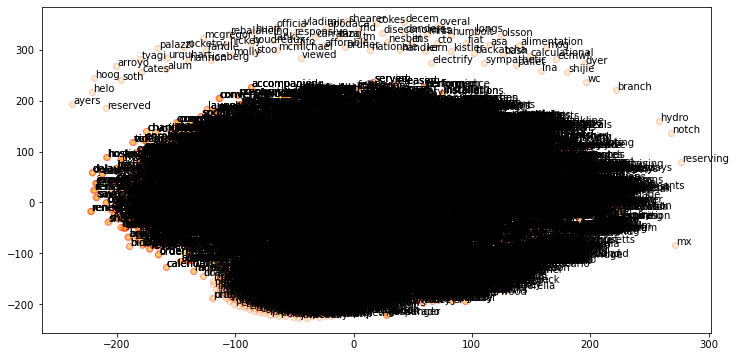

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange',alpha=0.2, edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Cluster documents with GloVe Embeddings


In [64]:
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in nlp_X])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([nlp_emails, cluster_labels], axis=1)

array([[1.2607379, 1.1472194, 1.6505334],
       [1.6081538, 1.1747087, 2.035936 ],
       [1.6821537, 1.3089808, 2.2323465],
       ...,
       [1.5531089, 1.0542673, 2.0448036],
       [2.0337536, 1.4854575, 2.4264257],
       [1.4393605, 1.7564468, 1.9969708]], dtype=float32)

,Unnamed: 0,text,spam,norm_X,nlp_X,topic,ClusterLabel,ClusterLabel
0,3973,"Subject: fyi : energy operations promotions hi vince , scott pleus ( listed below in the director promotion section ) is bandwidth - trading backoffice person we  , ve been working with . i hav...",0,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs since started around time fac...,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs started time fact people talk sally be...,4,21,1
1,4996,"Subject: hedge effectiveness test for fair value hedges gentlemen : we have had favorable responses regarding the use of our volatility reduction method ( roger , i ' ve attached a copy of our ...",0,subject hedge effectiveness test fair value hedges gentlemen favorable responses regarding use volatility reduction method roger attached copy article case seen however continued quibble ...,subject hedge effectiveness test fair value hedges gentlemen favorable responses use volatility reduction method roger attached copy article case seen continued quibble create set data points inpu...,1,38,1
2,1498,"Subject: merit and equity increases norma , i am sending you an excel spreadsheet with proposed merit and equity increases . i have slightly exceeded the merit quota . the equity increases ad...",0,subject merit equity increases norma sending excel spreadsheet proposed merit equity increases slightly exceeded merit quota equity increases address two issues retention error setting salary...,subject merit equity increases norma sending excel spreadsheet proposed merit equity increases slightly exceeded merit quota equity increases address issues retention error setting salary hiring t...,3,57,1
3,3701,Subject: thank you ! fyi from valeria . - - - - - - - - - - - - - - - - - - - - - - forwarded by shirley crenshaw / hou / ect on 09 / 12 / 2000 10 : 03 am - - - - - - - - - - - - - - - - - - - ...,0,subject thank fyi valeria forwarded shirley crenshaw hou ect valeria stone exxon sprint com shirley crenshaw enron ...,subject thank fyi valeria forwarded shirley crenshaw hou valeria stone exxon sprint shirley crenshaw enron subject thank date september stone v valeria vistone americas ext shirley crenshaw enron ...,0,2,0
4,1897,Subject: your talk on 2 / 7 / 00 ( monday ) ( fwd ) vince : a minor revision of my earlier email shown below . the last line should read ' i will be waiting in my office from 6 : 30 - 6 : 50 for...,0,subject talk monday fwd vince minor revision earlier email shown last line read waiting office call office phone sorry resend email ed forwarded message ...,subject talk monday fwd vince minor revision earlier email shown line read waiting office office phone sorry resend email ed forwarded message date thu feb cst edward kao vince j kaminski subject ...,4,67,0
...,...,...,...,...,...,...,...,...
995,1565,"Subject: project richard , i would like to inform you that we decided against participation in your project . thanks for your interest in having enron involved in the study . vince kaminski",0,subject project richard would like inform decided participation project thanks interest enron involved study vince kaminski,subject project richard like inform decided participation project thanks interest enron involved study vince kaminski,0,20,0
996,3746,"Subject: re : phone interview there will be a telephone interview with jerzy jarosz ( resume attached below ) on wednesday , july 5 at 4 : 30 pm houston time . he would like you to call him at ...",0,subject phone interview telephone interview jerzy jarosz resume attached wednesday july pm houston time would like call home telephone reserved ebl interview questions please ...,subject phone interview telephone interview jerzy jarosz resume attached wednesday july houston time like home telephone reserved ebl

### Leveraging gensim for building a FastText model

In [65]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in nlp_X]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [66]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['business', 'new', 'market', 'received', 'prices', 'enron', 'id', 'power', 'message', 'energy']}
similar_words

{'business': ['marketinq', 'company', 'breathing', 'stationery', 'revamping'],
 'new': ['publish', 'ones', 'old', 'fea', 'existing'],
 'market': ['markets', 'based', 'prices', 'price', 'trading'],
 'received': ['smtp', 'qmail', 'helo', 'mailwisconsin', 'sorry'],
 'prices': ['price', 'loading', 'market', 'low', 'produces'],
 'enron': ['subject', 'kaminski', 'forwarded', 'vince', 'corp'],
 'id': ['mime', 'smtp', 'type', 'gzo', 'lotus'],
 'power': ['mw', 'government', 'centre', 'maharashtra', 'minister'],
 'message': ['sent', 'email', 'mail', 'original', 'addressee'],
 'energy': ['trees', 'finance', 'derivatives', 'participants', 'dynamics']}

<Figure size 1296x720 with 0 Axes>

Text(0, 0, 'business')

Text(0, 0, 'marketinq')

Text(0, 0, 'company')

Text(0, 0, 'breathing')

Text(0, 0, 'stationery')

Text(0, 0, 'revamping')

Text(0, 0, 'new')

Text(0, 0, 'publish')

Text(0, 0, 'ones')

Text(0, 0, 'old')

Text(0, 0, 'fea')

Text(0, 0, 'existing')

Text(0, 0, 'market')

Text(0, 0, 'markets')

Text(0, 0, 'based')

Text(0, 0, 'prices')

Text(0, 0, 'price')

Text(0, 0, 'trading')

Text(0, 0, 'received')

Text(0, 0, 'smtp')

Text(0, 0, 'qmail')

Text(0, 0, 'helo')

Text(0, 0, 'mailwisconsin')

Text(0, 0, 'sorry')

Text(0, 0, 'prices')

Text(0, 0, 'price')

Text(0, 0, 'loading')

Text(0, 0, 'market')

Text(0, 0, 'low')

Text(0, 0, 'produces')

Text(0, 0, 'enron')

Text(0, 0, 'subject')

Text(0, 0, 'kaminski')

Text(0, 0, 'forwarded')

Text(0, 0, 'vince')

Text(0, 0, 'corp')

Text(0, 0, 'id')

Text(0, 0, 'mime')

Text(0, 0, 'smtp')

Text(0, 0, 'type')

Text(0, 0, 'gzo')

Text(0, 0, 'lotus')

Text(0, 0, 'power')

Text(0, 0, 'mw')

Text(0, 0, 'government')

Text(0, 0, 'centre')

Text(0, 0, 'maharashtra')

Text(0, 0, 'minister')

Text(0, 0, 'message')

Text(0, 0, 'sent')

Text(0, 0, 'email')

Text(0, 0, 'mail')

Text(0, 0, 'original')

Text(0, 0, 'addressee')

Text(0, 0, 'energy')

Text(0, 0, 'trees')

Text(0, 0, 'finance')

Text(0, 0, 'derivatives')

Text(0, 0, 'participants')

Text(0, 0, 'dynamics')

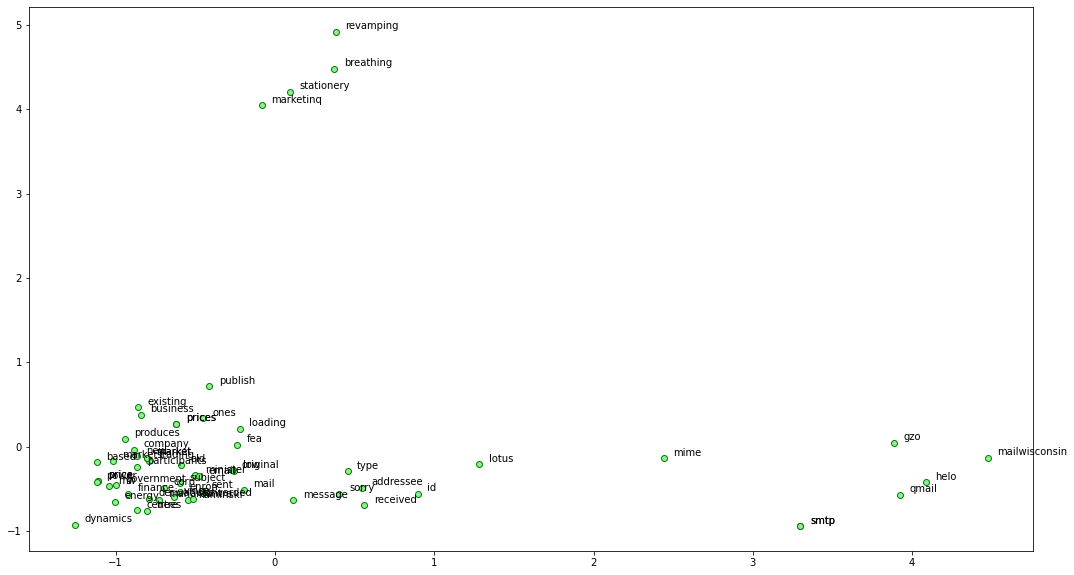

In [67]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [ ]:
print(ft_model.wv.similarity(w1='marketing', w2='design'))
print(ft_model.wv.similarity(w1='business', w2='decision'))

## Recreate Final Model

In [68]:
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular

In [ ]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [ ]:
wrong_exp.show_in_notebook(show_predicted_value=False)

In [ ]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

## Examining a Single Decision Tree

In [ ]:
# Extract a single tree
from sklearn.tree import export_graphviz

single_tree = model_reduced.estimators_[105][0]


tree.export_graphviz(single_tree, out_file = 'images_tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

In [ ]:
tree.export_graphviz(single_tree, out_file = 'images_tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

In [ ]:
!dot -Tpng images_tree_small.dot -o images_tree_small.png
from IPython.display import Image
Image(filename = 'images_tree_small.png')